In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

##### **Warning** *this is an extremely technical blog post (even for me) but I think that it's an interesting experiment so I thought I would post it anyways!*

The *Kepler* Mission has been a great success story for open science. The recent data releases have been on a fast and regular schedule and the data products are sometimes made public before the science office publishes their papers. Therefore, when the most recent installment in the "rate of Earths" saga—a discussion [close to my heart](http://arxiv.org/abs/1406.3020)—hit the ArXiv as [Burke et al. (2015)](http://arxiv.org/abs/1506.04175), I decided to see if I could reproduce their results by following the steps described in their paper. Crazy, right?

In this blog post, I'll go through the steps to reproduce most of their key results as an experiment in *Open Science*. [*Spoiler alert: I dont get exactly the same results but I do come to the same conclusions...*]

It's also worth noting that Burke also posted code and results to supplement the paper: [christopherburke/KeplerPORTs](https://github.com/christopherburke/KeplerPORTs).


## The science case

While the point of this post isn't to discuss the physical implications of this result, it is worth taking a moment to motivate this experiment. One of the key areas of research in exoplanets is (what I like to call) *population inference*; determining the underlying occurrence rate and distribution of exoplanets and their physical properties. This is interesting as a data science problem because we now have large catalogs of exoplanet discoveries and characterizations and it's interesting scientifically because it is the best shot we have of connecting exoplanet observations to theories of the formation and evolution of exoplanet systems. It also places a constraint on the frequency of planets like Earth and planetary systems like our Solar system (Are we alone? and all that...).

There has been a huge amount of research in this field but [Burke et al. (2015)](http://arxiv.org/abs/1506.04175) present (arguably) the most careful treatment of the systematic effects based on a characterization of the official *Kepler* pipeline. Even before submission, the data products describing this characterization were all publicly available on the [Exoplanet Archive](http://exoplanetarchive.ipac.caltech.edu/).


## The problem

The basic data analysis question that we're trying to answer here is: given an incomplete catalog of planet parameters (smaller planets on longer periods are harder to find), what can we say about the underlying distribution of properties? For this model, we'll use the Poisson process likelihood to compute the probability of a set of measurements (e.g. orbital period, planet radius, etc.) $w_k = (P_k,\,R_k)$, given a parametric model for the underlying "occurrence rate" $\Gamma_\theta(w)$

$$p(\{w_k\}\,|\,\theta) = \exp \left(\int Q(w)\,\Gamma_\theta(w)\,\mathrm{d}w\right) \, \prod_{k=1}^K Q(w_k)\,\Gamma_\theta(w_k)$$

where $Q(w)$ is an estimate of the (mean) detection efficiency (or completeness) as a function of the parameters $w$. Then, we just need to optimize for $\theta$ or choose a prior $p(\theta)$ and sample using MCMC. Like Burke et al., we'll build our model in orbital period (in days) and planet radius (in Earth radii) and use a product of independent power laws in the two dimensions for $\Gamma_\theta (w) = \Gamma_\theta (P)\,\Gamma_\theta (R)$.


## The data

To start, let's download (and cache) the dataset from the Exoplanet Archive. Don't worry about the details of these functions but what they do is download the csv tables (`q1_q16_stellar` and `q1_q16_koi`) and save them as a pandas block.

In [2]:
from __future__ import division, print_function
import os
import requests
import pandas as pd
from io import BytesIO

def get_catalog(name, basepath="data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = BytesIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df

Now we will make the cuts on the stellar sample to select the G and K dwarfs:

* $4200\,K \le T_\mathrm{eff} \le 6100\,K$,
* $R_\star \le 1.15\,R_\odot$,
* $T_\mathrm{obs} > 2\,\mathrm{yr}$,
* $f_\mathrm{duty} > 0.6$, and
* $\mathrm{robCDPP7.5} \le 1000\,\mathrm{ppm}$.

In [3]:
import numpy as np

stlr = get_catalog("q1_q16_stellar")

# Select G and K dwarfs.
m = (4200 <= stlr.teff) & (stlr.teff <= 6100)
m &= stlr.radius <= 1.15

# Only include stars with sufficient data coverage.
m &= stlr.dataspan > 365.25*2.
m &= stlr.dutycycle > 0.6
m &= stlr.rrmscdpp07p5 <= 1000.

# Only select stars with mass estimates.
m &= np.isfinite(stlr.mass)

base_stlr = pd.DataFrame(stlr)
stlr = pd.DataFrame(stlr[m])

print("Selected {0} targets after cuts".format(len(stlr)))

Selected 91446 targets after cuts


After applying these same cuts to a pre-release version of this catalog, Burke et al. found 91,567 targets.

[*Using the machine readable version of their Table 1, I tried to work out the reason for this difference and I couldn't reverse engineer any cause. Some of the targets missing from our catalog are just artificially fixed at Solar values so they seem reasonable to skip. This effect explains about half the difference between the results.*]

We can now make a plot of the HR diagram of these sources to reproduce Figure 3 from Burke et al.:

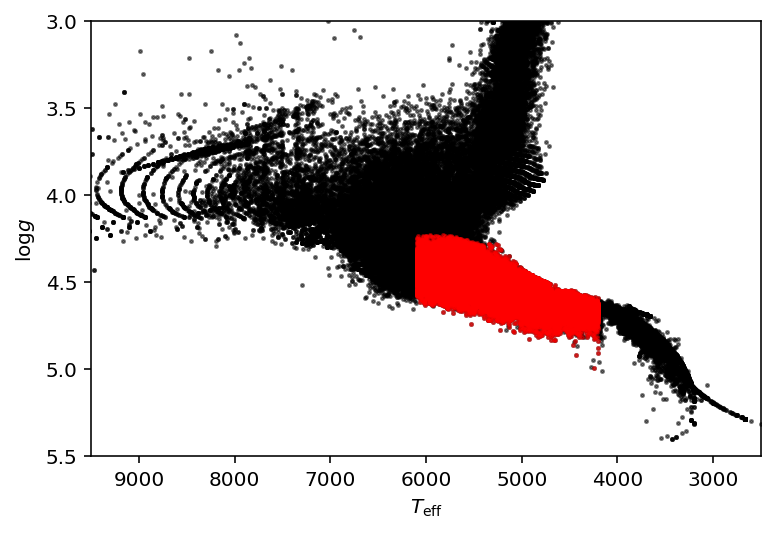

In [4]:
import matplotlib.pyplot as pl

pl.plot(base_stlr.teff, base_stlr.logg, ".k", ms=3, alpha=0.5)
pl.plot(stlr.teff, stlr.logg, ".r", ms=3, alpha=0.5)
pl.xlim(9500, 2500)
pl.ylim(5.5, 3)
pl.ylabel("$\log g$");
pl.xlabel("$T_\mathrm{eff}$");

Next up, let's make the cuts on the KOI list:

* disposition from the Q1-Q16 pipeline run: `CANDIDATE`,
* $50\,\mathrm{day} \le P \le 300\,\mathrm{day}$, and
* $0.75\,R_\oplus \le R \le 2.5\,R_\oplus$.

In [5]:
kois = get_catalog("q1_q16_koi")
print(len(kois))

period_rng = (50, 300)
rp_rng = (0.75, 2.5)

# Join on the stellar list.
kois = kois[kois["kepid"].isin(stlr["kepid"])]
print(len(kois))
                               
# Only select the KOIs in the relevant part of parameter space.
m = kois.koi_pdisposition == "CANDIDATE"
base_kois = pd.DataFrame(kois[m])
m &= (period_rng[0] <= kois.koi_period) & (kois.koi_period <= period_rng[1])
m &= np.isfinite(kois.koi_prad) & (rp_rng[0] <= kois.koi_prad) & (kois.koi_prad <= rp_rng[1])

kois = pd.DataFrame(kois[m])

print("Selected {0} KOIs after cuts".format(len(kois)))

7348
3922
Selected 154 KOIs after cuts


Burke et al. find 156 KOIs instead of our 154 again because of their pre-release version of the catalog and changing dispositions. As we'll see, this doesn't have a huge effect on the results even though there's some risk of being dominated by small number statistics.

Now, let's plot the distribution of measured physical parameters in this catalog of KOIs. Unlike most versions of this plot, here we'll include the error bars on the radii as a reminder that many of the radii are very poorly constrained!

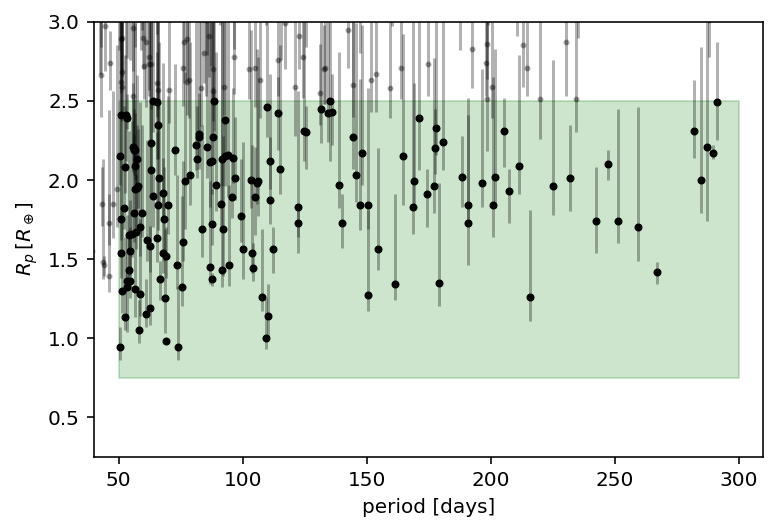

In [6]:
yerr = np.abs(np.array(base_kois[["koi_prad_err2", "koi_prad_err1"]])).T
pl.errorbar(base_kois.koi_period, base_kois.koi_prad, yerr=yerr, fmt=".k", ms=4,
            capsize=0, alpha=0.3)
pl.plot(kois.koi_period, kois.koi_prad, ".k", ms=6)
pl.fill_between(period_rng, [rp_rng[1], rp_rng[1]], [rp_rng[0], rp_rng[0]], color="g", alpha=0.2)
pl.xlim(period_rng + 10 * np.array([-1, 1]))
pl.ylim(rp_rng + 0.5 * np.array([-1, 1]))
pl.xlabel("period [days]")
pl.ylabel("$R_p \, [R_\oplus]$");

## The detection efficiency model

For this problem of population inference, an important ingredient is a detailed model of the efficiency with which the transit search pipeline detects transit signals. Burke et al. implement an analytic model for the detection efficiency that has been calibrated using simulations in a (submitted but unavailable) paper by Jessie Christiansen. The details of this model are given in the Burke et al. paper so I'll just go ahead and implement it and if you're interested, check out [the paper](http://arxiv.org/abs/1506.04175).

In [7]:
from scipy.stats import gamma

def get_duration(period, aor, e):
    """
    Equation (1) from Burke et al. This estimates the transit
    duration in the same units as the input period. There is a
    typo in the paper (24/4 = 6 != 4).
    
    :param period: the period in any units of your choosing
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param e:      the eccentricity of the orbit
    
    """
    return 0.25 * period * np.sqrt(1 - e**2) / aor

def get_a(period, mstar, Go4pi=2945.4625385377644/(4*np.pi*np.pi)):
    """
    Compute the semi-major axis of an orbit in Solar radii.
    
    :param period: the period in days
    :param mstar:  the stellar mass in Solar masses
    
    """
    return (Go4pi*period*period*mstar) ** (1./3)

def get_delta(k, c=1.0874, s=1.0187):
    """
    Estimate the approximate expected transit depth as a function
    of radius ratio. There might be a typo here. In the paper it
    uses c + s*k but in the public code, it is c - s*k:
    https://github.com/christopherburke/KeplerPORTs
    
    :param k: the dimensionless radius ratio between the planet and
              the star
    
    """
    delta_max = k*k * (c + s*k)
    return 0.84 * delta_max

cdpp_cols = [k for k in stlr.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)
def get_mes(star, period, rp, tau, re=0.009171):
    """
    Estimate the multiple event statistic value for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param tau:    the transit duration in hours
    
    """
    # Interpolate to the correct CDPP for the duration.
    cdpp = np.array(star[cdpp_cols], dtype=float)
    sigma = np.interp(tau, cdpp_vals, cdpp)

    # Compute the radius ratio and estimate the S/N.
    k = rp * re / star.radius
    snr = get_delta(k) * 1e6 / sigma
    
    # Scale by the estimated number of transits.
    ntrn = star.dataspan * star.dutycycle / period 
    return snr * np.sqrt(ntrn)

# Pre-compute and freeze the gamma function from Equation (5) in
# Burke et al.
pgam = gamma(4.65, loc=0., scale=0.98)
mesthres_cols = [k for k in stlr.keys() if k.startswith("mesthres")]
mesthres_vals = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)
def get_pdet(star, aor, period, rp, e):
    """
    Equation (5) from Burke et al. Estimate the detection efficiency
    for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param e:      the orbital eccentricity
    
    """
    tau = get_duration(period, aor, e) * 24.
    mes = get_mes(star, period, rp, tau)
    mest = np.interp(tau, mesthres_vals,
                     np.array(star[mesthres_cols],
                              dtype=float))
    x = mes - 4.1 - (mest - 7.1)
    return pgam.cdf(x)

def get_pwin(star, period):
    """
    Equation (6) from Burke et al. Estimates the window function
    using a binomial distribution.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    
    """
    M = star.dataspan / period
    f = star.dutycycle
    omf = 1.0 - f
    pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
    msk = (pw >= 0.0) * (M >= 2.0)
    return pw * msk

def get_pgeom(aor, e):
    """
    The geometric transit probability.
    
    See e.g. Kipping (2014) for the eccentricity factor
    http://arxiv.org/abs/1408.1393
    
    :param aor: the dimensionless semi-major axis (scaled
                by the stellar radius)
    :param e:   the orbital eccentricity

    """
    return 1. / (aor * (1 - e*e)) * (aor > 1.0)

def get_completeness(star, period, rp, e, with_geom=True):
    """
    A helper function to combine all the completeness effects.
    
    :param star:      a pandas row giving the stellar properties
    :param period:    the period in days
    :param rp:        the planet radius in Earth radii
    :param e:         the orbital eccentricity
    :param with_geom: include the geometric transit probability?
    
    """
    aor = get_a(period, star.mass) / star.radius
    pdet = get_pdet(star, aor, period, rp, e)
    pwin = get_pwin(star, period)
    if not with_geom:
        return pdet * pwin
    pgeom = get_pgeom(aor, e)
    return pdet * pwin * pgeom

Using this model, lets reproduce Figure 1 from the Burke paper. If you closely compare the figures, you'll find that they're not quite the same but the one in the paper was generated with an older (incomplete) version of the code (Burke, priv. comm.) and the model used is actually the same as this one so we'll roll with it!

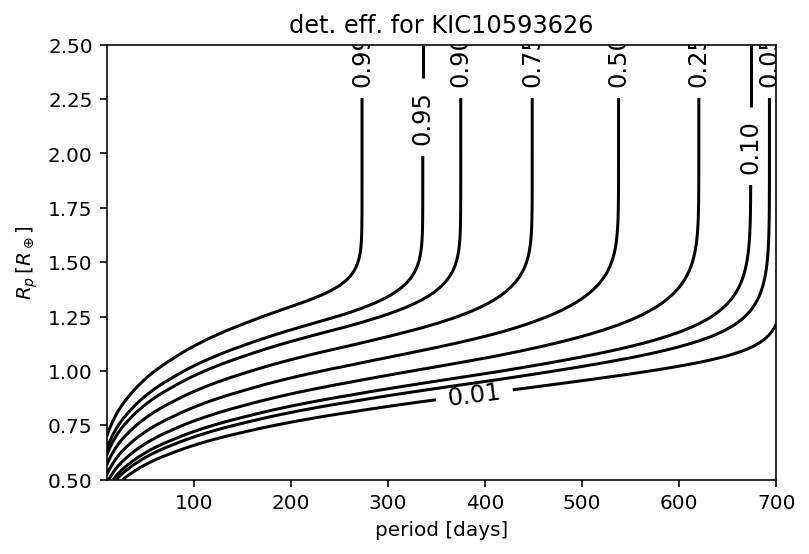

In [8]:
# Choose the star.
star = stlr[stlr.kepid == 10593626].iloc[0]

# Compute the completeness map on a grid.
period = np.linspace(10, 700, 500)
rp = np.linspace(0.5, 2.5, 421)
X, Y = np.meshgrid(period, rp, indexing="ij")
Z = get_completeness(star, X, Y, 0.0, with_geom=False)

# Plot with the same contour levels as the figure.
c = pl.contour(X, Y, Z, [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99], colors="k")
pl.clabel(c, fontsize=12, inline=1, fmt="%.2f") 
pl.xlabel("period [days]")
pl.ylabel("$R_p \, [R_\oplus]$")
pl.title("det. eff. for KIC10593626");

In practice, the only detection efficiency function that enters our analysis is *integrated across the stellar sample*. In fact, the function $Q(w)$ needs to be integrated (marginalized) over *all the parameters that affect it but aren't of interest*, for example, [we should include eccentricity](http://arxiv.org/abs/1408.1393). For now, following Burke et al., we'll ignore eccentricity and integrate only over the stellar parameters. This cell takes a minute or two to run because it must loop over every star in the sample and compute the completeness on a grid.

In [9]:
period = np.linspace(period_rng[0], period_rng[1], 57)
rp = np.linspace(rp_rng[0], rp_rng[1], 61)
period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
comp = np.zeros_like(period_grid)
for _, star in stlr.iterrows():
    comp += get_completeness(star, period_grid, rp_grid, 0.0, with_geom=True)

In the target range, here is the completeness function (including the geometric transit probability):

In [20]:
np.save('data/comp_r_0p75_2p25_61_p_50_300_57.npy', comp)

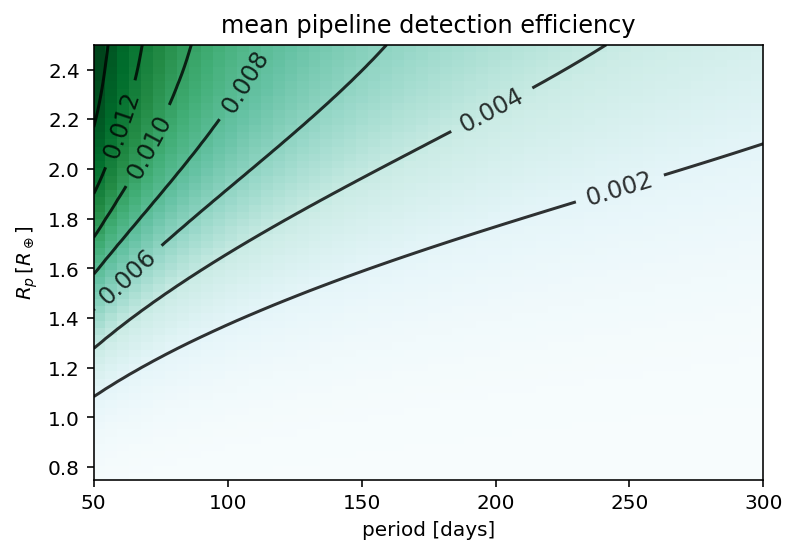

In [10]:
pl.pcolor(period_grid, rp_grid, comp, cmap="BuGn")
c = pl.contour(period_grid, rp_grid, comp / len(stlr),
               colors="k", alpha=0.8)
pl.clabel(c, fontsize=12, inline=1, fmt="%.3f")
pl.title("mean pipeline detection efficiency")
pl.xlabel("period [days]")
pl.ylabel("$R_p \, [R_\oplus]$");

## Population inference

Now that we have our sample and our completeness model, we need to specify the underlying population model. Like Burke et al., I've found that the data don't support a broken power law in planet radius so let's just model the population as the product of indpendent power laws in $P$ and $R_p$.

In [41]:
# A double power law model for the population.
def population_model(theta, period, rp):
    lnf0, beta, alpha = theta
    v = np.exp(lnf0) * np.ones_like(period)
    for x, rng, n in zip((period, rp),
                         (period_rng, rp_rng),
                         (beta, alpha)):
        n1 = n + 1
        v *= x**n*n1 / (rng[1]**n1-rng[0]**n1)
    return v

# The ln-likelihood function given at the top of this post.
koi_periods = np.array(kois.koi_period)
koi_rps = np.array(kois.koi_prad)
vol = np.diff(period_grid, axis=0)[:, :-1] * np.diff(rp_grid, axis=1)[:-1, :]
def lnlike(theta):
    pop = population_model(theta, period_grid, rp_grid) * comp
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    print(norm)
    ll = np.sum(np.log(population_model(theta, koi_periods, koi_rps))) - norm
    return ll if np.isfinite(ll) else -np.inf

# The ln-probability function is just propotional to the ln-likelihood
# since we're assuming uniform priors.
bounds = [(-5, 5), (-5, 5), (-5, 5)]
def lnprob(theta):
    # Broad uniform priors.
    for t, rng in zip(theta, bounds):
        if not rng[0] < t < rng[1]:
            return -np.inf
    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15

To start, let's find the maximum likelihood solution for the population parameters by minimizing the negative log-likelihood.

In [43]:
lnlike(np.array([1, 2, 3]))

734.6616031525973


-1706.8825448685839

In [42]:
from scipy.optimize import minimize
theta_0 = np.array([np.log(0.75), -0.53218, -1.5])
r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)
print(r)

142.60447049482627
142.604471920871
142.60447005263907
142.60447098892251
123510.96963756268
123510.97087267235
123510.9695724045
123510.96976924092
951.3440591935976
951.344068707038
951.3440569102094
951.3440618194234
156.17427385747763
156.1742754192204
156.17427337554713
156.17427439358838
155.35534665554746
155.35534820910092
155.35534617657154
155.35534718905248
153.87600086870424
153.87600240746428
153.8760003967502
153.87600139768048
153.90152048514346
153.90152202415862
153.90152001300424
153.9015210147258
153.98938926175202
153.98939080164592
153.9893887888483
153.98938979337782
154.00164003084703
154.00164157086346
154.00163955789844
154.0016405625206
      fun: 1147.3903142162226
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00165983, -0.00077307,  0.00061391])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 6
   status: 0
  success: True
        x: array([-0.25088527, -0.678807  , -1.51497596])


...and plot it:

[0.58432182]


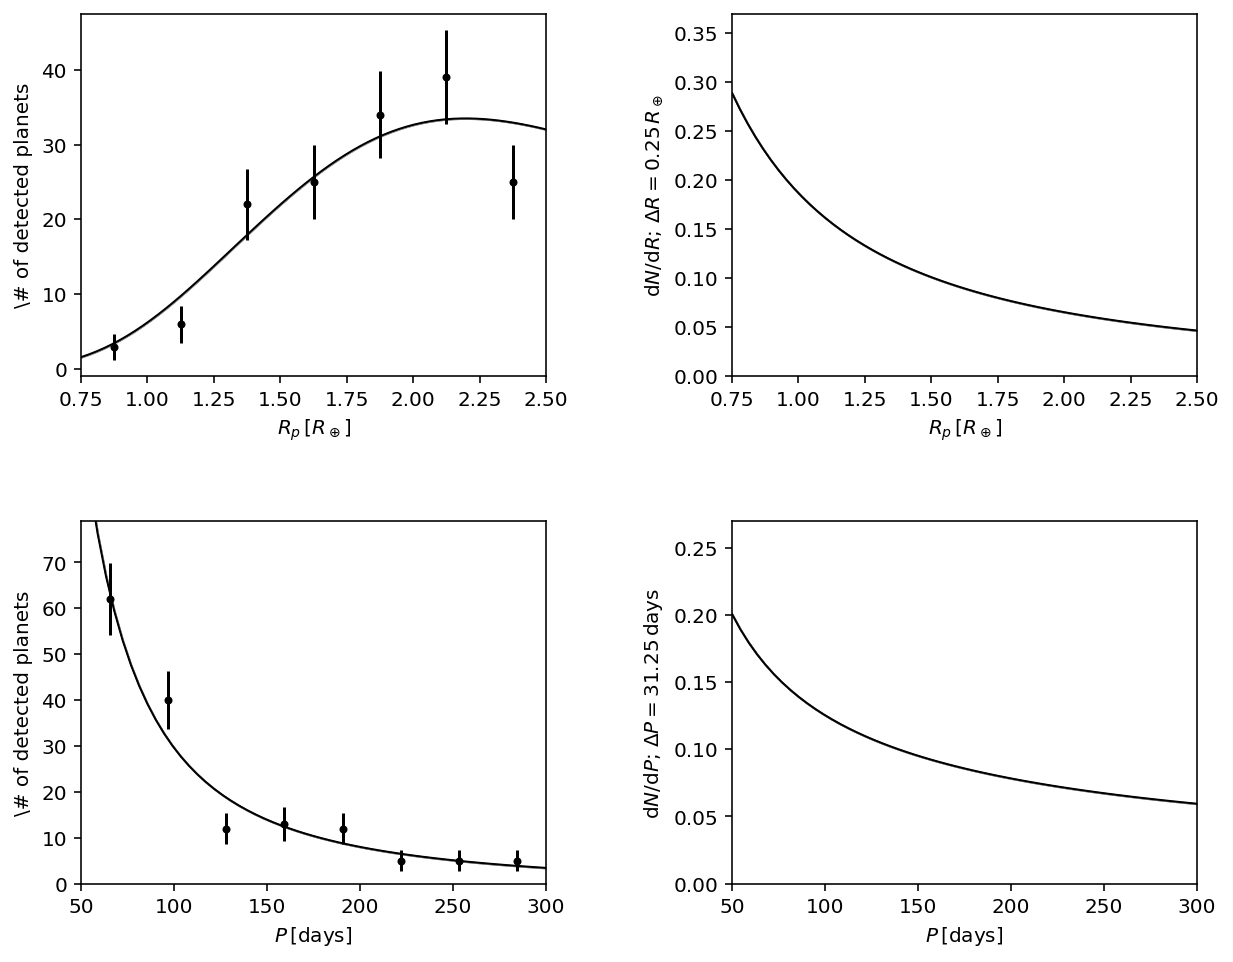

In [31]:
# We'll reuse these functions to plot all of our results.
def make_plot(pop_comp, x0, x, y, ax):
    pop = 0.5 * (pop_comp[:, 1:] + pop_comp[:, :-1])
    pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)
    a, b, c, d, e = np.percentile(pop * np.diff(x)[0], [2.5, 16, 50, 84, 97.5], axis=0)

    ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    ax.plot(x0, c, "k", lw=1)

def plot_results(samples):
    # Loop through the samples and compute the list of population models.
    samples = np.atleast_2d(samples)
    pop = np.empty((len(samples), period_grid.shape[0], period_grid.shape[1]))
    gamma_earth = np.empty((len(samples)))
    for i, p in enumerate(samples):
        pop[i] = population_model(p, period_grid, rp_grid)
        gamma_earth[i] = population_model(p, 365.25, 1.0) * 365.
        
    fig, axes = pl.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Integrate over period.
    dx = 0.25
    x = np.arange(rp_rng[0], rp_rng[1] + dx, dx)
    n, _ = np.histogram(koi_rps, x)
    
    # Plot the observed radius distribution.
    ax = axes[0, 0]
    make_plot(pop * comp[None, :, :], rp, x, period, ax)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_xlabel("$R_p\,[R_\oplus]$")
    ax.set_ylabel("\# of detected planets")
    
    # Plot the true radius distribution.
    ax = axes[0, 1]
    make_plot(pop, rp, x, period, ax)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_ylim(0, 0.37)
    ax.set_xlabel("$R_p\,[R_\oplus]$")
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}R$; $\Delta R = 0.25\,R_\oplus$")
    
    # Integrate over period.
    dx = 31.25
    x = np.arange(period_rng[0], period_rng[1] + dx, dx)
    n, _ = np.histogram(koi_periods, x)
    
    # Plot the observed period distribution.
    ax = axes[1, 0]
    make_plot(np.swapaxes(pop * comp[None, :, :], 1, 2), period, x, rp, ax)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(period_rng[0], period_rng[1])
    ax.set_ylim(0, 79)
    ax.set_xlabel("$P\,[\mathrm{days}]$")
    ax.set_ylabel("\# of detected planets")
    
    # Plot the true period distribution.
    ax = axes[1, 1]
    make_plot(np.swapaxes(pop, 1, 2), period, x, rp, ax)
    ax.set_xlim(period_rng[0], period_rng[1])
    ax.set_ylim(0, 0.27)
    ax.set_xlabel("$P\,[\mathrm{days}]$")
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}P$; $\Delta P = 31.25\,\mathrm{days}$")
    
    return gamma_earth

print(plot_results(r.x));

Finally, let's sample from the posterior probability for the population parameters using [emcee](http://dfm.io/emcee).

In [32]:
import emcee

ndim, nwalkers = len(r.x), 16
pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Burn in.
pos, _, _ = sampler.run_mcmc(pos, 1000)
sampler.reset()

# Production.
pos, _, _ = sampler.run_mcmc(pos, 4000)

[-0.2508781  -0.67880067 -1.51498552] 154.0019373710644
[-0.25088323 -0.67879081 -1.51498042] 154.0009518440598
[-0.2508906  -0.67880432 -1.51498191] 154.00037566890896
[-0.25089072 -0.67880347 -1.51498199] 154.00031301338615
[-0.25086611 -0.67880511 -1.51496981] 154.0048283732477
[-0.25088259 -0.67879477 -1.51497837] 154.00134611148738
[-0.25088926 -0.6788207  -1.51497325] 154.00181854449377
[-0.25087713 -0.67881235 -1.51498699] 154.00256040271117
[-0.25086436 -0.67880103 -1.51500493] 154.00303871955535
[-0.25087542 -0.67879807 -1.51497405] 154.0028362237567
[-0.25087655 -0.67879993 -1.51497175] 154.00287249992897
[-0.25087714 -0.6787975  -1.51499156] 154.00161373073237
[-0.25088438 -0.67882425 -1.51497705] 154.00253486414172
[-0.25088805 -0.67883154 -1.51495853] 154.00330017245773
[-0.25089019 -0.67880356 -1.51499126] 153.99990668847792
[-0.25089905 -0.67879051 -1.51498986] 153.9979994776382
[-0.25087488 -0.67880222 -1.51498485] 154.0025411187382
[-0.25089823 -0.67881342 -1.51498529]

[-0.25077738 -0.67843501 -1.51494774] 154.00216214257557
[-0.25093067 -0.67872083 -1.51506138] 153.9860313975318
[-0.25112588 -0.67906364 -1.51525124] 153.96209214346678
[-0.25085267 -0.67779286 -1.5151405 ] 153.94995466964804
[-0.25084913 -0.67884921 -1.51494862] 154.01065558480826
[-0.25138448 -0.68148231 -1.51493183] 154.05362857676542
[-0.25089255 -0.67886566 -1.51503714] 154.00004032301626
[-0.25109855 -0.67946673 -1.5150293 ] 153.99716003138673
[-0.25054427 -0.67753094 -1.51489828] 153.99793098980226
[-0.25094483 -0.67917491 -1.51486702] 154.0156595945587
[-0.25077182 -0.67897092 -1.51484171] 154.0340054589079
[-0.25089607 -0.67830163 -1.5151258 ] 153.9681113837351
[-0.25079339 -0.67866328 -1.51487096] 154.01457642412723
[-0.25186776 -0.68389084 -1.5148812 ] 154.09578372694122
[-0.25139743 -0.68141713 -1.51470811] 154.06044661884894
[-0.25064716 -0.67785965 -1.51501051] 153.9916652651356
[-0.2509388  -0.67882779 -1.51501327] 153.9923967107136
[-0.25085729 -0.67772498 -1.51516152]

[-0.25754265 -0.70433474 -1.51676751] 154.0871337298521
[-0.26376096 -0.7330539  -1.5154223 ] 154.5549526960508
[-0.23689955 -0.62215949 -1.51400693] 153.5221610316505
[-0.25313011 -0.68995295 -1.5149153 ] 154.18613865013674
[-0.2446089 -0.6662743 -1.5108948] 154.59329780664405
[-0.25559709 -0.70480872 -1.51382277] 154.56652996787497
[-0.25304016 -0.66684613 -1.51773377] 152.96059013117213
[-0.24454365 -0.64469111 -1.51594252] 153.31239830947612
[-0.25134568 -0.69442766 -1.51170777] 154.844875616044
[-0.26015494 -0.71740529 -1.51531032] 154.37895618995958
[-0.24760898 -0.66082228 -1.51612312] 153.59441684861852
[-0.25424569 -0.67640246 -1.51778924] 153.22274575235787
[-0.25394109 -0.69323315 -1.51493722] 154.2150707440959
[-0.234302   -0.63012909 -1.50814838] 154.61313608402264
[-0.23732045 -0.60722778 -1.516812  ] 152.6034794738283
[-0.25140514 -0.68313656 -1.51483913] 154.13363419146228
[-0.30677028 -0.96708181 -1.50838812] 159.23145765801982
[-0.26154502 -0.71065781 -1.520074  ] 153

[-0.13007823 -0.3358394  -1.56501863] 153.51032913894085
[-0.22153339 -0.70957469 -1.47782112] 162.14968693305406
[-0.27972712 -0.64114685 -1.53080313] 147.09171339839753
[-0.24461819 -0.59395157 -1.52086919] 150.66144723656828
[-0.27756699 -0.78503983 -1.52701021] 154.25235455480214
[-0.12749992  0.02194866 -1.58559318] 136.73087965845502
[-0.24739803 -0.74505833 -1.49802216] 158.62760052737687
[-0.4333934  -1.13672231 -1.55635451] 145.0060532583441
[-0.41553742 -0.93727759 -1.59955666] 137.1956314369328
[-0.2353788  -0.44971298 -1.546436  ] 144.10638223349534
[-0.19922627 -0.58816135 -1.48986208] 159.07310697616143
[-0.32345429 -0.95799732 -1.53632125] 154.69273954564085
[-0.20807052 -0.55617496 -1.48675044] 156.28837368849656
[-0.22989612 -0.70187561 -1.48711794] 159.91053091442402
[-0.38113288 -0.90298566 -1.61912601] 139.59626589634783
[-0.09794242 -0.19078019 -1.61391689] 148.88924868321214
[-0.4364093  -1.0473687  -1.58925026] 139.29759152916162
[-0.33244543 -1.00988528 -1.53528

[-0.14881085 -0.63768786 -1.43476514] 173.11086833811245
[-0.26692684 -0.78732928 -1.50192162] 157.36179648957838
[-0.28754989 -0.67250848 -1.52026044] 147.90024749625059
[-0.28911766 -0.89443603 -1.44207124] 162.21936303656162
[-0.27352252 -0.84938174 -1.54157818] 157.13279437808433
[-0.3414579  -0.76393258 -1.44932413] 147.6551221086191
[-0.027522   -0.55306384 -1.18264027] 207.14477942325368
[-0.45766761 -0.972688   -1.60062663] 132.8788422952748
[-0.26369175 -0.63204679 -1.55165482] 147.9743954018993
[-0.31087541 -0.86626671 -1.49459928] 154.6131261816917
[-0.27420128 -0.85576749 -1.54565919] 157.107636354135
[-0.35211097 -0.77808594 -1.57255598] 140.63657948758478
[-0.18093621 -0.51716247 -1.49617145] 158.14136398747175
[-0.25109442 -0.79493002 -1.41989706] 164.7783374024703
[-0.42209483 -0.42067365 -1.61775236] 115.53820848852973
[-0.17609717 -0.77007011 -1.46903795] 173.36301087687775
[-0.36661286 -0.81795854 -1.61799585] 138.101109984652
[-0.27627015 -0.78284379 -1.55032739] 15

[-0.08205126 -0.22408672 -1.41813964] 163.76304437224692
[-0.22391659 -0.72108628 -1.56787744] 157.3661967991304
[-0.09729417 -0.35108238 -1.45743293] 165.49725204135032
[-0.27104693 -1.06857205 -1.38507037] 177.18889620886645
[-0.20629535 -0.82091022 -1.70992139] 157.09667029776043
[-0.31610105 -0.82627357 -1.80866308] 136.10792890049575
[-0.54460662 -0.82971751 -1.2352787 ] 131.99841348279244
[-0.41287251 -0.92236521 -1.35467391] 148.82395059442763
[-0.17871074 -0.49135767 -1.87402981] 137.34845812279596
[-0.10505449 -0.51974589 -1.56846546] 166.49588050646778
[-0.15979339 -0.67301857 -1.7529158 ] 154.85242940341888
[-0.49079126 -0.95080182 -1.34366973] 139.33500091092006
[ 0.04114225 -0.17275464 -2.02413699] 146.17417716030752
[-0.3782686  -0.47822808 -1.39327324] 132.88095550454815
[-0.03223273 -0.44307455 -1.79031445] 161.4837454670327
[-0.34385242 -0.81718411 -1.24467788] 160.25052798625336
[-0.17091602 -0.47701041 -1.89131799] 136.92041073175454
[-0.10825547 -0.58931614 -1.61426

[-0.34264649 -1.41130979 -1.1144921 ] 197.78919561368704
[-0.1918494  -0.74073294 -1.61078418] 161.04727359012261
[-0.66045857 -1.20770558 -0.68458119] 154.91251264497723
[-0.3120124  -0.84938638 -1.68014009] 144.07442703640731
[-0.27661488 -0.75002846 -1.80628002] 138.42501708302967
[-0.22195374 -0.52464921 -1.42799083] 155.75234897380915
[-0.17124517 -0.6361929  -1.97669234] 139.46615687627127
[-0.39455417 -0.093451   -1.13754346] 126.56287311834528
[-0.08909156 -0.02452185 -1.43586519] 151.99166138806652
[-0.01582476 -0.57360635 -1.85244632] 167.21581248221653
[-0.18743658 -0.73626718 -1.62041467] 160.9941220712419
[-0.19827452 -0.63135719 -1.33459782] 170.0980342605809
[-0.03008613 -0.29978018 -1.48756311] 172.38504221941272
[-0.2070764  -0.70767794 -1.86541274] 143.35098966241623
[-0.2139974  -1.26387893 -1.30310624] 203.6196966205493
[-0.37045794 -0.84787144 -1.7103686 ] 134.3904809579166
[-0.5548344  -1.05147374 -1.24363691] 139.05442169477618
[-0.77133292 -1.31638922 -0.4856371

[-0.31459144 -0.71678526 -1.20860027] 162.0021270114566
[-0.30750753 -0.63971702 -1.91297561] 124.73580369240346
[-0.27015732 -0.86378229 -1.66535312] 151.67634868483165
[-0.19479444 -0.5686411  -1.87503272] 138.44578705503227
[-0.2422394  -0.70338061 -1.36402314] 164.76447457143544
[-0.27477507 -0.2092488  -1.27490942] 141.18168051018614
[-0.02606267 -0.31132084 -1.98267513] 145.10767506970677
[-0.3613399  -0.36945505 -0.92895088] 152.09969655846368
[-0.01497075 -0.44739479 -1.89910166] 158.07619074458643
[-0.27661692 -0.66772358 -1.34432688] 158.5199942131104
[-0.2798674  -0.49425812 -0.70012663] 183.60552158925037
[-0.19321539 -0.56539792 -1.88212706] 138.16256827485648
[-0.30227731 -0.409303   -1.25436113] 147.07805945778097
[-0.26119921 -0.49976174 -1.33965693] 153.13773048428325
[-0.05947362 -0.60449435 -1.84378463] 162.14790804510048
[-0.56241393 -0.73322738 -1.05953925] 133.285427045957
[-0.21157955 -0.78930749 -1.56597069] 162.7819759467405
[-0.15147046 -0.63562359 -1.77431528

[-0.61051068 -1.46445631 -1.62180159] 130.02471124782397
[-0.62013584 -0.70993554 -0.67163731] 140.47343805953545
[-0.02650452 -0.50995451 -2.37143736] 133.211609233512
[-0.41605269 -0.77429008 -1.11453182] 153.5001411461451
[ 0.02652988 -0.51871413 -1.61629667] 186.67869926197073
[ 0.12691038 -0.16532837 -2.10878007] 153.8204422989428
[-0.36128938 -0.80321719 -1.22357951] 157.9065163395239
[-0.04111388 -0.53750471 -2.21506203] 140.70246821670614
[-0.2362539  -0.46103638 -1.16034503] 164.64970324998038
[-0.70407604 -0.80705658  0.4461241 ] 175.2186243968889
[-0.25535484 -0.82496372 -1.46327297] 163.1546239576584
[-0.21925583 -0.60865319 -1.51617662] 155.48790220076123
[-0.06527512 -0.46867344 -1.90415522] 151.05639457342397
[-0.11980925 -0.49892999 -1.37957506] 173.98489935064777
[-0.15907604 -0.8760897  -1.65476205] 170.76124682888135
[ 0.26013851 -0.44792863 -3.08339474] 130.74159469480344
[-0.02626763 -0.53076391 -1.58179463] 179.9192227464547
[-0.30540725 -0.40009344 -1.39416649] 1

[-0.06130908 -0.45750029 -1.74567598] 160.1457596974202
[-0.23310691 -0.5150146  -1.50671788] 149.45487595925474
[-0.22163594 -0.5031379  -1.149655  ] 169.8281452330399
[-0.25038534 -0.46996139 -1.33011602] 153.88090772965472
[-0.4194439  -0.75494294 -1.53717038] 132.16429811210241
[-0.34947429 -0.72013207 -1.21569726] 156.24495271083097
[-0.44012109 -0.70831192 -1.15216104] 145.1538023773091
[-0.24713296 -0.76453149 -1.54281172] 157.17045866833246
[-0.14840055 -0.54785324 -1.68756639] 154.19713035696458
[-0.04230476 -0.71922983 -1.92375397] 166.05816725493366
[-0.46384192 -0.89796224 -1.49247523] 134.04469647134457
[-0.41985052 -0.7762806  -1.46346943] 136.37621079267282
[-0.37994788 -0.53115279 -0.98183266] 154.23309584419468
[-0.37515325 -0.71422162 -1.29188675] 148.2554505736989
[-0.01443732 -0.33876674 -1.17197421] 197.23006084505408
[-0.15302671 -0.42695539 -1.58585375] 153.22871443275176
[-0.24620636 -0.54349793 -1.46768882] 150.83961850095451
[-0.41470112 -0.79209561 -1.4405822

[-0.26030997 -0.53628307 -1.28396173] 157.92390019069813
[-0.20346933 -0.66921046 -1.43707232] 165.3648019093289
[-0.05034709 -0.35324748 -1.78873295] 154.23841581645001
[ 0.03597177 -0.20344662 -1.98381481] 149.11288305076366
[ 0.00576159 -0.46689247 -1.99425835] 156.73941132776736
[-0.02257974 -0.60038165 -1.91912315] 163.44617303937116
[-0.29291452 -0.74581091 -1.5107692 ] 150.94140340451776
[-0.18004424 -0.4303785  -1.20697025] 169.9257169054915
[-1.0508978  -1.07995072 -0.01507796] 120.56011047534275
[-0.32256169 -0.54707771 -1.11281756] 157.45760822207097
[-0.22126998 -0.63756832 -1.3380348 ] 166.3555628382664
[-0.29245604 -1.05710012 -2.09176249] 134.79048480965608
[-0.16851018 -0.79213015 -1.56241524] 170.3017180856741
[-0.10389943 -0.43416351 -1.55705777] 162.9517329410128
[-0.21297987 -0.68100319 -1.24899032] 175.07005517330418
[-0.97539878 -1.26192438 -0.23702074] 129.31710474090954
[-0.34165986 -0.54496323 -1.05984698] 157.0157744756584
[-0.21111828 -0.64231602 -1.40964769]

[-0.51469096 -1.29769692 -1.10310096] 162.1316049166425
[-0.26157942 -0.34510879 -1.57735262] 134.39739151898004
[-0.04656003 -0.71914909 -2.12039789] 153.69640271436464
[-0.12109387 -0.59809081 -1.56989933] 167.79889171154366
[-0.32329901 -0.67563158 -1.22648161] 157.68809902878093
[-0.01315382 -0.21065022 -1.5016353 ] 169.70045759071525
[-0.26142512 -0.79460731 -1.71127607] 147.4094194843811
[-0.11291255 -0.54962236 -1.64464288] 162.31699638067641
[-0.22785168 -0.61450572 -1.32008202] 165.09124779319401
[-0.18230651 -0.80764474 -1.81312287] 154.45846110979764
[-0.19109906 -1.19387348 -1.8295971 ] 170.74885334876697
[-0.26288979 -0.81673906 -1.30427953] 170.3735854766383
[-0.33922383 -0.4533239  -1.03134406] 154.46502856726627
[-0.23060125 -0.4481503  -1.36310471] 154.17362878473716
[-0.15709974 -0.29524626 -1.32494435] 160.3373424262452
[-0.16293427 -0.49424011 -1.71908391] 147.76192971319693
[-0.10586226 -0.54612181 -1.66693391] 161.9984630497691
[-0.20800665 -0.50804893 -1.08884996

[-0.27341589 -0.78502542 -1.43478225] 159.85215898341264
[-0.35604325 -0.8092105  -1.30934353] 154.61060054322343
[-0.08975397 -0.42220356 -2.16909941] 131.43507097064412
[-0.23042784 -0.60977441 -1.63757682] 147.4170082937315
[-0.12855463 -0.58723998 -1.62172992] 162.99689839312566
[-0.23725899 -0.81028692 -1.63753036] 155.73757931049323
[-0.26610441 -0.46536903 -1.34822682] 150.34494074992614
[-0.21951858 -0.75681077 -1.11845682] 185.630680377712
[-0.29920059 -0.79257261 -1.39563783] 158.21607090468098
[-0.17917394 -0.44214771 -1.58003669] 150.29250666756815
[-0.04333481 -0.24655529 -1.89895705] 144.16940798239693
[-0.43979155 -0.38513932 -1.18339015] 130.25422997250763
[-0.11297233 -0.56346086 -1.91766261] 147.66964361753878
[-0.09954691 -0.67003222 -1.81686727] 160.5697792397961
[-0.32456533 -0.6856927  -1.32772293] 152.77345682697168
[-0.31747867 -0.77130274 -1.31161525] 158.7492261121318
[-0.34534053 -0.6856702  -1.61628784] 135.5507232551431
[-0.06847991 -0.73041626 -1.83222065]

[-0.19526561 -0.60098296 -1.44154659] 163.02032158595256
[-0.26385196 -0.68113473 -1.37370079] 159.6325400511078
[-0.167392   -0.44519863 -1.93696773] 133.74145852611287
[-0.52980787 -0.56746831 -1.23265548] 123.8596460145591
[-0.2077103  -0.46170206 -1.54523068] 148.76670593285579
[ 0.01622837 -0.72399088 -1.9897931 ] 172.0904677626709
[-0.11548504 -0.79746543 -1.45405684] 186.68089845563506
[-0.15582222 -0.74507723 -1.50543829] 173.39867816275054
[-0.26052495 -0.62379779 -1.23581425] 164.775134555064
[-0.27542653 -0.67073094 -1.36177113] 157.92769122811654
[-0.17339245 -0.61200046 -1.68690734] 153.46781573280734
[-0.19374847 -0.58348868 -1.3223206 ] 169.07673921493864
[-0.18033523 -0.51753778 -1.7069167 ] 146.91887451342285
[-0.24424503 -0.60038849 -1.38480623] 158.22425182559402
[-0.10543355 -0.80744485 -1.44917275] 189.45018328716515
[-0.25329584 -0.67147021 -1.39635996] 159.62639482604146
[-0.12342689 -0.53847614 -1.51303986] 167.63014955926545
[-0.23409152 -0.68014102 -1.50939972

[-0.11109984 -0.59415056 -1.68709623] 162.4150363502632
[-0.28011214 -0.54832976 -1.61128336] 138.89948266474457
[-0.56686876 -0.57726824 -0.93907473] 131.46923381024015
[-0.05263358 -0.75147698 -1.94772325] 164.55646983018983
[-0.06522547 -0.76813639 -1.65184861] 181.69108343067185
[-0.0387108  -0.65007575 -1.79320958] 171.04042155399154
[ 0.0412856  -0.22876853 -1.51070408] 179.63244055450537
[-0.481062   -0.62403143 -0.75674428] 153.5060834918137
[-0.28954926 -0.68676179 -1.3920966 ] 154.88653686878956
[-0.38576578 -0.60607172 -0.90086823] 160.82191536602846
[-0.07723272 -0.53275547 -2.03439559] 145.11509232928307
[-0.19425148 -0.54489589 -1.28337462] 169.1878732422359
[-0.37308303 -0.50693346 -1.11309922] 147.86717346728156
[-0.52656921 -1.24550244 -1.39791469] 143.67250057003923
[-0.21875569 -0.5778648  -1.45033807] 157.62966824283896
[-0.42059464 -0.40465229 -0.95441356] 143.7421141345499
[-0.29905686 -0.6464205  -1.2768159 ] 157.49943577070798
[-0.57566626 -0.59077293 -1.1797860

[-0.28235934 -0.76010255 -1.47345356] 155.18073417083676
[-0.52718343 -0.96887831 -1.14934811] 143.8658267853741
[-0.20096583 -0.74728706 -1.79754756] 149.64667572494858
[-0.44200064 -0.46188779 -0.82019779] 149.18382663252672
[-0.23154758 -0.54344518 -1.53413525] 149.58202189281332
[-0.88819714 -0.96599015 -0.5520036 ] 119.7049609244542
[-0.50013447 -0.84563889 -1.09380478] 145.09678236049584
[ 0.09452812 -0.65354936 -2.30026952] 161.87394443072415
[-0.14873156 -0.73623002 -1.77489876] 158.41814907150672
[-0.55688409 -0.37500724 -0.5124177 ] 141.7455946431181
[-0.16816369 -0.64881994 -1.63143134] 159.14385051015037
[-0.31544128 -0.7516841  -1.58902816] 143.89126342690528
[-0.58830629 -0.86754217 -1.0260659 ] 136.5843059308143
[-0.1573896  -0.73733133 -1.76547901] 157.63788059695815
[-0.3604382  -0.70563289 -1.24554502] 152.37134089229696
[-0.2974409  -0.75626471 -1.52614227] 149.9434201565514
[-0.12354926 -0.69475647 -1.70399661] 164.50485038655404
[-0.40543091 -0.86905    -1.3392835 

[-0.29982165 -0.82170891 -1.16522704] 172.06136999976982
[-0.35312693 -0.5430703  -1.18384124] 149.063189494882
[-0.26490905 -0.74365195 -1.48865967] 156.30841817668787
[-0.62289008 -0.82628302 -1.67495305] 105.03140204632699
[ 0.03004154 -0.47672688 -1.86630262] 168.93046353737222
[-0.55748365 -1.33849799 -1.33135256] 146.04847839650824
[-0.00788648 -0.4576163  -1.59995456] 177.97990440086664
[-0.37711878 -0.34515273 -0.86225148] 151.71524852969645
[-0.08774643 -0.24585431 -1.30200385] 170.5757925067728
[-0.35758853 -0.73340207 -1.59198902] 137.04093701221302
[-0.41661646 -0.63956828 -1.27453064] 139.8444455630331
[-0.41918304 -0.55149139 -1.15223002] 141.33891530504914
[ 0.10444299 -0.40939489 -1.96156326] 171.94527747000984
[-0.41562593 -0.97502262 -1.23865827] 156.57574009424485
[-0.25443766 -0.74703191 -1.63723167] 150.16988972592307
[-0.21095038 -0.81947265 -1.58390338] 163.3641179953233
[-0.19872901 -0.68787199 -1.10112441] 186.67649577377932
[-0.04117139 -0.71414463 -1.93737467

[ 0.1077869   0.2463379  -1.50656508] 166.35681137683173
[-0.25311301 -0.79741021 -1.76728683] 145.82810045087058
[-0.22974267 -0.7927493  -1.5672284 ] 159.94970531659249
[-0.2393194  -0.58649038 -1.37153383] 159.04009930920188
[ 0.09801641 -1.04776491 -3.16443181] 131.1800271623995
[-0.77058516 -0.78475513 -0.43661866] 131.91858581480074
[-0.36177129 -0.6552615  -1.46807432] 139.07046576541867
[ 0.03258777 -0.52703846 -2.09107955] 158.25014691988505
[-0.36598891 -0.82614631 -1.16984813] 161.0184363902445
[-0.16191358 -0.74002968 -1.632212  ] 164.66385116594765
[-0.35591654 -0.48096882 -0.79977895] 164.5418923415881
[-0.58835492 -1.12974449 -0.97131842] 149.7671374165053
[-0.29575675 -0.77237024 -1.4252032 ] 156.2288989792835
[ 0.07096225 -0.82380736 -2.4229967 ] 159.1985048692925
[ 0.02715134 -0.83946874 -1.76325034] 195.78215485956855
[-0.34699535 -0.86160977 -1.53374438] 146.93590454157413
[ 0.00399399 -0.10358379 -1.68895452] 156.15377520209535
[-0.26000782 -0.84744906 -1.40078808]

[ 0.30918903 -0.94138589 -3.55181464] 134.159392099529
[-0.55283084 -0.70291786 -0.45620037] 159.2952769534987
[-0.46631456 -0.82464681 -1.82121236] 116.53831627141993
[ 0.2818422  -0.16754941 -2.63481955] 145.97547901722615
[ 0.0421457  -0.51629153 -2.07323183] 160.29921957537763
[-0.24789757 -0.81668152 -1.81041968] 145.19537158649922
[-0.28182898 -0.63283102 -1.4287416 ] 151.6349119662758
[-0.13041618 -0.42117766 -1.10081419] 184.33641180472995
[-0.28240729 -0.92195147 -1.49847765] 161.5337914582373
[-0.28972224 -0.65940534 -1.30791291] 157.96834317097077
[-0.25673106 -0.6160178  -1.39571651] 156.43369160855002
[-0.32730316 -0.7071539  -1.24789453] 157.45581989055307
[ 0.2750489  -0.17696438 -2.61985054] 146.3198244358752
[-0.45526962 -0.86021227 -1.36553257] 139.5303793005734
[-0.25725273 -0.28424862 -1.24809892] 148.35469540168538
[-0.47076174 -0.96240364 -1.35147967] 142.2710744927292
[-0.45389938 -0.51340738 -0.57020048] 161.08778281593467
[-0.31244998 -0.71543412 -1.39903228] 1

[-0.32481789 -0.91376169 -1.3057179 ] 164.75536050157925
[-0.14619378 -0.50548786 -1.2905526 ] 174.9628379057747
[ 0.13368286 -0.84500231 -2.33379757] 176.58844263212478
[-0.14261499 -0.49594937 -1.63275083] 155.60274870185637
[ 0.01418473 -0.41448846 -2.19012255] 144.3008395836726
[-0.16613426 -0.9766443  -1.75517026] 168.6790546346416
[ 0.01701228 -0.60580951 -2.09156985] 159.7358423153327
[-0.40924614 -0.44369579 -1.15241225] 138.11742263983427
[-0.18557513 -0.91612159 -1.82046654] 158.71062979186064
[-0.23696313 -0.67519812 -1.50765478] 156.38223537226284
[-0.46224477 -0.54118016 -0.99009454] 142.11259062469557
[-0.18774257 -0.54313055 -1.49262332] 158.5328774982367
[-0.22233806 -0.88505559 -1.59921352] 163.8719695650882
[-0.3234771  -0.75605752 -1.56434445] 144.16285602537297
[-0.30298029 -0.14584618 -1.14225176] 140.70384360152178
[-0.42247986 -0.68755304 -1.03720013] 152.28709782153317
[-0.30136292 -0.62215369 -1.34265823] 152.59231522283764
[-0.48195102 -0.83035943 -0.94831722]

[-0.21542005 -1.26507796 -1.6590115 ] 180.51610196903522
[-0.19274605 -0.33700237 -1.61431224] 141.7371076287387
[-0.18071303 -0.49195984 -1.54442564] 154.328343709171
[-0.34263757 -0.72345177 -1.47186772] 144.5595832104541
[-0.26461057 -0.85800449 -1.58759296] 156.44392233294806
[-0.34412105 -0.30317134 -1.15907215] 140.8949969556818
[-0.32656276 -0.59978261 -1.17271399] 156.31037781536045
[-0.3584215  -0.7441353  -1.19711069] 156.92240767067696
[-0.30527025 -0.42116755 -1.39272744] 140.46824188674404
[-0.11501812 -0.47577189 -1.82264839] 148.43357734878597
[-0.31958849 -0.70055358 -1.37001372] 152.06310580873773
[-0.23547463 -0.99604219 -1.6514501 ] 164.1685242511458
[-0.29808991 -0.81753394 -1.47664462] 155.27050792044065
[-0.42129376 -0.93161413 -1.27241876] 152.04401566367216
[-0.4325463  -0.85855169 -1.02650792] 159.1616188770726
[-0.27427524 -0.65553697 -1.16977422] 167.67219716730065
[-0.21266481 -0.60194373 -1.3339168 ] 166.20290904187482
[-0.09025896 -1.00357702 -1.93443594] 

[-0.31917665 -0.42241095 -1.43923539] 136.38897188119142
[-0.29010137 -0.3580312  -1.07874711] 155.2285701791422
[-0.61697887 -1.12912556 -1.12076244] 138.9374119148413
[-0.40518205 -1.54280996 -1.72524975] 157.2803042333607
[-0.61918426 -0.84377101 -1.15043905] 126.44186102842849
[-0.53341528 -1.36134092 -1.12424478] 160.80286762733755
[-0.39607536 -0.9553655  -1.58411191] 141.40078893535957
[-0.26821523 -0.43181776 -1.15063287] 158.55138786626733
[-0.14241546 -0.38523153 -2.1931081 ] 122.0847650090271
[-0.23998919 -0.67044618 -1.40034517] 161.49621900213
[-0.22156705 -0.65015582 -1.53563402] 156.07209658769887
[ 0.10496492 -0.41457787 -2.40778512] 145.2057666507898
[-0.30983319 -0.46037057 -1.22071169] 149.94194434767883
[-0.41624375 -0.81905524 -0.84394308] 169.0821315880505
[-0.46263822 -0.99787853 -1.4113053 ] 142.0724344761849
[-0.18071927 -0.48961936 -0.7218783 ] 201.17022314414106
[-0.26066119 -0.46717465 -1.21297858] 158.2309798220855
[-0.02147854 -0.61339606 -1.74424454] 175.

[-0.18512186 -0.81860143 -1.67753918] 162.19140049503517
[-0.48958101 -0.64932709 -1.19554484] 133.81471532075864
[-0.46799857 -0.70911407 -1.11150239] 143.0493443972276
[-0.31807817 -0.87967183 -1.57287965] 150.0324963064995
[-0.33576035 -0.11416112 -1.26197152] 129.58340631735248
[-0.01834618 -0.45968469 -1.44758426] 185.86685349718726
[-0.38845419 -0.75698683 -1.22986824] 151.24873384966435
[-0.20455341 -0.76670246 -1.59321596] 161.26944907901185
[-0.14847069 -0.82473574 -1.87438139] 157.09754585247782
[ 0.04410682 -0.6595298  -2.25650922] 156.81922317775226
[-0.32069093 -0.60256071 -1.34226549] 148.79537037457501
[-0.41035805 -0.75811368 -0.90751609] 163.87230274825546
[-0.23750037 -0.35835521 -1.84182733] 125.64571474825331
[-0.20656541 -0.5185202  -1.55940113] 150.84535886361758
[-0.22072343 -0.62354622 -1.39275435] 162.70739569805136
[-0.2623425  -0.64298977 -1.42119822] 155.5002414846782
[-0.43725235 -0.82072908 -0.89578684] 163.08182853711892
[-0.47529035 -0.64795675 -1.206027

[-0.33955159 -0.87307122 -1.17414311] 167.41730847566873
[-0.55307182 -0.94136143 -0.93649186] 148.6049159667835
[-0.41096242 -0.74249779 -1.37349589] 140.3999378131131
[-0.1224441  -0.43683469 -1.65504636] 154.62984765315184
[-0.33957791 -0.78312391 -1.0629369 ] 168.87368580999998
[-0.53953986 -1.00970523 -1.87730163] 112.25750761840551
[-0.35120119 -0.90751429 -1.62358874] 143.80973770995413
[-0.36953269 -0.65326384 -1.14607168] 153.50307649089982
[-0.28171468 -0.79533246 -1.56657401] 152.002906804255
[-0.13547712 -0.48814984 -2.03472628] 134.95477941416715
[-0.54929033 -0.94015199 -0.94070071] 148.92470140062136
[-0.32110753 -0.6473034  -1.46118075] 144.83021639455623
[-0.33475591 -0.79996395 -1.04575585] 171.46470320342664
[-0.0683806  -0.61972991 -2.27071415] 137.6110685748297
[-0.51616563 -0.79918135 -0.87088496] 150.88555471150065
[-0.24546419 -0.50115123 -1.67239481] 138.65280466351288
[-0.32769605 -0.95999048 -1.18524351] 173.17601526430755
[-0.4239384  -0.52150607 -1.24016163

[-0.2736891  -0.68675908 -1.25184387] 164.89100084519023
[-0.37154598 -0.63061936 -1.05733414] 156.5228525535008
[-0.3310068  -0.59405535 -1.42925276] 142.62226696359545
[-0.34281043 -0.72441317 -1.21041398] 157.76411033068942
[-0.63518822 -0.8211273  -0.75804379] 139.4221620002012
[-0.1744666  -0.5960402  -1.72121133] 150.68412008360616
[-0.41035915 -0.65222459 -0.88302019] 159.97075371163325
[-0.5840445  -0.96958724 -1.02422771] 141.3920546587737
[-0.35523313 -0.7364936  -1.38600392] 147.554662025901
[-0.34498295 -0.61314059 -1.13683747] 155.8798084239276
[-0.28961146 -0.47266107 -1.51577665] 138.958885996026
[-0.27982281 -0.75306675 -1.17374062] 171.50193683459278
[-0.73845987 -0.89835844 -0.52995591] 137.21687287364648
[ 0.015133   -0.48281387 -2.04784005] 155.8526559846776
[-0.36344644 -0.72010902 -1.08249124] 160.81786864621552
[-0.82734857 -1.00317639 -0.58628536] 127.34252246244135
[-0.39916894 -0.56832138 -1.40222745] 133.39522786416805
[-0.28098344 -0.69340644 -1.24649416] 16

[-0.42752031 -0.29302568 -1.17691687] 128.46343365236345
[-0.26229214 -0.09350232 -0.48319739] 176.51267127199802
[-0.15007512 -0.57259531 -1.68187011] 155.44918322328044
[-0.30916805 -0.7744754  -1.65929587] 142.26396504437292
[-0.65662233 -1.15940961 -0.95244858] 141.85697916542514
[-0.35470537 -0.6869312  -1.37185691] 146.11721191324594
[-0.22206203 -0.98974761 -1.92924655] 150.4313773075033
[-0.19070428 -0.61999596 -1.68328368] 151.40487270538037
[-0.41319559 -0.6876787  -1.26912593] 142.64609403783328
[ 0.37776873 -0.52116645 -2.65653899] 179.02312664496938
[-0.17597757 -0.68335763 -1.69907201] 155.82530766024598
[-0.27335922 -0.55592796 -1.61026017] 140.222506259538
[-0.0159839  -0.79222686 -2.25139325] 154.31777773444148
[-0.20892882 -0.44058378 -1.69385606] 140.025866368824
[-0.10101913 -0.42839546 -1.37648715] 173.64383506419753
[-0.13624747 -0.35446721 -1.94995819] 133.39651774441342
[-0.40784311 -0.35946106 -1.27364148] 129.4918808783628
[-0.35883398 -0.24235394 -0.53481502]

[-0.3933024  -1.13809739 -1.96739388] 130.6286726613175
[-0.48397446 -0.22893197 -0.680904  ] 139.04269344508097
[-0.14930057 -1.19747381 -1.77840332] 181.4810199344415
[-0.35692661 -0.895314   -1.62086142] 142.60122952884421
[-0.22255207 -0.78157452 -1.7991119 ] 147.9250179023257
[-0.05123036 -0.68659349 -1.84937782] 167.403579380838
[ 0.08219383 -0.07491365 -2.06647118] 145.26408279542494
[-0.22499493 -0.67573047 -1.49894637] 158.76667933607843
[-0.09283779 -0.78710937 -2.0915038 ] 151.53998012114542
[-0.0450387  -0.61392271 -2.19261053] 144.8621128780626
[-0.30177518 -0.97967057 -1.46358268] 163.08553600163873
[-0.17267527  0.00505007 -1.77335981] 122.65720147018448
[-0.37726058 -0.90164852 -1.2242675 ] 159.97962569402816
[ 0.07783038 -0.61504201 -1.88724434] 183.6865360523829
[-0.29560355 -0.87997845 -1.41500652] 161.9479906639162
[-0.16562841 -0.68585025 -1.59466657] 163.47999444994082
[-0.08400638 -0.75106188 -2.13614573] 148.65832725468587
[-0.42201762 -1.02745649 -1.16587471] 1

[-0.51516763 -0.85156916 -1.13667517] 141.24651116527127
[-0.13453044 -0.77533956 -1.74113989] 164.60940975724566
[-0.24619985 -0.74697067 -1.45176365] 161.44334924848806
[-0.43801545 -0.75212663 -0.993362  ] 154.97207515275983
[-0.39265445 -0.95031527 -1.08420807] 167.10370476739212
[-0.35468268 -0.80064104 -1.44870988] 147.37484410412856
[-0.09777492 -0.50794247 -1.748264  ] 156.73351262569136
[-0.14940624 -0.60245092 -1.45736142] 169.82554381773048
[-0.15760073 -0.72576321 -1.77784023] 156.3464412723754
[-0.24675409 -0.6973225  -1.64836125] 148.448761609479
[-0.28039845 -0.8623427  -1.45199082] 161.53453377160028
[-0.27175198 -0.78907836 -1.04041033] 182.33104811484307
[-0.4369414  -1.13795733 -0.78190843] 184.79115290290565
[-0.29781288 -0.79706232 -1.43320146] 156.651969763557
[-0.30641016 -0.81176232 -1.43216867] 156.0560057382628
[-0.34532733 -0.95301601 -1.23078875] 167.32851350278432
[-0.10727413 -0.50411286 -1.86640588] 148.53132751352086
[-0.55786    -0.86848314 -1.05320533]

[-0.30991794 -0.76015065 -1.60828703] 144.09156583295604
[-0.08069935 -0.66481992 -1.71088442] 169.7044772032212
[-0.15037798 -0.78475058 -2.10029432] 142.4919463484144
[-0.31663668 -0.70215059 -1.39031454] 151.54746017470916
[-0.09273226 -0.73541167 -2.38555169] 133.33326413324858
[ 0.02026321 -0.843767   -2.17843242] 167.1673717794775
[-0.09042106 -0.51239682 -1.71986962] 159.73736271042947
[-0.30463946 -0.71843262 -1.24342958] 161.8521245567648
[-0.38564499 -0.90287039 -1.47561929] 145.99478929837716
[-0.30542464 -0.73171188 -1.715214  ] 138.17052469407176
[-0.187148   -0.86882531 -1.56976519] 170.64686059397619
[-8.97862593e-04 -6.31720429e-01 -1.76928979e+00] 178.14833331002032
[-0.2499845  -0.87517208 -1.3980761 ] 170.22940961442302
[-0.3496236  -1.03232221 -1.15635999] 174.61101967170998
[-0.22432079 -0.16796078 -1.61218754] 130.36428005050166
[-0.25822017 -0.80516177 -1.49851264] 159.78450287699653
[-0.41138073 -0.85986397 -1.33643469] 147.1934881382057
[-0.24760353 -0.74282301

[-0.35864518 -0.94277014 -1.04316567] 174.73536279799782
[-0.20737112 -0.54117263 -1.51337796] 154.24384913823866
[-0.27568665 -0.77941157 -1.50501244] 155.44998640040262
[-0.18394041 -0.59207564 -1.47822103] 162.36887615074497
[-0.07568394 -0.823331   -1.51071864] 192.0341779999374
[-0.17378379 -0.53576952 -1.48859867] 160.6184814017793
[-0.36570251 -0.74457928 -1.38135247] 146.60571902522113
[-0.20404552 -0.63090432 -1.51469407] 159.04045256374746
[-0.17652931 -0.81036186 -1.47423771] 175.10471226173328
[-0.32053106 -0.67785227 -1.32686402] 153.06926902070708
[-0.28636663 -0.77216469 -1.47730299] 154.92362573178605
[-0.16995328 -0.90289475 -1.82558553] 160.27032508824777
[-0.08771263 -0.62445798 -1.77540271] 162.60592327873223
[-0.07697467 -0.89849772 -1.67065122] 185.59187547373577
[-0.01400191 -0.59736416 -1.86343025] 168.1008710453716
[-0.41774757 -0.91430146 -1.13168094] 158.85611160205252
[-0.15058883 -0.71790582 -1.81302461] 155.08457695653763
[-0.21884545 -0.71575482 -1.198113

[-0.26503722 -0.78795051 -1.35851731] 165.53396031367242
[-0.50790124 -0.91421957 -1.09364106] 146.91650964049344
[-0.29444871 -1.0514991  -1.4033234 ] 171.19541549220725
[-0.50299613 -0.88225272 -1.11089729] 145.46432435390977
[-0.32378296 -0.84536259 -1.68867639] 141.7873521891188
[-0.15184671 -0.91612659 -1.91858739] 158.43743487735458
[-0.11779601 -0.50170258 -0.93741384] 201.44767844110822
[ 0.10634833 -0.58062873 -2.00402612] 179.05297366490944
[-0.26217387 -0.62894142 -1.41178641] 155.35369108300443
[-0.40378378 -0.86977582 -1.19533209] 155.7826957805845
[-0.28411035 -0.76454861 -1.40100782] 158.97915831013538
[-0.29573568 -0.89677661 -1.64284731] 150.50722784893975
[-0.0737379  -0.19889871 -1.83557751] 141.0469283167735
[-0.26910971 -1.03895519 -1.75866502] 154.82204949230186
[-0.12425793 -0.67828786 -1.1032413 ] 200.3940315718919
[-0.26609997 -0.66608561 -1.52237012] 150.6988905004558
[ 0.11082108 -0.57959065 -2.01219835] 179.24884233753085
[-0.38158056 -0.61537044 -1.11348026

[-0.28039573 -0.79247089 -1.16853124] 173.7293177581663
[-0.28432991 -0.79729763 -1.56803391] 151.61974080860998
[-0.10808351 -0.82587919 -1.85689423] 164.67006713300057
[-0.49931854 -1.24961945 -1.13282523] 160.99779603080577
[-0.41114751 -0.88348686 -1.35462855] 147.3739734038815
[-0.19745409 -0.78542751 -1.49944135] 168.728975804929
[ 0.07606252 -0.47560427 -2.17526025] 157.4577885037262
[-0.02953114 -0.83217891 -2.10220413] 163.07152359409943
[-0.49190041 -0.29619541 -0.70069918] 139.93141388915518
[-0.44100429 -0.70230473 -1.34014564] 136.10430441043323
[-0.12930553 -0.46376172 -1.59271572] 158.3375008904888
[-0.11280222 -0.9605762  -2.54691254] 131.80988106445878
[-0.29654901 -0.76337729 -1.50084026] 151.7174080853179
[-0.31962216 -0.52438765 -1.22047624] 151.43582407432496
[-0.38870681 -0.7188115  -1.43700186] 139.5043862188497
[-0.28711865 -0.81526386 -1.55913101] 152.49366725594635
[-0.00762502 -0.11098657 -1.67640134] 155.4144177372588
[-0.26152015 -0.98286458 -2.08071537] 13

[-0.06918068 -0.22960891 -0.78199879] 204.29484821663797
[-0.24339991 -0.69806203 -1.53388154] 155.0618849964859
[-0.34338698 -0.81789548 -1.46724712] 148.88624526851578
[-0.12254543 -0.65920137 -1.63540219] 166.87418985813508
[ 0.11141559 -0.4760651  -1.81157511] 186.92539643408458
[ 0.26044581 -0.01709181 -2.30341924] 155.38216832479048
[-0.33100976 -0.65122821 -1.57771015] 137.9041329650321
[-0.73301255 -0.65898322 -1.52502035] 94.18575453560092
[-0.13760449 -0.61267788 -1.58100087] 165.15605096645191
[-0.32472859 -0.24014519 -1.86472057] 109.98222684051063
[-0.71119534 -0.71743298 -0.17824889] 146.89254751091795
[-0.40600217 -1.15265768 -1.16087746] 170.5371734643401
[-0.53143936 -0.93970103 -0.6309481 ] 166.03359629995953
[-0.15042992 -0.56989621 -1.67917353] 155.41248630837364
[-0.3339799  -0.75742274 -1.32783938] 154.66330115388172
[-0.42805244 -0.57093306 -1.46728878] 126.84823439203274
[-0.32598416 -0.62499496 -1.53870773] 139.36151697812628
[-0.5366257  -0.95675452 -1.3201096

[-0.30176841 -0.77701577 -1.43317749] 155.09169163783224
[-0.20578351 -0.86148647 -1.38696642] 177.85785671594496
[-0.12646529 -0.52946503 -1.62918616] 160.00218938831628
[-0.1273182  -0.63841993 -1.72713059] 159.72085822622535
[-0.44535354 -0.38806178 -0.97980839] 138.41595271194237
[ 0.16207672 -0.25676358 -1.69694322] 191.31991151341919
[-0.21297266 -0.88854554 -1.3980406 ] 177.35573405458342
[-0.17711519 -0.94534241 -1.8486875 ] 159.84790890853475
[-0.35600965 -0.86892924 -1.51978024] 146.63936567885742
[-0.26495424 -0.74688235 -1.51515346] 155.03794453285488
[-0.4054972  -0.57242223 -1.48280502] 129.10980523922623
[ 0.27146053 -0.09023002 -2.67148008] 138.75871146231566
[-0.24900057 -0.63450414 -1.53049668] 151.3871389906975
[-0.33796386 -0.68351954 -1.50427582] 141.88566563970883
[-0.29189347 -0.64724539 -1.13302367] 166.29068916415906
[-0.41917416 -0.76873939 -1.31004312] 143.36283383780082
[-0.45597826 -0.8995312  -1.17332991] 150.22423884858267
[-0.01617817 -0.36636573 -1.6817

[-0.30232294 -0.6802663  -1.57740721] 143.209115600643
[-0.23037698 -0.59187148 -1.4632782 ] 155.79000100600499
[-0.62797698 -1.18892142 -0.79381869] 154.28107422731944
[-0.4134323  -0.68776319 -0.94855332] 157.98192967840208
[-0.05160269 -0.44476183 -1.62553237] 168.15226234679986
[ 0.15883429 -0.35616624 -2.08534426] 170.350108875989
[-0.39802686 -0.60466578 -1.25222231] 142.00255512717936
[-0.13902838 -0.53540889 -1.60536695] 159.6359469232839
[-0.02040962 -0.71721799 -1.82882596] 175.6018823000068
[-0.29801657 -0.70895933 -1.10888148] 169.68798357303717
[-0.23702959 -0.83432283 -1.49675546] 164.74958155035893
[-0.13877605 -0.55734084 -1.6726417 ] 156.98405025582863
[-0.85224098 -1.03258293 -0.9680255 ] 112.0263568375784
[-0.02386334 -0.48629342 -1.85137839] 161.43331074360097
[-0.19524061 -0.60500912 -1.69535198] 149.37423936558932
[-0.37040099 -0.55769553 -0.93338275] 159.34871955358008
[-0.30703767 -0.59772189 -1.36676939] 149.38033063040183
[-0.07804265 -1.01543526 -1.9167052 ] 

[-0.62859671 -0.48985667 -0.40893504] 140.48014678841992
[-0.46572161 -0.9167456  -1.44040884] 136.9405110687685
[ 0.17475042 -0.67442117 -2.2753768 ] 178.26381776809416
[-0.36031268 -0.56822858 -1.45273886] 136.30481873499596
[-0.46475408 -0.85354164 -1.24240634] 143.6547403797271
[ 0.26513419 -0.54901725 -2.61307182] 164.2370401421355
[-0.26715732 -0.64591339 -1.61675441] 144.7607884281102
[ 0.18659407 -0.82036807 -2.08239109] 203.1693316836917
[-0.34765492 -0.79794781 -0.87058995] 178.5302008877197
[-0.33624779 -0.89106766 -1.66017169] 143.4111362249361
[-0.40553833 -0.53051366 -1.37311154] 132.31365982218603
[-0.02106599 -0.52398871 -1.94447408] 158.29592721039617
[-0.19937403 -0.53122465 -1.55523981] 152.7579643864704
[-0.25097798 -0.63377379 -1.23139977] 167.1037730502246
[-0.29325739 -0.74433077 -1.0866323 ] 173.53962612262825
[-0.22545305 -0.63368171 -1.70961332] 145.48620024787317
[-0.41123956 -0.84243468 -1.48879452] 139.12604637001604
[-0.3455793  -0.8883427  -1.62983558] 14

[-0.38047791 -0.73465668 -1.54221927] 136.32890319005293
[-0.16922592 -0.76426854 -1.84617227] 152.58176253841313
[-0.18830082 -0.68314648 -1.48079515] 166.10888622363095
[-0.63122588 -0.53180051 -0.83407219] 125.56446533325038
[ 0.13384826 -0.6984804  -2.20371573] 177.21402761001434
[-0.30598428 -0.69786406 -1.13999698] 166.11725830621435
[-0.10853337 -0.90582375 -2.01343013] 159.30346706367038
[-0.29655662 -0.71369639 -1.45795468] 151.64598982988304
[-0.46833316 -0.74872695 -1.48358876] 127.95644433978183
[-0.19209532 -0.70863852 -1.7493507 ] 151.79018482172103
[-0.15078479 -0.44389235 -1.79075644] 143.44467559929015
[-0.61574748 -0.52284735 -1.20926098] 112.98440615781192
[-0.20902741 -0.60509906 -1.73163635] 145.4330025488384
[ 0.32737515 -0.3832522  -2.5189684 ] 171.81551128588495
[-0.27553572 -0.73961847 -1.74916812] 140.99182897292266
[ 0.09797491 -0.65396093 -1.91957254] 187.49034233095264
[-0.16507539 -0.5453173  -1.78540276] 146.28415154117846
[-0.11937444 -0.69523501 -1.4018

[-0.18650275 -0.78544578 -1.61133664] 164.10797961633034
[-0.20117479 -0.3689487  -1.60168662] 142.59890024200118
[-0.44382167 -0.47885309 -1.24055274] 131.02374286082164
[-0.29361998 -0.69657243 -1.43838855] 152.3110390084504
[-0.31695482 -0.30856385 -1.05392289] 150.04415907244191
[-0.37600423 -0.74784097 -1.11669317] 158.4042700255395
[-0.40058139 -0.83875977 -1.3013207 ] 149.5850550045791
[-0.09468253 -0.68799445 -1.81871117] 162.15003516586916
[-0.33747192 -0.77508486 -1.50886109] 145.75145185493227
[-0.27547714 -0.51408831 -1.20504874] 158.5739958250873
[ 0.03764341 -0.39112003 -2.20350347] 145.86376112547512
[-0.1813403  -0.6645217  -1.41801935] 169.91994027941516
[-0.00860238 -0.69835552 -2.47302931] 138.54220227356012
[-0.2526523  -0.4095176  -1.45455605] 144.42314022935747
[-0.45394595 -0.86110895 -1.67034448] 125.88855828876362
[-0.19332518 -0.64709943 -1.88340979] 141.67624354303678
[-0.11192998 -0.79056365 -1.66195548] 173.9739709783348
[-0.30281508 -0.51579863 -1.26885081

[-0.24249148 -0.82669776 -1.63856954] 155.64321791710447
[-0.26514014 -0.77220377 -1.41883548] 161.42531159139182
[-0.40396182 -0.71540663 -1.610642  ] 129.26445248470424
[-0.52146591 -0.74359368 -1.26114067] 130.53488827514087
[-0.23348371 -0.67235257 -1.56931726] 153.47361712818596
[-0.45898519 -0.82328334 -1.15327041] 147.37675225498094
[-0.19232439 -0.68476518 -1.8903553 ] 143.13583625435263
[-0.71881318 -0.95295757 -0.30315104] 151.0276496683851
[-0.12300143 -0.78806874 -1.50628099] 181.49024414522893
[-0.53865106 -0.89170993 -0.93137532] 148.83497938498488
[-0.36961881 -0.81274243 -1.42331303] 146.9798798977021
[-0.19798608 -0.6616826  -1.91964277] 139.79309103391785
[-0.32917656 -0.58904351 -1.30352926] 148.84476016142756
[-0.04102876 -0.28781427 -1.75055598] 154.642785857667
[-0.20642107 -0.64241998 -1.53570333] 158.07272598697148
[-0.30965826 -0.5475487  -1.41712883] 144.22105731622057
[-0.09840438 -0.80094915 -1.27643674] 201.72847304655525
[-0.29685973 -0.82584029 -1.5166959

[-0.26305819 -0.70130053 -1.56517992] 150.55073653489342
[-0.35411723 -0.70338534 -1.35083723] 147.9776042777896
[-0.30490872 -0.66568087 -1.36685673] 152.84188834348157
[-0.47303741 -0.66845956 -0.99946644] 145.66299514381805
[-0.29461915 -0.33821746 -1.32983786] 141.36813896477767
[-0.93104104 -1.08640196 -0.03364784] 135.5503568038502
[-0.28155722 -0.78470616 -1.38659174] 161.13972953985507
[-0.79283947 -0.92862987 -0.48044758] 132.87576047407
[-0.33656466 -0.73882529 -1.37798012] 150.8480487051958
[-0.51287232 -0.64555962 -1.1179113 ] 133.9006910334256
[-0.05659145 -0.41819058 -1.8581592 ] 152.52290725483067
[-0.19145634 -0.53672946 -1.56192138] 153.8757933439895
[-0.4001411  -0.74109995 -1.07804448] 156.2216194387412
[-0.21133109 -0.9739824  -1.22381631] 192.9313272909501
[-0.15182656 -0.92997337 -1.67142703] 173.7956335235193
[-0.24479185 -0.59251265 -1.69288003] 141.72515571618294
[-0.45721107 -0.93685243 -1.72238287] 126.04263267567288
[-0.09083772 -0.65547228 -2.19266469] 140.

[-0.32806553 -0.79716307 -1.1713954 ] 165.72134852441744
[-0.67675535 -0.87264384 -0.96241498] 127.69809886641366
[-0.2368179  -0.78939907 -1.68453107] 152.27648285954547
[-0.17312151 -0.87389558 -1.88607904] 154.9389084734821
[-0.18504329 -0.56641825 -1.97193394] 134.79267882421422
[-0.26839065 -0.63958461 -1.60726137] 144.78169082935284
[-0.48310698 -0.65869583 -1.08989862] 139.73944844480076
[-0.47210654 -0.80291757 -0.72169124] 164.98928969984587
[-0.19173464 -0.78855014 -1.24622028] 184.8938746141046
[-0.24087636 -0.7128564  -1.53253364] 156.23321952326089
[-0.55605458 -0.58406916 -0.86233352] 136.33904441017376
[-0.2108696  -0.765929   -1.45967657] 167.76259195197167
[-0.20449303 -0.7070075  -1.55847139] 160.28440132974725
[-0.41406335 -0.79561962 -1.36664132] 142.55739494549712
[-0.30620541 -0.81668631 -1.18288607] 169.74343561202963
[-0.1619249  -0.61110547 -2.04294327] 136.25463518809252
[-0.23058663 -0.82148434 -1.80025726] 148.48980506278497
[-0.57491183 -0.73896595 -0.96541

[-0.18536718 -0.5337307  -1.681348  ] 148.2751231566744
[-0.57030979 -0.93696633 -1.07115962] 139.93366574439466
[-0.42124903 -0.73808697 -0.89010612] 161.9921794175141
[-0.10874585 -0.33677996 -2.30303885] 119.11731984054963
[-0.26772043 -0.14122553 -1.83490384] 114.11272574343663
[-0.17434437 -0.44413082 -1.71374898] 144.0802217018571
[-0.12420353 -0.6521977  -1.90171029] 151.04193631477722
[-0.27699996 -0.76348061 -1.38212404] 161.0822469312152
[-0.82192778 -0.69347605 -0.63359389] 115.50306801415482
[-0.48773627 -0.89882033 -1.14191203] 146.96701008385193
[-0.4108147  -0.73184769 -1.08995471] 153.55460403929283
[-0.07085313 -0.5301893  -1.82916731] 157.4469578235064
[-0.24725615 -0.68377364 -1.69861534] 145.14718090472758
[-0.59405    -0.71762501 -0.90492182] 134.8488222273955
[-0.34701986 -0.82051376 -1.27557608] 158.29300666369832
[-1.01586089 -0.66914802 -0.2508329 ] 104.84233620264709
[-0.13074233 -1.03529031 -1.04607633] 225.194024981878
[-0.33321455 -0.68585416 -1.12603856] 1

[ 0.08325184 -0.58190065 -1.87008178] 183.92303519979484
[-0.2507719  -0.74806483 -1.561407  ] 154.81430609758985
[-0.25760357 -0.48970845 -1.56904605] 141.57948349595688
[-0.00409802 -0.75722729 -1.75761493] 185.40605745424477
[-0.03878541 -0.52616851 -1.88537568] 159.05975403727723
[-0.42190709 -0.59365254 -1.13953237] 143.36219899946045
[-0.3623658  -0.67729992 -1.26350421] 149.88973389744143
[-0.26627849 -0.84338329 -1.29774159] 171.5248810810391
[-0.22086246 -0.85696089 -1.67359477] 158.5517434765345
[-0.17272889 -0.48156722 -1.19931324] 174.31979347483406
[-0.46651799 -0.7295647  -1.0750187 ] 145.82429028559935
[-0.57575822 -0.39798728 -0.46190947] 142.03785291648884
[ 0.62670875 -0.3867854  -2.4546477 ] 238.02311711163185
[-0.08333941 -1.29946259 -1.61314956] 211.29108739702764
[-0.33227251 -0.7402065  -1.4545376 ] 147.6846075572736
[-0.28662891 -0.64977305 -1.36576788] 154.963452024035
[-0.19701155 -0.61408459 -1.47619925] 161.46423193320777
[-0.18128857 -0.49040205 -1.20221064

[-0.19041681 -0.13383285 -1.79319786] 124.91442738811655
[-0.34407451 -0.8786487  -1.30079229] 160.2004209590186
[-0.19878062 -0.62216943 -1.35240779] 168.52490681488257
[-0.0411418  -1.01201923 -1.60683614] 203.45352853429534
[-0.45906281 -0.58939569 -0.93477818] 147.16598586559138
[ 0.1656261  -0.19632084 -1.81296365] 180.55166568244636
[-0.6282849  -0.74981581 -0.74207886] 138.1235158723548
[-0.33227524 -0.727649   -1.33363727] 153.24159398131397
[-0.33051755 -0.63104579 -1.39227883] 146.14807011219
[-0.25199156 -0.61228845 -1.48006148] 152.53918517315685
[-0.10431717 -0.79715581 -1.65063022] 176.35783179170932
[-0.41624381 -0.76208288 -1.30216094] 143.8703272662011
[-0.25952508 -0.74497334 -1.45037459] 159.28491419566356
[-0.03943253 -0.67826718 -1.91151601] 165.15746792777227
[-0.32482849 -0.54427537 -1.23136612] 151.0270980174114
[-0.29873613 -0.79392861 -1.30536061] 163.19516298929963
[-0.14480366 -0.36389847 -1.55206318] 153.29659637866862
[-0.77708647 -1.10136056 -0.67387638] 

[-0.22540871 -0.7256702  -1.42476766] 165.27938753993374
[-0.26770151 -0.71228947 -1.36799141] 160.84359106358232
[ 0.02710643 -0.47379598 -1.83297847] 170.35044402230173
[ 0.1517958  -0.65146259 -2.70887617] 145.98926431255023
[-0.56197912 -0.56501112 -0.9785141 ] 130.02340790159377
[-0.25923304 -0.83233151 -1.59673171] 155.57658672320588
[-0.445188   -0.97378444 -1.48294059] 140.130340117407
[-0.28009809 -0.80563918 -1.3573538 ] 163.99387080354236
[-0.17528475 -0.75982808 -1.47113278] 172.8413704238335
[-0.69321783 -0.78573838 -0.87407678] 125.78091642095819
[-0.60506625 -0.70568389 -1.02560399] 128.02944423358772
[-0.12845527 -0.43579585 -1.55655823] 159.1079673417561
[-0.87057574 -1.1909053  -0.42454097] 134.23991988731743
[-0.69083832 -0.80321945 -0.52057479] 140.3746438776966
[-0.41903463 -0.70228446 -1.20040305] 145.6862295468674
[-0.21993477 -0.4899771  -1.65655094] 142.54465424513984
[-0.23599592 -0.75522155 -1.41422518] 165.60396290536687
[-0.32981537 -0.62796804 -1.30893602]

[-0.6088313  -0.43425596 -0.49968925] 137.45503393057317
[-0.01298673 -0.64412267 -1.7425067 ] 178.39933420895983
[-0.67408065 -0.88195924 -0.8778289 ] 131.73330414531034
[ 0.15099581 -0.61973458 -1.88247426] 198.26801557135084
[-0.31813452 -0.57653766 -1.82508159] 124.9462289746871
[-0.13784307 -0.73780636 -1.60142359] 170.3884019643583
[-0.38521781 -0.83951477 -1.45309036] 144.41258037158485
[-0.38609975 -0.83266133 -1.11786928] 160.76803965353736
[-0.48232645 -0.57368215 -0.89620608] 144.80989986876048
[-0.08657037 -0.63750547 -1.76164716] 164.26833797325463
[-0.13709402 -0.3607195  -1.83171865] 139.5389866941153
[-0.32374696 -0.42960166 -1.1375542 ] 150.52376951278708
[-0.22182398 -0.65133817 -1.73506189] 145.4892181106884
[-0.41467137 -0.67317043 -1.08052034] 150.74075214959106
[-0.52427045 -0.74853026 -1.09178356] 137.6915037695925
[-0.35108092 -0.74679009 -1.30874239] 152.51750413494554
[-0.42486192 -0.6605792  -1.07279799] 149.01201165043693
[ 0.20843029 -0.5626771  -2.21312115

[-0.30045444 -0.72623718 -1.56525972] 146.13435959907912
[-0.12675942 -0.64635714 -1.78067534] 157.15252947584563
[-0.64536859 -0.80115252 -0.81005534] 135.11291422785794
[-0.22111781 -0.2517182  -1.08978081] 160.43409914428992
[-0.22256277 -0.70032047 -1.58370161] 155.71709750680475
[-0.39564136 -0.5408608  -0.57943994] 171.7018242984985
[-0.29260361 -0.80263212 -1.59600057] 149.15811802951438
[-0.34877305 -0.73061318 -1.55177754] 140.08194626948625
[ 0.45480298 -0.43992989 -2.37860659] 210.12127892404186
[-0.11740551 -0.63754295 -1.79109133] 157.5997079918118
[-0.06431025 -0.77212316 -1.67501656] 180.59870480064689
[-0.29106373 -0.4016852  -1.23846883] 149.17422099111377
[-0.29820738 -0.66920466 -1.54418196] 144.97748417899012
[-0.44482904 -0.48146983 -0.399823  ] 168.81899035829855
[-0.350664   -0.74020117 -1.19083482] 158.2791697135016
[-0.34822391 -0.62534285 -1.51454318] 137.4578251346359
[-0.3753434  -0.71168525 -1.53045227] 136.6255102754573
[-0.63132205 -0.79627048 -0.83121553

[-0.36825443 -0.88399015 -1.48738549] 147.13026633962647
[-0.0384995  -0.48872585 -1.93837571] 154.17797036754325
[-0.27339801 -0.56552067 -1.43997864] 149.2085997507019
[-0.39210283 -0.66241557 -0.73652287] 170.73068306013346
[-0.06992536 -0.57617719 -1.96358448] 152.1774333191301
[-0.49721146 -0.79926072 -0.64580762] 164.28199232596174
[-0.28866472 -0.63582847 -2.0233861 ] 121.86562604832709
[-0.64223056 -0.54658598 -0.78611435] 126.55400896110028
[-0.5527237  -1.15224927 -1.40496434] 136.02957472623572
[-0.03041202 -0.48669504 -1.97704955] 153.10901804409437
[-0.38027113 -0.55409425 -1.25573792] 142.1635339100901
[ 0.04066886 -0.54446546 -2.18000322] 155.0995879199999
[-0.50617562 -0.85805297 -1.19657011] 140.07780892455887
[-0.30043292 -0.65637614 -1.39188792] 151.80476514900192
[-0.05065086 -0.57938374 -1.28542798] 197.25499131346461
[-0.33025104 -0.62305746 -1.51990993] 139.59244633096327
[-0.44955598 -0.65420554 -1.36577785] 131.84327278125951
[ 0.35537404 -0.63274628 -2.5239313

[-0.30793636 -0.69571045 -1.35884816] 154.19563195770232
[ 0.11194425 -0.70279316 -2.45248979] 157.7710727851054
[-0.35791309 -0.77008039 -1.42567771] 146.68855699563971
[-0.40238545 -0.86873499 -0.73646694] 179.55683416987753
[-0.17504649 -0.66576863 -1.86695118] 146.01143184537523
[-0.18883548 -0.80001607 -1.51623831] 169.96147604404368
[-0.31888217 -0.73791047 -1.44984745] 149.81001292788193
[-0.41263184 -0.84683852 -1.13376851] 156.42378579251516
[-0.60321014 -0.8154281  -1.22737781] 124.2747943542405
[-0.77718088 -1.27388648 -0.62231155] 142.80715916374703
[-0.34030469 -0.80064089 -1.4391514 ] 149.9946819004493
[-0.28403344 -0.33206654 -1.314353  ] 143.35041570975486
[-0.19214412 -0.56809674 -1.68248695] 148.80335962704126
[-0.56806864 -0.79220218 -0.55220532] 156.8193184497955
[-0.49192539 -0.59359694 -1.12681062] 134.21424549629165
[-0.15539466 -0.90890617 -1.83561816] 162.33067669287942
[-0.34697803 -0.81611963 -1.41858009] 150.73929707878196
[-0.07500769 -0.40024215 -1.7245429

[-0.57353887 -1.13526396 -0.98996387] 151.3739295060594
[-0.11519149 -0.6920102  -1.85374817] 157.0470444992873
[ 1.66152575e-03 -7.32149565e-01 -2.00282750e+00] 169.21642748780326
[-0.12715449 -0.76747666 -1.5915502 ] 174.38970132189738
[-0.17510414 -0.62693304 -1.74922382] 150.52626992495735
[-0.28999738 -0.82964389 -1.7770263 ] 141.44776812201766
[-0.23548949 -0.51618974 -1.20636479] 165.0783953044722
[-0.24365753 -0.80367083 -1.63253499] 154.70335655757654
[-0.15633833 -0.59029784 -1.33180669] 175.33061765839153
[-0.34460365 -0.6270193  -1.08885047] 159.02252092721744
[-0.11283274 -0.16214404 -1.17350239] 169.262790256158
[-0.39906315 -0.58467977 -1.22092296] 142.45210910422793
[-0.26257895 -0.77747884 -1.65016203] 149.66610123916345
[-0.29256507 -0.44287149 -1.11019496] 157.3094878208676
[-0.10851589 -0.46302455 -1.19506405] 185.0851903920821
[ 0.00646927 -0.40120634 -1.40019238] 190.18291165687975
[ 0.02236154 -0.73097803 -2.31237247] 153.65384226029423
[ 0.26737182 -0.62570395 -

[-0.47915039 -0.92675647 -0.91382807] 160.43082323843132
[-0.20355927 -0.86081914 -1.5689061 ] 167.51462398836966
[-0.38359162 -0.89395631 -1.20939635] 159.37486144777114
[-0.35143424 -0.07685865 -0.76811985] 147.79897575834323
[-0.35786466 -0.52687063 -1.26478121] 143.74555427698596
[-0.01557871 -0.59283333 -1.92517339] 163.83714748118976
[-0.34431078 -0.97843325 -1.56599939] 150.8740153397691
[-0.23869895 -0.73318011 -1.61489216] 153.10032207363898
[-0.32563088 -0.90032655 -1.54921488] 151.0571847430784
[-0.41405937 -0.49368371 -0.99354683] 146.83718793694393
[-0.13966114 -0.41810124 -1.32829298] 169.27357076300663
[-0.29513846 -0.71611123 -1.08433844] 171.87975291736456
[-0.2211094  -0.88279473 -1.79885238] 152.81043539430271
[-0.35737809 -0.51506426 -1.23525733] 144.7025369248636
[-0.31071582 -0.67605752 -1.4088125 ] 150.29550863672839
[-0.44100982 -0.84812795 -1.11017743] 153.25081853320822
[-0.20822208 -0.86471546 -1.56880981] 166.9367534564543
[-0.37141245 -0.89529488 -1.2808017

[-0.10185744 -0.78810567 -1.31693061] 197.59986097485145
[-0.24915643 -0.77591048 -1.53749048] 157.68681959723162
[-0.1537622  -0.51183261 -1.70421647] 150.7516637636976
[-0.2444152  -0.78127623 -1.60340643] 155.1060608088484
[-0.17080639 -0.77510511 -2.392861  ] 124.53493380070506
[-0.36318907 -0.65725308 -1.18863713] 152.55094225274627
[-0.32563441 -0.79679781 -1.41593458] 153.23354915080608
[-0.26644559 -0.40163815 -1.23854334] 152.886197465126
[-0.18299981 -0.35702813 -1.58981499] 145.28435705744172
[-0.18076536 -0.77905238 -1.51718755] 170.19640911704593
[-0.28697986 -0.53971067 -1.19588175] 158.46885187440054
[-0.38391326 -0.66362332 -1.22717219] 147.8408490967751
[-0.14572609 -0.73232131 -1.99087508] 146.6825182495786
[-0.34997527 -0.76820187 -1.4673916 ] 145.6933608040663
[-0.35664832 -0.60520554 -1.25071217] 148.09980104541606
[-0.39620918 -0.81028516 -1.25303242] 151.3490682754612
[-0.27687876 -0.38162001 -1.22722848] 150.93643336558796
[-0.18456508 -0.78858107 -1.51590878] 1

[ 0.00397829 -0.62777745 -2.00805569] 163.81416456091785
[-0.51571993 -0.57239082 -0.82788334] 142.9354331271643
[-0.33989916 -0.72033965 -1.31819019] 152.52362269883906
[-0.23733995 -0.68116218 -1.4591708 ] 159.23839645229424
[-0.22000209 -0.67688819 -1.35224988] 167.7769111924311
[-0.38390814 -0.7396499  -1.77831927] 125.19719934977897
[-0.57174307 -1.17708916 -1.02260097] 151.89658972984972
[-0.08743833 -0.64200155 -1.98461475] 151.49017715199824
[-0.23850075 -0.5424563  -1.21144862] 165.6334824167
[-0.17691507 -0.65604983 -1.54196602] 163.13676272167794
[-0.15122011 -0.62246269 -1.16226127] 188.19296987565212
[-0.52759589 -0.67527755 -0.52203369] 159.13218750558198
[-0.11459705 -0.42144815 -1.59993122] 158.168548584998
[-0.31108081 -1.14429145 -1.23780651] 182.53612919751305
[ 0.32935408  0.09866723 -2.0586928 ] 176.64319705042607
[-0.7390141  -0.53609771 -0.2247956 ] 133.90133331264587
[-0.29518647 -0.71662436 -1.49994438] 149.81927065108775
[-0.36344741 -0.65806872 -0.88351236] 1

[-0.16098495 -0.73097963 -1.55653728] 168.75992151834794
[-0.39680592 -0.75758782 -1.47444541] 138.24680576038247
[-0.31838445 -0.98874912 -1.42684346] 162.83026669511807
[-0.43351621 -0.84970912 -1.0728943 ] 156.306470292693
[-0.22115472 -0.74814199 -1.45070513] 165.65642964810587
[-0.49910575 -0.75832833 -0.49300109] 169.116850043548
[-0.1980611  -0.4818625  -1.39247148] 159.34281265750195
[-0.13571126 -0.72377077 -1.60099098] 170.04411825636447
[-0.26568459 -0.80781497 -1.40249943] 163.9831845769973
[-0.28301742 -0.88865472 -1.35698518] 167.6462790370988
[-0.61424921 -0.93614915 -0.75135348] 147.49215021981854
[-0.49872852 -0.7583256  -0.4966202 ] 169.0120810651026
[-0.49844429 -0.88755007 -0.85522555] 158.3534496601685
[-0.45196204 -0.40840473 -1.14271   ] 131.3339901209548
[ 0.28886614 -0.242444   -2.47675442] 160.53140787604985
[-0.10871627 -0.6818212  -1.96077138] 151.5012608816568
[-0.25927481 -0.67290937 -1.45294947] 155.72093380593807
[-0.42491479 -0.75779129 -1.20477448] 147

[ 0.17529351 -0.04495599 -1.77747196] 176.15627070824416
[-0.39401255 -0.88001481 -1.23192159] 155.93178837147238
[-0.38957321 -0.6588031  -1.38174503] 139.43835919305604
[-0.34277322 -0.81433446 -1.19402757] 162.94652479332498
[-0.71240719 -1.17121887 -0.82450632] 139.8387897184187
[-0.3510724  -0.74685406 -0.95852253] 170.613154094844
[-0.45631493 -0.63614822 -0.77231638] 157.1954694891502
[-0.05034073 -0.62555552 -1.94631699] 158.6370828683166
[-0.03268341 -0.62330275 -1.59560416] 183.091322820295
[-0.25725216 -0.71961544 -1.14750759] 175.13592300760706
[-0.40329171 -0.62380191 -1.35288151] 137.40230627380458
[ 0.0342193  -0.56278362 -2.21833464] 152.75659498766856
[-0.56578314 -1.01445235 -1.05466995] 144.49908355054038
[-0.12874159 -0.81566141 -1.85723652] 160.77774242627086
[-0.33494241 -0.79173163 -1.17691009] 164.02712487929864
[-0.20884388 -0.55253598 -1.4788282 ] 156.418857798978
[-0.09385234 -0.64694303 -1.75891547] 163.7177596777134
[-0.30170454 -0.88420748 -1.62692498] 149

[-0.1365326  -0.6156749  -1.60693565] 163.98789783470292
[-0.28770468 -0.62429149 -1.20601393] 161.95417162570513
[-0.17923805 -0.7435416  -1.63073725] 162.09410523844167
[-0.23612904 -0.61552042 -1.66653242] 145.34267104186293
[-0.12629986 -0.55865282 -1.61516902] 162.29351399423982
[-0.04835085 -0.60021953 -1.64891354] 175.62678227401213
[-0.55782233 -0.89428345 -1.23170256] 132.9401631189936
[-0.21407544 -0.59385318 -1.68114164] 146.82012865038405
[-0.12582718 -0.60764564 -1.7914206 ] 154.80541214580515
[-0.17903163 -0.98618754 -1.70565962] 169.9371095689224
[-0.12965328 -0.69731854 -1.65323084] 166.60423580652915
[-0.08367064 -0.59956677 -1.92429206] 153.42776835852914
[-0.62550462 -0.94692555 -1.17155764] 128.6468731226317
[-0.01377471 -0.64952511 -2.13707646] 154.38555377544205
[-0.03342529 -0.55840257 -1.3338889 ] 196.19282264928256
[ 0.01351536 -0.3716234  -1.86188342] 160.98105924820396
[-0.11120152 -0.61103854 -1.7710724 ] 158.41356399592118
[-0.31013951 -0.62597604 -1.134190

[-0.35658672 -0.89330773 -1.38155347] 154.6986177793755
[-0.18571011 -0.88803128 -1.39545675] 182.38738382867595
[-9.03937297e-04 -5.42809175e-01 -2.12118650e+00] 152.06839083929998
[ 0.1860072  -0.44925431 -2.38736125] 160.533187392831
[-0.19681353 -0.62919994 -1.65751312] 152.3009880484655
[-0.04313005 -0.61562668 -1.68572431] 175.09057129409342
[-0.98360885 -0.92798117 -0.16225774] 119.27934466462017
[-0.35026863 -0.99636009 -1.38995621] 160.03494131446817
[-0.41245341 -0.66714039 -1.36724618] 137.30077471582484
[-0.15211702 -0.76532109 -1.79557719] 158.1277772461957
[-0.47041688 -0.73596883 -1.24558602] 137.75726212502752
[-0.90663045 -1.15054014  0.18727661] 148.71214755292593
[ 0.12062687  0.1245879  -2.13232524] 138.19545368940595
[ 0.19496827 -0.33197186 -2.23213354] 165.64185943271906
[ 0.04844805 -0.01463174 -1.82498624] 151.02088745482465
[-0.10393595 -0.6441267  -1.6352225 ] 169.22782153709858
[-0.06118202 -0.88418601 -1.40558891] 205.63787871661975
[ 0.09833828 -0.48398021

[-0.36043431 -0.97017418 -0.99981901] 178.19218474682765
[ 0.28032489 -0.12943529 -2.103568  ] 177.63748656586873
[-0.36433716 -1.05789896 -1.42591917] 158.73276316253555
[ 0.19374038 -0.85832304 -2.04402321] 210.01834989896142
[-0.50310615 -0.67726799 -1.44602352] 122.47821563839106
[ 0.00823929 -0.70144332 -2.27479239] 152.2596413614985
[-0.50539218 -0.84803437 -1.43140442] 129.33427616161597
[-0.14939946 -0.65839109 -1.74099397] 156.4278223569681
[-0.64369379 -1.40000935 -0.22258892] 187.4317875272771
[-0.55894224 -0.66770789 -0.98142562] 134.39514525589502
[-0.37267807 -1.24604526 -1.51079461] 161.39719556372165
[-0.91971007 -0.84699213 -0.55549589] 111.99276660819564
[-0.96600092 -0.462018   -0.66876573] 92.40334461361533
[ 0.12510847 -0.36158998 -2.02129044] 169.04180849269102
[-0.0225841  -0.62626439 -2.05652724] 156.58230818459825
[-0.25051482 -0.99874998 -1.4355333 ] 174.26742324530414
[-0.30963525 -0.69232869 -1.36516034] 153.45000445079344
[-0.12118902 -0.55953945 -1.6752773

[ 0.16808743 -0.53071728 -2.11441443] 179.8317929918103
[-0.32557752 -0.67669735 -1.61077303] 138.14123768352852
[-0.0858399  -0.78839375 -1.84352768] 167.25060396730703
[-0.40946863 -1.3189446  -1.67434374] 150.11864417440214
[ 0.28004719 -0.73629979 -2.95846636] 154.47747812771016
[-0.22029675 -0.78093357 -1.85142427] 145.4562412183881
[-0.10216672 -0.53849429 -1.71782036] 159.28625172770086
[-0.39845766 -0.53446344 -1.11115089] 145.46793934421464
[-0.32384123 -0.88448595 -1.44026238] 156.31425794472003
[-0.27216995 -0.66827463 -1.58112653] 146.85784473244175
[-0.30804369 -0.66585083 -1.61917437] 139.70188242494248
[-0.0914495  -0.70253285 -1.80033693] 164.5014456947042
[ 0.57540011 -0.79115823 -3.68979973] 157.5424353541228
[-0.40142511 -0.91652506 -1.37166513] 149.4303974948734
[-0.08064165 -0.97413426 -2.43170279] 142.90293736905608
[-0.33111207 -0.77913597 -1.48708247] 147.9625502888532
[-0.03362336 -0.62423259 -1.88173756] 165.12180635193621
[-0.21254384 -0.81028429 -1.54681114]

[-0.44400367 -0.59940915 -1.16614845] 139.27070583008017
[-0.29532544 -0.52129019 -1.5433566 ] 138.92971264668154
[-0.32868581 -0.60213036 -1.45636082] 141.98712462619045
[-0.46646136 -0.91113998 -1.72007631] 124.02163653823682
[-0.46718068 -0.68788632 -0.77935397] 157.58071342636052
[-0.56088268 -1.18100736 -0.83200238] 162.79735083244296
[-0.02530348 -0.3815581  -1.88314373] 154.12381253211234
[-0.61247549 -1.09162834 -0.79132861] 152.6319332125977
[-0.35466827 -0.55846942 -1.33430128] 142.2714772371083
[-0.2525803  -0.75287615 -1.462575  ] 160.11393185593
[-0.31133279 -0.82864096 -1.79884411] 137.34125513484682
[-0.08573373 -0.91892069 -1.76772673] 178.8631097500402
[-0.1499704  -0.55024105 -1.7648389 ] 149.85166647796774
[-0.40583184 -0.79050086 -1.46470786] 138.8400715342873
[ 0.11087915 -0.49265229 -2.01834376] 173.97036589316494
[-0.3003298  -0.88812472 -1.64083877] 149.53269642322573
[-0.46282344 -0.50519563 -1.01895036] 139.22042716804333
[-0.26904771 -0.78563458 -1.96788626] 

[-0.45468381 -0.74073858 -1.24164356] 140.3242108837535
[-0.4115667  -0.57803563 -1.34629471] 134.66877878136918
[-0.28780301 -0.81302619 -1.14033143] 175.08387736160867
[-0.54740011 -0.65308727 -0.73591558] 145.79409515899826
[-0.30191867 -0.66797404 -1.77830184] 132.90701076691417
[-0.30148559 -0.78534589 -1.46232665] 153.99482278595613
[ 0.21912003 -0.34322682 -2.4273789 ] 157.7939959355115
[-0.21697641 -0.74238098 -1.45889966] 165.5958393005639
[-0.19115196 -1.19405446 -1.87604355] 167.94375854279707
[-0.41688334 -0.57929756 -1.33733165] 134.41076852351898
[-0.25580256 -0.76772756 -1.32023078] 168.18529799381974
[-0.30128021 -0.84100707 -1.31248191] 164.7043894586902
[-0.28234607 -1.00280079 -1.64586907] 157.27024233227766
[-0.32901193 -0.98660143 -1.55633038] 154.08135302415485
[-0.34945228 -0.62110595 -1.38660531] 143.24505280496174
[-0.18027829 -0.47764624 -1.46540912] 157.9889596583613
[-0.31468196 -1.3896801  -1.93291225] 153.64333073412826
[-0.58225082 -0.60192113 -0.61747735

[-0.34026813 -0.54442933 -1.13548652] 153.44459602394994
[ 0.02498535 -0.79106995 -2.24943017] 160.83289231775967
[-0.21710425 -0.64311636 -1.43431169] 161.97788159089316
[-0.25272279 -0.44563842 -1.40142607] 148.73025018274652
[-0.24866656 -0.65644195 -1.74769701] 141.21976324733328
[-0.10651512 -0.49397253 -1.68467286] 158.267167563476
[-0.09655823 -0.57822816 -2.13775426] 138.8940207760367
[-0.10005504 -0.73477945 -1.26755493] 198.00303126623947
[-0.33120761 -0.830302   -1.67517524] 140.76421643263478
[-0.93843089 -0.72326027 -0.45391917] 109.04192925921501
[-0.51305949 -0.66462623 -1.1941679 ] 131.3761580500036
[-0.23097936 -0.96676593 -1.21420128] 189.36681227059614
[-0.28817868 -0.74878542 -1.66318311] 143.9444150958593
[-0.29965583 -0.91379317 -1.59929671] 152.98834485545456
[-0.37980891 -0.64333759 -1.18936291] 149.36935976847332
[-0.35594372 -0.59623226 -1.38130451] 141.48908930726245
[-0.36577185 -0.57320912 -1.05801296] 154.68449205822327
[-0.02918556 -0.76441959 -2.15010931

[-0.30710915 -0.70346158 -1.51353962] 146.75983750191983
[-0.2955612  -0.35797737 -1.06654007] 154.98746154235374
[-0.40064646 -0.84426677 -1.26310444] 151.71445880719165
[-0.28915149 -0.55106322 -1.49224923] 143.61547624089874
[-0.2657681  -0.74103883 -1.63418085] 148.3641614575419
[-0.48605493 -0.70277375 -0.84073413] 152.49989343123815
[-0.24961624 -0.66346647 -1.43948256] 157.50008864995257
[-0.32660227 -0.71615094 -1.31340961] 154.61460750299744
[-0.21844904 -0.70215495 -1.8029292 ] 144.72951200171616
[-0.38913043 -1.00994394 -0.64245283] 194.65459590150144
[-0.251477   -0.82719238 -1.29759591] 173.250935923081
[-0.36645586 -0.57334587 -1.02019525] 156.4438427120372
[-0.25673233 -0.71411954 -1.52133376] 154.4313683499522
[-0.38095772 -0.66363543 -1.23071096] 148.1072233787438
[-0.32637792 -0.79302915 -1.1166531 ] 168.72845862396912
[-0.21312501 -0.70558778 -1.73007005] 149.51857415980356
[-0.28859277 -0.23801539 -1.22340133] 142.9242276696538
[-0.25204794 -0.62096534 -1.54154303] 

[-0.52419367 -1.64862149 -1.89748419] 135.08213503827452
[-0.32891004 -0.56918807 -1.38158925] 144.1485710692243
[-0.38832979 -0.67330661 -1.14781511] 151.47536924500412
[-0.42135202 -0.81556968 -0.32958218] 194.19633294571864
[-0.61054052 -1.14326782 -0.71838077] 158.45431572765818
[-0.41222959 -1.05232784 -2.02216415] 122.50458825036843
[-0.04447415 -0.68445878 -2.15249384] 150.5061870207791
[-0.21252584 -0.49338254 -0.72096017] 195.1452698812309
[-0.31782055 -0.43311245 -1.3454643 ] 141.4845105473917
[-0.51135948 -1.37202507 -1.64653951] 138.88472508825868
[-0.58163151 -0.63821164 -0.4778419 ] 150.96015096172448
[-0.25535197 -0.77891742 -1.65231799] 150.7036777584754
[-0.29886807 -1.16986157 -1.34001563] 180.03506970111724
[-0.16594329 -0.79162814 -1.76064662] 159.20596816980245
[-0.19049643 -0.01356777 -1.62322528] 128.03926373720282
[-0.35475523 -0.69215137 -1.43579121] 143.21149385524834
[-0.3320034  -0.24979767 -0.71757132] 161.1170184602302
[-0.25307148 -0.43176678 -1.6257444 ]

[-0.40482638 -0.89236477 -1.3968589 ] 146.61893394009894
[-0.03956044 -0.60729541 -1.87099975] 163.91654253661264
[-0.3950818  -1.14734384 -1.11916875] 174.43342705311767
[-0.28975705 -0.71498573 -1.26193652] 163.11353076368005
[-0.42199382 -0.51988712  0.13876876] 200.03576505135882
[-0.1194632  -0.65022142 -1.8603832 ] 153.97654111998858
[-0.30087812 -0.61713169 -1.24878239] 157.26474277404867
[-0.50008611 -1.23552043 -1.51683863] 141.38409315006672
[-0.29918767 -0.47213862 -1.63702752] 131.8635679535372
[-0.30501646 -0.74676116 -1.39855053] 154.98128941206454
[-0.17492291 -0.67396029 -1.77250472] 151.50155135164258
[-0.15958385 -0.48392188 -1.77431728] 144.8573236927
[-0.37599735 -0.66386009 -0.6860401 ] 176.154029116594
[-0.19433149 -0.65324026 -1.66874611] 153.21149335981568
[-0.23426994 -0.60512978 -1.4409567 ] 157.01621501819628
[-0.51674131 -1.42687718 -1.68522292] 138.34342821310224
[-0.37885165 -1.02304578 -1.6157895 ] 145.16536742545
[-0.29515462 -0.78373301 -1.71495784] 141

[-0.49456142 -1.19429385 -1.50777964] 140.9607580948513
[-0.2557195  -0.66798192 -1.71228061] 142.52560693430087
[-0.12912678 -0.72581877 -1.80406849] 159.35280625969455
[-0.37789777 -0.83008474 -1.31525933] 151.91955562432858
[-0.13636373 -0.48337925 -1.7515616 ] 149.4622372562292
[-0.17709553 -0.36086611 -1.5634118 ] 147.69292354730044
[-0.42417158 -0.80278061 -1.37681526] 140.94737124954082
[-0.20076098 -0.5373751  -1.47901772] 156.9396967383383
[-0.22168231 -0.65888945 -1.69073904] 148.1774933283939
[-0.05717283 -0.34035763 -1.56106396] 165.58443071962813
[-0.46062021 -0.73271963 -1.47864222] 128.53720792368557
[-0.25580171 -1.24447214 -2.20278145] 141.77392194618582
[-0.13935953 -0.38301918 -1.72982589] 145.52066777750574
[-0.14633729 -0.37466381 -1.00694991] 184.31437089787957
[-0.4383631  -0.77550189 -1.41646228] 135.99526552392226
[-0.35242406 -0.68114237 -1.88634946] 122.00076187609564
[-0.2745138  -0.76254786 -1.6553167 ] 146.94916721617147
[-0.3650066  -0.61805155 -1.6330404

[-0.24599247 -0.55384743 -1.49363004] 150.00717771956624
[-0.25559483 -0.60114492 -1.74868093] 137.79814428978912
[-0.23976614 -0.74616999 -1.48103929] 160.83049774050443
[-0.04565708 -0.1544903  -2.02474248] 133.21397302882042
[-0.30342891 -0.95205343 -1.79482704] 143.91646718140453
[ 0.16354838 -0.89169156 -2.30220313] 186.85284684400722
[-0.56342832 -1.21201004 -1.02457326] 154.55731162155118
[-0.23704416 -0.71030392 -1.65082013] 150.3679229709564
[-0.17196886 -0.81201781 -1.63812097] 166.2981740296612
[-0.26573226 -0.35472911 -1.63738623] 131.4083194791188
[-0.04634273 -0.6792092  -2.13611178] 150.90658658543185
[-0.26317075 -0.38252768 -1.25946114] 151.43115198901012
[-0.17858749 -0.64158083 -1.74457414] 150.94117984726637
[-0.21189777 -0.65509041 -1.19563456] 176.9484508198836
[-0.71816521 -0.93794368 -0.68617126] 135.53449104259096
[-0.25022342 -0.54695351 -1.64464862] 141.3735461647654
[-0.11894868 -0.75553895 -1.57491861] 176.20368272213057
[ 0.0833172  -0.870978   -2.43086022

[-0.4030786  -0.76418808 -1.13245925] 154.15122012969758
[-0.21178797 -0.58272284 -1.55713402] 153.20375067936078
[-0.37274802 -0.63426542 -1.00499719] 159.10610164796364
[-0.25636148 -0.56479326 -1.35656286] 156.10006860626598
[-0.28467665 -0.54698234 -1.50578048] 143.40400969665384
[-0.17677184 -0.57641295 -1.41271315] 166.44062962624358
[-0.78258063 -0.71025827  0.06859289] 144.9608773517807
[-0.35595249 -0.73802226 -1.64959865] 134.71158204923296
[-0.10748328 -0.54395729 -1.49540673] 171.65978120428775
[-0.34615159 -0.99529277 -1.25389503] 168.00165257724694
[ 0.24095202 -0.65179851 -2.78224204] 155.0274395040717
[-0.36552662 -0.8293787  -1.45388703] 146.79624130630899
[-0.12635619 -0.13881098 -1.82603204] 131.7739656725342
[-0.16805017 -0.73461709 -1.53893085] 168.78465096422659
[-0.33489482 -0.7515526  -1.38646865] 151.25207940937756
[-0.23803372 -0.58745231 -1.66538222] 143.862983569463
[-0.29414521 -0.68974816 -1.61124306] 143.10356415695128
[-0.4023929  -1.26494225 -1.18958757

[-0.19785561 -0.71424415 -1.48682877] 165.7593583876056
[-0.21706563 -0.50455941 -1.58541631] 147.27072657732936
[-0.17452118 -0.48710377 -1.69900292] 146.7881322106297
[-0.1637157  -0.33282599 -1.49798642] 151.8272549326643
[-0.23416894 -0.68698116 -1.44417424] 160.85016825380387
[-0.71037515 -0.63342073 -1.21312813] 106.17562882506414
[-0.19346327 -0.59576237 -1.48761661] 160.4927717378769
[-0.34325642 -0.67565282 -1.27475369] 152.1393734838028
[-0.21514699 -0.66620559 -1.69997428] 148.99743499713122
[-0.22184662 -0.74587601 -2.02295343] 134.89505582132227
[-0.1515404  -0.60014799 -1.6307689 ] 159.4239330282347
[-0.12883564 -0.23727729 -1.88085162] 132.86057253354753
[-0.35937004 -0.95154797 -1.31909995] 160.23416995376502
[-0.1013014 -0.7806286 -1.1797511] 206.32161543930496
[-0.37174666 -1.00409516 -1.37599833] 157.71977807385394
[-0.19275769 -0.7284071  -1.42398825] 170.95247993769595
[-0.22809263 -0.91536022 -1.79302915] 153.5707194536589
[-0.27893347 -0.69889083 -1.4696334 ] 153

[-0.25284768 -0.63776514 -1.7693188 ] 138.73179831312362
[-0.08598209 -1.63666222 -1.9934062 ] 201.7366214415684
[-0.07755568 -0.54221785 -1.81934265] 157.55247411017285
[-0.37149757 -0.91381462 -1.69371426] 137.76193213073856
[-0.18884222 -0.56103685 -1.81388371] 142.07853745050917
[-0.17997535 -0.70046792 -1.77080805] 152.07719898471353
[-0.07091369 -0.38596215 -1.99602844] 141.3765610151561
[-0.4087886  -0.73916833 -1.291224  ] 144.46947356957904
[-0.28662833 -0.65999552 -1.76098921] 135.4614769225478
[-0.26156357 -0.73509349 -1.37974906] 162.3163593405277
[-0.23578325 -0.65506978 -1.82716083] 138.94645172427002
[ 0.07482476 -0.7739027  -2.09025664] 178.54713697691528
[-0.20751514 -0.72109037 -1.57043069] 159.82671058135185
[-0.00601944 -0.28617993 -1.89008937] 152.04599094083142
[-0.30748199 -0.74186296 -1.15611644] 167.21004172314102
[-0.39818321 -0.96766549 -0.75407738] 184.58115009129878
[-0.34742469 -0.68776024 -1.1217376 ] 159.82242149143232
[-0.07497409 -0.92591602 -1.8982238

[-0.03740187 -0.50535916 -1.91284988] 156.63851220536733
[-0.09480256 -0.74067599 -1.65180614] 174.91911282892826
[ 0.05128936 -0.47615156 -2.05067283] 161.0752677365135
[-0.10281195 -0.61204003 -1.90092683] 152.4170681638576
[-0.33809852 -0.85539654 -1.17959302] 166.49403452136858
[-0.61851525 -1.16419351 -1.05712868] 142.90531459098875
[-0.44927163 -0.61414185 -1.43413993] 127.28756572538684
[-0.11869207 -0.65927059 -1.87446772] 153.73973420297702
[-0.22713483 -0.6311202  -1.58741403] 151.5361651631623
[-0.27528394 -0.96625852 -1.52426498] 163.39699419885497
[-0.03370721 -0.81501392 -1.61561584] 192.64094473205958
[-0.04889375 -0.43605678 -1.99399328] 146.96546655485076
[-0.24227148 -0.74860199 -1.49206263] 159.94184043264806
[-0.20331157 -0.69656954 -1.03904978] 190.0070299079249
[-0.28207743 -0.56573568 -1.50157317] 144.8256906787964
[ 0.08549816 -0.67530301 -1.89897193] 187.8234465618878
[-0.22004518 -0.6173588  -1.62465888] 149.98910448328527
[-0.15856994 -0.80473196 -1.54959022]

[-0.41478291 -0.81474796 -0.88822881] 166.875831712157
[-0.09953291 -0.45850702 -1.66041021] 158.98719322294718
[ 0.03172903 -0.62456132 -2.02178167] 167.3938301428607
[-0.47914177 -1.28970348 -1.29408173] 157.7667720275837
[-0.15529413 -0.65040126 -1.85622737] 148.79083173016767
[-0.31502272 -0.4678271  -1.91912692] 116.99043128410491
[-0.3872528  -0.53155254 -1.78543609] 116.63330901074754
[ 0.07880734 -0.59941128 -1.94925928] 178.82960838027495
[-0.37631139 -0.86085894 -1.25287238] 156.74438540805318
[-0.08439214 -0.32908341 -1.72752314] 151.28022822211972
[-0.30423096 -0.59047697 -1.56622319] 139.56833782993664
[-0.29184329 -0.69663558 -1.5093467 ] 148.92115446032693
[-0.0274407  -0.53020625 -1.84934969] 163.224490310407
[-0.21900894 -0.65027732 -1.18586897] 175.99633510484335
[ 0.20537768 -1.11984015 -1.64902535] 264.7527994046683
[-0.12033204 -0.47856658 -1.83088543] 147.3326241440496
[-0.30224566 -0.64038688 -1.28229286] 156.42569894318055
[-0.2109507  -0.44330155 -1.44712833] 1

[-0.13634943 -0.62577052 -1.92955713] 146.4764767452254
[ 0.17527464 -0.55643563 -2.11994673] 182.24152749091252
[-0.26248044 -0.78682409 -1.51608175] 157.27233003662434
[-0.58634299 -0.83290266 -0.92479846] 139.75968166841827
[-0.03292883 -0.74004062 -2.34173302] 144.1732423295683
[-0.00460369 -0.75481075 -2.62558271] 133.43572538785725
[-0.25351106 -0.47478494 -1.45888855] 147.03259833157
[-0.16633521 -0.58128498 -1.60681084] 157.48934365487307
[-0.23925654 -0.65169632 -1.86811685] 136.27099509048452
[-0.33383933 -0.66753747 -1.50307408] 141.83340646014028
[-0.27683397 -0.66991685 -1.53664215] 148.52992668003247
[-0.18070526 -0.24231001 -1.44723648] 147.71978755413838
[-0.56894126 -0.80596169 -0.89814442] 142.23773698488682
[-0.43248086 -0.43186011 -0.71898945] 153.83859509958003
[-0.48051969 -0.78672928 -1.22678233] 139.32299804332274
[-0.19531829 -0.54398038 -1.29049566] 168.55988107267927
[ 0.18382497 -0.53324448 -2.21384852] 176.03486281880797
[-0.17591157 -0.7549163  -1.84210885

[-0.33222797 -0.62983402 -1.454577  ] 142.784074671217
[-0.53304551 -0.4502928  -0.7849466 ] 137.17438764188014
[-0.6079309  -0.62482235 -1.48314723] 107.15568885247455
[ 0.04617211 -0.68678345 -2.21248558] 161.19832743101398
[-0.15729398 -0.73309967 -1.58473599] 167.84000564477185
[-0.1736782  -0.73995086 -1.63306698] 162.68519966663337
[-0.31948812 -0.63886096 -1.41859664] 146.8071367772793
[-0.65155286 -0.70981972 -0.92413967] 126.27370339668386
[-0.20647689 -0.72433669 -1.74924647] 150.35695303081616
[-0.13943257 -0.73007325 -1.77177829] 159.7729338034946
[-0.29942361 -0.72708416 -1.41925353] 153.8413126452474
[ 0.24357648 -0.94469897 -2.76026997] 172.33585097488708
[-0.28817978 -0.83329627 -1.49254153] 156.71164330211275
[-0.26732935 -0.55981344 -1.39858925] 151.9833965584168
[ 0.00329652 -0.65712438 -2.28330621] 148.89566012242156
[-0.29925045 -0.54025342 -1.48680999] 141.9638731829451
[-0.44227383 -0.37067895 -0.88082587] 142.43191496092476
[-0.01069092 -0.4912972  -1.97521556] 

[-0.00832605 -0.22002238 -1.74810131] 156.55029967295334
[-0.12021619 -0.63140909 -1.71678797] 161.10351763733485
[ 0.25847947 -0.31077986 -2.57649221] 153.04909951926447
[-0.31530696 -1.00267487 -1.22771286] 175.1150405222339
[-0.30586843 -0.74045779 -1.20146769] 164.97340668838893
[-0.37452507 -0.8930423  -1.52544185] 144.71261169585298
[-0.55268057 -0.76936633 -0.7889098 ] 147.77905769224213
[-0.31163098 -0.92693273 -1.57622893] 152.97857117626396
[-0.48693737 -0.65339595 -1.26919749] 131.12927690015027
[-0.64472707 -0.86075712 -1.45024038] 112.22527545531396
[-0.35437769 -0.72150477 -1.04427742] 164.32166791572462
[-0.23743127 -0.76625086 -1.3654184 ] 168.6667156436994
[-0.4461897  -0.89938315 -1.22789322] 149.04876140765256
[-0.20654319 -0.93694732 -1.90958798] 151.44876823160203
[ 0.16985751 -0.67558317 -2.54245544] 159.99496758630917
[-0.48693655 -0.72827625 -1.45401473] 126.08542607286331
[-0.54357276 -0.67131206 -0.52557398] 156.27319542465042
[-0.11974417 -0.63686619 -1.71864

[-0.10740179 -0.73609059 -1.81706478] 162.6069734038322
[-0.09701465 -0.98338118 -1.77504841] 179.84045168517852
[-0.40258879 -0.72765328 -1.24102742] 147.27555020360697
[-0.43911608 -0.69743073 -1.11760686] 146.43868105114078
[-0.32016389 -0.85374707 -1.49881483] 152.38902867563587
[-0.23394393 -0.7413798  -1.70458623] 149.41499153733537
[-0.39111475 -1.10457373 -1.18862702] 169.26042827896055
[-0.2969854  -0.69075525 -1.62982229] 141.8135313862589
[-0.41060005 -0.66467676 -1.07260059] 151.34871936079904
[-0.04193728 -0.97438388 -1.81628269] 186.74647637525965
[-0.26457982 -0.65283681 -1.5587589 ] 148.4272409494462
[-0.32645347 -0.73316116 -1.40347302] 150.81848157126757
[-0.21627753 -0.8194212  -1.66930452] 157.71233212934285
[ 0.07057135 -0.46855757 -2.07284835] 162.44736626375843
[-0.36544943 -0.58784806 -1.06162584] 155.24429902457737
[-0.1361009  -0.65608751 -1.68753834] 161.46059527835908
[-0.11276054 -0.73482841 -1.80390706] 162.4444565775417
[-0.50759272 -0.87098377 -0.9729448

[-0.08868017 -0.95951829 -1.49737218] 198.33636287930477
[-0.35547739 -0.81512028 -1.30053017] 155.42435733094038
[-0.26285172 -0.62492969 -1.516824  ] 149.57120562191244
[-0.41352384 -0.88248792 -1.15435348] 156.90481933082773
[-0.51606018 -0.58622491 -0.74475035] 147.08284747688714
[ 0.08666063  0.43432067 -2.29387316] 113.96030175059089
[-0.27612112 -0.94102752 -1.5109932 ] 162.78036643003836
[-0.27759814 -1.19188508 -2.12190289] 140.77660323465346
[-0.19528752 -0.61938205 -1.66764402] 151.52366534219215
[-0.42844976 -0.82936545 -1.22315777] 148.82709719237994
[-0.52428076 -0.84274265 -1.22436242] 135.71344609561055
[-0.26465262 -0.75700592 -1.5109207 ] 155.79071447867045
[-0.33374032 -0.63933705 -0.9352525 ] 169.31445584356527
[-0.14355308 -0.43902197 -1.15292309] 179.86389796371867
[ 0.07459777 -0.16900978 -1.86194663] 160.48365841346634
[-0.20618846 -0.79125965 -1.60945095] 161.30064349401871
[-0.02679567 -0.713077   -1.06179981] 226.18674838224342
[-0.26045122 -0.53263755 -1.418

[-0.20255875 -0.6598188  -1.48613695] 162.29127573532355
[-0.19784251 -0.70255144 -1.57180044] 160.3879772009086
[-0.39970366 -0.57482363 -0.97919652] 153.3529803798053
[-0.28279845 -0.46836231 -1.31345984] 149.7360483659002
[-0.04382589 -0.65453292 -1.92742603] 162.26262944621658
[-0.26227906 -0.747985   -1.33725   ] 165.16832722379348
[-0.2335452  -0.63817725 -1.20539641] 171.72521086857827
[-0.08341223 -0.46902026 -2.12748103] 136.4278203874734
[-0.1120521  -0.92054491 -1.7340248 ] 176.40109942918775
[-0.48827776 -1.17917085 -1.02159077] 165.26554729913613
[-0.30890982 -0.45337811 -1.24104579] 148.75539203778092
[-0.63559066 -0.55049279 -1.01248342] 118.99344254085162
[-0.42971837 -0.35390494 -0.93599447] 141.06883650935367
[-0.13311088 -0.74475646 -2.10861842] 142.72329501453044
[-0.23953796 -0.83633134 -1.94622765] 140.21405758854138
[-0.21956447 -0.64794167 -1.33206332] 167.50286247941477
[-0.27087018 -0.85711514 -1.52901474] 158.60146873936347
[-0.11648882 -0.90342826 -1.7851129

[-0.16897527 -0.67382024 -1.67485313] 157.80917068110546
[ 0.10626088 -0.48603445 -2.30236483] 155.05606064645306
[-0.26146797 -0.64719425 -1.31363624] 161.58318391037702
[-0.43053038 -0.68295499 -0.79798277] 162.32276402389314
[-0.3029335  -0.62266509 -1.46825576] 146.01854103183592
[-0.4508754  -0.57213916 -0.77499928] 154.93402764820456
[-0.17182885 -0.67851398 -1.67497515] 157.581456438212
[-0.37018229 -0.94034122 -0.88127329] 181.37867122875238
[-0.31917888 -0.84863141 -1.21442297] 167.43972285243285
[-0.44015973 -0.88590738 -0.85660506] 167.70776377837765
[-0.02458397 -0.59039375 -1.65166282] 179.1272396608777
[-0.22424367 -0.80084925 -1.91059923] 142.67255145093904
[-0.4696581  -0.6875932  -1.33863283] 131.7358241873965
[-0.34009442 -0.46141678 -1.25335237] 143.9560393304664
[-0.57574175 -0.97300105 -1.55162843] 120.10259876786722
[-0.11458247 -0.693919   -1.93314383] 152.7346227152326
[-0.19578886 -0.61374637 -1.58107343] 155.86838698243676
[-0.08218366 -0.42083071 -1.96218505]

[-0.05008984 -0.54675865 -1.83771759] 161.08783303480945
[-0.245783   -0.7690126  -1.43447926] 163.5528303553526
[-0.26010437 -0.49099753 -1.48204365] 145.63354224731836
[ 0.03540589 -0.28263146 -1.68459743] 170.69258377042814
[-0.2878584  -0.86159995 -1.63626306] 150.44282807576587
[-0.13504588 -0.44466051 -1.33657317] 170.97807566872262
[-0.38699922 -0.93277004 -1.57639751] 142.11160643333992
[-0.31048723 -0.60384708 -1.29918553] 152.5620313483779
[-0.22401874 -0.63313007 -1.86649304] 137.64231411018716
[-0.25976336 -0.74337018 -1.37594939] 163.22584355679675
[ 0.01658048 -0.58068514 -2.15372649] 154.7132967555631
[-0.28890801 -0.50474628 -1.83854818] 125.15827341649265
[-0.18434844 -0.95943785 -1.81931894] 161.0593421342832
[-0.3185112  -0.60554876 -1.28101895] 152.3384426631506
[-0.36140372 -0.47046726 -1.89248809] 112.88915272119408
[-0.42217409 -0.92314022 -1.5959831 ] 135.88220660305143
[-0.27471436 -0.86508779 -1.67027487] 150.7853770076118
[-0.16535288 -0.67766597 -1.60021067]

[ 0.25227033 -0.30033021 -2.11807101] 181.42968864381865
[-0.19317087 -1.04363362 -1.87619597] 160.39716740848255
[-0.17616684 -0.68743964 -1.56624718] 163.45854067261217
[-0.24755723 -0.31576238 -2.05814565] 113.16579763388991
[-0.17824318 -0.81180263 -1.66377238] 163.7651990811808
[-0.1445321  -0.78379302 -2.16454517] 139.8683709126505
[ 0.09686047 -0.32797709 -1.86472672] 172.38655364111008
[-0.05356708 -0.39289975 -1.50031944] 172.56644929843645
[-0.275188   -0.54161023 -1.19973193] 160.2396920921518
[-0.28610646 -0.79604709 -1.48848242] 155.49488655718017
[ 0.02024367 -1.02204254 -2.61562551] 149.42586258361126
[-0.37488246 -0.5071541  -1.18032629] 144.42855227141808
[-0.34779558 -0.97834773 -1.6615777 ] 145.44397652621262
[-0.75432853 -1.04257759 -0.71547164] 133.54044844629954
[-0.31838166 -1.03083508 -1.52140527] 159.6609017776591
[-0.32611408 -0.74867743 -1.3236387 ] 155.69061496849503
[-0.02951999 -0.63461139 -1.8910966 ] 165.7723648272763
[-0.37396787 -0.39136785 -0.63418906

[-0.21729548 -0.98218233 -1.60467256] 169.22383515052633
[-0.37633179 -0.70676913 -1.14557666] 154.97076015445768
[-0.21437965 -0.60304813 -1.64072489] 149.3227835080725
[-0.11915608 -0.657557   -1.8391378 ] 155.5770173759858
[-0.74839885 -0.56901481 -0.87721091] 111.46914756571752
[-0.30976474 -0.7200933  -1.11873641] 167.7397047828896
[-0.08082659 -0.63943418 -1.71224638] 168.2678560832628
[-0.24084002 -0.39681197 -1.84762092] 126.49145878212593
[-0.19273181 -1.14861457 -1.74673487] 173.2709504876305
[-0.6308787  -0.27417762 -0.5862909 ] 125.08158043011798
[-0.14709701 -1.1747683  -1.7936695 ] 179.7303874648149
[-0.23494507 -0.63398102 -1.66484659] 146.43952659929704
[-0.40728651 -0.54130664 -1.38077994] 132.1788014843852
[-0.30841643 -0.72161966 -1.22265516] 162.49749493966766
[-0.14473877 -0.68571715 -1.54553475] 169.80596955317742
[-0.27290916 -0.53484782 -1.25438292] 157.41600722263013
[-0.41151796 -0.63966903 -1.13146393] 147.27783127443846
[-0.27510167 -0.76625345 -1.61677169] 

[-0.0265518  -0.35006347 -1.46889989] 176.86767680498951
[-0.49631907 -0.84145852 -1.04065635] 147.92327330836903
[-0.21572736 -0.54391786 -1.60809053] 148.0999443711998
[-0.39284709 -0.77810399 -1.11400454] 157.30925594668946
[-0.23725535 -0.71918362 -1.20230226] 175.51378210880588
[-0.37317595 -0.65177709 -1.27928665] 146.36690515376355
[-0.50480559 -0.70078779 -0.61632981] 159.7326921202495
[-0.29973483 -1.17570793 -1.50147402] 170.7466769317793
[-0.38560391 -0.76404201 -1.37733911] 144.7615215162682
[-0.41276852 -0.84560848 -1.3983974 ] 143.36795208549165
[-0.17187816 -0.94500894 -1.66781619] 171.3302423484212
[-0.35312105 -0.83911046 -1.33191533] 155.29231052725646
[-0.24238138 -0.47516501 -1.83345528] 130.1422229908245
[-0.27443862 -0.889026   -1.61859024] 154.69269237132318
[-0.11693821 -0.68898741 -1.87555703] 155.38518833080744
[-0.20350212 -0.67373411 -1.53635948] 160.0346774524212
[-0.0786798  -0.51437282 -1.51219185] 174.0462728854451
[-0.59854848 -0.92456604 -0.88396217] 1

[-0.25836506 -0.82697466 -1.51947878] 159.66641673382725
[-0.23337483 -0.48563828 -0.61622739] 196.57700416856827
[ 0.13428542 -0.82760491 -2.28590776] 178.97640268017798
[-0.29905416 -0.54780611 -1.66519328] 133.69226742371285
[-0.51132351 -0.954047   -1.05290737] 150.0296624378098
[-0.54132266 -1.07474863 -0.72131802] 166.46264835225773
[-0.02717902 -0.43189459 -1.50715182] 178.91830252832779
[-0.51526665 -0.75010183 -0.88396108] 148.25884667055786
[-0.24081441 -1.05206324 -1.44085733] 178.4031655291628
[-0.27453325 -0.70653698 -1.67025583] 143.67716481541274
[-0.57323429 -0.65476966 -1.58842194] 107.95156530304406
[-0.2352665  -0.41479668 -1.72098158] 133.96963904023056
[-0.45125362 -0.74327518 -0.9721105 ] 153.5393377371821
[-0.31728453 -0.80625355 -1.48089855] 151.58018704395556
[-0.20542502 -0.60287502 -1.4152354 ] 162.9220908086387
[-0.23357142 -0.73755612 -1.32669388] 170.03991425173768
[-0.13299506 -0.4786883  -1.26112323] 177.56462950634938
[ 0.06444751 -1.07199955 -2.5938434

[-0.53463697 -0.40290484 -0.70412121] 138.30183131971194
[ 0.01075841 -0.30787653 -1.91477181] 154.26205322004077
[-0.51404174 -0.77787051 -1.16086366] 137.27073751109845
[-0.56254273 -0.30973883 -0.56917254] 136.02281066718254
[ 0.32144932 -0.4506536  -2.30670699] 189.7733272690483
[-0.14514838 -0.43263702 -1.72953176] 146.97419055591118
[-0.52997953 -0.48642358 -0.7811594 ] 139.25767963851965
[-0.29682336 -0.82868173 -1.50241526] 154.62375471570164
[-0.29693059 -0.48005059 -1.41459541] 143.17636913842614
[-0.31696262 -0.79798257 -1.47292182] 151.6623568400919
[-0.57153205 -0.73182222 -1.12223959] 129.4181625126254
[-0.22201358 -0.45037142 -1.31447297] 158.18629038046734
[-0.2449086  -0.80445659 -1.69929486] 150.9560282168347
[-0.25935992 -0.57719463 -1.37249956] 155.38912134105877
[-0.53475615 -0.81119506 -1.12826606] 137.22475336247447
[-0.03659558 -0.81863537 -1.80828465] 179.6030747409757
[-0.03456744 -0.4625174  -1.86442405] 157.7594929839991
[-0.18299098 -0.68614845 -1.36102554]

[ 0.0712342  -0.49642605 -1.92444156] 173.37445871496683
[-0.4826108  -0.52353428 -1.28443318] 125.93195064447698
[-0.25324413 -0.53352032 -1.67868388] 138.66733031344137
[-0.22882908 -0.59302676 -1.55072318] 151.43511602878687
[-0.22904696 -0.37445068 -1.2777927 ] 155.3440454434527
[-0.20420005 -0.65619874 -1.42770845] 165.1121544971155
[-0.48127214 -0.85028804 -1.29814431] 138.60961749845748
[ 0.00249426 -0.58400943 -1.80304656] 173.96762983022361
[ 0.3028042  -0.34811313 -2.18693929] 188.7332238421992
[-0.41647341 -0.57971067 -1.31821898] 135.34696745215456
[-0.63134031 -0.91111274 -0.74736964] 144.11773876599491
[-0.06756713 -0.24134876 -1.39085225] 168.6216051282299
[-0.10237872 -0.56285012 -1.7440548 ] 158.9656875967556
[-0.30072342 -0.59661513 -1.43812264] 146.67837164716937
[-0.01123    -0.56089331 -1.76859638] 172.49534847312088
[-0.67051935 -1.3107279  -0.90093995] 148.06787037206126
[-0.60208576 -0.63797347 -0.86798853] 132.10076210936887
[-0.33774936 -0.51683689 -1.63758994

[-0.19926825 -0.64734693 -1.61206188] 155.25437297208225
[-0.35423352 -0.57574177 -1.35156751] 142.2623387088115
[ 0.13810809 -0.36237254 -1.93802982] 176.73611976141447
[-0.57945634 -0.22876991 -0.53241641] 131.93087603483463
[-0.3356635  -0.65816955 -1.27115764] 152.66753103460243
[-0.42210847 -0.56164618 -1.1296744 ] 142.39681183357362
[-0.24836801 -0.50266491 -1.7288929 ] 135.54216043595403
[-0.28232117 -0.8228494  -1.41315503] 161.42872841215586
[-0.15449504 -0.65973051 -1.69599422] 158.2204309658606
[-0.34138889 -0.36057832 -1.23277386] 140.3362127148759
[-0.34687964 -0.60838385 -1.31972454] 146.3083602203182
[ 0.35966867 -0.22404226 -2.24989442] 187.30344348996053
[-0.51330536 -0.9730352  -0.55296133] 174.453126913019
[-0.28635456 -0.66585053 -1.27653015] 160.47406128560038
[-0.21959093 -0.90553392 -1.57095786] 166.96124030216387
[-0.34437213 -0.67012541 -1.34271669] 148.3237087112388
[-0.38628518 -0.66738337 -1.17388182] 150.2435814361488
[-0.24975919 -0.49058125 -1.51786444] 1

[-0.55329228 -0.36528826 -1.12452522] 117.81666036437049
[-0.31889957 -0.45264041 -1.26583164] 146.03642087428122
[-0.16823404 -0.83685903 -1.55141077] 173.33226967493573
[-0.17798276 -0.88976451 -1.7170972 ] 164.6035053671642
[-0.19634676 -0.81249799 -1.79621004] 153.4623798066479
[-0.06371055 -0.12947539 -1.61802734] 150.93813003990232
[-0.18493122 -0.6766084  -1.37075252] 172.67418457580527
[-0.18405656 -0.62626824 -1.30504533] 173.9738038148667
[-0.22075304 -0.56143001 -1.60191951] 148.48560503590815
[-0.3646315  -0.44011722 -1.39050813] 133.25220906681835
[-0.23147442 -0.87328917 -1.72411052] 154.869005352911
[ 0.49837419 -0.5669591  -3.26372308] 160.52710798587702
[-0.74110654 -0.62694459 -0.60837667] 123.67242989020072
[-0.13116741 -0.46234433 -1.9450067 ] 139.01656592939807
[ 0.05888072 -0.52380048 -2.09230764] 162.2228877632505
[-0.20187559 -0.56772684 -1.61103334] 151.1259662180591
[-0.43159051 -0.62171272 -1.02144729] 148.67850929531537
[-0.30444668 -0.47680272 -1.27715081] 

[ 0.21329405 -0.58559042 -2.48962768] 165.68777045490003
[-0.41086677 -0.32286009 -1.10937203] 134.7605332920316
[ 0.04802709 -0.43902515 -1.81432366] 173.22980265170355
[-0.33960752 -0.58822921 -1.30558849] 147.1624147371667
[-0.24164275 -0.63821483 -1.58189344] 149.97113005728914
[-0.1898752  -0.7218494  -1.42344721] 171.13543080620806
[-0.39786642 -0.6218194  -1.19713336] 145.37222647893032
[ 0.07683962 -0.79732877 -1.79737381] 200.65111252046506
[-0.222865   -0.99880982 -1.53598816] 173.15673949751204
[-0.10750693 -0.70009848 -1.84568725] 159.1235822764186
[ 0.20967892 -0.17625742 -1.85325814] 184.71171723215554
[-0.30589045 -0.63444983 -1.29198836] 155.0751809762052
[-0.20678934 -0.93878297 -1.89827532] 152.1185185123237
[-0.24599729 -0.78582891 -1.64086001] 153.05672755197438
[-0.10863455 -0.58467175 -1.73801236] 159.4030997251384
[-0.51846074 -1.08073519 -1.70292146] 124.56345946975492
[ 0.01183739 -0.58549183 -2.17123525] 153.19494582253907
[ 0.00510368 -0.33601025 -1.68912375]

[-0.13899674 -0.43174216 -1.64657384] 152.30859146113323
[-0.38043773 -0.94171468 -1.95256181] 125.48088223239347
[ 0.08947855 -0.72242148 -2.17882366] 172.43249170939143
[-0.33956396 -0.63508891 -1.40071193] 144.59800688923696
[ 0.08317415 -0.35192329 -1.72583632] 180.2787352353875
[-0.20146597 -0.55446282 -1.00259013] 184.4730679919938
[-0.47152516 -0.47175766 -0.82000768] 145.28352905652832
[-0.12453096 -0.46525473 -1.46232088] 166.58293928131826
[-0.27643723 -1.3215842  -1.46209279] 184.43492684558908
[ 0.00985197 -0.29938414 -1.69731428] 166.4969951359227
[ 0.18387221 -0.77403771 -2.37320928] 178.84164529843474
[ 0.19723972 -0.10729543 -1.81740073] 180.9088249821957
[-0.40052618 -0.64651815 -1.22287417] 144.85542586770748
[-0.29583296 -0.79541695 -1.22896118] 167.90090228164942
[-0.03644144  0.07866188 -1.33967353] 160.56309232953194
[-0.05582258 -0.05517579 -1.44091412] 158.33309820535382
[-0.32562863 -0.97291689 -1.88564996] 137.09565699277294
[ 0.01645183 -0.11706602 -1.5301839

[-0.19243321 -0.98869078 -1.49414899] 180.53297719390332
[-0.27751364 -0.74951855 -1.62991888] 147.23377438595244
[ 0.09145292 -0.19641784 -1.77018027] 170.31353201805325
[-0.43785449 -0.64594822 -0.87344019] 155.79310873493793
[-0.43071381 -0.93803473 -1.12435292] 158.27016930278006
[-0.84389547 -1.16903359 -0.78124651] 124.0957658981792
[-0.31565141 -0.76165738 -1.62804111] 142.3460408277728
[-0.19404445 -0.79160352 -1.40127853] 175.3750585398225
[-0.3501497  -0.66577036 -1.2527264 ] 151.73930049831327
[-0.29932485 -0.67891958 -1.36209047] 154.56730068128022
[-0.62830002 -0.47859817 -0.43004506] 139.2491198400388
[-0.05335658 -0.79860866 -2.01010827] 163.06931999708425
[-0.72915322 -1.40109108 -0.77152953] 148.52591205510163
[-0.18893959 -0.68036316 -1.40472433] 170.21798348421117
[-0.47351289 -0.83514506 -1.04678572] 150.76423560633256
[-0.19399388 -0.79669508 -1.40108015] 175.66530387362317
[-0.04076244 -0.99488459 -1.79794957] 189.35034955734915
[-0.27258147 -0.7654831  -1.6904829

[-0.39964519 -0.62893248 -1.10804086] 149.67328071953864
[-0.38242837 -0.68854541 -1.2418855 ] 148.4661421281338
[-0.16166229 -0.69764276 -1.46927971] 172.02965120761368
[-0.47831678 -0.83505515 -1.31385808] 137.67311212333212
[-0.22035884 -0.51052275 -1.44276911] 154.53600610515528
[-0.22106814 -0.52665604 -1.36332112] 159.45622683385068
[-0.28517354 -0.70107569 -1.38112379] 156.8252407861493
[-0.53156501 -1.11477282 -1.03879989] 154.61821174527643
[-0.15561545 -0.98450097 -1.68248799] 175.2967472934626
[-0.41252506 -1.04949482 -1.42814217] 150.78485447477826
[-0.23230404 -0.56618311 -1.26050225] 165.18560592751652
[-0.20436815 -0.58516325 -1.6311892 ] 150.4952362477812
[-0.08813315 -0.67345472 -1.40866364] 187.6241638378229
[-0.30710011 -0.73848775 -1.74473739] 136.77986457389602
[ 0.20306697 -0.54579122 -1.98676404] 196.32797199284957
[-0.49784823 -0.99792162 -1.13178125] 150.23749510547543
[-0.12342082 -0.54696085 -1.50576151] 168.49762157020828
[-0.25975847 -0.83749189 -1.43842374

[-0.35597133 -0.67035478 -1.15192888] 156.1104653843227
[-0.03938627 -0.45557486 -1.57012276] 174.1739732094989
[-0.6119853  -0.77389466 -0.87043412] 136.098036278953
[-0.38170909 -0.77941299 -1.47126796] 141.43631061593314
[-0.22117809 -0.47891482 -1.23319282] 164.0997396885224
[-0.24996124 -0.75531661 -1.59945625] 153.24096981305735
[-0.14493259 -0.45790685 -1.42472199] 164.96770275686671
[-0.08531868 -0.73155721 -1.49861705] 185.73407312490846
[-0.35677702 -0.57434983 -1.08005943] 155.04505082319838
[-0.30920992 -0.79585811 -1.32743444] 160.41078253600685
[-0.53349762 -0.87946797 -1.18680527] 137.6015549038768
[-0.19906464 -0.60249955 -1.58977908] 154.34647123064548
[-0.34597709 -0.6011262  -1.15811405] 154.0953131915229
[-0.01849132 -0.40374945 -1.64671517] 170.30455185294193
[-0.33432481 -0.84659847 -1.29836574] 160.3622914578888
[-0.31873155 -0.72253487 -1.45520705] 148.86024463032007
[-0.35145137 -0.57355178 -1.09478596] 155.10410088565138
[-0.54823896 -0.85963947 -1.12738529] 1

[-0.41794229 -0.80400364 -1.28789716] 146.1346941595422
[ 0.06778313 -0.07362214 -1.58444638] 171.2483273900642
[ 0.05832212 -0.57528871 -2.14416216] 161.61586886733355
[-0.2573083  -0.63525679 -1.10475765] 173.0803061443209
[-0.64148447 -0.93726461 -0.86494898] 138.83599233160373
[-0.28872591 -0.64618649 -1.32757204] 156.46062632380972
[ 0.15981209 -0.17164314 -1.5960512 ] 192.74989990084498
[ 0.13741366 -0.18367753 -1.66237562] 184.73013674849483
[-0.03627313 -0.53103275 -1.51497093] 182.35109204409707
[-0.34475317 -0.64230494 -1.43223338] 142.63232367090393
[-0.64980458 -0.81284165 -0.97373844] 128.45017664138084
[ 0.34307941 -0.30124285 -2.99467061] 140.1555607852658
[-0.30883856 -0.73347043 -1.51216239] 147.92746006188256
[-0.56116381 -0.72731903 -0.9872689 ] 136.26367547473495
[-0.38014466 -0.92768826 -1.35294572] 154.1057318516794
[-0.22665741 -0.81741025 -1.49219739] 165.87814405464917
[-0.18058154 -0.40066516 -1.40392078] 157.51036677218616
[ 0.2253299  -0.48896893 -2.57952762

[-0.50669105 -1.15847573 -1.19834659] 152.62450915540828
[-0.21711502 -0.55835597 -1.54818635] 151.71538889348867
[-0.3337519  -0.73871466 -1.45302522] 147.47530428899873
[-0.15294312 -0.60707755 -1.52735175] 165.42528665578178
[-0.20682899 -0.86231751 -1.46640053] 173.01726632766218
[-0.16067539 -0.69785855 -1.53763616] 168.20551403964143
[-0.16056646 -0.58094736 -1.46075389] 166.6366114026294
[-0.5791264  -1.05408843 -1.20798031] 137.38896134375133
[-0.22429243 -0.58017981 -1.51509756] 153.4081147656572
[-0.35438207 -0.74406909 -1.45629196] 144.53866480015728
[ 0.04381903 -0.59660331 -2.22497975] 155.5156437303873
[-0.16177939 -0.62581314 -1.55874291] 163.1314519993073
[-0.63012694 -0.73589771 -1.03020193] 125.81340662489687
[-0.22683795 -0.72252065 -1.37336217] 167.7712820456153
[-0.13092639 -0.47394016 -1.51463583] 162.9850301466746
[-0.15166332 -0.57699723 -1.57808384] 161.2230300482747
[-0.42257968 -0.84854854 -1.23785397] 149.84261767020058
[-0.28790839 -0.72382716 -1.43734271] 

[-0.38623867 -0.69377049 -1.28186739] 146.19843544689294
[-0.19707738 -0.84656551 -1.06623371] 198.22927618605038
[-0.13245686 -0.39376116 -1.39277321] 165.5530602220478
[-0.43844208 -0.80875064 -1.10007958] 152.34859354469083
[-0.14603826  0.04078499 -2.0437083 ] 112.46125852063436
[-0.41161868 -0.70401225 -1.28157437] 142.99183997350406
[-0.16628253 -0.63274096 -1.8095269 ] 148.86015721966584
[ 3.66585468e-04 -8.63699180e-01 -1.83130165e+00] 187.3929803382302
[-0.23735603 -0.61670281 -1.52772813] 152.46730348786625
[-0.31974666 -0.56570562 -1.56188836] 136.57439496061
[-0.12515101 -0.43181335 -1.40226801] 168.19721792500195
[-0.33238071 -0.52603845 -1.45562213] 138.2124204381755
[-0.2135378  -0.51426694 -1.34475088] 161.05593769744291
[-0.53001948 -0.81994836 -0.6721849 ] 158.73824781732577
[-0.50340945 -0.62719769 -0.79303606] 148.64518976414845
[-0.16935277 -0.51946593 -1.73615161] 147.0771410665623
[-0.69106334 -0.62339031 -0.80098622] 122.78043228115271
[-0.14662804 -0.45594656 -

[-0.2750369  -0.61758002 -1.39313712] 153.80409845919584
[-0.02036479 -0.6847413  -2.11641216] 156.30585334757257
[-0.17338996 -0.72958412 -1.56903125] 165.88674853001712
[-0.05033423 -0.40343278 -1.63042743] 165.91153048879278
[-0.27635413 -0.61637615 -1.94847284] 126.07986844787231
[-0.42520867 -1.15318565 -2.00380858] 125.41291990163288
[-0.40557128 -0.43384933 -0.89100147] 150.13751624956916
[-0.43569263 -0.7217425  -1.2103717 ] 143.65679986315843
[-0.09085537 -0.24109603 -1.46864332] 160.3461897402141
[-0.28029343 -0.57288334 -1.34002843] 153.64053282707815
[-0.26462561 -0.70106365 -1.28022472] 165.55983769347816
[-0.69232198 -0.6639799  -0.60866342] 131.2760870519944
[-0.1985804  -0.58233281 -1.87717863] 138.40988127682698
[ 0.04391059 -0.63503253 -1.69289754] 191.679804939192
[ 0.10714645 -0.41719515 -1.9094113 ] 176.22920867543033
[-0.28014271 -0.57177032 -1.23801959] 158.91397702087397
[-0.31118954 -0.71199602 -1.48499363] 147.9901068370214
[ 0.10930743 -0.62928314 -2.29789513

[-0.05280744 -0.73753012 -1.72809242] 177.38318513925825
[-1.41701765e-03 -5.82853977e-01 -1.90741512e+00] 166.7396544125751
[-0.15738805 -0.45110056 -1.84666066] 139.93371214507653
[-0.25535573 -0.73916966 -1.8230704 ] 140.07321263967145
[-0.13711651 -0.56060551 -1.52441684] 165.8328580071426
[-0.22106775 -0.74443323 -1.79617758] 146.61149579132507
[-0.27279119 -0.64840091 -1.47581543] 151.28987605253172
[-0.24023282 -0.6527388  -1.29289062] 166.47485015992197
[-0.66543627 -1.05245808 -0.45258381] 157.47373645793346
[-0.39097503 -0.33268084 -1.63477579] 115.24820858436917
[-0.33027522 -0.61611877 -1.53232215] 138.69208327369435
[-0.1635651  -0.35971411 -1.35706164] 160.74581340879553
[-0.21592927 -0.7300242  -1.35854235] 170.84548377735373
[-0.56948054 -0.59751376 -0.80465375] 137.43378220235408
[-0.18558402 -0.61691154 -2.23110279] 124.15149234110065
[-0.23393406 -0.71561043 -1.56322303] 155.78814386711872
[ 0.02290405 -0.76820559 -1.81491823] 187.23173029343644
[ 0.03783361 -0.55592

[-0.18298102 -0.80072293 -2.2304911 ] 131.9766437119201
[-0.96518585 -0.73536995 -0.319534  ] 110.44158053003818
[-0.07944601 -1.15266201 -1.26067134] 228.9645508794272
[-0.33301997 -0.75722711 -1.46283415] 147.92127417387343
[ 0.01909936 -1.16088393 -1.96742884] 198.61811413754876
[-0.19564322 -0.73951011 -1.66475638] 157.3633973788395
[-0.05535033 -0.17218558 -1.32776923] 170.7449668677289
[-0.18914799 -0.55395893 -1.77462095] 143.75316103663639
[-0.22118335 -0.74876002 -1.73276706] 150.16444230578122
[-0.30798576 -0.56495929 -1.24087185] 154.08396024434262
[-0.40981016 -0.83625124 -1.26745044] 149.75843950073818
[-0.7769573  -1.0783121  -0.34309846] 146.0449398209822
[-0.57694618 -1.07986652 -0.83368249] 155.6797412636724
[-0.26900705 -0.45848281 -1.42777939] 145.59151986011943
[-0.33989046 -0.62717075 -1.48315133] 140.19652351420575
[-0.0062777  -0.55934128 -1.7026365 ] 177.42692569296682
[-0.1823936  -0.54870498 -1.45236628] 161.8886613219694
[-0.01281464 -1.07556184 -1.66804108] 

[-0.16378397 -0.35953679 -1.27097755] 165.43727820149297
[-0.25658838 -0.60331059 -1.40142139] 155.5453026762529
[-0.46074056 -0.63062777 -0.92449975] 149.22438600652586
[-0.14588674 -0.80042748 -1.87173046] 156.48056686828076
[ 0.37878327 -0.5956948  -2.68235812] 181.7757439037243
[ 0.24180426 -0.5132517  -2.45168768] 169.00819091087325
[-0.48072824 -0.98797532 -1.12979205] 152.4885190195922
[-0.05804111 -0.53965459 -2.33144546] 132.36495739426152
[-0.24860151 -0.82677737 -1.63836051] 154.71020068891562
[-0.31258042 -0.86693277 -1.38943782] 159.97011554425956
[-0.44533598 -0.95217813 -1.11960004] 156.85345517572478
[ 0.04709233 -0.78930266 -2.31114922] 160.51281975827004
[-0.28858023 -0.58690206 -0.8384295 ] 179.59549123072765
[-0.33358606 -0.92692048 -1.96158948] 130.47960852518315
[-0.67836502 -1.01372382 -0.35898676] 157.65373564724393
[-0.14922682 -0.63262086 -1.53432254] 166.95189933661734
[-0.24849737 -0.82671201 -1.63876569] 154.70128235473317
[-0.42737419 -0.9143702  -1.129257

[-0.09486988 -0.60338582 -1.99042908] 148.22553480792754
[-0.29771296 -0.86680234 -1.67631592] 147.1206798939913
[-0.03214295 -0.65354673 -1.86966257] 167.63247250492842
[-0.27702894 -0.98305551 -1.5259586 ] 163.82855310106495
[-0.06720842 -0.47360812 -1.35950235] 183.19606273234166
[-0.23826601 -0.71411921 -1.42997559] 162.30768272398248
[-0.29200645 -0.59320918 -1.35263513] 152.15556802354905
[ 0.31178645 -0.14470884 -2.39756135] 164.1908450721975
[ 0.01174906 -0.52079937 -2.0510799 ] 157.02894698586033
[-0.14258601 -0.78872049 -1.7504498 ] 163.41721942688392
[-0.32955397 -0.91965061 -1.29887729] 164.63225147434986
[-0.41530879 -0.62117927 -1.27150139] 139.38406941838815
[-0.29644966 -0.81231357 -1.48099871] 155.04991575012093
[-0.04081064 -0.68939829 -1.78449004] 173.32910282651025
[-0.11133982 -0.72150631 -2.01303107] 150.06386697631595
[-0.00424122 -0.60806428 -2.28363908] 145.45436196006483
[-0.32300353 -0.92973701 -1.29969315] 166.1632323249017
[-0.59311458 -1.17283945 -1.395844

[-0.34156766 -1.07316198 -1.74575616] 146.12113555611882
[-0.32327896 -0.73741026 -1.36093535] 153.67626373007596
[-0.31884903 -0.75817321 -1.26777893] 160.2075148617549
[-0.26683808 -0.45007308 -1.34497778] 149.6912540802512
[-0.25813414 -0.59451041 -1.43306035] 153.22580136846793
[-0.90703237 -0.69162226  0.77043021] 147.6446021599187
[-0.21884056 -0.76388668 -1.48821841] 164.71387636689153
[-0.26457401 -0.6856977  -1.4288077 ] 156.7898301523836
[-0.35024623 -0.63855329 -1.70378465] 128.8802552737888
[-0.57790929 -0.82928212 -1.10256193] 133.22122684218067
[-0.4129955  -0.76794233 -1.14341845] 152.2664040311919
[-0.07510939 -0.62193784 -1.87841852] 158.49014843898885
[-0.27142934 -0.64009275 -1.4725863 ] 151.2771851722119
[ 0.07174246 -0.44463439 -1.90346669] 171.96628037858875
[-0.10999666 -0.63091962 -1.90163685] 152.18722072925203
[-0.38018544 -0.56102965 -1.45866585] 133.05498931849777
[-0.33970615 -0.63351361 -1.67280656] 131.48357436445121
[-0.36462646 -0.97462898 -1.55130557] 

[ 0.01961037 -0.26335798 -1.20038844] 197.53809193089728
[-0.25965026 -0.90844636 -1.2015702 ] 181.63475692543844
[-0.30099276 -0.42351683 -1.39658914] 140.9869357817503
[-0.37919165 -0.62719893 -1.00370734] 157.81161918100162
[-0.00757532 -0.38493186 -1.49264243] 180.72354411358174
[-0.02537591 -0.49069995 -1.79221991] 164.9408804952929
[-0.36771719 -0.67350138 -1.56212656] 134.57931651433353
[-0.73637264 -1.11030441 -0.90272843] 131.15159565933834
[-0.13325    -0.56344724 -1.47102702] 169.72748191447977
[-0.24505821 -0.52519022 -1.70387065] 138.19251106459288
[-0.41499185 -0.54677943 -0.98143056] 149.64671216299033
[-0.00397867 -0.38056683 -1.49207482] 181.1642697066012
[-0.80610114 -1.29989937 -0.39244997] 148.65838501474624
[ 0.05782569 -0.40630531 -1.83755843] 171.6656713104122
[-0.27761492 -0.74655585 -1.65476892] 145.80543834461204
[-0.27514161 -0.91621128 -1.62880687] 155.297179132236
[-0.23024469 -0.8560118  -1.27570719] 179.7864513572813
[-0.14606021 -0.54052323 -1.57333566] 

[-0.37673421 -0.68844527 -1.2011271 ] 151.31095863827608
[-0.16363823 -0.62412061 -1.56258957] 162.5251515045619
[-0.32723686 -0.58072983 -1.34973927] 146.46942914340772
[-0.07954416 -0.64585121 -2.62345982] 119.60510404517139
[-0.2402505  -0.56626313 -1.31538171] 160.9169822855464
[-0.61646577 -0.65594014 -0.24151239] 156.0865128415908
[-0.22948756 -0.56008784 -1.56543141] 149.0295724718349
[-0.2023444  -0.5981093  -1.58808863] 153.72287321627618
[-0.11104288 -0.6837549  -1.74804381] 163.41697811920028
[-0.4283429  -0.81515869 -1.35747809] 141.79800276706868
[-0.72756481 -0.99827695 -0.37348711] 148.86762376601828
[ 0.10648345 -1.05011127 -2.30281103] 185.2333832001673
[-0.78550291 -1.12143133 -0.76536679] 130.43665190860352
[-0.32938413 -0.77260154 -1.84197813] 130.5344134599531
[-0.23804788 -0.84104355 -1.49741969] 164.87810562875234
[-0.10101897 -0.5082169  -1.63315534] 162.8113925560397
[-0.52922619 -0.97417514 -1.80071467] 115.34923864570388
[-0.35192308 -0.62752718 -1.12596059] 

[-0.2621308  -0.68392596 -1.65732833] 145.11993752859598
[-0.19707234 -0.63935047 -1.54469487] 158.9094292708595
[-0.10426987 -0.50407372 -1.45227728] 172.64745495544008
[-0.26581202 -0.53105219 -1.58466344] 141.46397578315558
[-0.51841492 -0.7517149  -1.35386622] 127.28268606604277
[-0.21093039 -0.29236561 -0.95846584] 171.11465650566345
[-0.27999716 -0.80866337 -1.52380079] 155.15591149507654
[-0.21409761 -0.59646914 -1.56630494] 153.01200989319992
[-0.20279961 -0.64211955 -1.47787192] 161.83087775914504
[ 0.06824809 -0.34506699 -1.30952206] 205.042146291335
[-0.29596449 -0.740935   -1.54346194] 148.57249616718
[-0.34192762 -0.72301026 -1.44551188] 145.94940959553074
[-0.17018493 -0.66958059 -2.22915747] 128.31088902308625
[-0.33155563 -0.72022963 -1.26453078] 156.55076031033775
[-0.28057979 -0.64538945 -1.60914576] 143.1899747429458
[-0.23977242 -0.76680173 -1.55751277] 157.6371457963146
[-0.09874783 -0.40498039 -1.40136517] 171.32067431333195
[-0.1792655  -0.74094716 -1.95388062] 1

[-0.47810987 -0.74519934 -1.17137716] 140.42985417953642
[-0.48178452 -1.38223289 -1.12338501] 170.31109419980473
[-0.26920286 -0.74155441 -1.45304024] 157.44385748955273
[-0.31334121 -0.55990061 -1.4707489 ] 141.6135905057032
[-0.32910662 -1.08285497 -1.26594743] 174.57751562764858
[-0.19479623 -0.59695094 -1.67203931] 150.3087539929176
[-0.39114487 -0.74890249 -1.17403129] 153.2282468839167
[-0.25819749 -0.80367873 -1.44268961] 162.78410545749142
[-0.31145704 -0.55338907 -1.47341781] 141.46513221231535
[-0.13517838 -0.56133984 -1.88646406] 145.99820523380026
[-0.12993894 -0.60784052 -2.16129218] 134.4039942230828
[-0.26873228 -0.88393396 -1.56047935] 158.50107557098136
[-0.20374251 -0.40810509 -1.14317111] 168.29550721502312
[-0.37718167 -0.75750439 -1.32656291] 148.19039842832123
[-0.07900639 -0.38795883 -1.51258743] 167.2555315742783
[-0.22479101 -0.75335801 -1.63701897] 155.00051304091642
[-0.49367785 -1.03109793 -1.01114894] 158.16495123681105
[-0.55397261 -0.72502582 -1.07778304

[-0.34650001 -0.95060537 -1.41237245] 157.310968052414
[-0.38278792 -0.88715415 -1.5531445 ] 141.91114058512193
[-0.13940982 -0.66607691 -1.88568857] 150.29059714312325
[-0.26964927 -0.79652166 -1.72427575] 145.61397621006185
[-0.72465973 -1.37964533 -0.73525144] 149.91559749076495
[-0.52331212 -0.75773166 -1.00899288] 141.84784704863415
[-0.27243282 -0.57785696 -1.37654431] 153.1925679414199
[-0.19555203 -0.54454305 -1.23551414] 171.64888119798792
[-0.16690359 -0.53847386 -1.58142791] 156.7105771228485
[-0.30728249 -0.59709389 -1.33626981] 150.85459523484656
[-0.20314803 -0.66929173 -1.74740651] 148.40367768729016
[-0.39217381 -0.69697467 -1.11026761] 153.81590249054926
[-0.21528268 -0.61490855 -1.52389651] 155.9909725745339
[-0.18603829 -0.59842009 -1.53481658] 159.1989582366427
[-0.58397877 -1.08117493 -0.89226984] 151.972141657967
[-0.74786677 -0.81669916 -0.47325097] 134.85487215450246
[-0.38232096 -0.88640068 -1.55347426] 141.92920595023267
[-0.12358328 -0.73953041 -2.06083338] 1

[-0.45219055 -0.36423588 -0.61037578] 152.5699781068493
[-0.2307777  -0.64243029 -1.30702014] 166.7441122630124
[-0.19409076 -0.59930443 -1.44317456] 163.03681047335817
[-0.27345181 -0.48993619 -1.39761961] 147.88119866890725
[-0.05378283 -0.60133943 -1.71020426] 170.96578649244975
[-0.3003506  -0.70915811 -1.34798514] 156.57527417651949
[-0.24454865 -0.78128013 -1.6926954 ] 150.2941132219318
[-0.50891486 -0.38870858 -0.43878314] 152.40927150244167
[-0.01522759 -0.30248078 -1.57533526] 169.78733293568857
[-0.23735744 -0.71536075 -2.02839944] 131.28957179949848
[-0.53601623 -0.64222624 -0.86908853] 141.2560071067224
[-0.11830162 -0.51771758 -1.10137981] 192.12579865843674
[-0.13307986 -0.94348021 -2.25543797] 143.6597627136324
[-0.34741852 -0.57590848 -1.22831264] 149.23850225697
[-0.27749622 -0.74498895 -1.4782454 ] 154.96778026504543
[-0.24829691 -0.85668267 -1.77462764] 148.81996437399724
[-0.06887797 -0.51452613 -1.88820428] 153.6172567665984
[-0.15636584 -0.64117173 -1.672275  ] 15

[-0.1976248  -0.6858366  -1.71675854] 151.6470279278673
[-0.34021543 -0.69491317 -1.09927396] 162.48732299919797
[-0.25712805 -0.754177   -1.5794804 ] 153.15620901926965
[-0.26284743 -0.84417118 -1.69206923] 150.4611047436564
[-0.27214315 -0.5632238  -1.31710373] 155.63088810477458
[-0.18392599 -0.62702135 -1.86488166] 143.0828638411257
[-0.56266369 -0.54659753 -0.68060118] 141.36701305463407
[ 0.04931111 -0.2626841  -2.21838727] 140.76738218457737
[-0.48091653 -0.85879661 -0.8160291 ] 161.6877560236034
[-0.0609356  -0.25964663 -2.05291779] 134.22242139329555
[-0.4492883  -0.67874869 -1.02935689] 148.2320232551146
[-0.1916433  -0.56314011 -1.53524426] 156.56531390290098
[-0.31123989 -0.54561477 -1.46721789] 141.45769797586155
[-0.2092424  -0.62934656 -1.72452802] 146.8790630139122
[-0.30642419 -0.69967521 -1.26042821] 159.75488546360324
[-0.08716079 -0.41020065 -1.85716111] 147.61116211214886
[-0.48196194 -0.83622827 -0.82558085] 160.00182946337395
[-0.20104721 -0.67863347 -1.6758797 ]

[-0.06903595 -0.59789874 -1.99857194] 151.38123354479785
[-0.07875414 -0.59717415 -1.7194342 ] 165.98358017333925
[-1.39738925e-03 -1.14442560e-01 -1.56962519e+00] 162.6933963150499
[-0.6841536  -0.81833975 -0.1635494 ] 155.94082509655456
[-0.17967309 -0.93628248 -1.94061518] 153.79635274622046
[-0.34804392 -0.66155643 -1.29217758] 149.89800486579588
[-0.54047226 -0.3891546  -1.22727764] 116.22927170600391
[-0.28753718 -0.70129601 -1.13161009] 169.8416218471759
[ 0.44006599 -0.39796508 -3.85822679] 112.0598887682498
[-0.26322312 -0.66099057 -1.49487749] 152.3348905005883
[-0.38515086 -1.16490897 -1.45556561] 158.72123906360065
[-0.04090891 -0.87948887 -1.94245546] 173.54293870575378
[-0.09900579 -0.54965604 -2.0278432 ] 143.10648607921942
[-0.17631904 -0.53735117 -1.57893081] 155.32391800625368
[-0.36093818 -0.74609595 -1.1483232 ] 159.10587513203694
[-0.41688345 -0.58578563 -1.3323127 ] 134.9055511138954
[-0.43774729 -0.70119535 -1.16788027] 144.45294316665917
[-0.17354039 -0.63356881

[-0.1702691  -0.51864568 -1.53266172] 157.89565791193084
[ 0.15021415 -0.78611534 -2.53756763] 162.87122064094038
[-0.3780688  -0.45365531 -1.01666657] 149.28701799588032
[-0.30608461 -0.89052735 -1.61071253] 150.35330120630906
[-0.17254759 -0.65957581 -1.24717385] 181.2197400013602
[ 0.01539378 -0.47660712 -1.82574341] 168.96325919881028
[-0.1219224  -0.68302028 -1.91221803] 152.26761331127346
[-0.41916459 -0.22588148 -0.88991607] 139.12747208508696
[-0.35692276 -0.82402607 -1.49503336] 145.7679753794067
[ 0.06232643 -0.51766146 -1.80209332] 180.9445321171003
[-0.56453547 -0.27382487 -0.40937095] 140.46502133453274
[-0.30768462 -0.89860578 -1.60866016] 150.58511431361978
[-0.22945287 -0.66476399 -1.29992246] 168.50277797565963
[-0.5710779  -0.99306619 -1.15766964] 138.29062676145261
[-0.47075152 -0.49254233 -0.94349058] 140.88106865859987
[-0.56968311 -0.69595165 -0.21700783] 166.52259596739503
[-0.18330122 -1.00567179 -1.56090491] 178.97403193147647
[-0.25666696 -0.51754292 -1.596697

[-0.24523243 -0.86743319 -1.6603909 ] 155.94765770643988
[-0.27250979 -0.77297763 -1.60735063] 150.22057203917802
[-0.21042889 -0.79156742 -1.48837508] 167.49776856104353
[-0.22349051 -0.58053187 -1.3464128 ] 162.65334205085455
[-0.24813991 -0.73090254 -1.3351904 ] 166.77059752709246
[-0.30982459 -0.89021961 -1.41284602] 160.26591317606898
[ 0.17673619 -0.346797   -2.51046954] 146.5229066402128
[-0.09086611 -1.09756807 -1.56069179] 201.6536873802412
[-0.25298663 -0.88636945 -1.78524392] 148.9000209562587
[ 0.1132367  -0.82191166 -2.48374566] 162.11680254473126
[-0.21718194 -0.68245899 -1.41497853] 165.00960283042795
[-0.44376221 -0.97779715 -1.45410004] 141.87396409524678
[-0.34229697 -0.6656813  -1.32735814] 149.19466520245226
[-0.26733708 -0.75266999 -1.57981543] 151.5130993190014
[-0.22338959 -0.77071784 -1.43572786] 167.27227202704498
[-0.14707525 -0.65624996 -1.68724528] 159.72304659912857
[-0.18231631 -0.79286879 -1.71919433] 159.0119238605635
[-0.35416985 -0.72261065 -1.24992244

[-0.2060954  -0.46020764 -1.35238537] 159.16500529376793
[-0.1185657  -0.76052463 -1.60401542] 174.7590365744955
[-0.28434346 -0.85680142 -2.05547167] 129.5927201114783
[-0.01355479 -0.33691956 -1.6065477 ] 170.01789152629794
[-0.32748056 -0.6721639  -1.48995587] 143.5880968047583
[-0.21551546 -0.60335389 -1.59771964] 151.44567552379633
[-0.22065322 -0.81176976 -1.70630734] 154.62368995700456
[-0.44713068 -0.99090634 -1.61174269] 134.49399823164083
[-0.45172239 -1.55882836 -1.82510863] 145.60003618399313
[-0.1659966  -0.61765887 -1.83440656] 146.8678153418445
[-0.20857975 -0.91854368 -1.69009491] 162.57513767381545
[-0.0832766  -0.76949263 -1.81901996] 168.18820716143753
[ 0.04839396 -0.62532846 -1.6826532 ] 192.66226097384512
[-0.29544328 -0.79796518 -1.52397647] 152.2739998291891
[-0.37864594 -0.69331312 -0.8162016 ] 170.5646772637754
[-0.35314791 -0.62927166 -0.69796633] 177.76593399606838
[-0.21586475 -0.42184749 -1.23494961] 162.01335333482444
[-0.19203143 -0.86305764 -1.68564514]

[-0.10753959 -0.51342492 -1.21212912] 187.09781122414464
[-0.0487359  -0.46777404 -1.9271369 ] 152.22974307060923
[-0.15566219 -0.69715275 -1.36186956] 179.45449232225255
[-0.25334068 -0.7564986  -1.22139733] 173.58276354954373
[-0.19016293 -0.77307622 -1.52688905] 167.7371883498585
[-0.07821891 -0.73260554 -1.57255824] 182.39511048041987
[-0.28886334 -0.9280121  -2.03181454] 133.01716416532577
[-0.34450812 -0.59759075 -1.41996792] 141.30945559325284
[-0.24787624 -0.86926415 -1.52457588] 163.1329408699394
[-0.50695981 -0.97430083 -0.94179907] 156.85172761052442
[-0.31879018 -0.81683455 -1.85037735] 133.32875813940677
[-0.24497849 -0.60531337 -1.2727217 ] 164.40215296047896
[-0.09456543 -0.70246328 -1.52659558] 180.644028527652
[-0.24283488 -0.82907152 -1.94979335] 139.25826664861754
[-9.48269950e-04 -5.10688557e-01 -2.05691449e+00] 154.20932838226267
[-0.30232043 -0.64597089 -1.53195552] 143.96217448374517
[-0.24960033 -1.02630801 -1.67442258] 162.01452431451983
[ 0.05639345 -0.1219396

[-0.10104291 -0.66196246 -2.00841735] 149.06213455425478
[-0.23281824 -0.7081302  -1.66727417] 150.02922097576072
[-0.11493831 -0.55002263 -1.6691759 ] 160.60226240941074
[-0.44406799 -0.60352003 -0.79085393] 156.7224803319531
[-0.14946287 -0.77087056 -1.50177697] 176.10194108807121
[-0.08953512 -0.70224149 -2.02881465] 151.55585409766906
[-0.31798547 -0.43880247 -2.17609636] 104.89352754162145
[-0.52206349 -0.89402206 -0.89726565] 153.00167350339515
[-0.46392968 -0.6022798  -1.46942603] 123.47696128740616
[-0.3483664  -0.83218104 -1.39646241] 152.38941380584734
[-0.14808306 -0.6586531  -1.32258182] 181.0760757660649
[-0.69114566 -0.70359973 -1.38568443] 104.4169817898095
[-0.49488997 -0.91003169 -1.10090797] 148.31758256311787
[-0.10012603 -0.84011755 -1.59784954] 182.76733490796428
[-0.14936508 -0.77920067 -1.92772062] 151.78616637805322
[-0.12665915 -0.64738149 -1.98787199] 145.73452606487925
[-0.29322648 -0.79072583 -1.51794336] 152.59344315399704
[-0.05867453 -0.64542935 -1.234683

[-0.15472563 -0.73089966 -1.29941259] 185.28997619830153
[-0.19080408 -0.71391448 -2.29227539] 124.43912036523525
[ 0.09255618 -0.68127967 -2.15444939] 172.30877165351583
[-0.07078781 -0.49089865 -1.73508972] 160.92422073906886
[-0.84279528 -1.27045658 -0.72666781] 129.7339514137411
[-0.12343369 -0.4462943  -1.80993279] 146.50510275137464
[-0.1631802  -0.79346801 -1.79298413] 157.89631230276038
[-0.06022942 -0.51665729 -1.74571633] 163.3262603859416
[-0.45361791 -0.80026238 -0.73236239] 167.4160859181356
[-0.24642723 -0.75366358 -1.33636117] 168.14560114310152
[-0.46173586 -0.6883904  -1.62517092] 120.38185980306861
[-0.09554765 -0.55183257 -1.89340951] 151.05880381517977
[-0.7441523  -1.23828191 -1.14753254] 125.0630757830026
[-0.19755603 -0.58337553 -1.31401061] 168.89706513181568
[-0.17471244 -0.83123415 -1.8002104 ] 157.49473460512257
[-0.25923993 -0.80082499 -2.27862522] 120.07222930206422
[-0.4209153  -0.63801619 -0.99153883] 152.43496388390727
[-0.24976481 -0.75065382 -1.3282942

[-0.2826921  -0.96815068 -1.6670794 ] 154.46053469146258
[ 0.30110573  0.00921368 -2.26000555] 163.2556320770697
[-0.61701644 -1.06470037 -1.31784395] 128.03693870708221
[-0.06093335 -0.58589685 -1.53096115] 179.9580822617105
[-0.20933272 -0.51372914 -1.99346288] 128.34211636391734
[-0.50362914 -1.54613352 -2.04585356] 127.36418714846404
[-0.0086121  -0.60797109 -2.16653282] 151.4458949895246
[-0.29999196 -0.88131091 -1.13106396] 177.01838021023562
[-0.06238899 -0.31283827 -1.46742791] 168.76456357664824
[-0.61580628 -0.59344607 -0.54140769] 141.4497323223228
[-0.16662425 -0.71946193 -1.87504984] 149.29218754651075
[-0.44662545 -0.86517968 -1.63830685] 128.40421136671273
[-0.27874877 -0.57521568 -1.65654961] 138.02988623491237
[-0.17477097 -0.58138637 -1.62239556] 155.31566842513453
[-0.17392925 -0.22331588 -1.44871052] 147.77567994017505
[-0.2300878  -0.60316472 -1.45380534] 156.88748868296065
[-0.04498761 -0.32958754 -1.63659845] 162.62618525008713
[-0.9823912  -0.49060244  0.5469997

[-0.21871952 -1.16278934 -1.79746694] 166.5082832505766
[-0.11012326 -0.21564549 -1.44361241] 157.41723923675949
[ 0.12303738 -0.35255535 -2.2956678 ] 151.39403859031455
[-0.31356013 -0.64949492 -1.44147614] 147.01254818757593
[-0.23879826 -0.62315119 -0.81886255] 191.95068615413493
[-0.47808481 -1.0537592  -0.58850039] 183.04897120843515
[-0.30864236 -0.48704759 -1.13271335] 155.76611255202434
[-0.20217587 -0.45816969 -1.79838263] 136.49443107614604
[ 0.02328866 -0.43477152 -1.98209309] 158.60690248446048
[-0.26012213 -0.67490338 -2.10887698] 122.95058767569077
[-0.22680251 -0.82656495 -2.08586912] 134.4605462898823
[-0.21313904 -0.697239   -1.7087201 ] 150.2704875023611
[-0.18045802 -0.63312546 -1.79052344] 147.79574045696535
[-0.07056204 -0.37324165 -1.63787403] 160.6308993457527
[-0.30449587 -0.4330166  -1.12003137] 154.48471839717595
[-0.04421923 -0.47010488 -1.81444577] 159.5161274358922
[ 0.02422811 -0.43339594 -1.9818287 ] 158.7020872574976
[-0.25934362 -0.71975181 -1.49635484]

[-0.23104858 -0.87506093 -1.8521688 ] 148.07693999455176
[ 0.21158412 -0.01601472 -2.12589839] 158.58862757759115
[-0.17584949 -0.66190403 -1.57284042] 161.85705922727823
[-0.26204096 -0.78455674 -1.60679643] 152.36832500492258
[-0.16013888 -0.53887582 -1.49975469] 162.35396351021905
[-0.07784743 -0.74419303 -1.97876278] 158.2749303147349
[-0.21107639 -1.0669349  -1.59343224] 175.25007196229478
[-0.17992221 -0.57011175 -1.59153075] 155.65972342984202
[-0.30897486 -0.74321487 -1.4387441 ] 152.11929845942387
[-0.19603748 -0.49269638 -1.86843809] 135.32445962044517
[-0.23524476 -0.96209461 -1.93701404] 146.8155120335033
[-0.14896331 -0.91624381 -1.98964781] 154.82708409769558
[-0.23946094 -0.64872016 -1.50645619] 154.79137822304594
[-0.18092891 -0.70617046 -2.05638641] 137.07320448119177
[ 0.01056691 -0.3597532  -1.90470532] 157.38586289231455
[-0.24285606 -0.85797209 -1.44634805] 167.81508980609522
[-0.41989969 -0.73957394 -1.1102835 ] 151.53574225193418
[-0.23195291 -0.87081874 -1.83809

[-0.48224689 -0.75418491 -0.99154309] 148.44153666693907
[-0.12568089 -0.53252933 -1.76318875] 152.7758060050023
[-0.6440063  -1.17787876 -0.8683607 ] 148.08256776632433
[-0.20630718 -0.70817601 -1.57739783] 159.00074412977773
[-0.09953718 -0.50359453 -1.69418487] 159.31326533311798
[-0.19112089 -0.69234653 -1.62631713] 157.92194390012185
[-1.76888789e-03 -7.49534209e-01 -2.23866694e+00] 155.18417476895092
[-0.07004335 -0.67558636 -1.93996258] 158.37851272171508
[-0.43484275 -1.0346111  -1.06176264] 165.30395180986358
[ 0.09790315 -0.48773669 -1.87640309] 180.75009682408722
[-0.60214696 -1.10880717 -1.1156202 ] 140.43400171413748
[-0.11220616 -0.51761604 -1.72762346] 156.11520753672397
[-0.22589825 -0.76723741 -1.64142343] 155.2482382860006
[ 0.08202025 -0.89627264 -2.5601847 ] 156.16282752095836
[-0.28909439 -0.72397494 -1.99547932] 126.54366055082883
[-0.58111128 -0.77045662 -0.74073399] 145.73549706980134
[-0.32123884 -0.74154841 -1.41416341] 151.44566636996387
[-0.42548512 -0.67457

[ 0.04764596 -1.00521816 -2.03467035] 190.43743527919267
[-0.20194717 -0.73223376 -1.67231709] 155.6087116207088
[-0.20528665 -0.60654692 -1.49419443] 158.77461736513882
[-0.2647595  -0.52767668 -1.15209362] 163.75390900250807
[-0.35838963 -0.97883246 -1.77716093] 138.18400539623974
[-0.07705918 -0.55463597 -1.60920782] 170.63032562317898
[-0.40390838 -0.81265632 -1.28060222] 148.94190567672624
[-0.11433987 -0.95056035 -2.13689471] 153.37550920274825
[-0.12916687 -0.68694521 -1.96812302] 148.269915719199
[-0.2023078  -0.73860512 -1.53508327] 163.51670349469322
[-0.26495046 -0.72627641 -1.5857934 ] 150.3392215642673
[-5.23887077e-04 -5.70611968e-01 -2.52907441e+00] 131.0931474699185
[-0.34145517 -0.95538277 -1.67179655] 144.85295405645127
[-0.07958085 -0.58053625 -1.47109388] 180.0294285989043
[-0.18611998 -0.71542853 -1.82723673] 148.78894533554978
[-0.38443284 -0.80374507 -1.32933835] 149.04570204277942
[ 0.17730253 -1.19121124 -2.33232602] 205.06816549819166
[-0.3258122  -0.73063885 

[-0.16568665 -0.59088941 -1.35714338] 172.25805734694228
[-0.2891987  -1.04508029 -2.45283833] 117.59725070739563
[-0.06092733 -0.73505929 -2.43631376] 134.94894122594036
[-0.30476749 -0.81804905 -1.40390206] 158.10980729721285
[-0.29856252 -0.73372921 -1.62900772] 143.51623135346
[ 0.09574519 -0.60106821 -2.16967135] 167.53460375837105
[-0.34828106 -0.59417347 -1.40127964] 141.5259885439704
[-0.20073522 -0.45478884 -1.0907814 ] 174.15277138655296
[-0.26689189 -0.81417254 -1.79370244] 143.21170194129624
[-0.45713208 -1.14994077 -1.45711445] 146.99488403486686
[-0.31839625 -0.73047147 -1.32426124] 156.00262402992246
[-0.35386086 -0.91914545 -1.38084669] 156.35187008474307
[-0.40804311 -0.83693947 -1.41463158] 142.89048337136404
[ 0.15805854 -0.52316763 -2.26948353] 167.38391774935346
[-0.08474732 -0.149599   -1.42748813] 159.09148750718566
[-0.34255829 -0.71447628 -1.32235754] 151.63798069621956
[ 0.02578848 -0.59060661 -2.6133936 ] 131.0352219268713
[ 0.06560842 -0.36270226 -2.3711828 

[-0.22020482 -0.68237768 -1.35925231] 167.62960354005875
[-0.31812571 -0.3921371  -1.15551696] 148.7735091152524
[-0.36259562 -0.69711127 -1.40185583] 143.95580626630965
[-0.50465414 -0.89500688 -1.09689217] 146.41614079761968
[-0.53807947 -1.53029597 -1.4984958 ] 148.25324961136232
[-0.30534121 -0.98689647 -1.77192602] 146.33545535083704
[-0.10189655 -0.95575387 -2.29521291] 146.54632045519588
[-0.42609698 -0.74035533 -0.7782098 ] 166.81857604668096
[ 0.16769009 -1.05164279 -2.47197914] 184.7144726270327
[-0.41447355 -0.93995518 -1.45212064] 144.56433120971772
[-0.09063687 -0.47186463 -1.8953044 ] 147.90582828134848
[-0.45566078 -1.24535402 -1.76795397] 135.91946774850433
[-0.25734451 -0.69356646 -1.59315371] 149.58723132537807
[-0.26527921 -0.92055652 -1.76794636] 149.5289827351043
[-0.350661   -0.84229892 -1.28966397] 158.0137868354998
[-0.42146047 -0.81639908 -1.35589361] 142.90600394565965
[ 0.00946419 -0.89852386 -2.02952868] 177.79601708589988
[-0.48469668 -0.60190961 -0.7431831

[-0.33664022 -0.77039433 -1.47110042] 147.56065206270202
[-0.4575496  -0.91317195 -1.41418016] 139.14098778529927
[-0.30026774 -0.49483418 -1.41178973] 143.49109471646037
[-0.30792494 -0.86140603 -1.62157201] 148.20388835257904
[ 0.11671773 -0.80494551 -2.14687827] 184.05215094468343
[-0.42550288 -0.85394006 -1.38660538] 142.46976981251163
[-0.45655402 -0.87229011 -1.20753403] 147.30347676595574
[-0.16170665 -1.04152618 -1.82656947] 168.3911814936541
[-1.02314966 -1.25416891 -0.06410628] 128.36877651736367
[-0.39022397 -0.88838613 -1.30715711] 153.09665740708647
[-0.33133247 -0.86688171 -1.53322994] 149.51871420762782
[-0.53294687 -0.78981717 -0.70409885] 155.4482775351239
[-0.25458058 -0.81827476 -1.62812078] 153.9419232888096
[-0.46789988 -0.6444107  -0.8635356 ] 151.56693489991923
[-0.31629906 -0.84604714 -1.53880606] 150.54526881742802
[-0.38751606 -0.70555257 -1.29776203] 145.76571030250312
[-0.15882483 -1.08452113 -1.85561701] 169.26296995719147
[-0.35387458 -0.94213056 -1.594225

[-0.23175185 -0.90544434 -1.68176993] 158.69078583937394
[-0.39154395 -0.75968547 -1.19861086] 152.44668491175776
[-0.43422435 -0.6187292  -1.03390958] 147.57414203100114
[-0.16804696 -0.91123619 -1.99890505] 151.153595753095
[-0.02488884 -0.52915782 -1.64382692] 176.17483900281687
[-0.40695069 -0.89837785 -1.52528513] 140.3268511832745
[-0.07551379 -0.77572927 -1.62316031] 182.07382177235252
[-0.14316457 -0.91285828 -1.94307186] 158.24217060304193
[-0.20729593 -0.77722059 -1.59936711] 160.99933838704825
[-0.24663606 -0.54528763 -1.37673606] 155.61778387578084
[-0.34777507 -1.02406972 -1.82915343] 138.95133051261075
[-0.45317155 -1.13938795 -1.52108077] 143.99330406572386
[-0.29166272 -0.88725897 -1.43458395] 161.86976521455125
[-0.47642462 -0.99277965 -1.30053389] 145.1475691737614
[-0.34432144 -0.91139196 -1.57397279] 147.487442334813
[-0.29867399 -0.69000527 -1.33833548] 156.4311756062828
[-0.56920142 -0.87635542 -0.64621171] 156.31580014764788
[-0.23981628 -0.28171189 -1.13153687] 

[-0.54869757 -1.0334016  -1.29328883] 136.95408915412318
[-0.46260727 -0.80024925 -0.94439904] 155.71709007410365
[-0.20798417 -0.36311795 -1.42580536] 150.34448769144555
[-0.38768594 -0.82410599 -1.3772307 ] 147.1047339892952
[ 9.05192805e-04 -8.00318872e-01 -2.02437744e+00] 171.3461439990231
[-0.23309745 -0.77975273 -1.67264132] 153.03479167751215
[ 0.06286073 -0.38106233 -1.38548072] 200.97265861691884
[-0.14534976 -0.72037834 -1.58173318] 169.37263172112847
[-0.20606163 -0.79860722 -1.6388306 ] 160.02909196755394
[-0.39062966 -0.7543011  -1.08210291] 158.1352210546061
[-0.45212845 -0.83155071 -1.05604588] 153.41335682259913
[-0.20897014 -0.37947552 -1.43549643] 150.45739376864822
[-0.08751842 -0.83427292 -1.93045421] 164.07570620978947
[-0.01558042 -0.43390384 -1.67843645] 170.4787922692002
[-0.61634266 -0.79058019 -0.69670225] 143.34911521783312
[-0.22638494 -0.68886398 -1.56556175] 155.55789614042655
[-0.17722799 -0.74194871 -1.61475958] 163.2528922585493
[ 0.07133657 -0.60851759

[-0.84514427 -1.25116095 -0.99642287] 118.88905263935281
[-0.55571888 -0.83685137 -0.95606048] 142.900210875177
[-0.16884803 -0.74854087 -1.44313877] 175.02302785831802
[-0.4268915  -0.94475751 -1.22872243] 153.95276092463536
[-0.27928092 -0.78537297 -1.56979244] 151.7429046098094
[-0.0502246  -0.9331501  -2.14773488] 162.00542852485495
[-0.08968068 -0.29571828 -1.46734839] 163.35419024805233
[-0.02277919 -0.62555376 -1.39713086] 198.1513873069055
[-0.39325861 -0.8715775  -1.32581295] 150.93956485462868
[-0.55370102 -0.84165473 -0.96117393] 143.1663633495126
[-0.1689693  -0.77697237 -1.21492782] 190.42881449632475
[ 0.163106   -0.50186857 -2.23578838] 169.26128565813812
[-0.73234906 -1.05368881 -0.78549754] 134.1819154390609
[-0.71086818 -0.90002869 -1.3351919 ] 110.45585602659575
[-0.24983968 -0.80751562 -1.30729186] 171.96369801983985
[-0.29494869 -0.67722623 -1.33049777] 156.81542069281866
[-0.12118102 -0.6493958  -1.98903694] 146.56471793595475
[ 0.01699149 -0.44724166 -1.77930689]

[-0.06244839 -0.66724263 -1.74860301] 170.64231748888355
[-0.65330063 -0.88430365 -1.24682914] 119.88711124461776
[-0.2624357  -0.50568343 -1.61088342] 139.52872022851284
[-0.1691929  -0.98741727 -2.19033203] 143.92364687481893
[-0.10934897 -0.83859855 -1.84015562] 166.10649843086554
[-0.31223612 -0.59722477 -1.37306864] 148.26756569251307
[-0.30883495 -0.67248596 -1.23195301] 159.5468817158586
[ 0.10599186 -0.16266984 -1.96175372] 159.19249427591188
[-0.47483677 -0.88089105 -0.99132132] 155.2602824299761
[-0.29608527 -0.8728176  -1.17337532] 174.88480372957076
[-0.32167858 -0.7749662  -1.16574351] 165.98201961866255
[-0.12989488 -0.75051932 -1.6412313 ] 170.029843409893
[-0.53398662 -0.75103749 -1.11323242] 135.5348477246933
[-0.56872786 -0.86372953 -1.01203861] 139.73687236432028
[-0.11328761 -0.73447354 -1.47634712] 182.15740910597617
[-0.47332974 -0.88494065 -1.03227815] 153.71370162114968
[ 0.12145086 -0.67614001 -2.10214166] 180.59916350240823
[-0.2641054  -0.87519204 -1.06803338

[ 0.20301575 -0.49158637 -2.19091098] 178.62026504892958
[ 0.33173934 -0.24742188 -2.47242504] 168.12627757939111
[-0.63267675 -1.31635967 -0.60487412] 167.69158445596545
[-0.33299852 -0.60550123 -1.20696183] 153.85194529384074
[-0.21367036 -0.5971707  -1.56060762] 153.4156884600225
[-0.07207938 -0.75746141 -1.9683877 ] 160.46314374317177
[-0.11147311 -0.6135319  -1.74131549] 160.2007941893027
[-0.46214962 -0.55108543 -1.37417559] 125.7809600637907
[-0.47904979 -0.67777105 -0.76458204] 155.9345032310623
[ 0.06955527 -0.57117652 -2.01066699] 171.6421634694987
[-0.38881751 -0.91397267 -1.52219279] 143.71399431552882
[-0.58791532 -1.16071715 -0.76308505] 160.7767027983496
[-0.27319369 -0.57734295 -1.51937191] 145.7422983754063
[-0.40343227 -0.84317188 -1.3701977 ] 145.97963291347241
[-0.15397581 -0.77405299 -1.87559826] 153.74464165732317
[-0.27739728 -0.50833745 -1.5878444 ] 138.69315178879248
[-0.35475009 -0.91097025 -1.29122923] 160.52781565666658
[-0.22996287 -0.64796229 -1.50706546] 

[-0.58014496 -0.86537446 -0.40007227] 164.96113245796732
[-0.37078144 -0.74866252 -1.19682549] 155.22025637084522
[-0.1564349  -0.65635742 -1.64397829] 160.68480037961444
[ 0.07231407 -0.76367986 -2.70832249] 139.88014666681093
[ 0.1461477  -0.81967318 -2.62267361] 158.5907680503939
[-0.30845145 -0.72870529 -1.50408337] 148.18086476166442
[-0.44647639 -0.80041726 -0.92694793] 159.10457223871083
[-0.38202635 -0.67893251 -1.26449057] 146.9966650544803
[-0.36694763 -0.77994507 -1.01595658] 166.59362068934183
[-0.63891099 -0.95258858 -0.66622395] 148.17306946218054
[-0.32744129 -0.69767089 -1.34527937] 151.9967427430236
[ 0.01402516  0.14808936 -1.77481137] 141.40105270442325
[-0.36377128 -1.10287028 -1.93533072] 134.71930352638051
[-0.2283493  -0.61754047 -1.48519258] 156.16553067836736
[-0.44520525 -0.85813515 -1.12701066] 152.24491081455466
[-0.61899928 -0.50742237 -0.53133704] 137.83202700755962
[-0.12142011 -0.74720239 -1.6829444 ] 168.80031134692513
[-0.3387475  -0.86271714 -1.505562

[-0.36029685 -0.55531057 -1.48268256] 134.3721621137853
[-0.27640123 -0.61187478 -1.54939833] 145.3116213007492
[-0.50869784 -0.72571217 -0.51964599] 164.69655710033047
[ 0.1964827  -0.19700245 -2.88837499] 122.07266231564694
[-0.16346584 -0.85666066 -1.38726746] 185.2597383469271
[-0.62561674 -0.9906417  -0.96286578] 139.06227705557066
[-0.2987763  -0.26585308 -1.22349986] 142.68454321956776
[-0.42302581 -0.91530454 -0.95980329] 166.77669171878188
[-0.23529421 -0.6857079  -1.50764733] 157.14999634019048
[-0.32994966 -1.2323642  -1.47917163] 169.59628664392852
[-0.25332686 -0.66967224 -1.30662392] 164.4070940833388
[-0.16010088 -0.57653816 -1.62543412] 157.20465723290826
[-0.08623408 -0.53464965 -2.00568221] 145.45743427160025
[-0.17316172 -0.85485218 -1.37644999] 184.0380469626924
[-0.68633212 -1.02491872 -0.84684581] 136.86208488795816
[-0.25594263 -0.68872917 -1.43302993] 158.06851474766023
[-0.26210525 -0.79024648 -1.53278486] 156.5919579518924
[-0.18524422 -0.56720312 -1.95349004]

[ 0.24326881 -0.54790656 -2.77790459] 150.4106642696587
[-0.44315382 -0.64134827 -0.97920852] 149.80623851693883
[-0.16098462 -0.87437165 -1.46725216] 181.7365779386217
[-0.11181807 -0.47081438 -1.61015346] 160.493863504864
[ 0.3797507   0.14030908 -2.8913592 ] 130.96748232441678
[ 0.0765725  -0.31617031 -2.15672047] 150.7216913083502
[ 0.29465214 -0.34377626 -3.14799368] 127.21949748684074
[-0.2415833  -0.98699124 -1.16118437] 191.70749464676598
[-0.02282345 -0.70175205 -1.65361007] 185.61691182182946
[-0.46396578 -0.90509127 -1.1063463 ] 152.49209070200763
[-0.01826329 -0.60583611 -2.06277485] 155.87923538985257
[-0.12651792 -0.92215879 -1.45730568] 191.45420398683478
[-0.2167722  -0.7478598  -1.67143664] 154.10521273725178
[-0.0849922  -0.45580477 -1.67910451] 160.10541576622776
[-0.43469994 -0.92210409 -1.1112163 ] 157.5624323861001
[-0.42198108 -0.48216767 -1.61099322] 118.07771596421074
[-0.42982693 -0.51962773 -0.9038186 ] 149.79793493824604
[-0.02527168 -0.61356871 -1.91249574]

[-0.31156419 -0.7415101  -1.18986559] 164.70694966573177
[ 0.15689625 -0.61061065 -2.45915844] 159.77346044248952
[-0.02547554 -0.5232187  -1.82416625] 164.69495673143743
[-0.23591592 -0.45041962 -1.79565512] 131.7745448521475
[-0.25948835 -0.73059744 -1.38711674] 162.02952386231408
[-0.32931985 -0.46250297 -1.36968337] 139.98898195583274
[-0.1637994  -0.78113407 -1.90214867] 151.10673915998035
[-0.36536013 -0.78568651 -1.12192527] 161.65095186844147
[ 0.17388317 -0.01928111 -1.78796341] 173.83102996695507
[-0.13235988 -0.74523065 -1.77737757] 161.33789408562654
[-0.25511329 -0.64993938 -1.26362919] 165.47069861956535
[-0.07421772 -0.70566144 -1.68789678] 174.40210635158712
[-0.13993932 -0.56035217 -1.55464047] 163.6202418773908
[-0.39610093 -0.6923602  -1.3147131 ] 143.13412070861943
[-0.4329906  -0.78022807 -0.84566548] 164.2999116670442
[-0.29816788 -0.71330857 -1.39701735] 154.54788051714291
[ 0.08170617 -0.88656915 -2.18622985] 179.60899444385635
[-0.31184333 -0.82958821 -1.059899

[-0.23630401 -0.74759609 -1.4034957 ] 165.77010757133618
[-0.02935459 -0.53311304 -1.68458634] 173.07626168182603
[ 0.04343997 -0.69087092 -2.52936506] 142.42230705234113
[-0.14852982 -0.73798466 -1.64548736] 166.00114653461083
[ 0.40956166 -0.82752582 -2.3182789 ] 232.79320550656115
[-0.27655189 -0.6520488  -1.44780099] 152.34544887112122
[-0.39241549 -0.88425342 -1.31323412] 152.2688174969458
[-0.40515017 -0.60454089 -1.22451035] 142.2804064213881
[-0.23606367 -0.81712499 -1.66762328] 154.60588463220955
[-0.09292608 -0.52146905 -1.7403438 ] 158.6184630809662
[-0.16661093 -0.34700482 -1.59062885] 147.1802801073432
[ 0.16191071 -0.80352094 -2.0935862 ] 196.35760616703053
[-0.81165621 -0.77362243 -0.90524558] 110.28580331439969
[-0.51755217 -0.50930811 -1.10535862] 128.3883056782505
[-0.08491497 -0.69794043 -2.14458146] 145.59349307269676
[-0.31132251 -0.80843302 -1.28026388] 163.20199874338184
[-0.0892514  -0.69221868 -1.74165413] 167.83998745419848
[ 0.10034495 -0.70897485 -1.77337089

[-0.84657966 -1.40468365 -0.61365691] 138.2202208035072
[-0.14035424 -0.68795698 -1.86007694] 152.59912916802517
[-0.28869748 -0.79995638 -0.95074243] 184.91895692241422
[-0.02906599 -0.90779643 -2.24134384] 158.50523378826287
[-0.58049123 -0.52246507 -0.69071   ] 137.46483203653935
[ 0.04311481 -0.56763378 -1.70507757] 186.73120863447755
[-0.09005086 -0.54069902 -1.80418082] 156.3825037820145
[-0.10539138 -1.20430715 -2.1450837 ] 166.40483091116022
[-0.0467285  -0.52488751 -2.04852651] 148.4452867543748
[-0.49665347 -0.75907276 -1.47897854] 124.97266389187072
[-0.68684564 -0.6376528  -0.92265721] 119.34530916400999
[-0.11072944 -0.6107821  -1.49375993] 174.7750329092541
[-0.48621437 -0.94983854 -0.57867611] 176.7967005704537
[-0.13809179 -0.73798111 -1.95139252] 150.2411693210974
[ 0.25709209 -0.41347296 -1.63286276] 226.1411338938201
[-0.33769391 -0.80492054 -1.211789  ] 162.37991970630793
[-0.46809231 -1.0381931  -1.82493571] 123.90330874783251
[-0.22677192 -0.72523703 -1.74929029] 

[-0.278689   -0.63675797 -1.47135311] 150.0925051268587
[-0.06469362 -0.72103628 -2.05202891] 154.94152251543198
[ 0.35026992 -0.06195557 -2.39860857] 166.05244075929892
[-0.02377546 -1.23714444 -1.96230861] 194.8673273164988
[-0.60221883 -1.27725977 -1.00494144] 152.2630826594391
[-0.13961889 -0.64938412 -1.59266205] 166.02691822378193
[-0.24230608 -0.98187088 -1.7268274 ] 158.12894859379384
[-0.18156649 -0.71094079 -1.46428306] 169.61586275070806
[-0.60387674 -0.91057563 -0.83149269] 144.48344030265002
[-0.07635856 -0.41184857 -1.54326964] 167.14716846636117
[-0.28827555 -0.65346063 -1.51643423] 147.124046217919
[-0.31635933 -0.52724481 -2.11643938] 110.57534625107442
[-0.44362133 -0.93970609 -1.08324685] 158.35838809174317
[-0.2790885  -0.50469595 -1.22797671] 156.36500579676505
[-0.3853907  -0.0843377   0.03259742] 178.29913781007295
[-0.36992381 -0.8503761  -1.23067215] 158.39972989249537
[-0.24710183 -0.76339315 -1.56232994] 156.06255312812755
[ 0.04864293 -0.73082629 -2.62199082

[-0.29448244 -0.94345583 -1.50670032] 160.16843060479582
[-0.36591065 -0.69208061 -0.92274563] 167.20595440171397
[-0.68323879 -1.00985576 -0.49354634] 151.1758429158569
[-0.4742371  -0.89098045 -1.14144925] 148.6431334524706
[-0.21237556 -0.62116241 -1.53645344] 156.06605578555016
[-0.46953792 -0.77960634 -0.96316473] 152.81543802102246
[ 0.08027136 -0.96639141 -2.45627083] 165.876606690438
[-0.44461358 -0.75187763 -1.18973349] 144.64422241743927
[-0.26570668 -1.04472552 -1.74195386] 156.53602799196065
[-0.52430496 -0.96398741 -1.01301099] 150.37454440149315
[ 0.1258991  -0.7308963  -2.73565479] 144.44894603812253
[-0.3555233  -0.62383984 -1.40748229] 141.49305421893322
[-0.23964452 -0.72127079 -1.85436432] 139.9069273004937
[-0.02354562 -0.81154057 -2.20326465] 156.92393819208846
[-0.55643492 -0.6319378  -1.10850038] 128.0508832964897
[-0.33645581 -0.66970137 -0.8228245 ] 176.31857000758606
[-0.37027958 -0.70142654 -1.1821137 ] 153.8359830510653
[-1.15967253 -1.17658426  0.70321478] 

[-0.90319453 -0.62657886  0.0464535 ] 124.77466787011343
[-0.42263274 -0.54901895 -0.87569204] 153.53945898584746
[-0.42851421 -0.56875249 -1.06531587] 144.745068492
[-0.03018799 -0.78803576 -2.28591855] 149.95512721812264
[-0.32486738 -0.65254461 -0.81150388] 178.06609971449856
[-0.15708463 -0.80373761 -1.83416354] 157.01773821651847
[-0.23350376 -0.7566421  -1.60613766] 155.4837171463854
[-0.55584937 -0.54545854 -1.08061427] 125.92567573889835
[-0.16673854 -0.71155198 -1.90352978] 147.3664314627892
[-0.18488625 -0.67662887 -1.71257267] 153.38222071211686
[-0.85681276 -0.5975165  -0.16663408] 122.99670638999221
[-0.3009055  -0.74429059 -1.49161822] 150.6583968099054
[-0.51840968 -0.78461212 -1.01857848] 143.26045447067406
[-0.39589728 -0.73183059 -0.99440446] 160.61143183954837
[-0.11967365 -0.46234202 -1.76468808] 150.25841205443936
[-0.40928531 -0.54101401 -0.88618517] 154.73098186150648
[-0.62764236 -0.45913009 -0.45512165] 137.58664873256544
[-0.44507659 -0.28844821 -1.14482717] 1

[-0.20681111 -0.65858376 -1.3854047 ] 167.18191683065152
[-0.29214434 -1.06357444 -1.2333983 ] 182.0604458436305
[-0.3208912  -0.8483432  -1.33681914] 160.56055460403468
[-0.44915807 -0.69226433 -1.10671387] 145.2546293607838
[-0.57922904 -0.90158841 -1.01689775] 139.6095426324185
[-0.52654417 -1.13151874 -0.97406652] 159.26219847113146
[-0.05238949 -0.43444326 -1.81272147] 156.54455521855647
[-0.53561515 -0.74979996 -0.87877324] 145.48790553711638
[-0.26424926 -0.51727195 -1.18243691] 161.71297650157683
[-0.30709404 -0.56203608 -1.79588969] 127.10080029199881
[-0.28138848 -1.14410491 -1.19470258] 190.6434589283044
[-0.1805427  -1.09292411 -2.09677834] 152.08593611170798
[-0.64529339 -1.00790621 -0.97127925] 136.67816966334937
[-0.5474265  -0.98647853 -0.63727152] 165.29749836978945
[-0.35162154 -0.62972434 -1.23438455] 150.77057556495268
[-0.24973723 -0.50353818 -1.18837981] 163.07207479192974
[-0.31948308 -0.63298541 -1.33762915] 150.60328414852145
[-0.31918226 -0.86113819 -1.3306710

[-0.42529086 -0.66859253 -1.58998601] 125.63054231206496
[-0.15516188 -0.73628426 -1.48807344] 174.08316804329874
[-0.41824066 -0.78469157 -1.20655604] 149.1629165234142
[-0.29551854 -0.93890808 -1.23249961] 175.05150060096489
[-0.44381648 -0.78778053 -1.13543552] 148.90286377588458
[-0.33513456 -0.73726659 -1.5250863 ] 143.6143099754985
[-0.46315238 -0.45399759 -0.38037335] 165.2797629413298
[-0.33940485 -0.60142496 -1.24479341] 150.79583991821212
[-0.28950426 -0.68778153 -1.76741433] 135.9301558105232
[-0.32213156 -0.52974665 -1.24387672] 150.1418341609779
[-0.43661059 -0.56431641 -0.80337239] 155.46885306385553
[-0.68185869 -1.00095356 -0.97279446] 131.4472319357501
[ 0.38007364 -0.43037947 -2.58401503] 179.2489160044805
[-0.1094246  -0.29580858 -1.31671307] 168.66541151242083
[-0.42018306 -0.75331691 -0.71660844] 171.5238763293443
[-0.2063566  -0.97391763 -1.50511585] 176.60336050427517
[-0.53292799 -0.6416197  -1.63059467] 110.28955075867579
[-0.27195725 -0.67898172 -1.9085122 ] 1

[-0.24919723 -0.77936086 -1.52073738] 158.76001122637913
[-0.4265462  -0.26167976 -0.85715571] 141.02395099074877
[-0.29524498 -0.83536132 -1.39139319] 161.13085315960137
[-0.51612031 -0.81308162 -1.12899909] 139.85179735179668
[-0.29735506 -0.51256709 -1.60729033] 135.20180898678353
[-0.24642497 -0.5639969  -1.27933168] 161.74744346838816
[-0.03194403 -0.46900638 -1.81976662] 161.11667629337754
[-0.24120289 -0.88529892 -1.63502236] 158.82821700838926
[-0.35947112 -0.89185507 -1.2275557 ] 162.20789263550978
[-0.56393312 -0.68516695 -0.93130815] 136.52535944747387
[-0.07181507 -0.67558162 -1.60683904] 178.2299868255352
[-0.42582969 -0.75448752 -1.43293256] 136.075222138662
[-0.42945736 -0.79714644 -0.7863161 ] 168.65958201860175
[-0.15889637 -0.41597389 -1.35210173] 164.60874000425264
[-0.21279624 -0.98693903 -1.55255311] 173.3118700734753
[ 0.00558958 -0.6041206  -1.98260054] 164.40580229881328
[-0.21176245 -0.71742476 -1.53382369] 161.0020252234581
[-0.26404649 -0.66545176 -1.28680921

[ 0.09223398 -0.81752146 -2.70152048] 145.58132994784756
[-0.1200441  -0.62161122 -1.55728062] 169.94966640903505
[-0.56153599 -1.07945929 -1.40609733] 132.00909157034405
[-0.39664636 -0.62455608 -1.22031363] 144.57171310190193
[-0.42991576 -0.91377877 -1.42340641] 142.6223357852055
[-0.18731566 -0.60333986 -1.50176274] 161.07231122049765
[-0.58681136 -0.89560583 -0.7153912 ] 151.40674084315725
[-0.30982727 -1.30632596 -1.72489945] 162.394221793655
[-0.6608327  -0.80547623 -0.4761076 ] 146.52596473057454
[-0.31522158 -0.61236206 -1.21180149] 156.69080509429045
[-0.54250515 -0.68867901 -0.96626445] 138.1320876695755
[-0.33408943 -0.72973138 -1.69203029] 135.29408511475572
[-0.37907314 -0.71396001 -1.32632195] 145.98507416516753
[-0.1169947  -0.52147104 -1.15531257] 189.27308358838175
[-0.10010598 -0.3071814  -1.37792209] 167.321196847867
[-0.18715964 -0.41070297 -1.29844094] 162.6793841994068
[ 0.23958897 -0.55284779 -2.75606563] 151.42149550870045
[-0.31713507 -0.66915379 -1.3908446 ] 

[-0.28650427 -0.55443447 -1.72406821] 132.83586379237587
[-0.49612134 -0.97992357 -1.48982656] 133.10150112131564
[-0.18196589 -0.49381157 -1.3325467 ] 165.85801637103705
[-0.32360796 -0.60999642 -1.43538115] 144.08646325180496
[-0.12975161 -0.69849991 -1.92501399] 151.1018609687035
[-0.34459097 -0.6606492  -1.40628717] 144.73017795146274
[-0.47889849 -0.64956643 -1.0637243 ] 141.11075638012528
[-0.62865726 -0.99191313 -0.60735351] 153.928504389085
[-0.30004105 -0.47846281 -1.29441161] 148.58012827764236
[-0.03355701 -0.45145021 -1.67730842] 168.4341188146339
[-0.48013868 -0.83646841 -0.80403706] 161.33464684988104
[-0.22874395 -0.71121291 -1.41832686] 164.36372803255546
[-0.61316691 -0.53580764 -0.28307411] 149.55989183260908
[-0.43264976 -0.75464611 -1.13227226] 149.2415630323555
[-0.35935819 -0.66324457 -1.23035688] 151.34067009436924
[-0.5063261  -0.73490318 -0.92626298] 147.00993499789888
[-0.40755683 -0.93875894 -1.66641294] 135.17053741317028
[-0.03416446 -0.4516236  -1.67589729

[-0.53753222 -0.36237116 -0.84612806] 130.54658303678
[-0.21735686 -0.60989871 -1.56733597] 153.0947056830944
[-0.0738252  -0.5579986  -1.83492339] 158.0282755685438
[-0.22697502 -0.50063684 -1.29798658] 160.74473313002787
[-0.30827821 -0.59619993 -1.56308756] 139.40404480300361
[-0.40811401 -0.1249742  -0.75478261] 142.24278026241257
[-0.03232124 -0.59555021 -1.68432112] 175.97797176286002
[-0.26606496 -0.56840076 -1.4309545 ] 150.90545833518829
[-0.39508189 -0.68513405 -1.13871687] 151.4368621790749
[-0.24817492 -0.34350784 -1.4986472 ] 139.9631233616551
[-0.18233014 -0.51025491 -1.47185209] 158.913896105851
[-0.26578833 -1.00136396 -1.24172309] 183.10308260068982
[-0.2259835  -0.46523682 -1.52365328] 147.3410558987903
[-0.44737898 -0.55821572 -1.11945008] 139.1560110949574
[-0.43609609 -0.57350169 -1.05766058] 144.20902271284075
[-0.73367174 -1.39918747 -0.80502372] 146.35907749662562
[-0.21238438 -0.68963185 -1.53411865] 159.52013119085737
[-0.08991117 -0.53016518 -1.83176955] 154.

[-0.46724761 -1.12304461 -1.28473351] 152.8692889451194
[-0.20034599 -0.68959081 -1.5776758 ] 159.02471026743967
[-0.2518532  -0.49838986 -1.79482651] 131.70763453059124
[-0.22859021 -0.33117313 -1.45814388] 144.20353408414277
[-0.16305771 -0.29627851 -1.25884384] 163.0254902133033
[-0.17945401 -0.24603991 -1.27231884] 157.2035543399944
[-0.45550989 -1.12776433 -1.11700903] 163.41438087772883
[-0.12019334 -0.62402839 -1.71515933] 160.8309454149765
[-0.28838418 -0.40798458 -0.99852979] 161.9670529827779
[-0.13216507 -0.69447217 -1.80019488] 157.55116159203072
[-0.37368455 -0.71614466 -1.37420249] 144.53691317683695
[-0.22576864 -0.92359319 -1.41571929] 175.88729757555205
[-0.39689548 -0.7082216  -1.10166039] 154.03230383227287
[-0.62340508 -0.03463902 -0.32294129] 126.39816762660837
[-0.2372972  -0.57897768 -1.57851782] 148.05999013130966
[ 0.35800398 -0.07654036 -2.65852582] 151.41936997044266
[-0.22564314 -0.77540326 -1.63199745] 156.19209913678057
[-0.19674568 -0.65161524 -1.54689155

[-0.02216889 -0.40910503 -1.79745512] 160.95686776629597
[-0.16085844 -0.68913794 -1.45985505] 172.2749420169909
[ 0.05477072 -0.7584821  -2.39423251] 155.14356772683402
[-0.31673952 -0.69776074 -1.64404678] 138.6441936387375
[ 0.05400876 -0.8929932  -2.03450209] 185.2394194302923
[-0.13715655 -0.54708874 -1.60232457] 160.69019778310658
[-0.05118257 -0.38857154 -1.77705142] 156.5046376007548
[-0.2343261  -0.61874675 -1.64797489] 146.71281155306713
[-0.16176576 -0.77218159 -1.89616304] 151.32543535540668
[-0.64758483 -1.13687705 -0.9692747 ] 141.5239248078599
[-0.17300712 -0.97609698 -2.01930191] 152.25255634710015
[-0.36041752 -0.74861524 -1.62217058] 135.85093329065296
[-0.66157683 -0.80169266 -0.96730573] 126.78041003326895
[-0.50880623 -1.11781991 -1.86395412] 120.0892284337091
[-0.13629453 -0.57268619 -1.59611781] 162.46912542329662
[-0.46302726 -0.50820372 -1.05761909] 137.62263197826337
[-0.11149808 -0.47246015 -1.63382001] 159.2854526003603
[-0.15537531 -0.6562606  -1.82616156] 

[-0.22464271 -0.82196062 -1.75737912] 151.70801792680982
[-0.21084971 -0.60995499 -1.31635533] 167.8973328111249
[-0.10023095 -0.76282955 -2.06746133] 150.63328567167218
[-0.08609461 -0.45677718 -1.77368469] 154.61155282541407
[-0.34387032 -0.93202673 -1.85248776] 134.56962670427458
[-0.16252101 -0.8441547  -1.43143538] 182.0163997438141
[-0.3509185  -0.6853229  -1.27597619] 151.3610238374303
[ 0.0643855  -0.4739747  -1.84280924] 176.19484581633097
[-0.07182968 -0.75347999 -2.02198029] 157.15793815367076
[-0.44431105 -0.77097469 -1.24685801] 142.83948272033211
[-0.35215852 -0.70984856 -0.98901236] 166.97354464701615
[-0.3691537  -0.70838324 -1.51729559] 137.9601941243626
[-0.15982905 -0.50022076 -1.2294219 ] 175.8451851565926
[-0.2217789  -0.61830395 -1.76194298] 142.62135418048175
[-0.42667212 -0.77499116 -1.08884381] 153.15505719752022
[-0.34191881 -0.58350848 -1.30334912] 146.72004458338188
[-0.00655246 -0.45582598 -1.81475766] 164.87517934071997
[-0.26469307 -0.77862381 -1.60469457

[-0.33768898 -0.84975299 -1.54458629] 147.23066397897264
[-0.30388174 -0.76522424 -1.469822  ] 152.30182352583495
[-0.36371594 -0.78054484 -1.45737366] 144.737302704094
[-0.25985429 -0.67721571 -1.4940872 ] 153.65418562660955
[-0.53960882 -0.99765556 -0.99530804] 150.35486073667101
[-0.07888211 -0.61708367 -1.71328368] 167.36414134768955
[-0.32046451 -0.60152308 -1.48414233] 141.77243261882754
[-0.28407233 -0.73189322 -1.67289259] 143.2958180392493
[-0.28435812 -0.94806646 -1.54388377] 159.97181487374698
[-0.44055164 -1.06784637 -1.71363358] 133.64668037220216
[-0.13146632 -0.55671313 -1.43561137] 171.75223514443354
[-0.15921651 -0.78528031 -1.51338458] 174.4609852123234
[-0.42418993 -0.50999526 -1.08315482] 141.9891737462959
[ 0.00898927 -0.43407723 -1.92430955] 159.72612351135024
[-0.32542638 -0.81803512 -1.51334823] 149.22097157480232
[-0.35179372 -1.16466439 -1.43993464] 164.95434240916174
[-0.31457227 -0.75964519 -1.15142289] 167.16854201859746
[-0.19534415 -0.42862121 -1.8992453 

[-0.35986507 -1.01652143 -1.67443045] 144.681162610455
[-0.42002035 -0.75963344 -1.13061145] 151.44464655935172
[-0.20907171 -0.71425956 -1.4662636 ] 165.0696811562746
[-0.33943632 -0.82808355 -1.170654  ] 165.40358794622645
[-0.45559639 -0.64253949 -1.03648421] 145.37717394127958
[-0.10229241 -0.50947449 -1.67788497] 160.09864402385972
[-0.16956655 -0.77499593 -1.73375557] 159.3441509357777
[-0.28977122 -1.1044989  -1.46014072] 171.35719105189554
[ 0.334721   -0.37274513 -2.60857352] 166.43764713926603
[-0.45820656 -0.82415477 -1.11133286] 149.516968141622
[-0.30170571 -0.68949013 -1.54549738] 145.30890717166008
[-0.23038765 -0.6918236  -1.33843758] 167.57342707233138
[-0.29704528 -0.52990721 -1.20035142] 156.18367804289414
[-0.46251581 -0.6232632  -1.01880621] 144.33808557127324
[-0.42397153 -0.28872173 -1.46197103] 116.90101122701385
[-0.0887216  -0.36513951 -1.54487018] 162.6133667857364
[-0.42192648 -1.17215634 -1.83547932] 134.42901496904327
[-0.6202902  -0.86229385 -0.73843573] 

[-0.46667563 -0.62529661 -0.73713764] 156.69270794572537
[-0.31877003 -0.64907873 -1.48541991] 144.04519199747878
[-0.50421767 -0.99594463 -1.16793873] 147.4924030484321
[-0.57590029 -0.66049931 -0.39269075] 156.40894488166356
[-0.16232695 -0.61232373 -1.6775467 ] 155.7089346898596
[-0.34360778 -1.30568262 -1.28511038] 181.98252942717028
[-0.34702512 -0.60059137 -1.19767489] 151.94248488820745
[-0.31634736 -0.81596853 -1.28712219] 162.38393813828452
[-0.51886115 -0.81053292 -1.03923169] 143.3731352446567
[-0.20669194 -0.44897226 -1.19605131] 167.0023960570487
[-0.3589708  -0.8148713  -1.15611667] 162.32354706204794
[-0.00358564 -0.69129516 -2.10013055] 160.25831383975043
[-0.27905713 -0.66571086 -1.4842904 ] 150.70714500852677
[-0.33831336 -0.97740453 -1.37068151] 162.09977725072812
[-0.34092677 -0.5928431  -1.20663193] 152.0658124078006
[ 0.05054191 -0.47131493 -2.15439516] 154.50552035288868
[-0.2984314  -0.56519993 -1.65202304] 135.13470504760625
[-0.20968271 -0.44690228 -1.18346113

[-0.5502797  -1.0265454  -1.07803949] 146.19672587217406
[-0.4746243  -0.64765694 -0.69757136] 158.31261346556073
[-0.32936535 -0.41764138 -0.58817537] 176.4063575379176
[-0.2854175  -0.67309849 -1.27938449] 160.8269900743584
[-0.18663735 -0.28201836 -1.40303707] 150.95401264916887
[-0.14027932 -0.53533375 -1.72459878] 152.80537024813646
[-0.17375053 -0.65940166 -1.66622641] 156.83636983332897
[-0.46662052 -0.83274573 -1.2090999 ] 144.05317830040156
[-0.47457067 -0.77841504 -0.90881655] 154.54607241941252
[-0.31349895 -0.63438868 -1.63039155] 137.05318756850664
[-0.32830069 -0.99141635 -1.61197453] 151.47491600451224
[-0.09293017 -0.6271678  -1.82041647] 159.28019777031892
[-0.59468031 -0.44628391 -0.62823494] 134.8991381165949
[-0.19300079 -0.64916289 -1.65328565] 154.062891369051
[ 0.06904107 -0.99400347 -2.28983849] 176.27345148009113
[-0.1719474  -0.61240153 -1.51698036] 163.16397564315352
[-0.61576132 -1.1349962  -0.92528673] 147.98154586050447
[-0.40173874 -0.7654456  -1.07862804

[-0.35210698 -0.91954479 -1.6976369 ] 140.50717927919334
[-0.11440117 -0.62833644 -1.74918616] 160.01889136099143
[-0.30196889 -0.78971292 -1.63395887] 145.24813785781936
[-0.0911968  -0.72182219 -2.14378398] 145.82082733270545
[-0.14415934 -0.54439599 -1.18477526] 183.7246233277827
[-0.09915253 -0.44031154 -1.8358839 ] 148.40533520875013
[ 0.07440554 -0.47849481 -2.09280645] 162.35990540192702
[ 0.48319648 -0.32638998 -2.64745   ] 187.20311491373747
[-0.6844259  -0.96653378 -0.66700743] 142.113327519614
[-0.57044415 -0.81097851 -0.46183611] 161.26973982443698
[-0.15740597 -0.78510045 -2.09625673] 141.72338052956732
[ 0.08557896 -0.29502175 -2.37446741] 138.77640497067193
[-0.23598331 -0.61137769 -1.21971998] 169.12203812608024
[-0.2560096  -0.56273214 -1.44968052] 151.19168914229175
[ 0.02251808 -0.44580902 -1.89125771] 164.5088294306464
[-0.04548182 -0.69014707 -2.08187048] 154.68343550970135
[-0.24198493 -0.7846366  -1.72151814] 149.3006388414976
[-0.5664023  -0.91196807 -0.96540201

[-0.3673986  -0.59303627 -0.92955891] 161.73053733543713
[-0.00841229 -0.45481821 -1.7163735 ] 170.49676575820928
[-0.26370515 -0.80170493 -1.45982865] 160.854387347638
[-0.45613385 -0.63790438 -1.04390725] 144.7569757720711
[-0.07321742 -0.61271914 -1.76060784] 165.25519760984042
[-0.11257568 -0.43702644 -1.54238042] 162.52327336879168
[-0.36768929 -0.57507123 -0.90825233] 161.86852762545394
[-0.14094951 -0.65661742 -1.61570458] 164.83923056677082
[-0.12055268 -0.59043375 -1.57628384] 167.11787370795943
[ 0.06566967 -0.49299274 -1.73443618] 184.6172459408844
[-0.51693656 -0.97137212 -0.77325075] 163.17085360899225
[-0.05941003 -0.55140367 -1.83801433] 159.80977331850062
[-0.19923889 -0.83165048 -1.78808591] 154.36839880569528
[-0.39066229 -0.6618041  -1.54433969] 131.86651595734003
[-0.17180206 -0.5709139  -1.61918392] 155.44686311413489
[-0.58811999 -0.76839992 -0.38026253] 159.98092309187265
[-0.17216573 -0.64565561 -1.49458027] 166.08929012306527
[-0.25877336 -0.73772538 -1.2616646

[-0.31996137 -0.72425424 -1.28243479] 157.63624222194386
[-0.23420695 -0.91975173 -1.02021407] 197.97592772501736
[ 0.03649204 -0.5299548  -1.60153712] 190.19828712096358
[-0.16558503 -0.83467538 -1.78900309] 159.74706971402998
[-0.46200923 -0.87658905 -1.3033142 ] 142.17355264536968
[-0.18852003 -0.79359163 -1.67419425] 160.60169473985286
[-0.29823867 -0.79503257 -1.35319854] 160.75543093348222
[-0.05677293 -0.61466243 -1.98697227] 154.7300871602056
[-0.60654709 -0.45756836 -0.61021358] 134.45408279873735
[-0.2147331  -0.79272192 -1.48024056] 167.30122396665843
[-0.32440506 -0.53268997 -1.07824298] 158.22391928077593
[-0.11757291 -0.90119395 -1.80798258] 169.87174495233256
[-0.26978653 -0.77242559 -1.40775302] 161.2903973055613
[-0.11096727 -0.59257407 -1.68923747] 162.23285287240446
[-0.63957151 -0.63330425 -0.44918265] 143.37938930146666
[-0.40185245 -0.75420562 -0.97746927] 161.5725162670725
[-0.15235749 -0.53792942 -1.5579742 ] 160.29231406625865
[-0.07838108 -0.6099477  -1.593524

[-0.27207253 -0.78876633 -1.69387122] 146.48841030097475
[-0.14299943 -0.57259398 -1.86743609] 146.39446450180935
[-0.47458578 -0.67993258 -0.87089344] 151.8246379690116
[-0.57535625 -1.29458802 -0.69076536] 172.36272023775447
[-0.29837829 -0.65671556 -1.1337537 ] 165.6509450143149
[-0.33602323 -0.96869064 -1.69065531] 145.25687478267008
[ 0.14310134 -0.57864753 -1.57895571] 216.5367133830994
[-0.27290889 -0.65833376 -1.05251335] 174.46489208702963
[-0.13126038 -0.7761044  -2.14452539] 142.46589099035893
[-0.29602006 -0.82066393 -1.40280244] 159.68350242251734
[-0.08964082 -0.73037405 -1.96925471] 156.29361383378932
[-0.05350263 -0.5163324  -2.09813288] 144.31487127353807
[-0.44399718 -0.76923578 -0.97844946] 155.55113653564305
[-0.23836905 -0.50775971 -1.21383026] 163.77738342513928
[-0.51484772 -0.90598483 -1.05460251] 147.3438507313119
[-0.3708641  -0.73567422 -1.2923999 ] 149.83699760728356
[ 0.35410165 -0.28557373 -2.47388126] 173.989362681165
[-0.23606197 -0.76588836 -1.56465536]

[-0.42740435 -0.73322616 -1.12576285] 149.37672511227194
[-0.47756016 -1.02163627 -1.01741757] 159.99030709643267
[-0.15328973 -0.83500562 -1.66921482] 168.769305598256
[-0.22639721 -0.51516046 -1.09165486] 172.84495296933557
[-0.37644149 -0.71919955 -1.14111838] 155.75748555613387
[-0.57382951 -1.11822673 -1.10937269] 145.13711747244088
[ 0.02409747 -0.28789794 -1.38753205] 187.70258782639564
[-0.07004906 -0.61874817 -1.7459133 ] 166.9723903754702
[-0.14580441 -0.82127379 -2.03469732] 148.36158407521484
[-0.21653648 -0.74507229 -1.57828416] 159.12369893333312
[-0.48843308 -0.91518456 -1.82699532] 116.93255763288799
[-0.22074029 -0.72079864 -1.39493999] 167.48799808887526
[-0.12205128 -0.75384882 -1.69799812] 168.13964916240246
[ 0.07589091 -0.1198312  -1.85063666] 158.88975832973497
[-0.50247926 -0.81437008 -0.65156067] 163.87120253050603
[-0.2203503  -0.55831078 -1.12596925] 174.26107550078515
[-0.40339328 -0.79522614 -1.19081915] 152.64801344290106
[-0.25000697 -0.78869286 -1.698357

[-0.34507508 -0.79069044 -1.26627681] 157.67134323366562
[-0.41958381 -0.66904702 -1.32846057] 138.18906847879742
[-0.30961532 -0.68677906 -1.22377932] 160.54335733076138
[-0.14415936 -0.60485982 -1.64125648] 160.2452912762303
[-0.25211071 -0.50122697 -1.14459315] 164.90512290018788
[-0.02222626 -0.78873946 -2.00706708] 167.8994553568102
[-0.53637332 -0.72609369 -1.40344198] 121.99976857978028
[-0.02380337 -0.41892186 -1.630068  ] 171.22281928293364
[-0.89362623 -1.46439769 -0.42782387] 140.7813332870482
[-0.39682578 -0.80034449 -1.18597816] 154.12983827653386
[-0.09625051 -0.52949166 -1.73128796] 159.00829116365463
[-0.406506   -0.74906582 -0.96703058] 161.09563296467246
[-0.3706301  -0.50295085 -0.9901302 ] 153.95144362757696
[-0.39798106 -0.77651009 -1.42096895] 141.4270187546741
[ 0.04575533 -0.80921694 -2.12316592] 173.20729535426682
[-0.52947068 -0.72605457 -1.22468276] 130.3580212439167
[-0.3465184  -0.7880767  -1.24783377] 158.27414497154763
[-0.45107069 -0.69716133 -1.28521788

[-0.3350296  -0.77973856 -1.29527427] 157.2317273650271
[-0.40086236 -0.64836004 -1.17028997] 147.38999112798734
[-0.25410109 -0.44679829 -1.59756017] 138.78442441054582
[-0.25508551 -0.71757008 -1.62248306] 149.49305106125792
[ 0.09119787 -1.11577965 -2.62932751] 164.20677581583362
[ 0.10767967 -0.38551119 -1.81920249] 180.46973818933668
[-0.41709739 -0.96535938 -0.72845237] 182.3555871026325
[-0.01786872 -0.87288483 -1.40523756] 214.0428589028047
[-0.63752813 -0.81381159 -0.8065466 ] 136.82604694282696
[-0.67489225 -0.81191706 -0.70895286] 135.56178173021044
[-0.23594858 -0.74215124 -1.48440814] 161.06224697521012
[-0.19155866 -0.57479878 -1.59912471] 153.6724066480835
[-0.09692945 -0.48412871 -1.51438117] 169.1714042928716
[-0.03588817 -0.96471776 -1.25507762] 226.99723109581043
[-0.81798535 -0.91052581 -0.48583754] 128.71918966654096
[ 0.03355786 -0.71421598 -2.18612908] 162.18286349380074
[-0.26086023 -0.63968424 -1.45734039] 153.66630235227728
[-0.49504182 -0.69642536 -0.85087291

[-0.28055506 -0.73770799 -0.95540996] 182.756177299514
[-0.11011918 -0.65735383 -1.59025956] 171.56337211046872
[-0.23763657 -0.73213912 -1.41468173] 164.15222644749053
[ 0.32618321 -0.30710966 -2.75795832] 152.0514740000101
[-0.48286684 -0.77330565 -1.08565015] 144.85956583110968
[-0.05053401 -0.40172835 -1.73626673] 159.60527423363723
[-0.17900508 -0.62067546 -1.76392743] 148.8580130426175
[-0.17720747 -0.73742234 -1.42129717] 174.2672158492102
[-0.2492043  -0.6140398  -1.38322234] 158.18748153066508
[-0.31971107 -0.8044286  -1.19049637] 166.44584206000454
[-0.35910303 -0.70682776 -1.68184158] 131.49723635077703
[ 0.42189778 -0.07823552 -3.0144279 ] 139.52973897255504
[-0.51811843 -0.91293239 -1.04887557] 147.4250673275152
[-0.3995812  -0.77381879 -1.21951868] 150.84117111644045
[-0.37754626 -0.74996821 -1.25839431] 151.16680145918326
[-0.28522659 -0.44862629 -1.22615775] 152.84922755576298
[-0.24634734 -0.51928733 -1.42700826] 151.79822203575625
[ 0.28193987 -0.41176052 -2.1104921 ]

[-0.26169594 -0.71671763 -1.41545133] 159.45809907506833
[-0.40675835 -0.80360185 -1.38692876] 142.97290909767298
[-0.40202501 -0.70511951 -1.29459697] 143.79791628779043
[-0.420084   -0.76528889 -1.12630701] 151.90029601614694
[-0.51714022 -0.5794832  -0.62569144] 151.7987997962717
[-0.08258317 -0.60664757 -2.10303081] 144.00856715412777
[ 0.07131173 -0.58226369 -1.93840305] 177.24605809903076
[-0.37504346 -0.78639192 -0.9624817 ] 168.33346762070198
[ 0.15263781 -0.55159437 -2.69778229] 142.02154229496733
[-0.06646797 -0.65931189 -1.43782525] 189.02246554406523
[-0.43435514 -0.78823676 -1.3554348 ] 139.90650649908213
[-0.18929083 -0.57245892 -1.48481962] 160.16204917451455
[-0.26603394 -0.47827979 -1.31838009] 152.48130496382575
[-0.31286358 -0.72896492 -1.33786924] 156.08719573674804
[-0.63774652 -0.44177566 -0.71816954] 125.69498757831947
[-0.03835105 -0.69146677 -1.89760668] 166.86878679516695
[-0.18135699 -0.60028379 -1.68216166] 151.95239056622938
[-0.43879516 -0.7664539  -1.2881

[-0.32165408 -0.93703612 -1.72218778] 144.3587086315813
[-0.12054432 -0.79871267 -1.53400946] 180.79289921508925
[-0.39579927 -0.66139598 -1.13489554] 150.43183596290808
[-0.18954461 -0.65120311 -1.51448536] 162.3875448164671
[-0.50616953 -0.8180116  -1.41269415] 128.88430294394408
[-0.28616799 -0.60936503 -1.88475283] 127.53121783154401
[-0.28924847 -0.81703394 -1.47749155] 156.58053751068033
[-0.03426927 -0.47807348 -2.7507637 ] 112.56787796291289
[-0.7584512  -0.89325746  0.07404695] 156.6246111888338
[-0.37589895 -0.96793521 -1.42381015] 152.9476469694099
[-0.37062683 -0.69344579 -1.2578631 ] 149.6642516548513
[-0.0144024  -0.24173152 -1.4099658 ] 176.6821963297092
[-0.17680282 -0.73365122 -1.5134281 ] 168.74305122707793
[ 0.02296591 -0.10742129 -1.18085759] 190.21687851207622
[-0.49267167 -0.84056311 -0.52518151] 172.78149925164846
[-0.35121963 -0.82712402 -1.48800373] 147.0917546227132
[-0.21707475 -0.63978461 -1.85953665] 139.24415625204006
[-0.59048295 -0.77693302 -0.51745702] 

[-0.32170086 -0.81122634 -1.55162392] 147.51239606308843
[-0.50818095 -0.95912629 -0.57787341] 173.4524023305832
[-0.09686088 -0.77857234 -2.05177251] 152.77706478409638
[-0.25459964 -0.70462087 -1.42313175] 159.58660346367193
[-0.04006948 -0.56211415 -1.68844531] 172.55327196984223
[-0.05400967 -0.51552781 -2.26278863] 135.41419078445625
[-0.62099184 -0.90396911  0.04368141] 178.96910291759696
[-0.38908815 -0.50880562 -1.37051429] 133.72838949520366
[-0.49690133 -0.81180214 -1.3123682 ] 134.26670719964343
[-0.19696566 -0.53756969 -1.81483099] 139.8442316546106
[-0.04831862 -0.75138293 -2.14315256] 153.66914241329906
[-0.38802309 -0.72126029 -0.93480244] 164.37045350478502
[-0.27530808 -0.41112138 -1.55027575] 136.62478822963485
[-0.46352923 -0.53116608 -1.08073167] 137.50067424621741
[-0.09514211 -0.34681713 -2.19526155] 126.3129950889025
[-0.5076233  -0.33621843 -1.32413844] 114.39706868341915
[-0.49921498 -0.8130667  -1.31046354] 134.09168720184516
[-0.25330003 -0.66116171 -1.695958

[-0.46979277 -0.79372738 -1.2231024 ] 141.29019674756321
[-0.52151577 -0.78522158 -0.4647275 ] 167.96422555301749
[-0.34557281 -0.74245314 -1.38886107] 149.11319729316958
[ 0.18728165 -0.23813099 -1.90861643] 180.42646924376936
[-0.17525131 -0.41170117 -2.01535429] 127.490383875695
[-0.4424947  -0.55810004 -1.1486947 ] 138.5190445545332
[-0.70860391 -0.73558978 -0.59250705] 132.51486917770842
[-0.480434   -0.92566368 -0.74352019] 168.48625966337016
[-0.29203229 -0.82981425 -1.66422232] 146.93181017776612
[-0.28750048 -0.65355785 -1.52283175] 146.91707308745518
[-0.07124135 -0.53466307 -1.63990419] 168.7190878030299
[-0.43903061 -1.0716163  -1.30448994] 153.95600785041577
[-0.25765922 -0.58785886 -1.70461503] 139.12586593393067
[-0.3624764  -0.61321206 -1.34923416] 142.8378993595747
[-0.39032651 -0.65634323 -1.20545905] 147.61522694312498
[-0.08824944 -0.88661256 -2.23059081] 149.0246110261847
[-0.37259206 -0.821561   -1.41217563] 147.48631224348793
[-0.41427004 -0.89239688 -1.15295953]

[-0.48938914 -0.77773432 -1.05405327] 145.55160650462818
[-0.29802384 -0.69325328 -1.47990721] 149.3542829290381
[-0.42811889 -0.86492906 -1.05345389] 158.825682688312
[-0.24515869 -0.41584896 -1.59224915] 138.94351967865393
[ 0.02397729 -0.69876744 -2.05800432] 167.75218971556424
[-0.04130994 -0.47612429 -1.6555291 ] 169.74667240213319
[-0.13732242 -0.63442521 -1.82635374] 152.3815217438413
[-0.17122851 -0.44846084 -1.46647947] 157.9290168880427
[-0.12597273 -0.37774277 -1.3514086 ] 168.15938175818636
[-0.16510552 -0.6544072  -1.74840113] 153.39133812831193
[-0.43052346 -0.63761374 -0.94389869] 153.20718125510703
[-0.24877358 -0.71089234 -1.55665095] 153.62175939700128
[-0.03481837 -0.41442901 -1.64154811] 168.41869784209604
[-0.16468137 -0.48141432 -1.46559245] 160.64995966072695
[-0.23945473 -0.76902403 -1.65770622] 152.36642954638796
[-0.53189248 -1.12653165 -1.29091533] 143.15346709209655
[-0.50401183 -0.81254136 -1.08141653] 143.68640736192503
[-0.09434219 -0.41876788 -1.50743899

[-0.10066921 -0.43806062 -1.49990135] 166.9813554917996
[-0.34139844 -0.77216238 -1.40288524] 150.37867544775233
[-0.3137694  -0.60429436 -1.50939903] 141.60678539732726
[-0.24320904 -0.65146469 -1.5112697 ] 154.08630340615167
[-0.26666584 -0.59054688 -1.45930987] 150.38124290240458
[-0.11790905 -0.4766365  -1.55465813] 162.9642503304045
[-0.2599382  -0.65767778 -1.57258122] 148.622818883879
[ 0.05172517 -0.44807527 -2.08313481] 157.75718005032172
[-0.44729543 -0.90408949 -1.25658521] 147.70620794348062
[-0.38717604 -0.81061011 -1.59625736] 136.01568153665062
[-0.25524811 -0.73543969 -1.69027975] 146.74129926855002
[-0.20252517 -0.52938008 -1.39062239] 161.07962802674473
[-0.19300134 -0.68502906 -1.51260079] 163.6249771637858
[-0.28738554 -0.69733266 -1.55097559] 147.4796271040286
[-0.16967058 -0.62049211 -1.87470045] 144.32079577985735
[-0.20078043 -0.51359691 -1.25205154] 168.22061439009627
[-0.00275889 -0.64851138 -2.30470723] 146.38074164037965
[-0.54283409 -0.61310654 -1.05051818]

[-0.13216864 -0.5506341  -1.77478612] 152.01413591346432
[-0.45015053 -0.86739141 -1.10186727] 153.1254573039766
[-0.63125057 -1.06207928 -1.54128873] 117.03942226032089
[-0.6821767  -1.56765336 -1.25977505] 140.0760574162349
[-0.00615445 -0.58077186 -2.38360357] 138.4485469494151
[-0.29754822 -0.66487388 -1.52976965] 145.60563091049093
[-0.66387768 -0.23151824 -0.54446052] 120.93389385193373
[ 0.16003366 -0.8145302  -2.52931539] 166.5099814119867
[ 0.1083977  -0.32505103 -2.04377373] 162.91666312521534
[-0.44572374 -0.85690178 -1.11240929] 152.817980976152
[-0.31063333 -0.70194253 -1.42540383] 150.65082805687385
[-0.16628625 -0.69432775 -1.68974495] 158.40208424448917
[-0.23809043 -0.61945602 -1.49853937] 154.03271874244436
[-0.35241074 -0.54907822 -1.01631516] 157.68730432660482
[-0.00592766 -0.57223914 -2.09483937] 154.26380430899712
[-0.27679175 -0.7890176  -1.55664043] 152.9855300336365
[-0.05878471 -0.50885455 -1.38640994] 185.0702971965973
[-0.31413069 -0.68568085 -1.18344067] 1

[-0.41906486 -1.26556894 -1.41664454] 159.8756901003221
[-0.36004097 -0.74260296 -1.24743892] 154.0477175445216
[ 0.08188618 -0.73995381 -2.08968061] 177.94859527171715
[-0.2507873  -0.64745206 -1.58208474] 149.0208244494677
[-0.44821439 -0.47637969 -0.85769477] 147.22445598042043
[-0.31352639 -0.15133134 -0.8168175 ] 154.64645153343935
[-0.46041374 -0.73200916 -1.5931148 ] 123.54859043414314
[-0.0813338  -0.59722922 -1.58798539] 173.45622835790238
[-0.26099805 -0.49410941 -1.17774443] 161.34128437761746
[-0.39801318 -0.74062741 -1.28051673] 146.61641352345734
[-0.54667609 -1.63390468 -1.49049988] 151.296539992699
[ 0.22294686 -0.81560732 -2.47503077] 181.1650479338345
[-0.4627632  -0.64785448 -1.19043097] 137.61928844914794
[-0.46433751 -0.68548938 -0.99947649] 147.6882070039823
[-0.16302886 -0.35527728 -1.2784142 ] 164.9339466804797
[-0.50692127 -0.74890931 -1.59051602] 118.65383434441472
[ 0.07542063 -0.98824255 -2.54284454] 160.73345524662457
[-0.49549563 -0.71534606 -0.88984354] 1

[-0.16531289 -0.70537145 -1.51103253] 169.36277332669775
[-0.28537655 -0.56542642 -1.30522134] 154.30035395959735
[-0.69021381 -0.99965528 -0.87219524] 134.333927028037
[-0.32020523 -0.43177273 -1.1903827 ] 148.57376793134875
[-0.28769491 -0.7480058  -1.33115576] 161.3516033836466
[ 0.11320725 -0.84495658 -2.33907796] 172.65776540408248
[-0.07240428 -0.6684497  -1.86787251] 161.8757813200317
[-0.07334278 -0.61294467 -1.81901276] 161.79134979156578
[-0.41300114 -0.70300118 -1.05064207] 153.79991624115016
[-0.61668312 -0.20783768  0.07650085] 148.18662150144738
[-0.65745072 -0.96451356 -0.90723963] 135.97471316569522
[ 0.02440467 -0.88345802 -2.00601251] 181.20572724923622
[-0.23477024 -0.74383672 -1.42911464] 164.40405328724665
[-0.65683858 -1.00161682 -0.71186882] 145.66948564223955
[-0.17038927 -0.86646069 -1.64431859] 168.96692091166668
[-0.17051797 -0.616719   -1.59228461] 159.3774609646018
[ 0.02925903 -0.81815668 -2.13197891] 170.28522001102647
[-0.28936214 -0.73654334 -1.33570882

[-0.1700694  -0.41494545 -1.7416472 ] 141.93691159687745
[-0.15075803 -0.70909277 -1.83617924] 153.34350938453503
[-0.27989823 -0.54663601 -1.21274686] 159.0521294428354
[-0.26805598 -0.94026359 -1.63935989] 156.95249235634674
[-0.0262054  -0.50904222 -2.14136388] 145.55540967274425
[-0.62136121 -0.76292277 -1.02161362] 128.29270846184758
[-0.46185776 -0.69654864 -0.61730332] 166.4879121025417
[-0.27335754 -0.84171782 -1.71101799] 147.78360104340294
[ 0.42676785 -0.21303645 -2.06945541] 214.00173877600443
[-0.34665787 -0.51340297 -1.30928113] 142.63409080291845
[-0.62144075 -0.75003224 -0.40023755] 153.0941167084587
[-0.01638552 -1.06658904 -2.07940003] 178.96478404149772
[-0.27293199 -0.42698331 -1.13611199] 158.31760811897317
[-0.55922266 -0.84988883 -0.7537435 ] 151.885728838244
[-0.08833176 -0.87434078 -1.74410236] 177.4956556486525
[ 0.08677154 -0.60315677 -2.6871317 ] 135.81780229882668
[-0.57792514 -0.63015932 -0.70134463] 141.87831524069395
[-0.21870863 -0.51617056 -1.46792214]

[-0.06509579 -0.55243414 -1.79705206] 161.34423492418574
[-0.29740736 -0.70958832 -1.25307417] 162.07782340137436
[-0.15884644 -0.78614298 -1.86099453] 154.3871197040931
[-0.0397687  -0.94676232 -1.81385555] 185.7682625884512
[-0.14538748 -0.51858267 -1.49327776] 164.1008099104837
[-0.50515515 -0.92704772 -0.54968705] 173.75044993314256
[-0.41580755 -0.5901932  -1.33044251] 135.31823832658023
[ 0.00241544 -0.5084286  -1.85038465] 166.95585893714366
[-0.62351746 -0.66543069 -0.19196099] 157.40414735756923
[-0.36802766 -0.8907428  -1.13486377] 165.63488255656532
[-0.25219695 -0.73132893 -1.31485411] 167.24490512164758
[-0.20790486 -0.43542979 -1.85082051] 132.17978944554665
[-0.4290967  -0.65079746 -1.06160294] 148.47103450932462
[-0.15296988 -0.62975283 -1.68191159] 157.78198479015836
[-0.39038223 -0.76442992 -1.09194274] 158.15987050420168
[-0.29091845 -0.70542005 -1.40354101] 154.95687029878104
[-0.50288896 -0.61702174 -1.07320642] 136.0081574330158
[-0.29787256 -0.7549657  -1.3021084

[-0.60302852 -0.28568073 -0.33630576] 138.35773839815582
[-0.03495789 -0.53340063 -2.05860127] 150.0413427204898
[-0.38848521 -0.72725941 -1.31199745] 145.89505008091336
[-0.41821823 -0.6209922  -1.0809977 ] 147.83679691468458
[-0.34630639 -0.77032502 -0.94470094] 173.36329434364993
[-0.11162692 -0.70829272 -1.64875451] 170.47880339843135
[-0.21088963 -0.47962528 -1.31325213] 161.47051216273667
[-0.07536371 -0.54220649 -2.04429281] 145.28394731537648
[-0.31145162 -0.69926536 -1.50589012] 146.32138013157785
[-0.5248752  -1.31964321 -1.38974819] 147.27637736031934
[-0.38942342 -0.89903787 -1.32236304] 152.93462342674542
[-0.337271   -0.72954156 -1.60905594] 138.85750398148605
[-0.21952024 -0.6237054  -1.48073669] 158.0922517424292
[-0.44769804 -1.23383661 -1.57996767] 145.758418672115
[-0.21662888 -0.85655137 -1.62995645] 161.65923080899148
[ 0.24222173 -0.75443395 -2.01213402] 215.99440303745024
[ 0.11802895 -0.49776613 -2.58765506] 140.81631146926975
[-0.32596117 -1.30778535 -1.6324369

[-0.09222899 -0.7026676  -1.63377014] 174.43514426767487
[-0.36946218 -0.92172411 -1.28192383] 159.1710763916492
[-0.19974674 -0.55157378 -1.2501477 ] 170.47335105988634
[-0.31062963 -0.71130481 -1.45845184] 149.39232818841646
[-0.32771982 -0.46758828 -1.29792032] 143.87199999258112
[-0.61688965 -0.92247212 -1.02482339] 134.9392659641462
[-0.69567039 -1.04151595 -0.84677997] 136.23307469517718
[-0.13169835 -0.43867315 -1.54555011] 159.34965505519796
[-0.38589147 -0.67845112 -1.41140845] 139.3905424218697
[-0.36247486 -0.82005414 -1.34255835] 152.43102118473246
[-0.35141862 -0.78621454 -1.45986311] 146.65572486657035
[-0.25786273 -0.57321042 -1.50040297] 148.77924023117873
[-0.46170319 -0.75007722 -1.265293  ] 138.65565431717437
[-0.3584154  -0.77385759 -1.408006  ] 147.66194861238498
[-0.08824447 -0.51168453 -1.15045171] 194.51908873206816
[ 0.07108238 -0.56202771 -1.68390619] 193.14685593448195
[-0.28234005 -0.71708402 -1.55636122] 148.8481012699289
[-0.10745418 -0.68127177 -1.5794467

[-0.30663263 -0.73179498 -1.45852116] 150.92744925051468
[-0.30312544 -0.9177818  -1.57921612] 153.7054490629267
[-0.35365167 -0.75731724 -1.29308733] 153.4029033643869
[-0.28863251 -0.52033845 -1.26160779] 153.90346901877507
[-0.27541528 -0.83039684 -1.65835597] 149.72867972753178
[-0.49717371 -0.81905775 -1.22537281] 138.41651278620805
[-0.46121361 -0.84376167 -1.5236779 ] 130.82519317199666
[-0.30791996 -0.72772887 -1.45028044] 150.97011531872766
[-0.31632326 -0.95940156 -1.54152334] 155.5869966644205
[-0.35041262 -0.71619416 -1.23235421] 155.06737033272393
[-0.28355179 -0.63952534 -1.41411837] 152.44160474777644
[-0.32242091 -0.72667671 -1.5387593 ] 144.29841701913793
[-0.21593382 -0.87344158 -1.84124209] 150.8514372589682
[-0.24235634 -0.56291612 -1.53323783] 148.91700997000376
[-0.07773474 -0.67295747 -1.74439108] 168.60682762639044
[-0.39709364 -0.79256628 -1.17820555] 154.11703056343035
[-0.83402494 -1.02912619 -0.54394827] 128.92856375523678
[-0.16485112 -0.79078407 -1.5354420

[-0.39909075 -0.81383787 -1.33355386] 147.11653321156842
[-0.29381655 -0.89275119 -1.30409603] 168.97986523073547
[ 0.1911457  -1.04513858 -1.85855394] 237.16493554615647
[ 0.03316295 -0.85367101 -2.49348535] 150.58306572728094
[-0.56288548 -1.03003582 -1.253478  ] 136.6532095104062
[-0.33529208 -0.92735908 -1.60546277] 147.91592123932685
[-0.45294062 -0.79305515 -1.30529301] 139.84046520445668
[-0.26171898 -1.13557436 -2.25680962] 133.7967961822799
[-0.39472764 -0.28097626 -1.46452936] 119.97409580388359
[-0.22574859 -0.68969783 -1.50940072] 158.7555939830774
[-0.18694776 -0.53506605 -1.32585548] 167.51937506369848
[-0.25193592 -0.38697617 -1.38839231] 146.82020453720543
[-0.60363971 -0.32357758 -0.04824809] 150.62641334887672
[-0.63741037 -0.5136098  -1.03227581] 116.72449614413875
[-0.21103273 -0.49533867 -1.2130001 ] 167.7226779111896
[-0.14677893 -1.0615417  -2.57704938] 129.9137358490551
[ 0.24603798 -0.33883659 -2.32818226] 168.2988232830455
[-0.18743581 -0.69511932 -1.55242003]

[-0.26873939 -0.85035923 -1.47810597] 161.4037296614907
[-0.23876875 -0.35926212 -1.09063323] 162.84172944870448
[-0.08297811 -0.52063509 -1.7244953 ] 161.07897416086593
[-0.69626456 -0.96855882 -1.23150382] 118.31287874569786
[ 0.03267734 -1.06049827 -2.09498365] 186.54620008544896
[-0.36430097 -0.82429834 -1.44857633] 147.01626867881086
[-0.33058503 -1.07497364 -1.77213967] 146.44136637626193
[-0.3500608  -0.79297918 -1.58961587] 140.72888150930405
[-0.34666879 -0.92669089 -1.45560864] 153.91764153620022
[-0.21359555 -0.67345397 -1.28399515] 172.55808166651894
[-0.3294662  -1.60635028 -2.37220335] 136.60860173812935
[-0.30123721 -0.74602329 -1.30218613] 160.6236154728693
[-0.31350677 -0.68071609 -1.58335579] 141.34223406857004
[-0.24393828 -0.64282575 -1.45544935] 156.54097240711118
[-0.4932922  -1.23901216 -1.44688284] 145.8736485795588
[-0.01827664 -0.47750711 -1.41522833] 188.99630148369906
[-0.25634579 -0.82836072 -1.49454456] 161.42947546736377
[-0.21636352 -0.37477015 -1.181333

[-0.13232217 -0.72195481 -1.65393411] 167.38510793835556
[-0.07793966 -0.78152385 -1.78267767] 171.95048476059983
[-0.38092902 -0.69549085 -1.46127306] 138.44596563486104
[-0.3513053  -0.72603114 -1.48132483] 142.96133940464046
[-0.31970322 -0.7766637  -1.50600078] 148.58148232425296
[-0.3951977  -0.80666147 -0.9528603 ] 166.45891742418408
[-0.39945632 -0.34541529 -0.9846943 ] 142.83071711617544
[-0.00435976 -0.63634562 -1.91046702] 168.8834354121069
[-0.29196619 -0.76686729 -1.40669933] 157.54321901974296
[-0.21658602 -0.91108923 -1.65573049] 162.8705561534481
[-0.31612744 -0.62680033 -0.36800635] 202.14415176543991
[-0.28151159 -0.91826796 -1.51179094] 160.76915852621704
[-0.38466934 -0.92819215 -1.47905375] 147.07118780439833
[-0.36730016 -0.74018145 -0.7700793 ] 177.3374647796871
[-0.14150099 -0.74223779 -1.7116152 ] 163.52022793119727
[-0.3154688  -0.77347925 -1.37030171] 156.09042149886048
[-0.16448324 -0.8420339  -1.61178598] 170.6448512685598
[-0.25440589 -0.99597779 -1.6565367

[-0.29422844 -0.97358695 -1.53354242] 160.16941839694397
[-0.25621919 -0.65706172 -1.44308588] 155.96486527406054
[-0.40754576 -0.50459723 -0.66288292] 163.87014015258328
[-0.33191918 -0.76261314 -1.57610683] 142.65337649713024
[-0.33796273 -0.88738141 -0.96396293] 179.88161343662395
[-0.36238868 -0.82965922 -1.4369366 ] 148.11853998616277
[-0.16651423 -0.92392432 -2.15109653] 143.63187039561052
[-0.19909531 -0.58140551 -1.57488076] 154.1378215179487
[-0.13972628 -0.75074888 -1.74314128] 162.40581285482835
[-0.42080911 -0.79041339 -1.25405006] 146.74614658812766
[-0.51603731 -1.35229128 -1.22754773] 157.99224281880896
[-0.28079597 -0.83253895 -1.47733012] 158.6585166956431
[-0.19171784 -0.87499629 -1.91112215] 150.7571844653268
[-0.38544717 -0.66744716 -1.06006878] 155.9511163369758
[-0.21197726 -0.71238033 -1.60562081] 156.75325412193675
[-0.19024324 -0.50900532 -1.62563248] 149.34828929337587
[-1.21993015e-03 -8.78049419e-01 -2.30181101e+00] 157.82029083636226
[-0.20400199 -0.5099351

[-0.4342812  -0.8790912  -0.99414805] 161.46007175794384
[-0.15874007 -0.78070056 -2.09582546] 141.36283809651852
[-0.43000716 -0.44053156 -0.95876806] 143.75881698189798
[ 0.03038696 -0.43638169 -2.03296656] 156.79407120339073
[-0.36059646 -0.67252625 -1.18850114] 153.66302595551358
[-0.31999795 -0.5242786  -1.30112215] 147.38014969772928
[-0.37108073 -1.28651503 -1.27065062] 176.9517715680307
[-0.23339602 -0.79659979 -1.47721447] 164.5707101148633
[-0.18790903 -0.78786107 -1.93703769] 145.94035711252735
[-0.35661461 -0.60975484 -1.20195119] 150.70236721098203
[-0.3060907  -0.73260859 -1.24613898] 162.16663135961778
[-0.2636506  -0.57131752 -0.88855903] 180.4989636932783
[-0.24798793 -0.87972545 -1.6599731 ] 156.1199790499314
[-0.40083748 -0.82404777 -1.29321846] 149.28885232116968
[-0.18574528 -0.83624753 -1.85310586] 153.06051046887623
[-0.45754108 -0.95975306 -0.93191438] 164.60205486759878
[-0.25012558 -0.80313423 -1.5983479 ] 155.52712528114324
[ 0.13184078 -0.27303042 -2.0775498

[-0.23869833 -0.6797018  -1.36675807] 164.00982510072458
[-0.35073831 -0.76540076 -1.32921671] 152.389938442205
[-0.40050244 -0.61327969 -1.35570146] 137.2125154897627
[-0.34561636 -0.46872676 -1.11303241] 150.22658079566116
[-0.13483061 -0.34976393 -1.88942771] 136.42909148917767
[-0.09361736 -0.6529985  -1.98224838] 151.21224524563368
[-0.29632582 -0.90442193 -1.79678406] 142.776181706149
[-0.10436061 -0.68289912 -2.37529433] 130.11252120750262
[ 0.06950021 -0.911494   -1.87869159] 200.29165219817781
[-0.30139982 -0.61684981 -1.20210174] 159.59378299231435
[-0.31794091 -0.112095   -0.68091018] 158.53695131643755
[-0.27460829 -0.8970476  -1.61117165] 155.44060972609276
[-0.24535621 -0.69500865 -1.4598839 ] 158.5991820890536
[-0.3758587  -0.95222301 -1.31399982] 157.91004972152433
[-0.03674613 -0.82838336 -1.88582454] 175.13489582754818
[ 0.01383912 -0.44792006 -2.29018015] 140.29472066446243
[-0.23928085 -0.67744787 -1.36372985] 163.96845698312197
[-0.33920747 -0.765334   -1.34611384]

[-0.12040432 -0.85008173 -2.00905726] 155.002167836573
[-0.28500121 -0.8287842  -1.336188  ] 165.49156509220597
[ 0.06863054 -0.72482158 -2.42055077] 154.0523324404357
[-0.54865765 -0.72522386 -1.26726959] 126.0762309819401
[-0.06494867 -0.66756216 -1.67612333] 174.69203323419575
[ 0.04891883 -0.49365251 -1.65940471] 186.53938462660278
[-0.20158238 -0.96420314 -1.78105968] 160.71479114892423
[-0.22243544 -0.5948946  -1.33097243] 164.39386167974953
[-0.13371597 -0.92875395 -1.94615581] 160.33761536487916
[-0.09822563 -0.77708565 -1.87590511] 162.69373483576965
[-0.33456573 -0.86509777 -1.25962113] 163.2718697475736
[-0.03953622 -0.68839262 -1.98810461] 161.05146607858853
[ 0.25686598 -0.95758323 -2.72234269] 177.98241154147212
[-0.31139069 -0.6203731  -1.24193843] 156.12536360876484
[-0.13810338 -0.64837244 -1.50980685] 171.0869517327365
[-0.35400964 -0.80028253 -1.56926419] 141.48256588190924
[-0.47226529 -0.71969743 -1.37542903] 131.05562535637682
[-0.02534997 -0.60708314 -1.67030924]

[-0.69354382 -0.76483108 -0.86404763] 125.34421118375829
[-0.17806791 -0.67006512 -2.26154907] 125.75703558028086
[ 0.30345693 -0.42581571 -2.06121554] 203.15282615957574
[-0.03158469 -0.76756839 -1.99747641] 165.8307376282481
[-0.35863231 -0.89654263 -1.45199228] 150.91372868257034
[-0.23163019 -0.74594276 -1.45805325] 163.41103413571096
[-0.49638049 -0.94177829 -1.1963557 ] 144.9997377995112
[-0.3819107  -0.80053348 -1.26452102] 152.50609855696658
[-0.60904797 -0.92997119 -1.86241278] 102.79172643450701
[-0.19949421 -0.66965641 -1.87911717] 142.0259331395854
[-0.08547436 -0.6902831  -1.83688127] 162.69133664553527
[-0.40224879 -0.6429263  -1.57870507] 128.04833160863316
[-0.02156831 -0.59146492 -1.80445164] 170.14234433759955
[-0.32748408 -0.51174662 -1.36873016] 142.44079757680007
[-0.03593251 -0.55483333 -1.71411853] 171.2939514711726
[-0.18778591 -0.67552866 -0.29981405] 237.37542639917248
[-0.06570908 -0.79788585 -1.97732013] 162.99205737451905
[-0.61312    -0.79645958 -1.0052334

[-0.26431641 -0.84271203 -1.57669282] 156.3587578510927
[-0.57405312 -0.76374864 -1.15146976] 129.11916936842047
[-0.50707685 -0.42237274 -0.52276987] 150.66255852353234
[-0.28675759 -0.74120544 -1.40397588] 157.28297963443174
[-0.05902533 -0.54818161 -1.36607767] 188.57784035667174
[-1.01522058 -0.88985938 -0.03373773] 117.99066886138561
[-0.17168204 -0.67844156 -1.54709277] 164.8334297147578
[-0.25486418 -0.77622167 -1.50594616] 158.5162309572694
[-0.25380997 -0.48270016 -1.56606738] 141.95590861248976
[ 0.13120898 -0.40185168 -2.4773537 ] 144.4358105605914
[-0.39229405 -1.26369153 -1.85856315] 140.96939426180808
[-0.10641841 -0.79681141 -1.74785684] 170.01406524241503
[-0.00762094 -0.78764036 -2.17965658] 159.67152405186948
[-0.15045596 -0.14659271 -1.69322445] 135.4024426504493
[-0.29532973 -0.84936566 -1.50384419] 155.74698273391328
[-0.63131582 -0.75692074 -1.07883041] 124.5344948656583
[-0.34021811 -0.66777819 -1.11788059] 160.20859689801154
[-0.27301995 -0.96750539 -1.38762179]

[-0.26318033 -0.56081137 -1.46501131] 149.23451242548623
[-0.19715979 -0.7264357  -1.31224607] 176.59888152157507
[-0.01477849 -0.65923366 -2.12091801] 155.65297208087586
[-0.16871159 -0.57379897 -1.64980774] 154.38633763022867
[ 0.09588671 -0.60836793 -2.33574195] 157.59016455984693
[-0.29583979 -1.0016472  -1.3316937 ] 172.54838959801546
[-0.0441116  -0.45110942 -1.04386042] 206.52696235594055
[-0.16209009 -0.60222966 -1.54563075] 162.63681795432535
[-0.44694374 -0.38874742 -1.47538349] 117.3062131635306
[-0.22843238 -0.5555903  -1.50590082] 152.09961788176798
[-0.45670649 -0.72912646 -1.73164887] 117.98428873580815
[-0.34386227 -1.00463621 -1.48099367] 156.58994317145383
[-0.13944934 -0.75843553 -1.39176641] 183.95587060128463
[ 0.15474425 -0.6501375  -2.24780645] 175.22349222694822
[-0.55572165 -1.21283436 -1.03197724] 155.43420402629215
[-0.35435407 -0.79842407 -1.49281645] 145.1260091012483
[-0.23198535 -0.59199412 -1.44310566] 156.6247242382235
[-0.22638994 -0.72043646 -1.147054

[-0.25372626 -0.68802542 -1.68921262] 144.88442219374286
[-0.07519775 -0.71609581 -1.80923859] 167.36346531167317
[-0.30089988 -0.78638861 -1.37218734] 158.89906065993424
[-0.23083545 -0.48826064 -1.62999481] 142.26054875381257
[-0.16686905 -0.60937417 -1.64995854] 156.38477938784843
[-0.05974496 -0.67863161 -1.73662127] 172.44942788337974
[-0.31012528 -0.56429427 -0.86626089] 173.11145736475058
[-0.28932455 -0.76225251 -1.44997815] 155.4431827217438
[-0.08404391 -1.16041796 -1.8401986 ] 187.51381649781095
[-0.35551128 -1.03555204 -0.80463262] 193.50304547739037
[-0.24009174 -0.56903893 -1.65394054] 143.32690572660476
[-0.36322512 -0.81979245 -1.50587726] 144.13101834269762
[-0.23168162 -0.82399042 -1.11412278] 187.35394349927128
[-0.10622244  0.36611624 -1.22161592] 143.34568711665042
[-0.40042379 -0.68581549 -0.77731491] 168.45756835192935
[ 0.00199604 -0.34266103 -1.84134796] 158.8829719595875
[-0.28295806 -0.7144955  -1.70242358] 141.20207781836004
[-0.14267508 -1.04044056 -1.98502

[-0.33710635 -0.84640403 -1.3237517 ] 158.5721189625534
[-0.17963781 -0.68311857 -1.27312698] 179.68767903947412
[ 0.1908191  -0.29820834 -1.98985996] 179.01453146869636
[-0.23899225 -0.7633579  -1.26404009] 174.01063480003552
[ 0.11513513 -0.31746657 -1.63732872] 190.09358245684757
[-0.48672371 -0.54800409 -0.57587401] 157.24643404803777
[-0.099523   -0.79882319 -1.61901791] 179.27079458186915
[-0.28512896 -0.60286556 -1.59912844] 141.1703251665221
[-0.18817276 -0.63594499 -1.51767299] 161.6696144490829
[ 0.04584997 -0.40609681 -1.99112345] 160.20586620642723
[-0.20676934 -0.66348218 -1.65300165] 152.64700471106917
[-0.22488852 -0.72799751 -1.3344298 ] 170.58672666758525
[-0.19141963 -0.25178208 -1.30689883] 153.80339318951394
[-0.25969295 -0.87766682 -1.55489162] 159.9475127293589
[-0.2205299  -0.63837957 -2.24633106] 120.01255660907722
[-0.63096452 -1.00408821 -0.37402999] 164.20963609169112
[-0.31667633 -0.54799846 -1.39331017] 144.3984407371608
[-0.09960662 -0.5847967  -1.52796168

[-0.23374274 -0.61792969 -1.73989177] 142.03053163959606
[-0.50702636 -1.39515103 -1.69810602] 137.89098485990485
[-0.1996632  -0.55645722 -1.63107193] 149.86571183811046
[-0.21060651 -0.7772443  -1.81563163] 148.61621124922712
[-0.38551978 -0.82661058 -0.90640931] 171.48442260431727
[-0.28011936 -0.6592289  -1.4641692 ] 151.28849026804568
[-0.31474887 -0.48456482 -0.93669937] 164.6152020163443
[ 0.11884215 -0.35065564 -1.69639146] 188.74929179948657
[-0.25343502 -0.62126266 -1.56575157] 148.2720351589866
[-0.0968023  -0.89185511 -2.00250258] 161.14296781654073
[-0.33487166 -0.76319877 -1.09885254] 166.76010042382995
[-0.2541545  -0.62775104 -1.70580289] 141.30130199228404
[-0.44703038 -0.84116448 -0.7353234 ] 170.4017579744619
[-0.30639708 -0.63253999 -1.39563948] 149.61438512616618
[ 0.27720866 -0.2197988  -2.28188695] 170.10214222624145
[ 0.054523   -0.51090683 -2.40216459] 142.77772525774589
[-0.06936951 -0.44589055 -2.51407704] 118.17599554290837
[-0.37305787 -0.66946401 -1.698002

[ 0.17244212 -0.31317392 -2.13378862] 167.19239282467072
[-0.3543766  -0.603929   -0.98786191] 161.44305118716545
[ 0.22508919  0.03625894 -2.93487936] 114.01498262739959
[ 0.05931682 -0.5095538  -2.38890842] 144.1448322537647
[-0.24770404 -0.63540705 -1.63367843] 146.2504135056352
[-0.29025223 -0.59663984 -1.26877764] 156.91395573766567
[-0.20363136 -0.62547522 -2.27403953] 120.27070576845136
[-0.20629602 -0.69572764 -1.50826543] 162.23706066302466
[-0.48224578 -0.34187298 -0.35579605] 157.90378867373047
[-0.11731994 -0.5548219  -1.94652856] 145.07049601467827
[-0.29192019 -0.65418135 -0.91155171] 178.62847119221698
[-0.26925295 -0.47931081 -1.19373059] 158.46074580227585
[ 2.17490369e-03 -3.35023269e-01 -2.20450710e+00] 138.20044202217275
[-0.22095986 -0.73854906 -1.49682991] 162.62094295884356
[-0.4529994  -0.78474195 -1.01388979] 153.17404538737054
[-0.47533727 -0.69376619 -1.57928323] 120.87926343333936
[ 0.02640125 -0.68274585 -2.31865022] 151.5567035443066
[-0.02630251 -0.578645

[-0.09456842 -0.67468301 -1.5314398 ] 178.80938591621458
[ 0.13985762 -0.48502095 -2.40101737] 154.26205592297998
[-0.12793614 -0.54880197 -1.11772036] 191.08724046826754
[-0.3424257  -0.49813225 -1.44648617] 136.08050668351004
[-0.30356978 -1.14080743 -1.94083986] 144.38765466445054
[-0.24723832 -0.28118627 -1.32073339] 146.09129498798086
[-0.40387924 -0.69503076 -1.18558419] 148.2991156975923
[-0.12765401 -0.90436433 -2.17946178] 146.85736879166384
[-0.17788898 -0.61739047 -1.57584543] 159.15356966254714
[-0.34755798 -0.62157367 -1.25466838] 150.00444187792064
[-0.58964648 -0.75060232 -0.59313269] 149.88638064729912
[-0.29466362 -0.64113014 -1.25911111] 158.8646629618426
[-0.40879482 -0.66268805 -1.58501623] 127.70944260889772
[-0.26462764 -0.2814165  -1.30208761] 144.49170734548002
[-0.20552805 -0.27739563 -1.04132901] 166.81735676226205
[-0.04986855 -0.48979806 -1.82676898] 158.8895004328715
[-0.34113789 -0.61726322 -1.2200346 ] 152.49860241324623
[-0.13269727 -0.53966516 -1.355438

[-0.17620634 -0.66390141 -1.54375995] 163.54583798914382
[-0.37877239 -0.65256944 -1.61845901] 129.66153918464252
[-0.23162921 -0.43697085 -1.46103956] 148.42158947113688
[ 0.11315805 -0.31472053 -2.28478613] 148.70613128882
[-0.39627263 -0.63768675 -1.34766717] 139.20281497106868
[-0.12268516 -0.7296161  -1.75156951] 163.6294169106189
[-0.22609165 -0.66800026 -1.61134108] 152.1517621842011
[-0.56336787 -0.9025738  -0.62592921] 159.33839654427078
[-0.5503819  -0.83845274 -0.98788346] 142.33052794598544
[-0.18749038 -0.50168178 -1.45870801] 158.39257893681048
[-0.33915311 -0.60162416 -1.51824351] 137.52184368989793
[-0.22968787 -0.46429999 -1.14734486] 166.60305046944708
[-0.12923051 -0.15170887 -1.98799047] 124.14841395081326
[-0.45985062 -0.83097775 -1.33193876] 139.23157399568223
[-0.35747267 -0.72511645 -1.14153852] 159.0014401996948
[-0.14907468 -0.77499278 -1.58425481] 171.43535874843644
[-0.2921297  -0.67863685 -1.66349464] 140.29478267839087
[-0.13197287 -0.63201976 -1.93115437]

[-0.17227776 -0.72390241 -1.790971  ] 153.25405156459982
[-0.18499174 -0.72390218 -1.51293662] 166.89727502711918
[-0.34900723 -0.64961691 -1.48029388] 140.02448836335827
[-0.51537607 -0.6979351  -1.06597486] 137.95345131734862
[-0.41688113 -0.80716584 -1.2393531 ] 148.77768256736132
[-0.27031929 -0.75682245 -1.68557287] 145.74270907845005
[-0.22065228 -0.72874331 -1.72082604] 149.95670798186376
[-0.18218766 -0.74845537 -1.4310893 ] 173.4073217128858
[-0.29967664 -0.50393692 -1.4843533 ] 140.43395645858487
[-0.27608819 -0.91863942 -1.05630085] 187.6721798963853
[-0.42286552 -0.81326479 -1.2261071 ] 148.80061473534886
[-0.23281666 -0.73171995 -1.53085686] 158.50119231764916
[-0.20460509 -0.67061925 -1.75412564] 147.8917947058616
[-0.25776992 -0.66464    -1.40594852] 158.06844329290988
[-0.2704391  -0.54444787 -1.37274224] 152.12359428301568
[-0.43901331 -0.96493289 -1.45863914] 141.79253923511854
[-0.19310618 -0.65285031 -1.74978588] 149.00950549852766
[-0.33280153 -0.81643112 -1.598253

[-0.20387781 -0.27963662 -1.55952747] 140.38147964047477
[-0.42878161 -0.72209957 -1.07937841] 150.88544197454158
[-0.1206202  -0.73678204 -2.0055795 ] 149.80366790089647
[-0.42155195 -0.45503767 -1.17612714] 135.8477647728453
[-0.41075597 -0.55295149 -1.49326985] 127.20077862543799
[-0.06991228 -0.70488873 -2.11540558] 149.7561886697008
[-0.2959414  -0.75185145 -1.07082032] 174.33426586174767
[ 0.04333351 -0.48175984 -1.77983149] 176.9705557073662
[-0.34362521 -0.82820145 -1.47841359] 148.74722977401743
[-0.26058853 -0.80452694 -1.58305965] 154.79462781431909
[-0.15761422 -0.79893177 -1.44028999] 179.89765533378807
[ 0.05738539 -0.4665719  -1.56027458] 193.19840591582027
[-0.64083441 -0.78092763 -0.76855158] 136.58962166270527
[-0.12393995 -0.59319172 -1.36304498] 179.3714071706458
[-0.25390557 -0.78493337 -2.15034909] 126.09456415295061
[-0.29498183 -1.12285672 -1.59733119] 163.55712041969485
[-0.03096757 -0.84203657 -1.77856114] 183.86393505878533
[-0.30908606 -0.65311957 -1.0162000

[-0.32791332 -0.60454811 -1.93316558] 119.97496538247064
[-0.35402767 -0.20064437 -1.12328495] 136.7981049111369
[-0.70778261 -0.60235526 -0.94288681] 114.92047974633866
[-0.24316686 -0.77006589 -1.77303597] 145.7526337877128
[-0.4454093  -0.64458753 -1.24933806] 137.21914420405955
[-0.41255854 -0.80991134 -1.58008078] 133.32627571905186
[-0.22435604 -0.99739014 -2.16911756] 137.7017338951231
[-0.64462442 -0.6436217  -0.22969959] 151.66935456538718
[-0.27131023 -0.88631509 -1.24741143] 175.72962627868128
[ 0.03688381 -0.69874766 -2.19654695] 161.2895219468242
[-0.24111516 -0.77822879 -1.61049505] 155.089775662591
[-0.36577379 -0.42455425 -1.13140511] 144.39400405564652
[-0.52172687 -0.59511724 -1.01440179] 135.07526269455008
[-0.20333517 -0.83530683 -1.95704518] 144.76218840430244
[-0.05132414 -0.59453865 -1.84952725] 162.6231597111041
[-0.3247446  -0.61311084 -1.7657241 ] 128.28349006678786
[-0.31018202 -0.47714543 -1.26703058] 148.37009756291792
[-0.73292449 -0.65790397 -0.95777299] 

[-0.37113329 -0.73888783 -1.40021669] 144.6382697836055
[-0.22354491 -0.59329271 -1.74787018] 141.9786610882564
[ 0.22379276 -0.49363903 -2.0182221 ] 194.83610942274709
[-0.32516553 -0.54326778 -1.42427994] 141.4684653247008
[-0.38390081 -0.69852016 -0.98966442] 161.1765770394764
[-0.4803199  -0.52841153 -1.24852938] 127.9251181866373
[-0.15494346 -0.66714544 -2.1694737 ] 133.1687588316236
[-0.25969635 -0.71847267 -1.29951832] 166.19376850596174
[-0.34443293 -0.74129725 -1.42384337] 147.47807819745708
[-0.66562132 -1.38182528 -0.12635554] 186.88928421227652
[-0.45522246 -0.66037515 -1.43467963] 128.3176872008988
[-0.32452076 -0.84558067 -1.49377068] 151.61535117279692
[-0.3599755  -0.68769708 -1.27335673] 150.23434800654945
[-0.15890363 -0.93247619 -1.56415956] 179.26081569493604
[-0.56342234 -0.70327178 -0.8029011 ] 142.77458580669094
[-0.00523157 -0.74552728 -1.8268888 ] 179.98570217200177
[-0.3300836  -0.75869689 -1.46699422] 148.21208168704595
[-0.46031866 -0.76848391 -1.08287307] 

[-0.42162071 -0.6127844  -0.8091377 ] 159.8490943664334
[-0.29280934 -0.76646147 -1.7723714 ] 138.57290221850226
[ 0.47289022 -0.57010503 -2.41425903] 220.1156527268867
[-0.14004725 -0.65123824 -1.95722749] 145.61482080794556
[-0.59686951 -1.05228966 -0.69739086] 157.5573048671803
[-0.16720104 -0.78910252 -1.58265561] 169.17533519249963
[-0.34701641 -0.77786385 -1.51034009] 144.41552011878585
[-0.18199796 -0.66559177 -1.66720306] 155.79284080464174
[-0.36277759 -0.74226331 -1.55464614] 138.48918242694566
[-0.05741099 -0.72753813 -2.39915461] 137.05784568846124
[-0.43323097 -0.77697321 -1.34609366] 140.0249143633964
[-0.67561741 -0.70569551 -0.65138114] 133.50193559022426
[-0.25980903 -0.76087999 -1.71163644] 146.10957868439786
[-0.28375247 -0.77491679 -1.26416912] 166.96603721666483
[-0.4398199  -0.20204797 -1.17777922] 123.37447184532715
[-0.25003023 -0.72429668 -1.4526685 ] 159.67042658540743
[-0.38272674 -0.62503896 -0.97893564] 158.3720169267761
[-0.90596661 -0.41061881 -0.57469882

[-0.45813502 -0.89275373 -1.34318598] 141.53413674843364
[-0.01457574 -0.75001919 -2.53814546] 136.50842102523063
[-0.32713567 -0.59450458 -0.80470654] 174.96222909428167
[-0.3786443  -0.56489466 -1.44281959] 134.14656941729788
[-0.35432396 -0.64148723 -1.16861417] 154.17365101011515
[-0.45100476 -0.69741771 -0.3563771 ] 180.8883332675274
[ 0.01068054 -0.77170222 -2.44755462] 146.034024666383
[-0.34163595 -0.57155124 -0.68120601] 177.6226966966877
[-0.17424966 -0.58274328 -1.61751855] 155.72998018137844
[-0.20844908 -0.51703812 -1.91103752] 132.5901647744214
[-0.29170092 -0.51770875 -1.27734183] 152.50897027141733
[-0.24300872 -0.59119133 -1.58723399] 147.32494478073212
[-0.33899289 -0.64115608 -1.01075846] 164.6131635761249
[ 0.00602164 -0.7095008  -2.31913336] 149.74470433982083
[-0.46019238 -0.68602951 -0.95569554] 150.35479918329025
[-0.29830055 -0.76092517 -1.51820985] 150.4380440214864
[-0.37043289 -0.68851795 -1.24114666] 150.2929578009237
[-0.16965399 -0.57741752 -1.61235978] 1

[-0.24171364 -0.61441973 -1.7852122 ] 138.4691954792379
[-0.67512553 -0.76081253 -0.67286319] 134.9160548170118
[-0.21984511 -0.74621444 -1.68641569] 152.74329860917246
[-0.01150865 -0.49509231 -1.84824315] 164.08387921700245
[ 0.04932841 -0.42968534 -1.85301905] 170.50566402506524
[-0.28726803 -0.63235467 -1.42577964] 150.9425337144817
[ 0.02617665 -0.47543125 -1.91643536] 165.12492636683413
[-0.14889814 -0.57331809 -1.01809864] 194.59221969291173
[-0.30456408 -0.63608821 -1.25412607] 157.31660180933477
[ 0.15112084 -1.03163249 -2.20616913] 199.74875657762308
[-0.26890336 -0.65646262 -1.55739483] 148.02251403540362
[-0.77776977 -1.19873543 -1.05267722] 123.2109703321798
[-0.25578095 -0.88366522 -2.10220882] 132.14010028606327
[ 0.4096531  -0.74268651 -3.66850755] 132.41531693316085
[-0.21586562 -0.57445148 -2.00178772] 129.58593397884766
[-1.02927043 -0.91986487 -0.0779896 ] 116.08139221228545
[-0.26162863 -0.61523236 -1.34010444] 158.5772073668121
[-0.16563504 -0.89633269 -1.90065398

[-0.02879251 -0.81020005 -2.45256139] 141.83454586105083
[-0.17591646 -0.5829894  -1.58314453] 157.37344749879617
[-0.06978767 -0.52827479 -1.89108422] 153.98289293876266
[-0.01238415 -0.64968284 -1.8366572 ] 172.8377506612993
[ 0.09125651 -0.58180802 -2.38227834] 152.74348048490845
[-0.4753483  -0.42660495 -0.4173316 ] 160.33631768453466
[-0.24970709 -0.5280183  -1.58797206] 143.45791974312309
[-0.12630501 -0.56900806 -1.6078034 ] 163.23993994550827
[-0.10828018 -0.76590904 -2.11293529] 147.047224307699
[-0.2522525  -0.5355623  -1.22112117] 162.5100869940283
[-0.40586429 -0.64394403 -0.49673812] 179.33510600895903
[ 0.00799953 -0.53119617 -2.22049052] 147.17944345296772
[-0.26619912 -0.77190739 -1.07841491] 180.242701456001
[-0.26364475 -0.81102603 -1.67143109] 149.91949519650484
[-0.21715149 -0.60841555 -1.45492286] 159.1265580811947
[-0.44435098 -1.00246954 -1.56254568] 137.64596564306382
[-0.19226799 -0.96285669 -1.89070323] 155.89566169254755
[-0.18055014 -0.58011053 -1.56116936] 

[-0.30627747 -0.73352955 -1.07911831] 171.14871738974495
[-0.11439905 -0.7838078  -2.16428994] 144.16170964939369
[-0.27617686 -0.67747316 -1.67441187] 141.94960071307094
[ 0.03921906 -0.61037255 -1.92453156] 174.06645925611764
[-0.27419453 -0.41200586 -1.33670409] 147.26884807103536
[-0.23462317 -1.09987133 -1.69150542] 167.0378735697934
[-0.34064319 -0.89528192 -1.31437574] 160.8246493696586
[-0.10291452 -0.5742503  -1.57736774] 169.17532206535398
[-0.16342461 -0.748702   -1.81706062] 154.34939717542693
[-0.29092806 -0.310881   -0.69289372] 172.23078340519902
[-0.25592539 -0.56173439 -1.47180565] 150.01287038606927
[-0.50500519 -1.21082452 -1.00363053] 164.85732133616378
[-0.34964211 -1.06479808 -2.11463888] 126.51589177030134
[-0.29993597 -0.79281388 -1.59104518] 147.88164902316373
[-0.29968649 -0.89076834 -1.43822565] 160.5468583991297
[-0.00872734 -0.59624914 -1.81120769] 172.17720783150358
[-0.31298273 -0.73803998 -1.04800722] 171.91415516301686
[ 2.22272836e-03 -1.05515593e+00 -

[-0.12822846 -0.76193793 -2.02167587] 148.949262835335
[-0.16255777 -0.57427901 -1.71839995] 151.60875268237064
[-0.18258545 -0.33347409 -1.3035081 ] 159.3070843920772
[-0.21584455 -0.52256889 -1.45602618] 155.10696893715658
[-0.52509333 -0.94825912 -0.92858235] 153.4953581309231
[-0.26075007 -0.52234221 -1.32000236] 155.2981918203558
[-0.28467242 -0.67064821 -1.21581412] 164.22247554979944
[-0.35452977 -0.72588484 -0.73405512] 180.76388851924557
[-0.14527693 -0.62852572 -1.87270381] 148.36639643211004
[ 0.31329373 -0.64350738 -2.41100172] 192.39522965351424
[-0.41901408 -0.96030431 -1.08682923] 163.0953488364931
[-0.3645944  -0.71535734 -2.11649701] 111.85651066359478
[-0.37404133 -0.72718004 -1.52389171] 137.7656548958342
[-0.45436906 -1.08029331 -1.20957689] 156.736223595516
[-0.26894474 -0.57314488 -1.28431236] 158.32717813384858
[-0.38540931 -0.7824695  -1.26528978] 151.11404631063854
[-0.21693613 -0.61359416 -1.66838642] 147.9729986726581
[-0.02075152 -0.52369893 -2.18224051] 144

[ 0.06678889 -0.66351499 -1.98451947] 177.96000046080096
[-0.26005479 -0.51402317 -1.03287212] 170.2229236459502
[-0.06942054 -0.31947985 -1.80586798] 148.78075123728956
[-0.33636563 -0.81275159 -1.39530562] 153.39077978721193
[-0.47359133 -0.97959614 -1.39954355] 140.32464453928836
[ 0.10101369 -0.54008593 -2.57868261] 140.8765632306969
[-0.24903658 -0.59393791 -1.38585729] 157.1002502947922
[-0.32538397 -0.65396583 -1.49214143] 142.97976838087268
[-0.37640562 -0.44933994 -0.43488106] 177.35510654986209
[ 0.20082461  0.05897226 -2.25602942] 145.59322544296793
[-0.36113415 -1.04869094 -1.33719888] 163.56695069560482
[-0.17661163 -0.58693155 -1.82650443] 144.33737782791633
[-0.34390348 -0.6736905  -1.27991138] 151.6915091112105
[ 0.08400765 -0.41457521 -1.73625607] 183.3313736381757
[-0.22053524 -0.59491654 -1.472635  ] 156.9731507719126
[-0.21662991 -0.66009827 -1.60342367] 153.65004957226458
[-0.00789142 -0.64237298 -1.83223789] 173.49808760017962
[-0.45495305 -0.85479419 -1.18783937]

[-0.36151799 -0.80793202 -1.17598062] 160.54780379178882
[ 0.2258688  -0.22981906 -1.93468706] 185.2121419132615
[-0.06959915 -0.35123459 -1.63899645] 159.61608426856384
[ 0.28787107 -0.56999221 -2.64235196] 167.2207693386642
[-0.39061109 -0.66874114 -1.04429591] 155.98307564797742
[-0.3228519  -0.67328676 -1.48121258] 144.73809068560615
[-0.51827455 -0.60278568 -0.84615026] 143.08589060197755
[ 0.27609354 -0.7173527  -2.65733917] 172.37970019954003
[-0.49650313 -0.60035746 -0.69371159] 152.89375364019847
[-0.06570036 -0.32835168 -1.6214936 ] 160.09224963333077
[-0.48924388 -0.70340005 -0.98349074] 145.55246286068524
[-0.41441823 -0.79044598 -1.31153687] 144.91888662124305
[-0.76765346 -1.06987116 -1.19261635] 114.86248133759376
[-0.11059734 -0.48409777 -1.35018098] 176.54194124612843
[-0.39580263 -0.93675909 -1.73723295] 133.31932518568811
[-0.16157088 -0.5894242  -1.57101911] 160.6472251529521
[-0.5969297  -1.18958212 -0.82144134] 157.893612389213
[ 0.91555108  0.12395129 -3.11950441

[-0.27083221 -0.74663464 -1.36401197] 162.23720360398582
[-0.22777924 -0.54834977 -1.40846937] 157.0282028712286
[ 0.06470636 -0.50088373 -1.76931462] 182.5808534051831
[-0.22780943 -0.666728   -1.3593758 ] 165.5606082010782
[-0.19096045 -0.67573783 -1.68731343] 153.78768872769797
[ 0.25367848 -0.63508366 -2.51804185] 173.36831087854011
[ 0.06250184 -0.56776696 -2.29747616] 152.67557395026898
[-0.0564958  -0.41310355 -1.42397243] 177.78136812046193
[-0.16253256 -0.79414512 -1.66022433] 165.67143833691534
[-0.17869483 -0.50352353 -1.55394835] 154.68145544473407
[-0.63656708 -1.04947198 -1.05157762] 136.1123729479091
[-0.86098553 -1.01025745 -0.36028756] 131.16672993918044
[-0.33658703 -0.51377817 -1.52067149] 134.05907642937254
[-0.32656022 -0.55742749 -1.14929123] 155.48422687634803
[-0.74446005 -0.70936306 -0.10591077] 144.3446916494228
[-0.03893741 -0.62783802 -1.90426143] 163.07955444148354
[-0.35173159 -0.76977059 -1.18550426] 159.79567030998285
[-0.16441286 -0.52962378 -1.45728628

[-0.24074781 -0.50663147 -0.9189417 ] 179.42941334372145
[-0.28053854 -0.53965987 -1.5489026 ] 141.532177431602
[-0.34827261 -0.85479655 -1.59868134] 143.1962761301434
[-0.42066228 -0.80628754 -1.17310325] 151.39369864355416
[-0.19839028 -0.6504183  -1.37659938] 168.67550921618763
[-0.43160685 -0.61853102 -0.91275585] 153.6316306150717
[-0.1717513  -0.99879117 -1.42254072] 189.37475368646173
[-0.23440253 -0.45406409 -1.95349699] 124.65662488550996
[-0.17109351 -0.81688655 -1.84243647] 154.9964425476447
[-0.06994093 -0.46311514 -1.75015795] 158.79243627204454
[-0.38237313 -0.87614425 -1.56082527] 141.1271264042471
[-0.40110039 -0.7603352  -1.44387749] 139.21179283089953
[-0.2327442  -0.65789184 -1.73997557] 143.94909179558954
[-0.29601195 -0.68432019 -1.37819501] 154.4967538677535
[-0.23821218 -0.5948073  -1.28559501] 164.2846474833894
[-0.30508552 -0.63380849 -1.20077948] 159.89765789220297
[-0.30874859 -0.68737993 -0.90476159] 177.76908064854797
[-0.32324548 -0.60479376 -1.58106459] 1

[-0.40789588 -0.77838215 -1.31795338] 145.0298834687247
[-0.19822101 -0.81752752 -1.82660824] 151.74257895430387
[ 0.02961623 -0.69035909 -2.21033252] 158.86170880249816
[-0.4658183  -0.80577062 -0.84231062] 160.3558129422361
[-0.22964242 -0.76868024 -1.47885318] 163.70543047036514
[-0.59191396 -0.58666854 -1.19682543] 118.46866064537645
[-0.40320175 -0.50320151 -0.89033345] 153.71376775651632
[-0.5871099  -0.0630809  -0.27513245] 133.8700172568978
[-0.45205659 -0.78390328 -0.99524101] 154.17178252365528
[-0.05110261 -0.77215539 -1.34933786] 204.67282837711366
[-0.22481537 -0.71846173 -1.44329823] 163.97912842869923
[-0.40593193 -0.84704585 -1.10293786] 159.03573651079392
[-0.08506645 -0.54379437 -1.68845498] 164.01851816030154
[ 0.04989338 -0.59527979 -1.92813765] 174.86648801687855
[-0.47915337 -0.71591582 -0.76308715] 157.7620599148132
[-0.15698236 -0.69519201 -1.84185832] 151.42169838624926
[-0.36498536 -0.71241767 -1.38161445] 145.27195740174935
[-0.28079589 -0.69090375 -1.4494372

[-0.71919958 -0.60613007 -0.50733802] 129.25902640466745
[-0.26129396 -0.7159161  -1.56436226] 151.5377697864436
[ 0.04788443 -0.4561568  -2.36921203] 141.13504150070992
[-0.42880849 -0.12141349 -0.90209025] 133.02170430369716
[-0.4917435  -0.24307884 -0.78127648] 134.45997063888598
[-0.23844475 -0.69742247 -1.21084152] 173.6736306392934
[-0.19471033 -0.77828395 -1.75424019] 154.4118079913952
[-0.34168064 -0.62238863 -1.12896841] 157.23238044034326
[-0.01879636 -0.54747468 -2.26216837] 141.752963049466
[ 0.01391728 -0.67276413 -1.48527703] 202.3783309835327
[-0.45058882 -0.2660774  -0.57933658] 149.73090361168823
[-0.25087109 -0.6931815  -1.07302831] 179.06705243043402
[-0.30129584 -0.83982965 -1.16041036] 173.00277818696088
[-0.2699059  -0.46656356 -1.28836737] 152.874535163162
[-0.09945301 -0.63134289 -1.89897199] 153.9713609131544
[-0.18100181 -0.71702711 -1.84790748] 148.50919601631728
[-0.3354514  -0.75556169 -1.13697801] 164.27347070351277
[-0.2666764  -0.60044171 -1.49942301] 14

[-0.31870759 -0.64227635 -1.06003924] 165.4556708489329
[-0.48806547 -0.79491585 -1.28253087] 136.10776200773475
[-0.09529675 -0.63129036 -1.81373297] 159.49525612727163
[-0.43064136 -0.46254413 -1.42395701] 124.18097805793482
[-0.23705622 -0.63904267 -1.18319966] 172.4098828340508
[-0.05222917 -0.71896859 -1.69145475] 178.78734098646947
[ 0.25200615 -0.76709554 -1.94648296] 224.3496771230217
[-0.26602844 -0.4780529  -1.12346968] 162.5866851230496
[-0.26716288 -0.74935947 -1.40612246] 160.676237186516
[-0.33047937 -0.70665664 -1.05183927] 167.15034633033514
[-0.01104914 -0.62714758 -2.09794877] 155.99686651204777
[-0.01609089 -0.25395694 -2.02383558] 141.68100184519074
[-0.02700487 -0.72987649 -1.76081895] 179.47787262763725
[-0.31716603 -0.73414946 -1.65101758] 139.80275669423878
[ 0.07774565 -0.55755451 -2.01055899] 172.31398658503258
[-0.10790152 -0.68101824 -2.28114467] 134.35784497468646
[-0.31963872 -0.58678306 -0.70307591] 181.2408495632166
[-0.52456944 -0.53356546 -1.20072087] 

[-0.3702027  -0.70804451 -1.25654166] 150.45660220245713
[-0.2174853  -0.99128961 -1.91930968] 151.73765199921544
[-0.37130637 -1.23448018 -1.33588283] 170.73972496590312
[-0.36708711 -0.61234823 -1.2470549 ] 147.05874015643784
[-0.55636506 -0.80291183 -1.28338654] 127.39137756542613
[-0.07220135 -0.82636361 -2.54653948] 131.61385896465958
[-0.16236237 -0.86272066 -1.74330821] 164.29623686362694
[-0.47514071 -0.85957736 -1.13336631] 147.519047048083
[ 0.12429435 -0.50118813 -2.5584014 ] 143.5148227134416
[-0.23542798 -0.91461875 -1.70281127] 157.37523146599872
[-0.11084855 -0.38649831 -1.52771524] 161.08506952325055
[-0.05035898 -0.36578935 -1.48302551] 172.7033454069158
[-0.2377128  -0.75210828 -1.39144651] 166.4380348903087
[ 0.10055266 -0.84598157 -1.865429  ] 203.4974989849002
[-0.673412   -1.08082317 -0.84618794] 140.87904208678938
[-1.60311641e-03 -5.53853142e-01 -2.22695181e+00] 146.47506358343188
[-0.23412746 -0.91478564 -1.70635491] 157.39110401952783
[-0.05923871 -0.2152441  

[ 0.10799601 -0.24476321 -2.11638384] 154.37683091563088
[-0.29633438 -0.81101158 -1.20667353] 169.8263340779336
[-0.28246185 -0.96141819 -1.51530601] 162.49265565394003
[-0.10446597 -0.69469618 -1.75226425] 164.80514196289892
[-0.23092671 -0.65131437 -1.36158832] 164.14801182549564
[-0.32837511 -0.97835808 -1.59213395] 151.9189732077607
[-0.48504455 -0.86130098 -0.72587519] 165.46418216378493
[-0.2698149  -0.7927533  -1.66185714] 148.66929178710646
[-0.13926792 -0.36079331 -1.59094444] 151.89690687234628
[-0.06939712 -0.58249104 -1.84024156] 159.64707922860916
[-0.32294862 -0.79315933 -1.09068068] 170.7167768710987
[-0.16073008 -0.75745693 -1.83560253] 154.14872570002828
[-0.59101651 -1.12454925 -0.92228058] 151.383988141058
[-0.47573199 -1.16372846 -1.1366943 ] 160.76895297128704
[-0.16502669 -0.55170019 -1.44932739] 165.0493392960018
[-0.31686919 -0.7443513  -1.61542327] 142.04777107005847
[ 0.35421555  0.22499101 -2.37364895] 153.7121853924769
[-0.31129746 -0.90038628 -1.29149247] 

[ 0.19742084 -0.07660973 -2.23592958] 152.70404530740302
[-0.06033146 -0.56794567 -1.81257392] 161.9906446499063
[-0.27861921 -0.82951582 -1.2438974 ] 171.72724063857743
[-0.34703788 -0.71193164 -1.42172044] 145.8905214557122
[-0.18928033 -0.58460748 -1.8415686 ] 141.63643590210717
[-0.32583385 -1.12217006 -1.72365647] 151.74791884730323
[-0.26216716 -0.63426832 -1.88504756] 131.6409036377562
[-0.31344898 -0.95383103 -1.5010291 ] 157.94826241088694
[-0.31591705 -0.90891284 -1.32078135] 165.1680321000443
[-0.47087716 -0.88487329 -1.42060272] 135.85372118282245
[-0.23573706 -0.84271422 -1.66564058] 155.97310360012284
[-0.22546471 -0.71496406 -2.2004501 ] 124.52513535593819
[-0.30479757 -0.96540701 -1.70783639] 148.81561171211186
[-0.3393914  -1.23235803 -1.62922909] 159.64435486732143
[-0.30294735 -0.55767059 -1.90788032] 122.33732851952834
[-0.35967089 -0.96968199 -1.42501755] 155.46683979225247
[ 0.0574741  -0.35098602 -2.07729077] 154.14560606492776
[-0.17307005 -0.38475234 -1.4042552

[-0.26739963 -0.87985558 -1.55871376] 158.61476253703105
[-0.08440653 -0.62638178 -2.22901022] 137.8971729923383
[-0.28316078 -0.80192373 -1.44084589] 158.78589855582982
[ 0.10468425 -0.30400661 -1.93277032] 168.1107110949746
[ 0.06643952 -1.18688476 -2.7932893 ] 153.56286550021002
[-0.13339157 -0.62767262 -1.66256967] 161.90573871022758
[-0.14210553 -0.61530311 -1.26616278] 183.1689814915708
[-0.12656257 -0.61390175 -1.95705843] 145.87495108438037
[-0.28759163 -0.81105958 -1.41055616] 160.1515376935871
[-0.28672992 -0.92082169 -1.48134736] 161.72316518945541
[-0.16486165 -0.64716166 -1.94636945] 142.4341516606977
[ 0.03884251 -0.51324771 -2.03586409] 161.87688929149323
[-0.25799853 -0.5923568  -1.58145962] 145.47976222159764
[-0.39999649 -0.39413624 -0.16873601] 182.87590643511055
[-0.3750502  -0.82341333 -1.25424013] 155.1320344323118
[-0.1913253  -0.70056133 -1.81404396] 148.0393665654354
[-0.20301324 -0.52271164 -1.21162034] 170.5737971693437
[-0.13418526 -0.4675166  -1.85203843] 1

[-0.20104016 -0.7418899  -1.65711513] 157.05372498879464
[-0.34765919 -0.99147328 -1.51992265] 153.35135686220207
[-0.33197275 -0.52061236 -1.20156523] 150.33474075029235
[-0.20507069 -0.70341632 -1.44559203] 166.35291928797622
[-0.1349867  -0.53044327 -1.89059992] 144.38832935882394
[-0.21781286 -0.69934856 -1.31316682] 171.52129246546684
[-0.09839851 -0.72491865 -1.72830193] 168.80672079322696
[ 0.18466029 -0.66443682 -2.29322357] 178.24161670341937
[-0.30558937 -0.95121289 -2.40964611] 114.27358435072246
[-0.56184284 -0.50735574 -0.70618302] 138.78996776107005
[-0.16099658 -0.83773044 -1.9959552 ] 148.98863483184866
[-0.56626617 -0.45208277 -0.89231774] 128.5050224977958
[-0.44534434 -0.72664279 -1.09876961] 147.6973289046905
[-0.16700747 -0.60947317 -1.68727963] 154.30887645936582
[-0.21212659 -0.71263195 -1.22087324] 178.54140433009093
[-0.0095438  -0.86636912 -2.16182325] 164.4246215377225
[-0.32309179 -0.92623189 -2.29836276] 116.26229413843811
[-0.28333572 -0.59067459 -1.295091

[-0.49226368 -0.85554866 -1.31110004] 136.72402711810327
[ 0.04556156 -0.19486885 -1.58476605] 173.887112199707
[-0.03634494 -0.66078138 -2.06968245] 155.37067476803952
[-0.19513713 -0.72112322 -1.72460799] 153.2638695771416
[-0.22644194 -0.8910739  -1.70821604] 157.3724614972877
[-0.26885709 -0.67087173 -1.33493862] 160.411359353044
[-0.27918947 -0.83580189 -1.56509473] 154.34755182641072
[-0.26790074 -0.56042807 -1.28462016] 157.860049759395
[-0.08711366 -0.62117277 -1.45977887] 181.63542215809173
[-0.24551311 -0.61339919 -1.36431822] 159.75733830007124
[-0.29743406 -0.88105249 -1.30049547] 167.9854810337237
[-0.2347412 -0.6802249 -1.6785478] 147.86397930099253
[-0.07686701 -0.72824378 -1.88092521] 163.4083869091922
[-0.40311454 -0.9504583  -1.85611012] 127.36953640063865
[-0.13206234 -0.62950433 -1.71623993] 159.14310888358352
[-0.15700129 -0.44885011 -1.69461415] 147.8322937007192
[-0.12724937 -0.37541928 -1.26802014] 172.60519055869105
[-0.13181215 -0.63926124 -1.50325217] 172.073

[-0.47170763 -0.782981   -0.81114943] 159.82836642052206
[-0.0683859  -0.70166179 -1.99219256] 156.8865935765721
[-0.07012059 -0.89564399 -2.03877156] 163.49043049390923
[-0.10388412 -0.73881269 -2.07775944] 148.3874365232462
[-0.13006447 -0.82904395 -1.80467113] 164.3121051877662
[-0.1860222  -0.61643676 -1.60044112] 156.46325934038853
[-0.32158139 -0.6229348  -1.16045137] 158.83019385805542
[-0.51280969 -1.01168559 -1.05331387] 152.30328265700373
[-0.25680937 -0.51376434 -1.62205081] 140.11580172049534
[-0.09071371 -0.50246399 -1.75762545] 157.04030515736076
[-0.27939304 -0.85953876 -1.76606089] 144.83123850783906
[-0.54060374 -1.22412488 -1.26720896] 146.97829281566482
[-0.205418   -0.58745476 -1.5575788 ] 154.3851230244896
[-0.44686518 -1.00935778 -1.4369133 ] 143.57843835632673
[-0.17747865 -0.50292589 -1.51396645] 157.01635168259315
[-0.54080677 -1.00551291 -0.98720058] 150.88973280854242
[-0.02523473 -0.53627746 -1.85824549] 163.36528974890317
[-0.15478393 -0.61550495 -1.8224710

[-0.28000817 -0.78217529 -1.49505755] 155.43926504235148
[-0.29002294 -0.48275471 -1.36014695] 146.98754686446662
[ 0.02664736 -0.54425781 -2.02229712] 162.325394561421
[-0.50898237 -1.24877958 -1.60151266] 136.65830808084297
[ 0.18460441 -0.52357061 -2.63849779] 148.75813297404574
[-0.38314402 -0.87327129 -1.29202763] 154.26052473484677
[-0.21942387 -0.40199059 -1.48661246] 147.3080957369253
[-0.04791125 -0.54206832 -2.0585245 ] 148.52437023970018
[-0.14737922 -0.54234398 -1.5987418 ] 159.02163126879296
[-5.65486917e-04 -9.31095549e-01 -2.13082320e+00] 171.22476080712465
[-0.1743044  -0.64273957 -1.6214396 ] 158.4287021083071
[-0.13507957 -0.60322081 -1.81638956] 151.78664581867594
[-0.03313423 -1.05469315 -2.30564693] 161.14598465117572
[ 0.0247384  -0.55760489 -2.13456463] 155.96467181157735
[-0.70504648 -1.20458628 -0.87717278] 139.97413446707282
[-0.4686768  -0.75026066 -1.1195242 ] 144.35843069392678
[-0.21987962 -0.51863328 -1.39188822] 157.71625655036962
[-0.3192667  -0.6883133

[-0.27683381 -0.5703541  -1.38837992] 151.5595509338327
[-0.02117896 -0.89350537 -2.16739562] 163.54980895297916
[-0.19669818 -0.53352659 -1.55693664] 153.18597078925774
[-0.05356744 -0.7063874  -2.09848925] 153.26702830649782
[ 0.01817697 -0.62619615 -2.23318618] 152.5414362795044
[-0.23471927 -0.28868348 -1.37499307] 145.559157667338
[-0.37987286 -0.63970739 -0.38076768] 189.73065957041106
[-0.21456164 -0.78791142 -1.5986349 ] 160.39664338444476
[-0.32567734 -0.68782134 -1.4072719 ] 148.6742186336477
[-0.17959961 -0.42710608 -1.49370165] 154.1151046801408
[-0.05058382 -0.55338762 -1.89410368] 158.04322454884672
[-0.01456985 -0.72235333 -2.10738483] 159.6315772095857
[-0.51006417 -0.58072834 -0.86787348] 142.37265824133374
[-0.13105192 -0.42703684 -1.72678403] 148.94599794979405
[-0.28822566 -0.59476104 -1.28908865] 156.08677315558018
[-0.40797792 -1.02259735 -1.3773083 ] 152.86343314693636
[-0.2211445  -0.7231945  -1.40927107] 166.7333605916879
[-0.34704519 -0.8981907  -1.58217592] 1

[-0.1985307  -0.75404638 -1.61738289] 160.25815915541875
[-0.23505747 -0.78567016 -1.4507518 ] 165.2373964682999
[-0.21062608 -0.51116276 -1.64389854] 145.48779727842083
[-0.15633989 -0.74152868 -1.6433341 ] 165.01405713882477
[-0.15442589 -0.75405002 -1.47851249] 175.73097866590876
[-0.01443189 -0.66366341 -2.18502118] 152.1891548790025
[-0.23056927 -0.6644382  -1.43944374] 160.57867099206015
[-0.16841051 -0.76766315 -1.66589421] 163.04559045002247
[-0.07570592 -0.90125975 -1.86354983] 173.6315957816979
[-0.43127946 -0.84054305 -0.64695555] 177.5427728722992
[-0.39552053 -0.85690933 -1.07525541] 162.58418792882674
[-0.23744017 -0.57357295 -1.76262881] 138.41971376736564
[-0.31539572 -0.86112603 -1.6373013 ] 146.28246821921564
[-0.21842011 -0.61089213 -1.65837383] 148.15490742353379
[-0.14038414 -0.64169894 -1.62474786] 163.65128126403985
[-0.25966093 -0.59190219 -1.32099673] 158.77088088213867
[-0.33940669 -0.80233526 -1.04263954] 170.95615182739073
[-0.26940052 -0.42533159 -1.8819341

[-0.38149301 -1.04063188 -1.30568241] 161.56153720059766
[-0.0817096  -0.61317079 -1.82654892] 160.01574177058245
[ 0.3350584  -0.70259165 -2.36278975] 204.16980567606856
[-0.2852089  -0.6316303  -1.36493443] 154.3678845960316
[-0.29861819 -0.97627361 -1.16000309] 180.58489869726407
[-0.37790079 -1.29282554 -1.42792783] 167.2228676918141
[-0.21027916 -0.77075144 -1.55489855] 162.69846673356932
[ 0.00449706 -0.72041264 -1.86653538] 177.75825327284895
[ 0.22000154 -0.64598984 -2.58828331] 163.63960572633
[-0.27028659 -0.77152499 -1.37317708] 163.05107796631884
[-0.02369873 -0.53965276 -1.92630767] 159.7367438844646
[-0.21560368 -0.10504179 -1.23614084] 146.99543441792082
[-0.3863904  -0.84176571 -1.05970097] 164.1443122451834
[-0.1839292  -0.88278194 -1.58864882] 170.7970625405112
[-0.15998081 -0.25302936 -1.67474727] 139.59501556155726
[-0.28534281 -0.95309797 -1.53330364] 160.6347941487
[ 0.27232583 -0.65516705 -2.23025003] 198.73198429783793
[-0.28421874 -0.64091291 -1.36548136] 154.9

[-0.15044656 -0.84649488 -1.56274347] 176.26587956210437
[-0.12756472 -0.90151189 -1.85703675] 165.2575704715957
[-0.20135857 -0.41433419 -1.31586094] 159.62806766472573
[-0.39533816 -0.56644835 -1.58419287] 125.67443875594165
[-0.26848893 -0.58262722 -1.56794779] 144.20834477694348
[-0.27908014 -0.97802447 -1.8459182 ] 145.9223458599949
[-0.28440089 -1.06061944 -1.28042155] 180.54692856107803
[-0.23148834 -1.3338817  -1.37624748] 199.13964434555385
[-0.75431235 -0.82430322 -0.07585183] 148.81783185329064
[-0.20552005 -0.86773364 -1.43341674] 175.47470741665092
[-0.52271465 -0.53379613 -0.86679796] 138.65667108929378
[-0.05822174 -0.85295719 -2.10780173] 159.15045008220173
[-0.0669542  -0.69131496 -1.67146896] 175.9180143121485
[-0.39458895 -0.64463888 -1.26245848] 143.75225346860984
[-0.3294386  -0.78141955 -1.24259869] 160.9547345900639
[ 0.06680588 -0.49432236 -1.83896569] 178.01161557842178
[-0.25590016 -0.91531892 -1.68681145] 155.09006200150583
[-0.20250051 -0.5387502  -1.3481190

[-0.24787726 -0.69292983 -1.44974454] 158.64751832650674
[-0.38487636 -0.89810961 -1.6248465 ] 138.59472255282435
[-0.16448322 -0.45878585 -1.6512873 ] 149.48788941451133
[-0.43484622 -0.82008811 -0.92376303] 162.0598032744481
[-0.38377524 -0.55787067 -1.14652614] 146.98920509324896
[-0.22062348 -0.76035613 -1.46111914] 165.7717908219268
[-0.33017565 -0.60358059 -1.25562181] 151.75133566516755
[-0.40726562 -0.62399429 -1.12082259] 147.70881693138588
[-0.18854132 -0.6872635  -1.42849461] 169.2748874240422
[-0.4187582  -0.96026327 -1.66304599] 134.68444587861558
[-0.17806657 -0.49244405 -1.60645513] 151.42215795554085
[-0.39788176 -0.8085305  -1.13317094] 156.98282713640208
[-0.20470027 -0.95165744 -1.40386351] 181.85057535868634
[-0.22887761 -0.68206048 -1.60949111] 152.4871942216225
[-0.10419655 -0.89250074 -1.83348828] 170.14031005926398
[-0.25862398 -0.68894531 -1.34400715] 162.46246076073604
[-0.24089544 -0.92171438 -1.59962451] 162.6138717463942
[ 0.03830167 -0.54765499 -2.45593207

[-0.24751996 -0.19495012 -1.19898965] 148.16497331960275
[-0.30001334 -0.68670167 -1.55379683] 145.01192641456424
[-0.30404005 -0.70694584 -1.56111967] 144.96082939625734
[-0.47258924 -0.88649953 -1.30541962] 140.99396376314982
[-0.3699088  -0.68250553 -1.44014094] 140.4341499372751
[-0.21142877 -0.77007703 -1.83318062] 147.22999199636934
[-0.18296124 -0.68172281 -1.60483382] 159.89633870113266
[-0.11979305 -0.60232432 -1.90923781] 148.93706843212155
[-0.51935307 -1.34074295 -1.44416458] 146.28642566660426
[-0.3378523  -0.75661013 -1.53655928] 143.5031542514402
[-0.41420785 -0.63544256 -0.97200403] 154.27733076672584
[-0.6207365  -0.8387346  -1.16567987] 125.44294940377596
[-0.24812529 -0.97682262 -1.56763971] 165.93394532769224
[-0.24070532 -0.71718385 -1.67038562] 149.10253648248494
[ 0.04513801 -0.16025265 -1.81055419] 158.3905205115695
[-0.30869394 -0.76455878 -1.44213851] 152.97512094428578
[-0.20536154 -0.74438605 -1.67763337] 155.36672060228443
[-0.29379102 -0.13615073 -0.877733

[-0.12837121 -0.51543413 -1.7728335 ] 151.02076085006527
[ 0.02423772 -0.69537615 -2.16054461] 161.27784882425283
[-0.20283498 -0.69075427 -1.40495935] 168.38917874066576
[-0.15720787 -0.77263707 -1.72937457] 161.46057305044263
[-0.19615479 -0.70339489 -1.66986628] 155.2622361977891
[-0.3546434  -0.69731934 -1.53584312] 138.61134111971674
[-0.2157699  -0.85063751 -1.80608966] 151.73759157910203
[-0.08010621 -0.62371064 -1.94332113] 154.06573244465616
[-0.20069676 -0.83985792 -1.72385099] 158.11063060803156
[-0.2476716  -0.60143993 -2.1479492 ] 119.83775070140636
[-0.54031137 -0.32753038 -1.12689078] 117.89469478113709
[-0.17478081 -0.53129339 -1.4611827 ] 161.75864235979134
[-0.01757419 -0.45572863 -1.9711344 ] 153.90578610675306
[-0.22464281 -0.57281421 -1.33696674] 162.59677650224404
[-0.40517757 -0.58587176 -1.11356931] 146.6565974595071
[-0.26715407 -0.68268325 -1.56721147] 148.97417305454218
[-0.20661578 -0.60829914 -1.83842411] 140.40275548956697
[ 0.04789321 -0.31840015 -2.05953

[-0.41304227 -0.66067871 -0.86851358] 160.65208781813158
[-0.09151927 -0.62031914 -1.36091565] 186.9641115837314
[-0.73468712 -0.85785056 -0.55571567] 135.17005652694823
[-0.21921343 -0.78036121 -1.79135926] 148.77836610895233
[-0.17240282 -0.59036169 -1.36183358] 170.80715440391765
[-0.34667988 -0.78070429 -1.53377217] 143.4273503962553
[-0.04908549 -0.6966019  -2.40735075] 136.4087770723271
[-0.07676877 -0.6070971  -1.88038144] 157.37791585441715
[-0.21198909 -0.75437887 -1.82255675] 146.99885573421025
[ 0.16200237 -0.48699421 -2.09533584] 177.53632491229234
[-0.61070615 -0.71843787 -0.46329513] 150.72957236290816
[-0.08474866 -0.62149559 -1.3518155 ] 188.87930025786434
[-0.32653789 -0.98495309 -1.65079051] 149.42207918006403
[-0.4646744  -0.75424811 -1.23174774] 139.9476235971297
[-0.60769491 -1.62482175 -1.45161094] 143.85694434035673
[-0.31972217 -0.51573402 -1.54206972] 135.4081211157367
[-0.30777066 -0.67089372 -1.4580462 ] 147.9996906401871
[-0.14276313 -0.73179371 -1.74604928]

[-0.57454515 -0.83104798 -1.08841655] 134.34024215790654
[-0.29079295 -0.86810705 -1.68455323] 147.77163798087687
[-0.27058703 -0.90403162 -1.62189259] 155.81212379920714
[-0.50143223 -0.9158523  -1.40434872] 133.71354232146854
[-0.5624024  -0.05629583 -0.85627064] 115.78286903448598
[-0.20161183 -0.69601871 -1.61464491] 157.09344200076345
[-0.13781493 -0.43334344 -1.63217906] 153.34952904532463
[-0.53407534 -0.65408555 -0.23204361] 169.8134088277887
[-0.15930465 -0.66875281 -1.68931455] 158.27808811046418
[-0.13762657 -0.77966398 -1.88613239] 155.95128068505835
[-0.30695679 -0.8644667  -1.54149797] 152.66216884210323
[-0.1840398  -0.70226057 -1.559094  ] 163.32293405545067
[-0.60277188 -0.68846911 -0.15770994] 163.19017335614672
[-0.36192435 -0.93044608 -1.58480505] 145.1966965477213
[-0.30804187 -0.69822314 -1.24314437] 160.33441406379893
[-0.22000264 -0.7609086  -1.74246485] 150.38406783881183
[-0.12414283 -0.66412941 -1.76841921] 159.1404615842416
[-0.13521165 -0.74582273 -1.643458

[-0.38640962 -0.76634216 -1.42820886] 142.28402112260275
[-0.05755229 -0.93689537 -1.7374763 ] 186.97076305435104
[-0.72443867 -1.1979161  -1.08225686] 128.74412190619864
[-0.41475147 -0.58083143 -0.74559843] 162.46162648665515
[-0.06095939 -0.37554424 -2.08547044] 137.58352396665478
[-0.01972443 -0.54562154 -1.83067796] 166.42212859056963
[-0.31528785 -0.73944157 -1.34666475] 155.74633353976864
[-0.3405849  -0.77600636 -1.55363918] 143.1123004805201
[-0.42142177 -0.79432508 -1.35181336] 142.159582744011
[ 0.15870527 -0.45116982 -2.5645251 ] 145.764819494037
[-0.34294893 -0.5673251  -1.43167532] 139.65727789959024
[-0.16064855 -0.87829062 -1.67051256] 169.66588843983078
[-0.41072236 -0.62368466 -0.89150445] 158.14164752359866
[-0.2342605  -0.76355197 -1.48653893] 162.2702574531959
[-0.30857524 -0.74372805 -1.37637855] 155.44427014513423
[-0.61630953 -0.79718621 -0.82148557] 138.4627419947676
[-0.29033368 -0.82539962 -1.49708597] 155.7602155862938
[-0.75482346 -1.23408124 -0.63123997] 1

[ 0.06511401 -0.1241448  -2.32314404] 131.25809791812424
[-0.10870971 -0.55527544 -1.7146497 ] 159.2621817844451
[-0.38625475 -0.98358431 -1.29672863] 158.61587668628587
[-0.35349212 -0.63310288 -1.22647356] 151.0351052264082
[-0.20155757 -0.69661706 -1.74624562] 149.9683770088191
[-0.524693   -1.19236367 -1.69641119] 128.13097711262554
[-0.5133655  -0.67775293 -0.88026678] 145.5402075445591
[-0.41282277 -0.59440737 -1.11122127] 146.02724592812046
[-0.34387999 -0.63481043 -1.42769316] 142.6493604188744
[-0.2000664  -0.78381299 -1.88012424] 147.02070647642242
[-0.39052403 -0.70686646 -0.90364394] 164.82178178821894
[-0.34950857 -0.72580392 -1.47816625] 143.36348907252304
[-0.32546061 -0.7600419  -1.64998786] 139.80489250784433
[-0.08737252 -0.72635434 -1.86936229] 162.28813057578657
[-0.07451342 -0.75808078 -2.128117  ] 150.8621655899299
[-0.48983764 -0.97739276 -1.30199659] 142.50350132459215
[-0.39664081 -0.65828883 -1.06195553] 153.69849090349226
[-0.15151655 -0.32191392 -1.83133654]

[-0.12705485 -0.95147436 -1.8385132 ] 168.98126992809915
[-0.24015555  0.20320104 -1.2448925 ] 130.38829483677927
[-0.41755037 -0.69192113 -0.96138522] 156.90568459888124
[-0.07806041 -0.40125428 -1.63953032] 160.742104074977
[-0.38706609 -0.59329263 -1.01146285] 154.60357814504317
[-0.27017297 -0.64022008 -1.30917033] 160.0801630778063
[-0.39432461 -0.85410195 -1.72806967] 130.647514383156
[-0.58903641 -0.85482313 -1.29848494] 124.60348947751669
[-0.09347572 -1.09099376 -1.91235466] 177.38137555594315
[ 0.34670849 -0.27654    -3.00059418] 139.15796327154123
[-0.18371742 -0.80693265 -1.4359435 ] 175.9453108167237
[-0.05839018 -0.69039947 -1.81798806] 168.31293056417118
[-0.40172443 -0.9136653  -1.24715609] 155.507282894362
[-0.3957506  -0.97468155 -1.73522031] 134.9438940452492
[-0.35279564 -0.5737847  -1.12843996] 153.2424305629533
[-0.30385277 -0.63485328 -1.58093948] 140.82628385785722
[-0.32537669 -0.45723993 -1.3227801 ] 142.55593234269904
[-0.41443352 -0.73559273 -1.01766662] 156

[-0.38123799 -0.55580888 -1.48457802] 131.52173676502025
[-0.62794571 -0.77482073 -1.37629002] 114.01798580211172
[-0.12302144 -0.61430876 -2.02929502] 142.52943518175726
[-0.00784786 -0.36662682 -2.19267726] 138.85718765892162
[-0.08727015 -0.40799281 -1.72681835] 154.6801050519618
[-0.87712315 -0.6325144   0.29632436] 135.8341941505327
[-0.2487072  -0.57242957 -1.65851632] 142.0167441982915
[-0.08061124 -0.6588043  -1.86325268] 160.33916721373848
[-0.28263108 -0.60617479 -1.19184418] 162.6332166771935
[-0.25230991 -0.52663408 -1.46810442] 149.11980360625645
[-0.09808816 -0.35111362 -1.74242713] 149.4507386725794
[-0.02592334 -0.77943889 -1.4748734 ] 201.6256160926293
[-0.13734497 -0.65419647 -1.46896944] 173.9509181531815
[-0.78126232 -0.54005759  0.1711623 ] 141.53486235259606
[-0.22351453 -0.58082391 -1.73283586] 142.19691155326572
[-0.09893109 -0.63958365 -1.93497766] 152.41858600505287
[-0.64668986 -0.44924314 -1.7399434 ] 89.13733742235125
[-0.49986648 -0.91780577 -1.486319  ] 1

[-0.13682473 -0.65174502 -1.84555268] 152.21909177267398
[-0.41031516 -0.53279668 -0.30628335] 181.9173262743198
[-0.13816088 -0.63676991 -1.94801551] 145.72233039403412
[-0.10100488 -0.38625111 -1.4748185 ] 165.69461198242365
[ 0.00750481 -0.62028905 -1.61753272] 188.9594436288745
[-0.25794476 -0.61216361 -1.02920765] 175.9339142948984
[-0.14719403 -1.15069284 -2.00235105] 165.57604254318852
[-0.25685287 -0.82748811 -1.49293321] 161.3940490673387
[-0.09940202 -0.60374707 -1.88949209] 153.18112303910704
[-0.31529503 -1.01547295 -1.71030085] 149.338456820156
[-0.06666166 -0.65057292 -2.43527647] 130.6382248989251
[-0.35563006 -0.78015783 -1.62070958] 137.89691732348314
[-0.04440327 -0.63889891 -2.21470125] 144.88949704904303
[-0.25260812 -0.87147507 -1.69647537] 153.03534589188916
[-0.29890928 -0.86482313 -1.6048342 ] 150.57580977744848
[-0.55274526 -0.77008373 -1.11368552] 133.75664520365703
[-0.52737616 -0.53223109 -1.09756208] 128.34474060149782
[-0.20537911 -0.66734081 -1.77343566] 

[-0.11446082 -0.69721828 -1.8001907 ] 160.50250848577738
[-0.38478152 -0.98405294 -1.44560192] 151.20319638165265
[-0.73402941 -0.35998653 -0.09735749] 132.00363725979196
[-0.40128154 -0.95348051 -1.44671477] 147.3398753301239
[-0.26224975 -0.6732675  -1.73154796] 140.85758756460407
[-0.13247543 -0.45552258 -1.53260645] 160.79117655653667
[-0.30048952 -0.65981981 -1.15893346] 164.12016832891223
[-0.31180024 -0.84685866 -1.53713533] 151.348098464037
[-0.23805818 -0.53215752 -1.92299017] 128.76924983796496
[-0.18802561 -0.77351068 -1.73977123] 156.02347479391497
[-0.11980776 -0.84073348 -1.95333802] 157.850792731864
[-0.4279656  -1.02864161 -1.28972547] 154.49544638188183
[-0.09603925 -0.6704606  -1.9582479 ] 153.0304997853887
[-0.31382235 -0.74285941 -1.3945235 ] 153.64921921533988
[-0.38566639 -0.9955777  -1.22824001] 162.85387287677082
[-0.32379484 -0.78660731 -1.22186795] 163.21744066721885
[ 0.26885652 -0.41086144 -2.31151358] 177.40962825339238
[-0.47516984 -1.09872207 -1.55426575]

[-0.12118406 -0.42078304 -1.71965611] 150.51424741580922
[-0.19407967 -0.52412253 -1.57469592] 152.1887516335138
[-0.69050189 -0.54948781 -0.7219006 ] 123.01426309135903
[-0.25708095 -0.88458189 -1.75023862] 150.0725876497803
[-0.52883068 -0.86922994 -1.0923461 ] 142.0429376067015
[-0.2870397  -0.78437926 -1.83122179] 137.20908148629343
[-0.38463454 -0.77697993 -1.38027607] 145.32638851795994
[-0.12932805 -0.76425156 -1.92309302] 154.40330779383558
[-0.23399122 -0.75398301 -1.5721258 ] 157.13312988761544
[-0.51902498 -1.17406565 -1.15172119] 153.6722899096007
[-0.07804702 -0.49229273 -1.88584634] 151.2793246091405
[-0.05954613 -0.77130397 -2.17630704] 151.00782698194115
[-0.37344607 -0.76581247 -1.59024136] 136.312316390897
[-0.04361621 -0.5666992  -2.17228734] 144.0047187976672
[-0.12728943 -0.52252871 -1.99067437] 139.85164301292065
[-0.49433803 -0.52543437 -0.92051819] 139.96435654169036
[-0.13801756 -0.73933185 -1.69435174] 164.95226502387612
[-0.19298562 -0.50648202 -1.6710726 ] 1

[-0.50914216 -0.81005042 -1.19401567] 137.79666623964528
[ 0.55009462 -0.04908746 -2.46671564] 196.51149259789398
[-0.35963031 -0.6908115  -1.40784271] 143.81447028595665
[-0.30811257 -0.68537307 -1.43040309] 150.01361633357772
[-0.56101497 -0.81503332 -1.14257363] 133.21086824637075
[-0.63062411 -1.04112539 -1.16867701] 131.6529684349909
[-0.07630538 -0.47047721 -1.85550902] 152.1902534859525
[-0.66169016 -0.7491057   0.2161136 ] 171.11625720681988
[-0.14707514 -0.69205713 -1.73264198] 158.91367328148408
[-0.06298364 -0.62386882 -1.93606138] 157.15497988751062
[-0.56680891 -1.33965754 -2.02963832] 113.72861698319225
[-0.40576961 -0.58658728 -1.19087455] 142.9807075696061
[-0.37644519 -0.60708607 -1.30778629] 142.55653772833247
[-0.48666631 -0.85090054 -1.10295745] 146.86708850720052
[-0.36084546 -0.7943451  -1.50048105] 143.63139892276234
[-0.44826026 -0.80602574 -1.32876197] 139.95234099644645
[-0.54382235 -0.81516995 -0.48109436] 164.95244077910942
[-0.34557763 -0.83347616 -1.223364

[-0.32599984 -1.12399273 -1.47048214] 165.6096639089644
[-0.28833295 -0.57981884 -1.33792591] 152.84302746312764
[-0.38656851 -0.69440806 -1.32258759] 144.21646279290084
[-0.37934891 -0.70433951 -1.29121205] 147.2260744465708
[ 0.04212316 -0.63212512 -2.07778223] 166.03056242989572
[-0.21539785 -0.8422318  -1.78948662] 152.3093848180914
[-0.41129268 -0.78514321 -1.23375394] 148.89985675713353
[-0.02494374 -0.61496604 -2.02809359] 157.32020852102383
[-0.32196423 -0.77469332 -1.4295109 ] 152.0728520832977
[-0.29654765 -0.88184096 -1.66193106] 148.71276197739843
[-0.37930426 -0.93442362 -1.76935975] 133.9059283005885
[-0.28756543 -0.5854178  -1.34146473] 153.04145738501023
[-0.46213539 -0.80942101 -1.12014244] 147.8653530438729
[-0.77929298 -0.88638434 -0.68195195] 125.77120748914112
[ 0.03848481 -0.63119425 -2.07508664] 165.54628310560278
[-0.57867859 -0.56862902 -0.68176706] 139.99178651718398
[-0.09205947 -1.00484244 -1.40158823] 206.89269100553497
[ 0.05442181 -0.49496442 -1.9272093 ]

[ 0.18076856 -0.78358092 -2.52018705] 168.92971273361667
[-0.86522847 -0.83017959 -0.23403959] 128.24545487852865
[-0.17111037 -0.48659773 -1.72476099] 145.9089453157164
[-0.59631216 -0.76646438 -0.96298154] 134.10371445036105
[-0.27670772 -0.83440667 -1.41232408] 162.947931959104
[ 0.0197589  -0.34242793 -2.42143279] 129.54307186245492
[-0.14543087 -0.85651854 -1.75887155] 165.8653814652597
[-0.24455765 -0.84840041 -1.32473342] 173.99545666141296
[-0.41282293 -0.81035891 -1.17242354] 152.8039531578356
[-0.58125665 -0.594774   -0.6855511 ] 140.5694867711373
[-0.40116379 -0.83863207 -1.3289455 ] 148.13269806043178
[-0.09867183 -0.63006207 -2.14276449] 140.64222057796627
[-0.33839216 -1.01306837 -1.58684265] 152.23128677980267
[-0.67242177 -1.02903394 -0.18277027] 166.62850621952703
[ 0.1621176  -0.00917672 -2.3384551 ] 138.5356858827017
[-0.29094392 -0.84366879 -1.34909778] 164.5377585899505
[-0.35539076 -0.80151951 -1.29942653] 154.86168351474223
[-0.66632038 -0.7524817  -0.83940392] 1

[-0.37443186 -0.69207697 -1.21009233] 151.3838054071437
[-0.26200414 -0.75802966 -1.99702827] 131.33373535813703
[ 0.0090703  -0.40619012 -1.80942032] 165.18704899219284
[-0.1428409  -0.82930868 -1.61935927] 173.2486814293133
[-0.72681176 -0.81876124 -0.7744989 ] 126.51408979734458
[-0.33847938 -0.80282021 -1.38782099] 152.99407011048777
[-0.25808981 -0.77355088 -1.29630493] 169.43306421935736
[-0.22958502 -0.63321341 -1.54429126] 153.55637878303398
[-0.12259134 -0.97418569 -2.12763716] 153.74364030205987
[-0.30020083 -0.78327205 -1.454563  ] 154.50368326285025
[-0.83419773 -0.82426477 -0.09465604] 136.75898033883072
[-0.17899648 -1.06360657 -1.62596118] 178.76793192588292
[-0.45336464 -0.82888854 -1.06445457] 152.69929242054113
[-0.30378999 -0.81199384 -1.40640945] 157.8429552695126
[-0.23234369 -0.75670519 -1.39476757] 167.38002715257733
[-0.13742752 -0.57428107 -1.73083569] 154.77489649630633
[-0.11098593 -0.97906129 -2.15555275] 154.15556616140208
[-0.44881987 -0.86547519 -1.155469

[-0.28744678 -0.92679082 -1.69649872] 150.2793119521035
[-0.11899904 -0.6481342  -2.27362015] 131.8667162887009
[-0.43570116 -0.95242144 -1.40052845] 144.5355948486569
[-0.18755067 -0.48349427 -1.43411861] 158.83009697179162
[-0.61876717 -0.76101457 -0.76674761] 138.89487650854565
[-0.2231779  -0.79317235 -1.61249642] 158.50717546527449
[-0.04614159 -0.1481328  -1.73965641] 147.83440376922957
[-0.53858154 -0.48708952 -0.63813786] 144.02256522082413
[-0.46824919 -0.91537364 -1.02739679] 156.11534631340243
[-0.5168187  -0.70364724 -0.90935142] 144.87459102695755
[-0.20611171 -0.27965208 -1.35080073] 150.6055032888951
[-0.62682922 -0.74776882 -1.15256545] 121.85330087331525
[-0.15410966 -0.72640467 -1.75343349] 158.30440236964915
[-0.24682932 -0.87047797 -1.6030297 ] 158.99605609113158
[-0.35454276  0.14657359 -1.31379906] 115.4946854240282
[-0.61923851 -1.01756791 -0.67896808] 153.3764839001456
[-0.37586936 -0.68143288 -1.19507051] 151.4189157522094
[-0.49270794 -0.74939806 -1.34130982] 

[-0.21612701 -0.35980001 -1.62464984] 138.941029902809
[-0.23690587 -0.5541554  -1.5718162 ] 147.32592866291202
[-0.69306934 -0.97193158 -0.89374713] 132.03331627456092
[-0.16093865 -0.74425888 -1.62426679] 165.49925429419685
[-0.4903945  -0.54826275 -1.1716295 ] 130.66883372567244
[-0.17506549 -0.65242626 -1.59351716] 160.34758264177194
[-0.05893974 -0.68434563 -1.99646147] 157.26788409886342
[-0.49991115 -1.38294328 -1.73442369] 136.68277301736606
[-0.29028693 -0.70896292 -1.44273925] 153.17181190870156
[-0.49297472 -0.93264566 -0.89121137] 159.58524976932097
[ 0.09130072 -0.32483371 -2.04608265] 160.0036524257656
[-0.07603435 -0.64055223 -1.9868795 ] 153.0289555896115
[-0.19855703 -0.63536336 -1.77614497] 146.00238435399734
[-0.10793134 -0.65902821 -1.79971809] 159.6716443238149
[-0.36687184 -0.93213284 -1.54854978] 146.37076977387923
[-0.38686017 -0.60276593 -1.19638113] 146.16722469186334
[-0.27416865 -0.44105319 -1.50719104] 140.15886730535934
[-0.22915192 -0.57355922 -1.57716982

[-0.51797624 -0.47378141 -0.87574397] 136.44214471015422
[-0.28943234 -0.67112183 -1.38337572] 154.62116190142996
[-0.24504327 -0.54804589 -1.61292151] 143.76109993985784
[-0.47994922 -0.9155123  -0.87196915] 161.81080501474082
[-0.12855125 -0.71620151 -1.67576907] 166.43097382833568
[-0.21253803 -0.66694073 -1.77429182] 145.4966604450624
[-0.34502475 -0.78724121 -1.36702929] 152.34208583619264
[-0.13520946 -0.70522025 -1.9953374 ] 146.73820051404954
[-0.18347985 -0.68825917 -1.56870586] 162.1695397928447
[-0.46315923 -1.30749602 -1.64488944] 143.27081972198008
[-0.40356867 -0.55559032 -1.43208524] 130.94929603078012
[-0.24703502 -0.78102604 -1.6726801 ] 150.9734145905847
[-0.18549127 -0.64143359 -1.67479443] 153.6766168807759
[-0.21016914 -0.66583031 -1.78263302] 145.3537782703007
[ 0.04398661 -0.91925901 -1.64504659] 212.66451549000485
[-0.34109304 -0.56896904 -1.35348312] 143.75165475267286
[-0.30021919 -0.74909434 -1.43732808] 153.80547495589116
[-0.14227959 -0.5777047  -1.74513354

[-0.66023945 -0.75301033 -0.86581798] 129.06747205477768
[-0.47754183 -0.71895113 -0.91114939] 151.28374791256363
[-0.27188457 -0.16755107 -1.55330036] 126.93390917811188
[-0.08270425 -0.8168878  -2.02755366] 158.2285200233901
[-0.0996606  -0.56918228 -1.83318186] 154.63891173595027
[-0.05684026 -0.66737475 -2.39600938] 134.68212774401556
[-0.4644122  -0.8859151  -1.11223244] 151.28560697912144
[ 0.01573888 -1.10753433 -1.66934773] 216.70461759742173
[-0.36288026 -0.84317603 -1.48620277] 146.18125113729118
[-0.2040241  -0.57891742 -1.5527277 ] 154.45314468474737
[-0.44652869 -0.85263796 -1.05025735] 155.52051035872393
[-0.1244022  -0.74593449 -1.85815385] 157.9849521099803
[-0.08354067 -0.63326969 -1.8574645 ] 158.9321828430673
[-0.24725325 -0.64244647 -1.71978378] 142.21985008938637
[-0.35325993 -0.48609904 -1.31128038] 140.4157247754219
[-0.24176389 -0.61157154 -1.43319213] 156.56783849696566
[-0.52727053 -1.1364466  -0.99559589] 158.32176890203354
[-0.29382235 -0.55079601 -1.3877033

[-0.3870178  -0.68432756 -1.62039811] 129.77614562150686
[-0.08212265 -0.36311047 -1.64275914] 158.00499809487135
[-0.15248705 -0.9688246  -1.98409121] 157.08406663350297
[-0.34453652 -1.15541874 -1.40067287] 167.9025113342975
[-0.71308729 -0.86752202 -0.58589398] 137.34420385857163
[ 0.13651948 -0.44315191 -1.98889047] 177.64473925437287
[-0.26164313 -0.56859572 -1.45947553] 150.109357599926
[-0.47127175 -0.76330465 -1.32927135] 134.99778402555933
[-0.29158352 -0.62371643 -1.58543358] 141.85108471794268
[-0.08896309 -0.6670722  -1.869169  ] 159.07351750875108
[-0.35831257 -0.84317421 -1.6658972 ] 137.98672080350542
[-0.25131618 -1.07669885 -1.75915351] 159.3325136550901
[-0.09016444 -0.42762215 -1.69668988] 156.88315570275012
[-0.17188975 -0.89408399 -1.54387303] 176.155672237695
[-0.01998051 -0.01791954 -1.33380403] 168.39997313843412
[-0.42984496 -1.13491063 -1.7942921 ] 133.88607586605255
[-0.42186138 -0.94881373 -1.29467446] 151.61909778883756
[-0.1622066  -0.50117372 -1.56070786]

[-0.16484918 -0.66928244 -1.9923106 ] 141.01204621308662
[-0.43508186 -0.90771365 -1.29745146] 147.69203674757216
[-0.12562455 -0.55613273 -1.5223061 ] 167.64008291696692
[-0.1120431  -0.67798143 -1.73900439] 163.48986063158367
[-0.17985315 -0.93391971 -1.61600327] 172.4974646827967
[-0.33312721 -0.7144406  -1.46209305] 146.02713221377073
[-0.22771157 -0.57776969 -1.56094537] 150.35179241647546
[-0.98108136 -0.8294806   0.75377785] 142.0384416183351
[-0.21479226 -0.56039542 -1.54573452] 152.29469110448875
[ 0.21008199 -0.7813548  -2.65062032] 165.1746587975029
[-0.26888693 -0.76687092 -1.29045703] 167.60006955065586
[-0.30089799 -0.72514139 -1.57403033] 145.57577732074552
[-0.35274648 -0.7495491  -1.12605098] 161.73060221898737
[-0.56668793 -0.90766978 -0.75953244] 153.04578448973476
[-0.11028999 -0.43119437 -1.76130835] 150.37794337438348
[-0.2188462  -0.80282558 -1.96752584] 140.5691669550083
[-0.25712446 -0.51836079 -1.50231223] 146.28316390239164
[ 0.07787591 -0.92434876 -2.3401577

[-0.39868673 -0.79803331 -1.14749232] 155.65212577739464
[-0.46804925 -0.74116466 -1.53533758] 125.44504867473525
[-0.20304061 -0.64113214 -1.52639086] 159.05778189897887
[-0.05758645 -0.6871737  -1.86639771] 165.34501157652028
[-0.18725062 -0.79044522 -1.57523924] 166.31295953208075
[-0.10865857 -0.56600081 -1.63472617] 164.42009250192277
[-0.1793024  -0.72558101 -1.61769107] 161.93191426585895
[-0.35084969 -0.7861956  -1.65447491] 137.17864695467946
[-0.2761749  -0.35871154 -1.33695045] 144.5654478061997
[ 0.07244029 -0.99407685 -1.81497914] 210.7097018408062
[-0.10744236 -0.9690279  -2.09587917] 157.69703076988694
[-0.47052351 -0.99162242 -1.22203539] 149.73259957461497
[-0.0619585  -0.51128351 -1.65482818] 168.1592071397531
[-0.2346481  -0.8842916  -0.99794102] 197.20461608223854
[-0.30136652 -0.7428245  -1.31994909] 159.5049812108033
[-0.34939496 -0.67501424 -1.39582052] 145.18404982207238
[ 0.0913768  -0.74846133 -2.33772223] 163.94630775952186
[-0.57556208 -0.77964483 -1.5082941

[-0.34244279 -0.77532264 -1.30907214] 155.15353213851438
[ 0.41928087 -0.28449375 -2.37149137] 193.31232855854051
[-0.31255347 -0.51187782 -1.62031288] 132.5223497641631
[-0.12889959 -0.69681358 -1.72390042] 162.57390290377913
[-0.19573793 -0.73409495 -1.47924461] 167.55537312821056
[-0.49680016 -0.80500813 -1.46618107] 127.26108337121788
[-0.43224015 -0.71528394 -1.20399385] 144.17191611780325
[ 0.02717234 -0.66353617 -3.0788897 ] 111.5716556261054
[-0.31487958 -0.558692   -1.35533907] 147.01220413271415
[-0.41365875 -0.80636982 -1.50855309] 136.3618107365884
[-0.10304293 -0.65773263 -1.65706092] 168.7871708932239
[-0.35748462 -1.1254293  -1.50838062] 158.50138660895882
[-0.4880627  -0.98119239 -0.84330787] 164.9781656340277
[-0.0904545  -0.60790265 -1.67401713] 167.2918616926913
[-0.11203679 -0.89331884 -1.37816581] 197.78165905178045
[-0.36478688 -0.77842776 -1.36651411] 148.99013411486592
[-0.27726592 -0.76753623 -1.2271339 ] 169.7244657081011
[-0.36663634 -0.82080551 -1.54726139] 

[-0.57207919 -0.98959775 -1.42810973] 126.32241049884797
[-0.24212534 -0.72322652 -1.43473706] 161.869844167608
[-0.28362978 -0.77694217 -1.14902367] 173.45044596366628
[-0.53758665 -1.47164354 -1.47974978] 146.99810269883156
[-0.18830393 -0.7341336  -1.82923167] 149.22083493810368
[-0.34569666 -0.42645299 -1.4981126 ] 130.30337142871872
[-0.38265565 -0.80581588 -1.29612104] 151.0555046492496
[-0.09548253 -0.61917464 -1.64070085] 169.02151471312456
[-0.03983833 -0.60660821 -2.0274476 ] 154.62193901776678
[-0.40134036 -0.81917526 -1.26327635] 150.46976191927615
[-0.21512184 -0.65083224 -1.48646874] 159.80490142103952
[-0.37019071 -0.93955484 -1.99408327] 124.77942100729854
[-0.33879732 -0.90421437 -1.60312803] 146.49927830270803
[ 0.07977548 -0.55844187 -1.87841547] 181.37942498720093
[-0.35481811 -0.43138898 -1.48722092] 129.80911619905172
[-0.27071394 -0.38587675 -1.58764748] 134.3930330260928
[-0.44541156 -0.77848666 -1.45336761] 133.48165742707735
[-0.14834019 -0.96609948 -1.3910589

[-0.51635557 -0.98991907 -0.40689639] 181.82800062052672
[-0.59245186 -0.60486999 -0.92317335] 129.85340934246446
[-0.27681184 -0.77711207 -2.07932991] 126.25472135049782
[-0.33288638 -0.28602913 -0.89234533] 154.32884465795325
[-0.47416886 -0.85511724 -0.98989017] 154.261518837292
[ 0.09216992 -0.53733027 -2.00851688] 173.83033999411796
[-0.30407894 -0.63658083 -1.64031002] 137.96064352198184
[-0.14085909 -0.73338516 -2.22214593] 135.19266696712918
[-0.32507355 -0.49698318 -1.4647822 ] 137.5439726033816
[-0.30860855 -0.53010773 -1.36012429] 146.40445322383488
[ 0.42202482 -0.98201713 -2.78860839] 206.12865297382348
[ 0.11267236 -0.55403451 -2.6354517 ] 139.9963026695158
[-0.31274262 -0.76068065 -1.20808548] 164.48838161086064
[-0.36989694 -0.89020366 -1.68052672] 137.6422552173161
[-0.27483612 -0.76541367 -1.26622845] 167.86705198931463
[-0.51504618 -0.88732757 -0.93694088] 151.93723722511496
[-0.23702288 -1.09025205 -1.33053473] 187.8201616389323
[-0.30887222 -0.55315108 -1.46212408]

[-0.25162291 -0.70811321 -1.53292322] 154.31796347595693
[-0.13832115 -0.41076896 -1.73637129] 146.6026852274738
[-0.36657526 -0.85858911 -1.96057386] 123.68279694752516
[-0.07243652 -0.60159111 -1.97395032] 152.4330259170617
[-0.36296339 -0.8669616  -1.49035313] 147.00926050610877
[ 0.23455576 -0.46133499 -2.32146828] 173.58492155136236
[-0.2688575  -0.75746422 -1.3389324 ] 164.46401346813286
[-0.23785385 -0.62625964 -1.40789115] 159.25776278561756
[-0.15419422 -0.86884919 -2.15451348] 142.78124384050864
[-0.30774898 -0.82405185 -1.24461564] 166.48628999642952
[-0.19363233 -0.83533223 -1.8259258 ] 153.31237737035121
[-0.25973891 -0.42367841 -1.53133194] 140.24157132062538
[-0.37710516 -0.72485603 -1.36968895] 144.64426278907237
[-0.45562661 -0.50053856 -1.13535571] 134.9137830171855
[-0.30930717 -0.98181317 -0.88092142] 195.09952115149932
[-0.22011254 -0.57605455 -1.44933496] 157.38212975145828
[-0.09232186 -0.32052125 -1.69118849] 151.66282965545122
[-0.25287297 -0.37584827 -1.581636

[-0.29283435 -0.81608173 -1.32801463] 164.02087704831123
[-0.02472515 -0.19772828 -1.74486146] 153.11017421731924
[-0.30541669 -1.17639597 -1.51793165] 168.8698173143684
[-0.26015671 -0.53414367 -1.54710727] 144.28954548987372
[-0.33345557 -0.71245359 -1.45050087] 146.46886597860788
[-0.18408745 -0.65881146 -1.70283391] 153.1894837696823
[-0.3613555  -0.79906805 -1.24263269] 156.72379596065474
[-0.20277995 -0.53619428 -1.64416622] 147.77079407199045
[-0.26156015 -0.91986507 -1.361076  ] 172.64015260508768
[-0.34616417 -0.97518964 -1.18726231] 170.65108216667295
[ 0.08505967 -1.33762101 -2.94590272] 154.14326530407203
[-0.29007783 -0.88902404 -1.31043045] 169.0721837064445
[-0.31620029 -0.75243767 -1.43752139] 151.51089518150582
[-0.17481842 -0.65182758 -1.73100356] 152.73633272346137
[-0.37982148 -0.74511336 -1.13567012] 156.71828061997226
[-0.38538827 -0.77627152 -1.32007632] 148.13252031860932
[-0.22615167 -0.53535899 -1.60463044] 146.35230840196556
[-0.19896848 -0.69730058 -1.432725

[-0.4156575  -0.89764181 -1.10462344] 159.7771198105317
[-0.11305592 -0.88483549 -1.71850009] 175.29672352008723
[-0.22126478 -0.36042274 -1.5629125 ] 141.3167360320458
[-0.35909619 -0.86825298 -1.51756641] 146.26872384270476
[-0.60534288 -0.44695174 -0.40205844] 142.23476597895583
[-0.66378499 -0.55647759 -0.7598164 ] 125.19966224147527
[-0.36221841 -0.67961561 -1.12962362] 156.69266104176518
[-0.2147526  -0.68536415 -1.5295826 ] 159.18408452054499
[-0.2032098  -0.8483233  -1.86834614] 150.13753357672772
[-0.16444455 -0.74413841 -1.55150699] 169.15007529971163
[-0.28928783 -0.85762253 -1.35354851] 165.2541321225003
[-0.31017898 -0.6061439  -1.35329351] 149.97624686875747
[-0.22488436 -1.01527125 -1.9293862 ] 151.15084717749974
[ 0.65995844 -0.56522733 -3.16114632] 196.59274492597535
[-0.50352765 -0.67410708 -0.74636257] 152.81728336816934
[-0.2954883  -0.4294889  -0.69200965] 177.70547948171748
[-0.0571609  -0.68414338 -1.5157518 ] 187.17766583963783
[-0.8617808  -0.95963018 -0.199357

[-0.07591965 -0.83035177 -2.03437511] 159.5676313987066
[-0.49465124 -0.33893907 -0.73824762] 139.78308756739503
[ 0.10623545 -0.64381986 -1.96714281] 185.1644630638674
[-0.31659875 -0.61400668 -1.52667983] 140.7856138288065
[-0.35199247 -0.65797959 -1.45773055] 141.0530146139509
[-0.70712938 -0.71514547 -0.2770376 ] 143.70717009138608
[-0.2001607  -0.95419224 -1.58567876] 171.8501750905246
[-0.04801393 -0.51737486 -1.47007924] 182.27142647396607
[-0.01064252 -0.63372119 -1.67866035] 182.35050878869825
[-0.33120611 -0.77913135 -1.28517904] 158.3317118269273
[-0.32312869 -0.69742599 -1.15248833] 162.61735036811908
[-0.25524691 -0.3232906  -1.48260493] 138.88029424772668
[-0.18788946 -1.00912072 -1.82063432] 162.81467302872807
[ 0.08943326 -0.50806213 -2.18133177] 160.8770458572671
[-0.40645364 -0.57697203 -1.04556417] 149.2751181993288
[-0.18643058 -0.70853908 -1.57375021] 162.41710835170144
[-0.27817615 -0.96568357 -1.44200644] 167.50871090090405
[-0.32866898 -0.62319833 -1.24551456] 1

[-0.07423784 -0.72038864 -1.92786411] 160.6547865413754
[-0.15118689 -0.77499251 -1.51907197] 174.97605982803162
[-0.31966193 -0.63259067 -1.10922095] 162.2547637757686
[-0.15444557 -0.42336652 -1.71158851] 146.1332447032876
[-0.20197488 -0.80352505 -1.8818691 ] 147.54221471414607
[-0.46247813 -0.74602316 -1.34177144] 134.9176512238638
[-0.04730315 -0.32816817 -1.76775005] 154.6699279979173
[ 0.03739972 -0.71001353 -2.09642861] 168.1850101319426
[-0.27660707 -0.64231716 -1.40960985] 153.8707626831926
[-0.62801569 -1.22905089 -0.7597033 ] 157.52612773159538
[-0.32266614 -0.77260752 -1.48279051] 149.14089696035083
[-0.11192364 -0.90080366 -1.88810955] 165.9509358502231
[-0.08372823  0.26666523 -1.64960731] 129.61967213868687
[-0.19658772 -0.76043637 -1.86256882] 147.40791429103248
[-0.50308179 -0.77827283 -1.4078872 ] 127.94938486200098
[ 0.13546959  0.02190196 -2.04163515] 150.03019078059324
[-0.43620709 -0.69878147 -0.94944543] 154.89161000300567
[-0.30719956 -0.6139056  -1.37546065] 1

[-0.23942317 -0.55557645 -1.37979025] 157.07924614188667
[-0.10632322 -0.89099268 -1.86697904] 167.66332143797518
[-0.13221642 -0.74642994 -1.81416818] 159.29670019008512
[-0.31421245 -0.3820146  -1.25521889] 144.07666786746847
[-0.20210727 -0.83591532 -1.7813563 ] 154.4989383132469
[-0.25121207 -0.66582151 -1.66387022] 145.5565353028043
[-0.22206886 -0.56276246 -1.4161562 ] 158.2160628341739
[ 0.0943117  -0.65055914 -2.15884669] 170.65266377055713
[-0.15908123 -0.49578953 -1.49555325] 160.60129336913053
[-0.20540237 -0.69311475 -1.60757833] 156.74707974864
[-0.08229643 -0.72909225 -1.78556113] 168.28058967722407
[-0.43650266 -0.68889012 -1.32622932] 136.79585122603254
[-0.17664242 -0.71611419 -1.71545063] 156.39300577040882
[-0.46528935 -0.64618721 -1.22440305] 135.68986271911484
[ 0.06643779 -0.31362187 -1.81239042] 169.70860897762742
[-0.35256426 -0.80232268 -1.3037825 ] 155.11408286040538
[-0.35115801 -0.71550654 -1.37156306] 147.93224997691925
[ 0.08422342 -1.02756761 -2.25254455]

[-0.30556824 -0.70025686 -1.43611263] 150.7882009583165
[-0.3059293  -0.88420258 -1.34424513] 164.32639443415812
[-0.26620043 -0.7149996  -1.45817887] 156.37019752830133
[-0.23709423 -1.31402353 -1.90125671] 164.4544347305599
[-0.43428148 -0.7769144  -1.28271785] 142.845166269507
[-0.33056669 -0.56096875 -1.32080888] 146.5154620529491
[-0.26359614 -0.84077533 -1.40202805] 165.9884241341845
[-0.62212613 -0.74061781 -0.90388135] 132.05700694991032
[-0.33074319 -0.69895655 -1.34794188] 151.4199831592584
[-0.30454788 -0.82235236 -1.48293088] 154.164563586771
[-0.22294565 -0.8185099  -1.5504929 ] 163.24711859459623
[-0.26669578 -0.99546198 -1.8374738 ] 148.9641119394163
[-0.45615682 -0.76146763 -1.25557625] 140.35302407983465
[-0.31983218 -0.74024196 -1.28026314] 158.53382847364472
[-0.23751852 -0.8042777  -1.40349665] 168.43138375978515
[-0.66566089 -0.97402699 -0.77950742] 140.47097788548746
[-0.33893324 -0.70271023 -1.31488538] 152.0236831057049
[-0.29501205 -0.95677924 -1.44792224] 163.

[-0.67095658 -0.91601887 -0.73276095] 139.30709507682786
[-0.49629857 -0.59554934 -0.8953203 ] 143.7821637459955
[-0.33324802 -0.90712979 -1.78954441] 138.07041842624625
[-0.2846541  -0.60415923 -1.62306831] 140.10848882902974
[-0.14589523 -0.49410318 -2.09210538] 130.94482422576777
[-0.22454315 -0.39081735 -0.78778035] 183.27494486099724
[-0.55076025 -0.7632257  -1.00022686] 138.6109059794603
[-0.02540045 -0.84191855 -1.51670957] 202.65627717510674
[-0.2832958  -0.85183262 -1.61400681] 151.86055312384855
[-0.55299297 -0.76836913 -1.34981652] 123.74457593189791
[ 0.01898668 -0.56985053 -1.97654951] 165.19704063879573
[-0.01019381 -0.7925267  -2.06987441] 166.21057603578308
[-0.43793275 -0.75280275 -1.40343495] 135.7171560299303
[-0.51352458 -1.0232782  -1.97527811] 111.64589620959347
[-0.29469334 -0.51244025 -1.58874853] 136.44593873558713
[-0.31466063 -0.59659888 -1.35788418] 148.63929762507658
[-0.54005303 -0.77237367 -1.36249224] 124.97730948385777
[ 0.14629502 -0.52664139 -2.194706

[-0.73507048 -0.89843026 -0.57134753] 136.11212234535247
[ 0.0781741  -1.29213197 -2.85907261] 156.25988687734304
[-0.307664   -0.69685849 -1.29945866] 157.37826172079582
[-0.58218274 -1.76407789 -2.14837417] 119.9125379743175
[-0.19730287 -0.49476551 -1.84471322] 136.42490940918992
[-0.45187452 -0.79254973 -1.09465952] 149.85048661725668
[-0.35054403 -0.52784382 -1.25187613] 145.46562557634087
[-0.42868691 -0.90552813 -1.70987099] 129.04304552878085
[-0.25903299 -0.8669126  -1.57490092] 158.43727081474646
[-0.27688379 -1.28050879 -1.8415426 ] 159.9297590832303
[-0.48843184 -0.48315688 -0.48273713] 158.0575593602019
[-0.43072867 -0.67933399 -1.10855248] 147.29465066772406
[-0.41619078 -0.53315478 -1.03271505] 146.47155503609196
[-0.29383403 -0.4424078  -1.20291284] 152.41361008935047
[-0.44265721 -0.79461417 -1.66247496] 125.11493808480245
[-0.2638634  -0.84594417 -1.55406338] 157.812685096963
[-0.50752658 -0.80859082 -0.98902672] 147.20673350711448
[-0.44460469 -0.5731694  -1.60097123

[-0.32781405 -0.74691668 -1.51496964] 145.60301404642405
[-0.40545505 -0.85997253 -1.36846398] 146.5031793513106
[-0.10748835 -0.40583174 -2.11634456] 131.06221450969267
[-0.17968468 -0.18943345 -1.60174974] 137.74424475034888
[-0.45658887 -0.48783852 -1.10683665] 135.5039483304304
[-0.24572897 -0.68227011 -1.60546665] 150.1605324334698
[-0.08296391 -0.95061904 -1.97131046] 168.25390988857515
[-0.45525548 -0.68186747 -1.12309579] 143.1683050529264
[-0.20065606 -0.77124865 -2.13803348] 133.03690492849768
[-0.38686504 -0.86708648 -1.23506598] 156.29002218413888
[ 0.00707814 -0.66228488 -1.96745755] 168.6424526337432
[-0.25423365 -0.7515255  -1.48114763] 158.77322124162416
[-0.33613784 -0.55817446 -1.074928  ] 157.76086025413582
[-0.25036139 -0.60749602 -1.71140875] 140.66403550125094
[-0.48543883 -0.87902763 -0.87928294] 158.8767421134038
[-0.08854349 -0.45853965 -1.59649622] 164.43649635468802
[-0.19182093 -0.75310952 -2.36301491] 122.49722166689436
[ 0.04387078 -0.64315728 -2.03585983]

[-0.22316365 -0.61744194 -1.76901662] 142.02313321481475
[-0.22433273 -0.60044242 -1.62957898] 148.30727021236436
[-0.15217008 -0.42355424 -0.99462859] 186.7126641121238
[-0.59484564 -0.40717742 -1.16328498] 113.04386107542487
[-0.61961005 -0.83272349 -0.96175045] 133.65905339877216
[-0.18887981 -0.5450661  -1.93748458] 135.08745689117526
[-0.13660436 -0.71211924 -2.12201531] 140.06555701299595
[-0.38903956 -0.90686402 -1.42191407] 148.3424852204875
[ 0.15204086 -0.44450816 -1.6778287 ] 202.30532025503743
[-0.38969173 -0.65611876 -1.31225903] 142.59049237213821
[-0.52780009 -0.98069708 -1.15506189] 144.00945320299803
[-0.46380211 -0.81823306 -1.11075066] 148.4489868380614
[ 0.12013223 -0.88666739 -2.62715104] 157.56869619427198
[-0.19245757 -0.76568784 -1.48319197] 169.50132352304487
[-0.17385651 -0.62968779 -1.88266255] 143.71387544213184
[-0.33434329 -0.53096598 -1.31578697] 144.86740002773928
[-0.19479554 -0.64506589 -1.55180776] 159.15861697653165
[-0.44518953 -0.92773024 -1.235895

[-0.48306482 -0.44187326 -1.19628743] 126.39106618641314
[-0.19119959 -0.77616247 -1.69894224] 157.93163997995538
[-0.25004071 -0.72242368 -1.74073221] 144.3011400309566
[-0.33565162 -0.92281162 -1.69844795] 142.93781110373249
[-0.25145768 -0.52842643 -1.81874486] 131.8587807438534
[-0.52797583 -0.86624871 -1.02826694] 144.92360833275393
[ 0.2098877  -0.94453919 -2.17853055] 208.45010486839791
[-0.04192142 -1.09612242 -1.98844838] 181.95606204069875
[-0.02623132 -0.63071502 -1.88701763] 166.36368096873852
[-0.45329877 -0.49895999 -0.40752632] 167.91247575764567
[-0.49335431 -0.56661981 -1.02212187] 137.43564143200186
[-0.01878003 -0.80340571 -2.00746426] 169.2231395978474
[-0.55589104 -1.21172642 -1.74115817] 122.94290121440598
[-0.42385793 -0.52233661 -1.44201311] 126.57605978489008
[-0.78516698 -1.01714831 -0.39302815] 140.5514774583831
[-0.20416023 -0.64592867 -1.75066822] 147.0075425077555
[-0.3779401  -0.28031331 -1.19633935] 133.6091341170578
[-0.26228245 -0.67428794 -1.81529419]

[-0.5348853  -0.6504833  -1.08405659] 132.60589482196895
[-0.40513667 -0.81093542 -1.49317523] 138.44635562018814
[-0.6188259  -1.21696075 -1.22862867] 137.34354426611455
[-0.33796911 -0.47749717 -1.36781953] 139.5159370101785
[-0.26235181 -0.79465816 -1.25770327] 171.95582006674084
[-0.25629914 -0.78433411 -1.85370283] 140.3440058606389
[-0.12942901 -0.62629423 -1.60825855] 165.62441861759163
[-0.26241734 -0.78351683 -1.68268972] 148.25728032101418
[ 0.16509773 -0.78623038 -2.45822775] 170.50139947334586
[-0.38607484 -0.54607373 -1.22746781] 142.31551619656807
[-0.47180874 -0.75331699 -1.18538532] 141.02277306537383
[-0.03107971 -0.54381025 -1.96070931] 156.75883556727453
[-0.26829667 -0.72169672 -1.36545813] 161.3452042739671
[-0.22076599 -0.73145481 -1.6440559 ] 154.2008426794489
[-0.61119291 -0.61382019 -0.87324259] 129.75183830077458
[-0.43263359 -0.81379108 -1.54689043] 132.3422770884217
[-0.26476717 -0.75617228 -1.6639929 ] 147.64642476767364
[-0.25356255 -0.32438611 -1.34180297

[-0.12409329 -0.93906497 -2.48768564] 132.46078988859722
[-0.38965015 -0.92362271 -1.40661693] 149.75867797883265
[-0.14200318 -0.36969948 -1.62162067] 150.25804619341636
[-0.13117738 -0.58078397 -1.3226528 ] 179.82482493103817
[-0.50137489 -0.41259547 -1.06197259] 128.46477326828537
[-0.33750798 -0.78323597 -1.35954721] 153.69039260944172
[ 0.19773408 -0.77691347 -2.46975908] 174.8518042902872
[-0.96839364 -1.14828158 -0.13178526] 129.67644858019074
[-0.20934834 -0.83516535 -1.99965761] 141.65029762450578
[-0.37029348 -1.00382415 -1.39365594] 157.01096552788167
[-0.01730059 -0.26515179 -1.80691296] 154.0136681253682
[-0.17475385 -0.51930914 -1.37400809] 166.03544176111205
[-0.43273242 -1.16693473 -1.98573391] 125.79642132795122
[-0.41116628 -0.85786066 -1.19332037] 154.19209391663253
[-0.49772264 -0.84339238 -1.07880526] 146.04054400276445
[-0.42731506 -0.42286631 -0.62397054] 158.55754285629945
[-0.17688322 -0.50385583 -1.66785478] 148.862193757827
[-0.20976338 -0.69092761 -1.4082851

[-0.3629641  -0.73357177 -1.33025748] 149.0449045075743
[-0.47206622 -0.75958438 -1.2277577 ] 139.32136995327477
[-0.12803533 -0.79522071 -2.00596214] 151.4079924033965
[-0.43301139 -1.13161115 -1.29353341] 158.12521432181083
[-0.29408113 -0.56424995 -1.62038209] 137.21206664621315
[-0.14356943 -0.57226869 -1.43444342] 170.57065089673344
[-0.37331378 -0.74245463 -1.19657515] 154.55150992166205
[-0.18063521 -0.43097162 -1.72699216] 141.90580895868996
[-0.23389083 -0.0874173  -2.087002  ] 105.48138413152174
[-0.14665077 -0.58141564 -1.46488507] 168.75646529651613
[-0.31483045 -0.66242709 -1.28039229] 155.6076431482161
[-0.2876277  -0.99279241 -2.04018131] 135.40603906941038
[-0.32392897 -0.63807305 -1.40145958] 146.9737546432828
[-0.48023742 -1.00485346 -1.15839737] 151.92354926151214
[-0.20560458 -0.60981345 -1.40021285] 164.07587765175316
[-0.4477891  -0.74464369 -1.28553211] 139.43541582043534
[-0.46841483 -0.75790653 -1.23400609] 139.47575782921734
[-0.08749098 -0.75104771 -2.2234729

[-0.23886607 -0.59954091 -1.51175687] 152.27267263966925
[ 0.1433318  -0.26018826 -2.58976471] 133.43507812652496
[-0.32786429 -0.60137802 -1.74657366] 128.2974263597435
[-0.28869811 -1.02119618 -1.51494647] 164.36933220924516
[-0.18599633 -0.78479543 -1.60205188] 164.69146695335024
[-0.31621269 -0.88192958 -1.43536086] 157.65185176034527
[-0.18872979 -0.53735468 -1.66074702] 149.03522583171141
[-0.35777479 -0.6426041  -0.46040248] 189.9873515375083
[ 0.13808241 -0.30488704 -2.44826468] 142.5164473885156
[-0.17111283 -0.70979978 -1.43805815] 172.87739744163196
[-0.21004772 -0.57204158 -1.62404157] 149.40999169417722
[-0.29874749 -0.89459678 -1.39649229] 163.15535679405596
[-0.2598813  -0.96867526 -1.89913063] 145.51443013004308
[-0.28197372 -0.87966433 -1.25247485] 173.23745009503003
[-0.30918864 -0.60028056 -1.44195385] 145.41565949785786
[-0.21087691 -0.58689271 -1.73625917] 144.1015564990081
[-0.08637659 -0.56327541 -2.06569844] 143.50066163365472
[-0.23328591 -0.44341259 -1.5568789

[-0.29986235 -0.72638469 -1.38301966] 155.63351056298586
[-0.50436957 -1.45549234 -1.22807488] 164.23977443823557
[-0.24765605 -0.69399457 -1.57382581] 152.08604283442122
[-0.37274047 -1.20217893 -1.30600972] 170.62354260011614
[-0.35790454 -0.82631668 -1.18684779] 161.44734138522762
[-0.5294168  -0.78198894 -0.70166642] 155.75022181741954
[-0.14392894 -0.6017343  -1.68550628] 157.63086286794123
[-0.22114529 -0.65643403 -1.64563212] 150.53174584935311
[-0.17562556 -0.53895694 -1.57709651] 155.6095143556245
[-0.21447219 -0.59979036 -1.43260634] 160.34944075219218
[-0.06691362 -0.27671217 -1.75334828] 150.01210593226403
[-0.36250783 -0.6129145  -1.31919938] 144.26475859341335
[-0.65182014 -0.76064792 -0.65897162] 138.64321774533215
[-0.21279456 -0.82452649 -1.69139949] 157.27843088427585
[ 0.00799074 -0.55715745 -1.44894105] 196.5821799969334
[-0.13862809 -0.61223299 -1.70363639] 157.96312004440853
[-0.14431609 -0.56099662 -1.90336997] 143.7573054612724
[-0.31579017 -0.75380783 -1.329186

[-0.36986025 -0.57024461 -1.62402403] 127.27224906026217
[-0.25034222 -0.71275374 -1.42026243] 160.82182400715493
[-0.33058392 -0.55094332 -1.38105118] 143.1274497574054
[-0.16792495 -0.80492982 -1.59358739] 169.22417913615988
[-0.06301803 -1.25188732 -2.39616112] 160.23095992096088
[-0.39571994 -0.68399226 -1.35608343] 140.864294403377
[-0.64822551 -1.48858877 -0.65422185] 170.26148503676757
[-0.35857416 -0.57460925 -1.20550536] 148.63197657121418
[-0.51074832 -0.68089731 -1.19388279] 132.3427726628526
[-0.26519102 -0.72089039 -1.41539267] 159.10694645191614
[-0.21040404 -0.63269423 -1.58056675] 154.53776753383502
[-0.13717263 -0.62620636 -1.51945895] 169.51363028668538
[-0.23594389 -0.50780579 -1.66093702] 140.8453849083372
[ 0.28677708 -0.40513697 -2.82843436] 146.7919373176127
[-0.055379   -0.63780972 -1.97692517] 156.6652684551458
[-0.54068449 -0.85901633 -0.93912354] 146.7717928200235
[-0.21506149 -0.52689813 -1.52676385] 151.67811310733288
[-0.12365089 -0.70889077 -1.67265164] 1

[-0.18337025 -0.71585644 -1.7079167 ] 155.749129827925
[-0.34131186 -0.76886405 -1.42278154] 149.2353644220127
[-0.26150626 -1.14265768 -1.74748033] 161.4347874783968
[-0.23418307 -0.72005499 -1.46303667] 161.43908956236191
[-0.49636958 -0.69956637 -0.81363833] 152.02056703005934
[-0.23084158 -0.64961526 -1.59098225] 151.65177200629944
[-0.20115579 -0.71166034 -1.70089556] 153.18739081403214
[-0.32781262 -0.55216526 -1.60409641] 132.92411819512907
[-0.22857367 -0.77376432 -1.45638056] 165.3964546476052
[-0.17748816 -0.69288194 -1.72594225] 154.5623286217285
[-0.02872395 -0.6032154  -1.84662873] 166.97089028532676
[-0.43202339 -0.92449456 -1.08036555] 159.6407985274863
[-0.1744322  -0.94643843 -1.81276656] 162.4108042041972
[ 0.0426506  -0.39326565 -1.92704735] 162.89841050957108
[-0.26351577 -0.63539209 -1.71644459] 139.78564867971537
[-0.24694112 -0.69717818 -1.48225759] 157.2441090549674
[-0.36519735 -0.68953981 -1.13859853] 156.24423326258685
[-0.14823917 -0.61346959 -1.81684317] 15

[-0.01178276 -0.30647586 -1.69737536] 163.2935439059574
[-0.26507463 -0.68659907 -1.50847252] 152.5373181220909
[ 0.04348528 -0.47871829 -2.23551266] 149.07716170132363
[-0.26267735 -0.67364997 -1.58049635] 148.5371165941392
[-0.16521246 -0.6886287  -1.60858915] 162.89192557814505
[-0.29917514 -0.73513994 -1.34786608] 158.0065770232165
[-0.24093234 -0.71627722 -1.47346942] 159.59810294960633
[-0.12713183 -0.84793146 -1.7564974 ] 168.63014032113443
[-0.08074427 -0.43098996 -1.57208166] 165.72545817404938
[-0.26311828 -0.6363823  -1.472071  ] 152.39267320012672
[-0.46493959 -0.83975385 -1.24438417] 142.94783003729754
[-0.28199472 -0.71257545 -1.34879842] 159.59812324560747
[ 0.04572893 -0.62934609 -2.11005363] 164.4736630658181
[-0.24255492 -0.67124523 -1.25232111] 169.28010620263876
[-0.16162307 -0.66827613 -1.7795194 ] 152.87194821035635
[-0.1237302  -1.39846202 -2.04744513] 178.8769059042964
[ 0.02326183 -0.41773674 -1.98537639] 157.5496169429964
[-0.27333912 -0.8987376  -1.66224915] 

[-0.15508615 -0.89076142 -1.72791367] 167.8227085555827
[-0.01020068 -0.30771185 -1.51473917] 174.61322479891686
[-0.21695786 -0.62624861 -1.67735774] 148.08047766446083
[-0.33063029 -0.58729535 -1.66591914] 131.10848131402952
[-0.46672602 -0.86589466 -1.04278229] 153.3653972449406
[ 0.07954361 -0.71360507 -2.11894684] 174.14379154608514
[-0.21595205 -0.73223682 -0.93155168] 196.0677726930555
[-0.49504365 -0.5792097  -1.13601004] 132.818439076981
[-0.06338583 -0.65809358 -1.74344767] 170.31269348109606
[-0.37400894 -0.73897233 -1.52945872] 138.00210776163354
[-0.26471743 -0.97811426 -1.39330392] 173.20594708008042
[-0.45818845 -1.03591412 -1.70961445] 130.2683044335947
[-0.05843356 -0.01174876 -1.33919325] 161.4446276565607
[-0.1548187  -0.49160599 -1.87971819] 140.38620315192952
[-0.1219959  -0.7401862  -1.71178187] 166.62579678410066
[-0.42156766 -0.92610629 -1.20552917] 155.08836635320006
[-0.15497674 -0.72746594 -1.79001728] 156.15438837874535
[-0.34982287 -0.64380507 -1.6941936 ] 

[-0.31209082 -0.68657981 -1.33628615] 154.2911919256864
[-0.17250734 -0.61604435 -1.76591819] 149.5045135021486
[-0.18688426 -0.6113609  -1.76602598] 147.14921589528274
[-0.28732179 -0.72573203 -1.60050384] 146.23570321253874
[-0.49624166 -1.04959377 -1.33097729] 143.225996369975
[-0.11812536 -0.96602925 -1.81184705] 172.8886414504382
[-0.18528667 -0.32702288 -1.35203968] 155.97623960132137
[-0.28280436 -0.65536878 -1.45388894] 151.23524550015478
[-0.16354105 -0.61762613 -1.80688064] 148.70714062584113
[-0.22542505 -0.62500383 -1.43003177] 159.97791327111594
[-0.39770896 -0.74107186 -1.30551232] 145.47350518141627
[-0.25974162 -0.77199226 -1.65022541] 149.8362796153985
[-0.35480324 -0.78596675 -1.45600878] 146.34103637815755
[-0.29682708 -0.84331974 -1.41928854] 159.7547577840302
[-0.55443508 -1.1172261  -1.30092858] 139.13805542470152
[-0.02748523 -0.54445092 -1.96865158] 156.89136221247048
[-0.20026376 -0.64969849 -1.74565371] 148.0210452786719
[-0.24527824 -0.62587584 -1.38791544] 1

[-0.18693124 -0.55240525 -1.58308818] 154.18048387860745
[-0.335867   -0.90659686 -1.2004871 ] 168.27270888205302
[ 0.02889391 -0.32863308 -1.81739096] 163.93137760704306
[-0.3508505  -1.02347341 -1.16966167] 173.21770152353554
[-0.35531647 -0.7345226  -1.8017392 ] 127.54474440683441
[-0.30081456 -0.82382148 -1.54869249] 151.35466418940698
[-0.16059282 -0.41782197 -2.16229151] 122.5931219398893
[ 0.04856203 -0.65176075 -1.96744746] 175.2052305533557
[-0.14776844 -0.51232816 -1.67744332] 153.14195033445753
[-0.80400625 -1.14510072 -0.45164978] 140.68339696463832
[-0.33835525 -0.70806785 -1.38297192] 148.92710234505577
[-0.11531984 -0.75202257 -2.04183231] 149.29565962831833
[-0.28830185 -0.80321987 -1.28190573] 166.65186511125418
[-0.22156146 -0.54673229 -1.59204922] 148.20250821025283
[-0.15008368 -0.58580298 -1.78204623] 150.57525532847563
[-0.58108138 -1.22089476 -1.2490354 ] 141.84975848894948
[-0.22031193 -0.51888647 -1.51754942] 150.99222645220803
[-0.35952439 -0.93775781 -1.14112

[-0.49438241 -1.08235465 -1.42268121] 140.51638043513816
[-0.33271491 -0.75515556 -1.06071668] 168.74279213859216
[-0.13546853 -0.60285242 -1.88944945] 147.71557572421204
[-0.35456986 -0.68740184 -1.19477956] 154.97284284257677
[-0.17477353 -0.39258419 -1.64759569] 145.10974460594431
[-0.10131836 -0.60284854 -1.73935522] 161.4105203683198
[-0.4087677  -0.74766745 -1.11404693] 153.41994525392133
[-0.32079063 -0.87329069 -0.81941177] 190.3781888351421
[-0.05481128 -0.76802057 -2.17599165] 151.5861510170925
[-0.36067046 -0.30130385 -1.17157792] 137.93562578748055
[-0.07997835 -0.58876011 -2.06605524] 145.57781303606794
[-0.25221703 -0.83854249 -1.45942488] 164.55295459179166
[ 0.03429503 -0.59714665 -2.35316618] 146.64989016566074
[-0.12147942 -0.5878843  -1.27032891] 185.17105874766767
[-0.01372006 -0.62744766 -1.97261206] 163.0574218531717
[-0.52415262 -1.25625116 -1.47858792] 140.62107847085372
[-0.34191999 -0.78928065 -1.56924273] 142.72625773800593
[-0.67440315 -1.15742514 -0.8582563

[ 0.06100586 -0.29378364 -1.32005769] 199.6548857814659
[-0.15486353 -0.76108689 -1.97867702] 147.32110181714
[-0.29981223 -0.71230098 -1.27806033] 160.49544937429494
[-0.17490706 -0.33095798 -1.28428666] 161.45132012361967
[-0.11122378 -0.62745151 -2.02837074] 144.87205193693993
[-0.17466062 -0.45576438 -1.56483016] 152.4292642325522
[-0.28626534 -0.89730144 -1.98782986] 134.27515063731386
[-0.47650491 -0.58714248 -1.19806636] 132.92655809155198
[-0.16380927 -0.5769403  -1.85961124] 143.987873089364
[-0.37703073 -0.75482802 -1.25243344] 151.76280520874317
[-0.28894396 -0.67901983 -1.22323553] 163.54084267324282
[-0.17030399 -0.3862584  -1.32427017] 162.78011248346007
[ 0.17822891 -0.58510185 -2.17122465] 180.90683212681517
[-0.22042107 -0.61716887 -1.33163121] 165.8164121482034
[ 0.12860702 -0.43640102 -2.19138327] 162.86186225180387
[-0.34707469 -0.76031112 -1.21408494] 158.60972881720394
[-0.37607746 -0.94187311 -1.65428129] 140.21720012493986
[-0.1530889  -0.59307722 -1.473805  ] 1

[-0.0571075  -0.51307879 -1.80206584] 160.34428765970873
[-0.03859541 -0.60961232 -1.9445202 ] 159.81275035158725
[-0.41788713 -1.02753735 -1.79589984] 131.22418905890683
[-0.25132053 -0.17236229 -1.86739725] 115.7345954038797
[-0.24794919 -0.78718966 -1.98003778] 135.25233878796192
[-0.15231035 -0.53922807 -1.85074636] 144.40054225240902
[-0.60662033 -0.54207423 -0.78294792] 131.08828549176962
[-0.14900212 -0.7340054  -1.57519485] 169.84792590813555
[-0.26822031 -0.68139046 -1.32481383] 161.57383887762296
[ 0.23179397 -0.5705298  -2.20285611] 187.6960293121696
[-0.04261553 -0.53900888 -2.05051863] 149.61728992363035
[-0.6466759  -0.98574195 -0.49554019] 155.65893109102194
[-0.2957572  -0.68129893 -1.68297474] 138.93949550274138
[-0.20446257 -0.66108111 -1.660794  ] 152.46499834978155
[-0.40131483 -0.33845801 -0.82468387] 149.49486761656206
[-0.16382178 -0.73721641 -1.40589571] 177.526979718693
[-0.32494935 -0.73272309 -1.20818366] 161.12688678769675
[-0.039254   -0.59804575 -1.9618853

[-0.23453865 -0.83047011 -1.4050487 ] 170.18170082804514
[-0.39250012 -0.60500135 -0.5627823 ] 176.38396817336735
[ 0.56331571  0.08667603 -2.55068817] 184.2374783848382
[-0.20374552 -0.75176008 -1.86500718] 145.83442347002097
[-0.14261298 -0.67011942 -1.80564877] 154.43155741184069
[-0.39472263 -0.21694644 -1.22709611] 127.54842022367049
[-0.31642006 -0.62986882 -1.1629087 ] 159.8612545509729
[-0.0679557  -0.55773737 -1.77510203] 162.43887182063844
[-0.49370368 -1.08102759 -1.4948199 ] 137.1881381025676
[-0.32789183 -0.97247131 -0.52590388] 211.5326194625337
[-0.04402518 -0.50803317 -1.76458299] 164.42003175734564
[ 0.77550718 -0.42519551 -2.5700544 ] 267.2152951351175
[-0.38652865 -0.9747099  -1.72971783] 136.46032981276855
[-0.26032145 -1.00417551 -1.99388938] 142.02579732507908
[-0.28946623 -0.63569539 -1.51065151] 146.43952537399844
[-0.36856285 -0.51715119 -1.04146721] 152.44884597692675
[-0.21943995 -0.80413266 -1.47084688] 167.62793192309186
[-0.33251593 -0.72345967 -1.21259156

[ 0.10170141 -0.3552057  -2.11232386] 159.19506920192492
[-0.27600414 -0.56546592 -1.20556728] 160.9722707746218
[-0.0664337  -0.66518841 -1.87027774] 162.5363820955753
[-0.29859992 -0.90134922 -1.37111424] 164.9000216265258
[-0.05001121 -0.71626021 -1.77963551] 173.48224236131554
[-0.445509   -0.73101584 -1.12183908] 146.7833589874687
[-0.18631938 -0.65628398 -1.53425031] 162.0546477929437
[-0.23202205 -0.7611651  -1.68281777] 151.78243151914725
[-0.54159151 -0.70314991 -0.28762598] 168.5228281339088
[-0.26985475 -0.92828209 -2.04036664] 135.15367620031097
[-0.23055033 -0.55722258 -1.53733451] 150.20529462550644
[-0.16648013 -0.46316216 -1.47483063] 158.94710584329079
[ 0.24006758 -0.51399013 -2.31001268] 178.3371659589056
[-0.11928152 -0.77208928 -2.14669139] 143.8840385846813
[-0.17462882 -0.64599774 -1.54724638] 162.70549884412355
[-0.60167256 -0.70884706 -0.80857125] 137.4117198842519
[-0.0925607  -0.39348186 -1.43752755] 169.64987668692476
[ 0.01160008 -0.6191671  -1.71877772] 18

[-0.33316349 -0.69276887 -1.75899068] 130.71973977390627
[-0.14217998 -0.75350773 -1.45899368] 179.05605586561583
[-0.09447653 -0.3748738  -1.75552852] 150.40130072861024
[-0.17935227 -0.44913885 -1.38937877] 160.88657776794233
[-0.19094625 -0.86407343 -1.62504213] 166.527839241559
[-0.53933231 -0.68752636 -1.18510179] 129.23947000156028
[-0.02047275 -0.79598245 -1.66559518] 190.70662619025515
[-0.12921078 -0.57899916 -1.76546322] 154.34599601703266
[-0.26895313 -0.89499721 -1.35989356] 170.1767259455014
[-0.42713056 -0.35241125 -1.06212504] 135.84206965475104
[-0.1948781  -0.38933737 -1.49157477] 150.11603975442188
[-0.10612553 -0.52931776 -1.34700164] 180.01511295504176
[-0.02463908 -0.59113656 -1.77243626] 171.5804159637491
[-0.42249808 -0.60487279 -0.93612331] 153.29608480895263
[-0.02115459 -0.59451093 -1.90950274] 163.9567616880548
[-0.34965298 -1.18625154 -1.44044186] 166.2914512187093
[-0.15116873 -0.71987494 -1.71506123] 160.63681465189632
[-0.15437363 -0.66924354 -1.46653251]

[-0.098547   -0.55226264 -1.6223784 ] 166.10548287028038
[ 0.01299528 -0.32879699 -1.85515563] 159.12267172319568
[-0.01944559 -0.65193271 -2.10142186] 155.70957991344287
[-0.27730448 -0.54145391 -1.39870937] 149.61944242240054
[-0.36733205 -0.53517568 -1.11556262] 149.88665321508665
[-0.3671129  -0.81208993 -1.79534846] 129.39549303550245
[-0.28391854 -1.01268526 -1.5254477 ] 164.15671452717456
[-0.2787929  -0.73938174 -1.45151375] 155.91914797711573
[-0.12763056 -0.46574294 -1.6482742 ] 155.60500856806786
[-0.02015073 -0.51771584 -1.87587961] 162.18483056139954
[-0.07082886 -0.75021324 -1.93631071] 162.2045251305196
[-0.77002957 -0.72907901 -0.41213678] 130.7335338528328
[ 0.25912367 -0.55375118 -3.12701409] 132.99024782715958
[-0.26364665 -0.56264204 -1.62296571] 141.2524844536809
[-0.27425613 -1.00374455 -1.53848968] 164.5808419945868
[-0.4018003  -0.73770704 -1.41341956] 139.5956449462905
[-0.18047109 -0.63266159 -1.56842006] 159.90913774360303
[-0.32845448 -0.54617561 -1.30379627

[-0.38437723 -0.82627015 -1.41744231] 145.70601089643316
[-0.38178281 -0.68090791 -1.19654647] 150.43003540384063
[-0.24450629 -0.67389974 -1.33324686] 164.61022153652814
[-0.28078592 -0.04216546 -1.9321834 ] 105.26561923678157
[-0.20706698 -0.44199534 -1.42684559] 154.1544727079039
[ 0.02572226 -0.53512372 -2.6489515 ] 126.85998037044862
[-0.73647507 -0.9049787  -0.36501431] 144.02862939771947
[-0.1342407  -0.80221007 -1.91260523] 156.06036842546513
[-0.11735114 -0.48193452 -2.13988258] 131.79924374296445
[-0.22687977 -0.47807333 -1.16289437] 166.9303767685067
[-0.31030739 -0.67725899 -1.26772191] 157.67803092329495
[-0.25783815 -0.86235165 -1.46236044] 164.64055085497435
[-0.34119569 -0.67882368 -0.99626453] 166.87536627345926
[-0.20283447 -0.47848396 -1.74989573] 139.71932701641404
[-0.33803847 -0.80682877 -1.13374892] 166.54884123262104
[-0.14541935 -0.63682276 -1.5823512 ] 165.02148601784162
[-0.39982741 -0.83169461 -1.36105673] 146.45030208102852
[-0.04793398 -0.45026693 -1.73861

[-0.62488112 -0.87020599 -0.4656505 ] 155.1951756099863
[-0.27786165 -0.74692192 -1.45963946] 155.99038736096833
[-0.4987547  -0.85623286 -0.8487473 ] 157.16964193859076
[ 0.40921124  0.09685032 -2.5150534 ] 159.7066714834827
[-0.26210254 -0.48537388 -1.41422633] 148.5139396911251
[-0.20248872 -0.77857194 -1.66092466] 158.3873362189322
[-0.03534487 -0.72301051 -1.76370733] 177.42584142897707
[-0.38011717 -0.75805366 -1.51526337] 138.63911223654665
[-0.43669285 -0.84763224 -0.69716173] 174.4172636341184
[-0.55170057 -0.82731184 -1.33754722] 126.63744472384533
[-0.21388397 -0.73995718 -1.42483753] 167.91943768643844
[-0.22477453 -0.5830446  -1.81031282] 138.19409918549073
[-0.26695605 -0.50523731 -1.41025982] 148.90729020411325
[-0.2628263  -0.97789862 -1.46593705] 169.33959323575223
[-0.27730064 -0.77616166 -1.28322068] 167.05950161390317
[-0.23722786 -0.59360167 -1.52144875] 151.73208247013565
[-0.40651908 -0.57235686 -1.66281902] 121.09576986202542
[-0.47893091 -0.81407784 -0.95141487

[-0.46199752 -1.02061946 -1.78947697] 125.5912070268954
[-0.26580877 -0.44908097 -1.31974547] 151.07967904262958
[-0.45883455 -0.93314158 -1.11560449] 154.0882184134935
[-0.35974316 -0.60813132 -1.80087698] 122.11706406760936
[-0.04044816 -0.62109562 -1.63728304] 178.90668775959992
[-0.13244208 -0.44313678 -1.85382823] 142.73070413036206
[-0.59518131 -1.18811952 -2.31392086] 95.28643531634914
[-0.3446213  -0.69278292 -1.43265414] 144.85257709821553
[-0.40831724 -0.79778981 -0.98258746] 162.36440851752212
[-0.25139264 -0.4443251  -1.33899707] 152.0586931571359
[ 0.236677   -0.91807475 -2.41166507] 194.37708256222223
[-0.31044661 -0.88955854 -1.15789513] 174.1066592817748
[ 0.35145394 -0.24544643 -2.1440513 ] 194.89003628498432
[-0.30449872 -0.25922161 -1.1596292 ] 144.60470937371102
[-0.15351881 -0.81448562 -1.4095658 ] 183.37968195295258
[-0.09279645 -0.06098026 -1.53470003] 147.88083621766575
[-0.05903984 -0.4721177  -1.65374187] 166.66063145383538
[-0.13799615 -0.50152845 -1.63080628

[-0.41648745 -0.54947851 -1.2245375 ] 138.3296155441822
[ 0.05175285 -0.78666983 -2.04560452] 178.11170764997559
[-0.27641711 -1.09176651 -1.62367435] 163.63765486545833
[-0.27161969 -0.74579735 -1.46523013] 156.6144567639668
[-0.1378466  -0.8773176  -1.71709839] 170.7005443287865
[-0.01824051 -0.7493763  -1.8117442 ] 178.846989432451
[ 0.02352532 -0.49095953 -1.9434018 ] 163.85380824383043
[ 0.28833264 -0.88003264 -2.47003734] 197.76228632211496
[-0.30745839 -0.76211055 -1.53751538] 148.13109422778132
[-0.27452951 -0.82725415 -1.6672538 ] 149.25054936072775
[-0.25514722 -0.71696313 -1.45340828] 158.46061839896976
[-0.43622062 -0.7594795  -1.14940854] 148.1094215257911
[-0.47657341 -0.84072871 -1.04594806] 150.5911183303466
[-0.06558239 -0.55185963 -1.73777643] 164.72896723054697
[-0.28878961 -0.82319495 -1.7005619 ] 145.23856413469525
[-0.59403252 -0.90883643 -0.92105378] 141.9656041236888
[-0.54059661 -0.52287429 -1.01120083] 129.81279899529378
[-0.53116905 -0.25309922 -1.1097095 ] 1

[-0.13381316 -0.62733862 -1.66508312] 161.67652798090808
[-0.08369028 -0.70467226 -1.77851174] 167.20281475949156
[-0.10406246 -0.9866021  -1.878203  ] 172.26602259860894
[-0.28934874 -0.89253706 -1.88521626] 138.76756739801328
[-0.56833508 -0.76698044 -0.94913894] 138.5186673659649
[-0.05085989 -0.54787895 -1.855826  ] 159.957644830726
[-0.25059091 -0.86689571 -1.74526684] 150.50766292149623
[-0.09755611 -0.58092222 -1.75326744] 160.10853934913862
[ 0.00725796 -0.91361389 -1.84843563] 190.3948108282889
[ 0.21472654 -0.88267455 -2.41923281] 187.52011023261818
[-0.57184423 -0.98883135 -0.8380956 ] 152.28716029746235
[-0.40823125 -0.32641451 -0.63590328] 156.4717991426805
[-0.37981623 -0.5160313  -1.14388255] 145.8261514500183
[-0.52854637 -0.63142592 -1.30659328] 123.40538677417811
[-0.21231713 -0.52377418 -1.54680789] 150.88878951446566
[-0.15031435 -0.64314485 -1.62714027] 161.9702494711416
[-0.28159855 -0.83514482 -1.43582545] 160.9073295953643
[-0.56951224 -0.51841547 -0.83994427] 1

[-0.07906307 -0.46788239 -1.56424826] 168.38994263855272
[-0.51326406 -0.8188531  -1.11631794] 141.06120947812107
[-0.11258487 -0.4955354  -1.60770781] 161.75386659579178
[-0.25020516 -0.52371478 -1.24520037] 160.97044315522692
[-0.21965336 -0.72555446 -1.67347059] 152.5014479972286
[-0.35302793 -0.74318488 -1.53171943] 140.99944701257854
[ 0.0660942  -0.19196859 -1.371139  ] 191.1114118199013
[-0.74408745 -0.885481   -0.79149576] 126.15647844810329
[-0.11153506 -0.67291481 -2.21402523] 136.99357419245604
[-0.24634272 -1.03042328 -1.70081013] 161.2434267358615
[-0.15489156 -0.7065723  -1.61357383] 165.20481747154798
[-0.22893087 -0.79251021 -1.80501778] 147.16686498194076
[-0.28932577 -0.80298219 -1.14607743] 173.97523759596982
[-0.48262801 -0.59987123 -1.2086003 ] 132.17282679886242
[ 0.27263927 -0.06511281 -2.31336124] 159.10139696733276
[-0.17848051 -0.82533372 -1.66206166] 164.50117692142516
[ 2.71340598e-04 -2.72876547e-01 -1.52100058e+00] 174.16405901699363
[-0.09309719 -0.417605

[-0.06293016 -0.51368565 -1.9960941 ] 148.42873279393817
[-0.3005874  -0.79002588 -1.58058138] 148.198313065283
[-0.22363138 -0.90853916 -1.74109762] 156.81340423429046
[-0.24617082 -0.81222614 -1.59928624] 156.52437410493602
[-0.24874182 -0.81924165 -1.72432355] 149.72444156745377
[-0.17383957 -0.60920036 -1.53288715] 161.79945794319482
[-0.62850478 -0.93627788 -0.20546444] 168.69064582953317
[ 0.24862389 -0.37550942 -2.48981677] 160.24191901994882
[-0.40769825 -0.77511132 -1.16299011] 152.44277503409967
[-0.2038813  -0.84685422 -1.44334488] 174.08067061807162
[-0.09451205 -0.60975595 -1.85864335] 155.97537468375245
[-0.16195258 -0.71640431 -1.26392798] 185.30901845371903
[-0.29167225 -0.98441736 -1.82119295] 145.65803308624396
[-0.35281546 -0.77346589 -1.08460566] 165.04110510958097
[ 0.30225407 -0.35172409 -2.57480503] 162.179693658104
[-0.17851976 -0.86696297 -1.36979076] 184.12711705841133
[-0.32355976 -0.80248588 -1.62641559] 143.07784086822073
[-0.21630981 -0.86810965 -1.6550401

[-0.13340308 -0.84396329 -2.25140006] 139.46400440924992
[-0.25276446 -0.88629454 -1.78077758] 149.16758854770038
[-0.4424539  -0.84408486 -1.30972056] 143.28133622824288
[-0.27939487 -0.33491122 -1.2416719 ] 147.70014358691276
[-0.05167339 -0.70423903 -1.80956724] 170.69728618139337
[-0.36284801 -0.73782254 -1.35210356] 148.16997715270304
[-0.28455653 -0.9698192  -1.98045369] 137.87444656583062
[-0.23509993 -0.6736434  -1.74070543] 144.27742277406645
[-0.16225585 -0.7724333  -1.53823782] 171.77666122864358
[-0.15015764 -0.64462148 -1.83694681] 150.33879858181564
[-0.39274498 -0.74804542 -0.83782318] 169.82703937814338
[-0.42631065 -0.7725742  -1.50732316] 133.33025442732895
[-0.19906358 -0.60247769 -1.73464286] 146.61087570139145
[ 0.04248809 -0.82216035 -1.91833961] 186.98548659185312
[-0.51464238 -0.84709326 -1.11145649] 142.2706766018336
[-0.26222757 -0.8060858  -1.77061826] 144.71733709376588
[-0.16784351 -0.9543606  -1.40053021] 189.0392235374797
[-0.21106644 -0.75126515 -1.74112

[-0.3252299  -0.76055467 -1.59727613] 142.46632550008022
[-0.18395044 -0.70439075 -1.65763169] 157.89843378418897
[-0.38737201 -0.82078306 -1.17789606] 156.9535561336703
[-0.22897988 -0.98980865 -1.41458995] 178.84725361635435
[-0.29960779 -0.89840664 -1.72880652] 145.52963915780805
[-0.14093947 -0.81051233 -1.74633919] 165.02507428742197
[-0.48312138 -0.50284887 -1.21240594] 128.088267636666
[-0.52301337 -0.89367376 -0.87198406] 154.00976740222308
[-0.03592194 -0.81203706 -2.12368705] 159.7317051079431
[-0.40823394 -0.84775873 -1.07815684] 159.95100177725922
[-0.27541136 -1.03436193 -1.42044734] 172.62968115255077
[-0.42690831 -0.70172434 -1.4920448 ] 131.08738585370264
[-0.26986404 -0.96251835 -1.81250434] 148.356930479131
[-0.25980591 -0.70363684 -1.56086257] 151.37667042639205
[-0.10538317 -0.78201705 -1.41883696] 189.95144471697466
[-0.21960769 -0.6848894  -1.64476952] 152.14216889673457
[-0.2859128  -0.75115476 -1.59236218] 148.0073700216466
[-0.27781949 -0.53853114 -1.45676649] 

[-0.14650188 -0.59987607 -2.13803114] 133.0292089048861
[-0.23025712 -0.34675392 -1.904598  ] 123.19705915385461
[ 0.06336169 -0.76833326 -2.00388121] 181.95928946137303
[-0.12576696 -0.71927461 -1.57493215] 173.0732199239909
[ 0.02742482 -0.69352729 -1.98218967] 172.86091371520197
[-0.28827515 -0.71575186 -1.5916737 ] 146.0994388664059
[-0.1259564  -0.70674253 -1.69451645] 165.2746941491373
[-0.52385312 -0.67585966 -1.12141148] 133.50651909569135
[-0.14279089 -0.65150365 -1.96288736] 144.92432270892328
[-0.37067668 -0.58212566 -1.30286252] 142.52352175370922
[-0.13792098 -0.73496034 -1.77711766] 159.9496567164758
[-0.12720607 -0.66069037 -1.62644674] 166.69986762210735
[-0.356743   -0.66378543 -1.44740872] 141.1316535058874
[-0.21466894 -0.77039486 -1.6255843 ] 158.02885317630995
[-0.21730835 -0.80418087 -1.72253926] 153.8935669163768
[-0.45835238 -0.68811959 -1.21346022] 138.87890796807977
[-0.18800725 -0.53637823 -1.74196172] 144.82348930148754
[-0.11961367 -0.93704232 -1.66478476] 

[-0.1565202  -0.64152596 -1.84921589] 148.57545839865767
[-0.11424699 -0.57476713 -2.00342613] 143.37329960178886
[-0.02106772 -0.75985069 -1.31269248] 212.7092723451535
[-0.24673577 -0.17309679 -0.98877394] 157.7197192390578
[-0.04168262 -0.7112747  -2.02778058] 159.49749202794916
[-0.08657909 -0.62121883 -2.37998943] 129.61087627451576
[-0.35007443 -0.61656086 -1.42523748] 141.09385836913154
[-0.55512592 -0.96269306 -0.77692536] 156.49848936995443
[-0.52751735 -0.63535195 -0.83353512] 143.70447868335924
[-0.36101149 -0.76964351 -1.4027479 ] 147.35249875061183
[-0.14956503 -0.70796857 -2.02599259] 143.13284568088287
[-0.34317166 -0.69022035 -1.52042863] 140.65325167805426
[-0.21467408 -0.86409845 -1.71642355] 157.48285685049868
[-0.05554    -0.98280151 -2.15197171] 163.3479189025586
[-0.36628078 -0.85189948 -0.75831117] 184.07042903716462
[-0.32305327 -0.50494378 -1.46798638] 138.01008439496206
[-0.28180215 -0.61377681 -1.41568803] 151.42532557486086
[-0.47288627 -0.83973511 -1.158490

[-0.19044787 -0.60473297 -1.61688877] 154.31247733484196
[-0.2644313  -0.83594313 -1.22014296] 175.86945759169618
[-0.3907776  -0.69262122 -1.22719781] 148.12445360275936
[-0.18816715 -0.6046793  -1.78713725] 145.53989222570678
[ 0.01731953 -0.66437439 -2.33174366] 148.55556277677368
[-0.27901575 -0.63707044 -1.5850284 ] 144.26027277608307
[-0.23697604 -0.5287283  -1.21291413] 165.11162630660846
[-0.19417833 -0.64825284 -1.85802985] 142.92605306895086
[-0.38422233 -0.55919807 -1.1657971 ] 146.06761911506425
[-0.25782537 -0.60755631 -1.48634183] 151.10363835145176
[-0.42907913 -0.94105895 -1.32854155] 148.52117829781378
[ 0.08532863 -0.25400222 -2.04614912] 155.48253640341898
[-0.14708772 -0.63750033 -1.85642604] 149.40120804396872
[-0.28358124 -0.62589951 -1.5786036 ] 143.4298541698914
[-0.2217788  -0.6430911  -1.51326049] 156.91070710628702
[-0.35618624 -0.58759832 -1.39356306] 140.49535648072654
[-0.223968   -0.72783996 -1.58754392] 156.60796889967298
[ 0.06827969 -0.56888062 -2.4983

[-0.47829317 -1.16704604 -1.77536239] 129.607839770372
[-0.32159011 -0.77181447 -1.38102369] 154.50319714907693
[-0.35235819 -0.55918005 -1.35302406] 141.73616959134444
[-0.37452324 -0.22216582 -0.47650628] 164.19185765783772
[-0.0840159  -0.42784337 -1.68227202] 158.68124684803158
[-0.53375043 -0.72764102 -0.60292205] 157.00336987446434
[-0.28201482 -0.73030398 -1.64578876] 144.8999189649293
[-0.07070826 -0.66479889 -1.84710315] 163.1963184971365
[-0.19688497 -0.83733121 -1.35845149] 179.8613631616631
[-0.28751529 -0.68841538 -1.31131974] 159.5404349791621
[-0.35751166 -0.58947049 -1.37684661] 141.18690444229418
[-0.33108493 -0.54074184 -1.0572956 ] 158.61026023784027
[-0.08111493 -0.67299835 -2.07631164] 148.77259497561857
[-0.46378714 -0.64641011 -1.30727709] 132.23485389400173
[-0.37617725 -0.63762069 -1.31164012] 143.7469071900765
[-0.66891694 -1.1757407  -1.54757944] 116.20722187390353
[-1.60142950e-03 -6.07008718e-01 -2.10883539e+00] 155.83215101500258
[-0.32629978 -0.65719658 -

[-0.20060207 -0.559645   -1.36184061] 164.49711692119797
[-0.17750329 -0.45890524 -1.39205111] 161.52488313094761
[-0.40122663 -0.80917103 -0.77504954] 174.68196170425597
[-0.31463583 -0.63298958 -1.18956114] 158.9181109435703
[ 0.24607075 -0.41798259 -1.73433702] 215.96704212528505
[-0.00624137 -0.43152095 -1.91604572] 157.66722393181914
[-0.11361838 -0.38328745 -2.09838356] 130.2094216049901
[-0.26032869 -0.7284268  -1.44615916] 158.58474901566754
[-1.07925156 -0.9909792  -0.23854994] 108.23302878169856
[-0.18478604 -0.71251932 -1.73970793] 153.61667175460047
[-0.34925574 -0.74776583 -1.45058127] 145.72812162275977
[-0.45398738 -0.80721365 -0.79783046] 164.49829631380868
[ 0.12536534 -0.50398995 -1.62808329] 204.27244786183175
[-0.1868514  -0.74097047 -1.59887428] 162.5413680186111
[-0.07769913 -0.55169286 -1.69575961] 165.20807652315688
[ 0.07534043 -0.34339581 -2.51812077] 131.8451810344821
[-0.05912039 -0.5427564  -1.83393496] 159.65896685550842
[-0.37424782 -0.62313064 -1.2333043

[-0.03710247 -0.5016173  -1.72693593] 167.49007844464242
[-0.33479923 -0.52685086 -1.44668479] 138.33736699184732
[-0.32474802 -0.64928508 -1.75448605] 130.26489687574815
[ 0.03780774 -0.34130965 -1.97679365] 156.5108956970202
[-0.06913489 -0.80941557 -1.57178726] 188.47209739443804
[-0.33064677 -0.80423219 -1.3674028 ] 155.32183565873373
[-0.15229237 -0.67983648 -1.57117011] 166.73056741278756
[-0.36520068 -0.92574348 -0.99577633] 175.2931154473673
[-0.3063356  -0.37294691 -0.80763393] 166.97070888222493
[-0.26358395 -0.52110628 -1.40682844] 150.32058272517307
[-0.26534427 -0.68041064 -1.7611065 ] 139.2509908216055
[-0.06783444 -0.4399527  -1.87871949] 150.7143848357888
[-0.38014715 -0.55990875 -1.04659291] 152.41390242900297
[-0.32788074 -0.80516972 -1.38521048] 154.86931400139287
[-0.1621775  -0.66315638 -1.52911197] 166.66266132704382
[-0.33073355 -0.85884199 -1.10537773] 171.9218851903256
[ 0.08232036 -0.39439952 -2.17148451] 154.58070831003516
[-0.35533423 -0.54238363 -1.47659208

[-0.29008357 -0.60080345 -1.50770588] 144.929486560739
[-0.12611225 -0.94949872 -1.89012532] 165.92328689494408
[-0.32403964 -0.77338312 -1.11078029] 168.44985980331762
[-0.06492479 -0.27465646 -1.65240635] 155.80891880848566
[-0.27876412 -0.51643654 -1.7392187 ] 131.56348382780988
[-0.34301952 -0.67062409 -1.12621084] 159.47156364571973
[-0.18785529 -0.63949923 -1.6995568 ] 151.87781282409347
[-0.37490064 -0.61064024 -1.16002441] 150.04283258149434
[-0.17025801 -0.81371678 -1.8016177 ] 157.27178412958534
[-0.31572657 -0.698524   -1.29753623] 156.29302036136076
[-0.03694706 -0.21412101 -1.6521114 ] 157.23767754565847
[ 0.08122267 -0.46838544 -2.29847705] 150.58702329223564
[-0.3677082  -1.12370457 -2.24333238] 120.52630701209395
[-0.33809393 -0.6288907  -1.42729147] 143.23615225382554
[-0.29919713 -0.78851826 -1.65810739] 144.3683830702031
[-0.41871744 -0.73102001 -1.29388189] 142.56489225067034
[-0.29643195 -0.60917674 -1.46195483] 146.6784953587738
[-0.09695819 -0.64791274 -1.7708589

[-0.17465118 -0.8537303  -1.94507172] 150.48004359453225
[-0.43494409 -0.73869499 -1.57984921] 127.5843226841404
[-0.16618419 -0.37128703 -1.80286572] 137.44035656365799
[-0.31235838 -1.10665662 -0.96058738] 196.73680338413135
[-0.07257043 -0.45143619 -1.68448071] 161.5730063141737
[-0.0761122  -0.55385084 -1.79353591] 159.8514982392839
[-0.44884868 -0.68796741 -1.03960496] 148.23025779588
[-0.32825671 -0.61050461 -1.64726315] 133.25138801312175
[ 0.07826119 -0.34106485 -1.90612303] 167.32331869302908
[-0.19143672 -0.71305225 -1.80794896] 148.92608470366585
[-0.54234009 -1.08476395 -0.70152738] 167.71036296022697
[-0.35169233 -0.72389819 -1.30125741] 151.74860103061945
[-0.03972739 -0.63667072 -1.85583345] 166.32637190334265
[-0.03754784 -0.48979793 -2.07036764] 146.93129930284982
[ 0.09475745 -0.72200609 -1.71872762] 205.29014575472445
[-0.32496794 -0.58719895 -1.49681042] 139.8997147042345
[-0.01295615 -0.92519072 -2.17194945] 166.23274868684985
[-0.10795008 -0.5005746  -1.7853766 ] 

[-0.06003854 -0.58254118 -1.91796514] 156.6203887393974
[-0.6622548  -0.76731635 -0.79943682] 131.94935351086917
[-0.36024592 -0.85975854 -1.22830221] 160.5100941471739
[-0.36892442 -0.67181389 -1.41925658] 141.1121207623156
[ 0.02898514 -0.63602414 -2.06693559] 164.73537473002236
[-0.51498855 -1.18603179 -0.81904988] 171.32961841915062
[-0.26045936 -0.53605116 -1.17926697] 163.43018163327812
[-0.28501587 -0.71333993 -1.49812124] 151.2936491940328
[-0.58232363 -0.75321385 -0.96693214] 135.2933039290367
[-0.42411726 -0.65757923 -1.21858944] 142.1533003754928
[-0.17275704 -0.69471118 -1.74926757] 154.09225478766507
[ 0.39792094 -0.00358321 -2.38195238] 172.054585437723
[-0.09462188 -0.62019366 -1.86766161] 155.95522773468514
[-0.48431395 -1.01088271 -1.0398604 ] 157.32641697847396
[-0.42830346 -0.89189803 -1.51558144] 137.55265013514378
[-0.59428637 -0.59586047 -1.36999709] 111.89784517714253
[ 0.02200389 -0.67091374 -1.98593351] 170.47297528108552
[ 0.19494008 -0.34708893 -2.50372457] 1

[-0.53155141 -1.00133173 -0.85872144] 158.14236286495856
[-0.12941319 -0.6034707  -1.83116255] 151.84308733316044
[-0.601492   -1.12890564 -1.38378402] 129.6054072188989
[-0.28747256 -0.55454085 -1.33067543] 152.16157046779068
[-0.21393463 -0.80635076 -1.37375853] 174.29023683029627
[-0.33230033 -0.76212221 -1.56448372] 143.1543568482947
[-0.53888438 -0.63635749 -0.44183042] 159.02920421415502
[-0.49903867 -0.73558528 -1.17597612] 136.92113010027765
[-0.09070881 -0.37941791 -2.00373939] 137.91558282738796
[-0.51405086 -0.58061211 -0.9399059 ] 138.7039895326261
[-0.08962586 -0.77320499 -1.93742975] 160.2594352747608
[-0.15598363 -0.47233857 -1.63096572] 152.50359076768945
[-0.21392513 -0.31509183 -1.35937622] 150.63774343345216
[-0.44542584 -0.89793564 -1.29336356] 145.945925858434
[-0.68869098 -0.33184756 -1.63448682] 85.55969510250506
[-0.10160893 -0.59427586 -1.72927899] 161.5152815896617
[-0.54529288 -0.58955403 -0.63305646] 147.71515183915614
[-0.16499794 -0.67945169 -1.66052207] 1

[-0.38412811 -0.71939164 -1.27525261] 147.97188095900205
[-0.15656797 -0.58760451 -1.81312355] 148.00937666756528
[-0.92370544 -0.74823824  0.02230073] 125.87306653395822
[-0.11959307 -0.5019143  -1.5587695 ] 163.73999980734166
[-0.355205   -1.45354601 -1.73434205] 160.99880144739683
[-0.41259639 -0.78375479 -0.98396979] 160.93119310420323
[ 0.22839957 -0.56009938 -2.6102202 ] 159.06953578627667
[-0.46166205 -0.58905199 -1.31041155] 130.07678389576068
[-0.48488844 -0.48915495 -0.44566886] 160.53648050344086
[-0.42955761 -0.64904165 -1.20925258] 141.44688302582352
[-0.44255389 -0.67141978 -0.96475361] 151.93588516219006
[-0.28205571 -0.43976413 -1.282389  ] 150.08697114576557
[ 0.33690112 -0.37987394 -2.65903984] 163.850876259102
[-0.34066436 -0.99467917 -1.91501823] 134.49759228699827
[-0.2217505  -0.61540415 -1.64175433] 148.74221802499085
[-0.43201142 -0.67568296 -1.3594934 ] 135.34513778969253
[-0.43578396 -0.41587629 -0.62419248] 156.88187728548928
[-0.51912778 -0.36100104 -0.94076

[-0.38642814 -0.74243387 -1.09697856] 157.4934109415518
[-0.25757074 -0.78109661 -1.6841901 ] 148.78830003005604
[-0.06748633 -0.80081388 -1.8222491 ] 172.32081159632017
[-0.18469884 -0.53133139 -1.7858199 ] 142.79072050896377
[-0.5486913  -0.71835562 -1.23094324] 127.31892864122756
[-0.0773849  -0.47665473 -1.47174703] 174.6740842387219
[-0.40303735 -0.77353102 -1.36094911] 143.4538807278971
[-0.26930919 -0.61676095 -1.38322142] 155.1684414322066
[-0.54107375 -0.82511739 -0.92182278] 146.02972669730215
[-0.53093197 -0.86859968 -0.87678296] 151.46354454090277
[-0.07468631 -0.536298   -1.75369192] 161.51217164284677
[-0.09656034 -0.66176502 -1.87563859] 157.23566656329422
[-0.62708218 -1.47834756 -1.28706252] 143.4102037554015
[-0.19339157 -0.53576035 -1.81126067] 140.44752814484207
[-0.52074251 -0.72162366 -1.23490899] 130.8869369259143
[-0.06238843 -0.6527886  -1.98432157] 155.87872721456208
[-0.30434771 -0.78835988 -1.55840225] 148.70692941502983
[-0.13629158 -0.77089306 -1.68557307]

[-0.50850802 -0.98327228 -1.51994373] 130.2504704709054
[-0.23815392 -0.68783433 -1.51897133] 156.19207210775883
[-0.56051635 -1.29528252 -1.32273999] 144.31007222097085
[-0.27150508 -0.67649225 -1.41657285] 155.91575918563552
[-0.44133957 -0.5680135  -1.25620381] 134.2919566480683
[-0.60029354 -0.5870641   0.03392329] 166.49793116298972
[-0.50022414 -0.83192835 -1.01480062] 148.12238340368674
[ 0.33177978 -0.40118047 -2.11841173] 202.88880087941578
[-0.15788783 -0.51141633 -1.59397605] 156.11198031491932
[-0.41275387 -0.63626915 -0.83722796] 161.04517119251113
[ 0.15174119 -0.67004131 -2.6517687 ] 150.2309486727961
[-0.1709165  -0.48187322 -1.31831399] 167.88660085045672
[-0.42416321 -0.93545315 -1.19547689] 155.61414311464205
[-0.36509678 -0.64919722 -0.90297153] 166.21184977196182
[-0.62511584 -0.96645622 -1.03141507] 135.2776444363084
[-0.16625389 -0.62340212 -1.64091072] 157.66820581972786
[-0.33773267 -0.90620513 -1.46309488] 153.9653220238283
[-0.24327627 -0.69110433 -1.44424537

[-0.22945522 -0.7417579  -1.70183994] 150.25112169855873
[-0.30707398 -0.72620776 -1.30788522] 158.43511997793127
[-0.26464148 -0.46458615 -1.30103302] 152.9384314368318
[-0.36175965 -0.49316731 -1.24205277] 142.78469893463785
[-0.27096617 -0.72520591 -1.51237687] 153.23848458799006
[-0.40329938 -0.85415171 -1.17917343] 155.94831853686964
[-0.34152599 -0.64849191 -1.32469561] 148.66105048825244
[-0.3415023  -0.74632913 -1.26418771] 156.2453854911008
[-0.01745685 -0.61873385 -1.97523145] 161.84585809123743
[-0.2055103  -0.55071051 -1.49407614] 156.0286517056877
[-0.05464252 -0.32851975 -1.80672745] 151.38013417836288
[-0.15540941 -0.60736077 -1.74816793] 152.64302904175264
[-0.32228501 -0.69637821 -1.27594336] 156.28269218623353
[-0.60263861 -0.82914764 -0.84242969] 140.8089363753455
[-0.33473853 -0.72874829 -1.26832525] 156.26034227186744
[-0.19651215 -0.52411752 -1.50312117] 155.65813955814474
[-0.42888758 -1.23829859 -1.82826968] 136.3923623094027
[-0.28104198 -0.57758046 -1.31481627

[-0.22204513 -0.59619867 -1.56153941] 152.04095104746742
[-0.16612561 -0.63332438 -1.68169115] 155.9050180440402
[-0.24465287 -0.63285176 -0.95955011] 183.34890683401542
[-0.28950759 -0.13906047 -1.00240043] 148.9221094135046
[-0.18677245 -0.44238259 -1.52669537] 151.98509964714032
[-0.43031254 -0.98443749 -0.96925971] 168.42421960414225
[-0.35789706 -0.87953312 -1.04361256] 171.6403722703468
[-0.25748494 -0.62523735 -1.39707872] 156.68637007982528
[-0.2781466  -1.55287966 -2.23340628] 149.28398337795642
[-0.0739266  -0.71530924 -1.72386034] 172.7493707970589
[-0.11396386 -0.56780184 -1.76317677] 156.29736471000697
[-0.06415732 -0.67231002 -1.92179931] 160.21736326137182
[-0.43336903 -0.71594585 -1.2317779 ] 142.73884790225452
[-0.18884172 -0.40172079 -1.63648007] 144.06346569076683
[-0.19521452 -0.8817528  -1.75658684] 159.15358940581666
[-0.43872199 -1.12278581 -1.49553498] 146.65975620684253
[-0.23466768 -0.6332001  -1.4480036 ] 157.93399191700013
[-0.16881592 -0.67191379 -1.591822 

[-0.21486702 -0.72314053 -1.49685992] 162.8453181578437
[-0.35688345 -0.98773043 -1.44769494] 155.5392021776586
[ 0.15118881 -0.59209673 -2.02893895] 186.20582103142215
[-0.15684879 -0.53665002 -1.72574226] 150.2945571159658
[-0.22643399 -0.32704201 -1.53536099] 140.48794812048143
[-0.20359501 -0.6588328  -1.6596066 ] 152.55519464215345
[-0.19167199 -0.72987069 -1.65759564] 157.92050264010717
[-0.32302888 -0.79546117 -1.49639191] 149.4267102180804
[-0.61734303 -0.85071923 -0.3881211 ] 158.77622914978016
[-0.37980124 -1.05491214 -1.42412279] 156.2557431453782
[ 0.13807579 -0.48296825 -2.04808646] 176.23358657814964
[-0.05321907 -0.23290686 -1.8597502 ] 144.22645719340946
[-0.49615597 -0.53887821 -0.49996224] 158.6963707814699
[-0.37999865 -0.55943026 -1.18964808] 145.5614804472383
[-0.35138202 -0.83695489 -1.25950227] 159.2163945187259
[-0.09131535 -0.14024876 -1.66981493] 144.59183471381328
[-0.11271805 -0.67774922 -1.6784004 ] 166.93458307395792
[-0.14583208 -0.54611567 -1.82148144] 1

[ 0.10398022 -0.55325998 -1.93393003] 181.76089537275084
[-0.10104056 -0.1456957  -1.96106615] 128.76142230937978
[-0.49397358 -0.77303549 -1.38131677] 130.07379833661298
[-0.29783747 -0.57748216 -1.53465994] 141.4473699192059
[-0.24059983 -0.77601375 -1.52698293] 159.62426932119234
[-0.12925265 -0.66829508 -1.70443137] 162.20873801331507
[ 0.26251832 -0.47719071 -2.18852433] 188.8677210295772
[-0.10381083 -0.50895438 -1.95882956] 144.2599136227018
[-0.34219249 -0.64811103 -1.17109058] 156.24372597400406
[-0.44569556 -0.8658386  -1.09142015] 154.2473259845254
[-0.17935502 -0.66462925 -1.66863828] 156.07918778887523
[-0.32254968 -0.56084143 -1.2296219 ] 152.22802779597052
[-0.42577294 -0.67169977 -1.62880188] 123.99014714769498
[-0.65558597 -0.96933227 -0.78542427] 141.45707070170013
[ 0.02701544 -0.58301692 -2.17620187] 155.12137430363603
[-0.32126056 -0.71060603 -1.31917846] 154.88415864939634
[-0.0116507  -0.40958156 -1.91330047] 155.88605517331882
[-0.4354657  -0.8855031  -1.0299925

[-0.26486717 -0.81367371 -1.50069532] 159.01625882757116
[-0.16801563 -0.74512015 -1.74197704] 157.66769082257403
[-0.37296799 -0.76698627 -1.17390283] 156.89413821859
[ 0.14975417 -0.69915819 -2.43229643] 164.94911043201114
[-0.22808242 -0.41177539 -1.73086506] 134.3266206789657
[-0.49397309 -0.57243539 -0.81713675] 146.55306528627045
[-0.37193168 -0.76696195 -1.17635811] 156.9313109883608
[ 0.0050156  -0.59745371 -2.06576837] 158.94763595572934
[ 0.06284895 -0.53896528 -1.88582278] 176.76013031098782
[-0.24684404 -0.56533136 -1.33394947] 158.82250996716337
[-0.18702556 -0.47042991 -1.57197451] 150.86700434678235
[-0.27593965 -0.49637305 -1.46483773] 144.4407304527474
[-0.39142733 -0.79022209 -0.83808341] 172.16877972431809
[-0.25323761 -0.58419302 -1.43146488] 153.57292251822344
[-0.05007337 -0.72552059 -1.93399207] 164.47732406162345
[-0.11376728 -0.65221888 -1.70867945] 163.6719569095918
[-0.31976384 -1.05574141 -1.45042669] 164.50623659373093
[-0.07348763 -0.70043418 -2.03290748] 

[-0.33338555 -0.57582426 -1.27170739] 149.1910215912849
[-0.31724334 -0.72669693 -1.43981862] 150.05540443027814
[-0.12479299 -0.5678322  -1.55961644] 166.21422925327343
[-0.21067665 -1.0619774  -1.21968236] 198.2973576953816
[-0.05819028 -0.67590894 -2.01451769] 155.91930441271273
[-0.04907906 -0.59897075 -1.76305794] 168.41785629941364
[-0.55723205 -0.61444353 -0.73022899] 142.95448601369372
[-0.42226472 -0.87594238 -1.17871373] 154.03137891115045
[-0.25883724 -0.66903282 -1.49334508] 153.4638595885557
[-0.33067069 -0.82821866 -1.5443408 ] 147.31914315237685
[-0.19694661 -0.60788322 -1.51466089] 159.04134559978283
[-0.2370736  -0.77885871 -1.43343774] 165.53474053694592
[-0.02841744 -0.72422157 -2.21786831] 151.08905582140378
[-0.08337475 -0.61095515 -1.70244289] 166.94141032860708
[-0.99394359 -0.6144538   0.04598713] 113.53853419678966
[-0.17513955 -0.58639841 -1.57005011] 158.38721578478334
[-0.28055092 -0.8021045  -1.74441   ] 143.25120241152075
[-0.23373549 -0.65175966 -1.514904

[-0.2373005  -0.62339087 -1.55517967] 151.33990087984031
[-0.16394425 -0.66296266 -1.43452818] 171.8516804148912
[-0.3975456  -0.60233197 -1.4152045 ] 134.42346798223605
[-0.45967582 -1.04106352 -1.457523  ] 142.07921980285403
[-0.20437779 -1.08757767 -1.19240362] 202.78255510261636
[-0.26644515 -0.65241016 -1.25672557] 164.10236533742005
[-0.44062217 -0.82964706 -1.46149302] 135.83585525892568
[-0.05754318 -0.51442063 -1.93608055] 152.63793983801907
[-0.12312412 -0.33377141 -1.79406211] 142.2545516263544
[-0.23633669 -0.75395576 -1.60922356] 154.74943517977178
[-0.22388422 -0.59059153 -1.57501939] 150.78568021630886
[-0.43032664 -0.83381476 -1.43753252] 138.53501308438766
[-0.33672884 -0.73286752 -1.86151691] 127.09004658294154
[ 0.02488493 -0.33026519 -2.16406538] 143.37503334797978
[-0.89122667 -0.85971452 -0.20658666] 126.89611462393759
[-0.20688277 -0.63160169 -1.51317368] 158.70739232009402
[-0.24322127 -0.77363794 -1.06083293] 185.55387985678726
[-0.54578149 -0.64065998 -1.18811

[-0.32978551 -1.17679383 -1.57566837] 161.61571539432163
[-0.27407872 -0.42424201 -1.44587201] 142.43564408212245
[-0.3148719  -0.68580629 -1.2987351 ] 155.7617523332909
[-0.3039899  -0.75583632 -1.55910563] 147.25717766447207
[-0.32243321 -0.84135692 -1.43424919] 154.84018782460961
[-0.0407344  -0.57716504 -2.32056018] 136.89213356038073
[ 0.02238091 -0.60229782 -2.07625064] 161.3441080435473
[-0.04265887 -0.40178291 -2.2304527 ] 133.67663037448048
[-0.24284037 -0.00223828 -1.37308692] 132.31196701913734
[-0.17485276 -0.68791168 -1.4855853 ] 168.3268747790405
[-0.31405917 -0.73230369 -1.33230593] 156.3482648368642
[-0.49502082 -0.82916759 -1.02162788] 148.45792128012584
[-0.6186357  -0.57002703 -0.23672568] 152.0718185756231
[ 0.08131073 -0.37125539 -1.98335208] 164.63314742573294
[-0.08363115 -0.55150611 -1.84021019] 155.865452757641
[-0.24051161 -0.59560868 -1.6243184 ] 145.9789085714206
[-0.33238008 -1.29516699 -1.62557414] 163.81643806679912
[-0.39427535 -0.74899502 -1.17659576] 1

[-0.49396378 -0.73985585 -1.64424001] 117.6335638624382
[-0.48933412 -0.64104073 -0.58275196] 160.9123262708568
[-0.48599359 -0.60345839 -1.2694549 ] 129.25864972254254
[-0.14296819 -0.80858476 -1.74986707] 164.3865752814158
[-0.34029983 -0.87268261 -1.48319205] 151.00539069240037
[-0.03674355 -0.76267861 -2.36334112] 143.46338207627701
[-0.05799326 -0.67358523 -1.9774563 ] 157.99452325123545
[-0.28704487 -0.77758785 -1.71099584] 142.94766434574558
[-0.12182237 -0.67881038 -1.980716  ] 148.2893990408865
[-0.24834119 -0.68403829 -1.40512033] 160.55985143636877
[-0.24956507 -0.85919369 -1.63194884] 156.43759263061995
[ 0.09961667 -0.01627553 -2.37813449] 128.39422864357545
[ 0.04798332 -0.60684845 -2.0415218 ] 167.9416142944874
[-0.28480856 -0.77504329 -1.43882071] 157.34885750471227
[-0.34547462 -0.62712324 -1.35725818] 145.5145253320683
[-0.21629869 -0.74260695 -1.66872654] 154.07696768313318
[-0.15482434 -0.72839695 -1.80755498] 155.23870373350786
[-0.29275501 -0.64344209 -1.64686827]

[-0.62432187 -1.1293745  -1.3071423 ] 129.93115440265973
[ 0.19519652  0.04134412 -2.16069716] 151.14544687889656
[-0.48238789 -1.01500717 -1.12697236] 153.56623501388
[-0.17925962 -0.79624072 -1.73317102] 158.8719423344518
[-0.13158938 -1.00656532 -1.54301903] 189.68177836484358
[-0.49035842 -0.72921447 -1.40634673] 127.74059863169627
[-0.18925905 -0.41731153 -1.67015545] 142.97812466792305
[-0.17488128 -0.88662271 -1.98461265] 149.78326929658536
[-0.32157577 -0.98593888 -1.80033904] 142.48900062605307
[-0.31882567 -0.52653507 -1.28209351] 148.59541868861376
[-0.42076915 -0.64791236 -1.03553211] 150.8186220330053
[-0.01918309 -0.83059856 -1.88090508] 178.6783682363964
[-0.20416195 -1.06259782 -1.55097706] 178.8305889126132
[-0.07283972 -0.31917105 -2.01884024] 136.9425029623712
[-0.41826509 -0.69839865 -1.48668733] 132.334005126585
[ 0.0179986  -0.69422431 -2.08114372] 165.07818100854317
[-0.24993095 -0.75160262 -1.60521015] 152.76421469975605
[-0.01500161 -0.51515138 -1.65280581] 176

[-0.10213469 -0.46641477 -1.7335586 ] 154.84778867294045
[-0.27214081 -0.5609117  -1.46055858] 148.13445453945678
[-0.2281594  -0.60857379 -1.46515384] 156.84093255879066
[ 0.23417651 -0.46363191 -2.38091767] 169.6722730398829
[ 0.28203656  0.17024197 -2.19891218] 155.97446684886413
[-0.51075688 -0.843688   -1.15295068] 140.80577447620038
[-0.24786716 -0.63396156 -1.75280469] 140.0892456818074
[-0.34508079 -0.87857451 -1.43830499] 152.8603209751812
[-0.05372484 -0.62414597 -1.83431125] 164.65831285543942
[-0.15358224 -0.56291532 -1.7278299 ] 151.91789267703953
[-0.5478341  -0.84289926 -1.57264948] 117.93016982585449
[-0.40918246 -0.77441785 -1.38122904] 141.64731708560248
[ 0.05108324 -0.6049353  -2.2338246 ] 156.53743283666202
[ 0.06308981 -0.12779896 -2.00304848] 148.48573052986947
[-0.20939491 -0.88164097 -1.36678727] 179.49149369702556
[-0.28466798 -0.67791309 -1.73217041] 137.9029869902409
[-0.15096167 -0.71383875 -1.91316544] 149.28880627533184
[-0.22136788 -0.52165434 -1.4601438

[-0.61822104 -0.74691206 -1.14620804] 123.12632816526768
[-0.44579453 -0.72466426 -1.21922632] 141.9282401106915
[-0.25461954 -0.54545325 -1.51496174] 147.24001483313242
[-0.2988205  -0.82067214 -1.97623908] 130.06572037589
[-0.19751774 -0.66015107 -1.51052954] 161.76300092397264
[-0.33182619 -0.66525552 -1.52997214] 140.7057925686022
[ 0.01828798 -0.40174915 -2.16776559] 145.5439765454604
[-0.37244741 -0.94507192 -1.34753518] 156.37518243738504
[ 0.01493693 -0.37666738 -1.71325662] 170.47830811860504
[-0.22575213 -0.59831269 -1.55407068] 151.97318162367998
[-0.18531276 -0.65356158 -1.93147471] 140.60200707019453
[-0.23329898 -0.86582693 -1.93304688] 143.0636302048867
[-0.37548027 -1.19384694 -1.54931899] 156.54621442716083
[-0.45667287 -0.5868061  -0.67179738] 159.47805401839244
[-0.25241464 -0.5656539  -1.58547192] 144.8824022870333
[-0.57666879 -0.70491192 -1.15314313] 126.45741559239627
[-0.40232635 -0.71279892 -1.33808357] 142.02119070052012
[-0.22736432 -0.47267875 -1.62496896] 1

[-0.45509039 -0.93486325 -1.35256907] 143.2994628824287
[-0.45226826 -0.81427833 -1.32927104] 139.7146180193581
[ 0.06981159 -1.00301802 -2.2584072 ] 179.0085841046046
[-0.14415791 -0.77596449 -1.96717077] 150.23314454832288
[-0.02466229 -0.63288674 -1.91914395] 164.78261852295094
[-0.20479052 -0.47833588 -1.58631998] 147.82805861077972
[-0.09130435 -0.52012698 -1.77684501] 156.72709881790266
[-0.35347398 -1.42146826 -1.61995527] 166.3280956793287
[-0.70388781 -1.06578732 -1.23358246] 120.68338764767287
[-0.10066484 -0.60417287 -1.69627454] 164.09422992623624
[ 0.16037063 -0.27944673 -2.04166853] 169.25673965785182
[-0.35286277 -0.68068841 -1.18116485] 155.6088899985093
[-0.22320602 -0.0895563  -1.36830958] 138.8054729488357
[-0.16386744 -0.63523694 -0.7655487 ] 210.96063165854122
[-0.20558333 -0.55355112 -1.76701593] 141.78116715524223
[-0.08596847 -0.57163447 -1.70325337] 164.43079837603995
[-0.00660424 -0.52276699 -1.96575918] 159.27469371156036
[-0.5305107  -0.99993082 -1.40799585]

[-0.37748965 -0.89322638 -1.57474186] 141.86373349698147
[-0.17953511 -0.82131495 -1.25155736] 188.67805415867804
[-0.34941843 -0.73481719 -1.54002291] 140.7434650341432
[-0.34001686 -0.90272243 -1.31831209] 161.07117098288708
[ 0.01608607 -0.70934816 -2.20343828] 158.08704133836554
[ 0.01532705 -0.7992215  -1.95040123] 178.5822744291054
[-0.26597486 -0.67788855 -1.4144841 ] 156.95851172594433
[ 0.00768574 -0.54605651 -1.8804852 ] 167.9779259593519
[-0.34302798 -0.77842762 -1.23305652] 159.1348705931536
[-0.34042116 -0.80241674 -1.64231544] 139.9009926989712
[-0.1324232  -0.49318384 -1.65271827] 155.95002749299894
[ 0.69829813 -0.2442377  -3.04142538] 192.38745588178745
[-0.14662122 -0.65912655 -1.58082452] 166.05138768314896
[-0.30501889 -1.0046543  -1.59356257] 156.64438634347567
[-0.20278041 -0.58280453 -1.55713589] 154.59379233465734
[-0.05985059 -0.26738358 -2.03385061] 135.6810743374065
[ 0.11764016 -0.44467494 -2.0521015 ] 170.31013051607323
[-0.32970563 -0.66486343 -0.93706394]

[ 0.20660483 -0.34881197 -2.25576432] 166.9597968810737
[-0.18825347 -0.68994992 -1.4994739 ] 165.39848008044123
[-0.23302073 -0.49595698 -1.35578374] 156.47557534207903
[ 0.21086968 -0.05983685 -1.73087624] 186.56219042841803
[-0.27483853 -1.00845437 -1.52692495] 165.36507177984623
[-0.39391192 -0.82529355 -0.87386636] 171.66741239636144
[-0.16429223 -0.61813244 -1.6544962 ] 156.96315597808365
[-0.24267087 -1.0629287  -1.49774171] 175.23947143799052
[-0.10815611 -0.66734352 -2.00666004] 148.35356791262694
[-0.29504088 -0.53338817 -1.62731783] 135.4357673080122
[-0.40638313 -1.00783836 -1.139798  ] 164.68031772359492
[ 0.01760081 -0.46179611 -2.09308494] 152.5598589041735
[-0.02559369 -0.85039857 -1.84130683] 181.19599643908677
[-0.24141984 -0.59690924 -1.06687149] 175.9339696341363
[-0.29728472 -0.80943932 -1.53687483] 151.84748463781756
[-0.31708007 -1.28175357 -1.21622462] 189.8110560361536
[ 0.12439086 -0.48354482 -1.94642723] 180.61370233736346
[-0.25278176 -0.73813796 -1.43665663

[-0.36777116 -0.93739097 -1.42089422] 152.96187390699157
[-0.2583286  -0.68491436 -1.7737952 ] 139.788625756249
[-0.20998833 -0.68268534 -1.62882445] 154.37291870240122
[ 1.38277562e-01  6.08535943e-05 -2.18270577e+00] 143.419051972759
[-0.25151586 -1.06492775 -1.62895682] 166.15432290495988
[-0.35833336 -0.97190591 -1.34411705] 160.03434794910552
[-0.0090916  -0.51138185 -1.36645639] 195.97288480861116
[-0.2051654  -0.65983162 -1.53943112] 158.91719908467846
[-0.24385632 -0.73885147 -1.27092914] 171.5028459925405
[-0.36305936 -0.93763314 -1.3309738 ] 158.3701179304066
[-0.23899124 -0.89476304 -1.58964541] 162.17367270938615
[ 0.00680282  0.03407339 -2.09568695] 128.69631390282004
[-0.25555607 -0.69157074 -1.6845948 ] 145.01576082112442
[-0.15119588 -0.81885703 -1.63175942] 170.52192139815003
[-0.18403954 -0.66362488 -1.42454366] 169.04025233269024
[-0.31111548 -0.84040095 -1.55833818] 150.05573183813698
[-0.3806152  -0.94867832 -1.24951353] 160.34457922326723
[-0.12761829 -0.46472001 

[-0.07473491 -0.87438544 -1.34946384] 206.1068018268728
[ 0.02551691 -0.45950943 -2.36408073] 138.4407675741967
[-0.36949484 -0.58184067 -0.88661437] 162.98222870420722
[-0.39407571 -0.92917547 -1.2577855 ] 156.87450803162636
[-0.33595798 -0.5165561  -1.51730176] 134.416707232367
[-0.25600333 -0.91659851 -1.68673382] 155.13794008511425
[-0.34074136 -0.59000201 -1.13802106] 155.3868801118383
[-0.19817014 -0.2603326  -1.29538127] 153.76887829831253
[-0.3600215  -0.85375994 -1.54438835] 144.16289980362885
[-0.31031576 -0.72527964 -1.38310891] 153.95875696490185
[-0.22162514 -0.83051393 -1.67771673] 156.93593573553915
[-0.09987738 -0.93745827 -2.12597398] 155.62069894714912
[-0.12588628 -0.73418337 -2.01001343] 148.6512372590141
[-0.32916593 -0.86399622 -1.4185539 ] 155.67077853075182
[-0.2496973  -1.00841085 -1.11529047] 194.14627422058632
[-0.50868457 -0.6856225  -1.66664684] 113.09581729949592
[-0.4277865  -1.02333574 -1.58838515] 139.55970351518292
[-0.03846822 -0.479325   -2.12475651]

[-0.38264857 -0.89598274 -1.34225835] 152.82500785584196
[-0.40256866 -0.79812444 -1.08094838] 158.37115160569996
[-0.24866962 -0.35644605 -1.32691423] 148.9984141144051
[-0.36218376 -0.73209048 -1.33109404] 149.0528019859255
[-0.34805931 -0.8468239  -1.35762756] 155.10891428665025
[-0.33127918 -0.67091965 -1.11247369] 162.08058023356602
[-0.35711529 -0.68019775 -1.35884661] 146.10389822938507
[-0.26880877 -0.28930939 -0.98198321] 160.1511097873394
[-0.37083359 -0.81694047 -1.41460779] 147.41967661168198
[-0.00818267 -0.59089673 -1.86214257] 168.81793176317674
[-0.19693151 -0.87829777 -1.7197666 ] 160.80269600157234
[-0.21622845 -0.81442073 -1.66380411] 157.78525151860927
[-0.58265715 -0.42892656 -0.98009183] 122.15460314162819
[-0.46787698 -0.94618207 -1.50588215] 134.81710666238985
[-0.48988045 -0.6307271  -0.99482427] 141.81918546918928
[-0.36965554 -0.76647138 -1.43046521] 144.58303210933192
[ 0.12225073 -0.45075932 -1.98649002] 175.7110241068629
[-0.41677104 -0.78970371 -0.9316259

[-0.13093306 -0.88262487 -1.84775308] 164.3083598336877
[-0.40089482 -0.53434944 -1.05684978] 147.6493332282959
[-0.35269952 -0.33830685 -1.2784257 ] 135.7265665649432
[-0.26701807 -0.87000336 -1.8041159 ] 145.11326171866185
[-0.48011791 -0.66694564 -1.04454642] 142.5398220452799
[-0.47039455 -0.73475124 -1.65741788] 119.6933253336961
[-0.31877912 -0.64394897 -1.15633161] 160.50792428817684
[-0.58769397 -0.70511893 -0.52266286] 151.14398300252972
[-0.37976142 -0.55877358 -1.4235293 ] 134.62907078791704
[-0.329363   -0.46895593 -1.26140833] 145.4570435705136
[ 0.30814012 -0.36286728 -2.25703307] 185.5543067573977
[-0.3366204  -0.62945009 -1.59969589] 135.16768341368427
[-0.45929039 -0.84162656 -0.93549862] 158.58267135126297
[-0.47416706 -0.70844377 -1.41963375] 128.4284053109403
[-0.29808859 -0.59665967 -1.22154894] 158.13194956995454
[-0.50406356 -0.47977558 -1.19400516] 125.3047372104625
[ 0.06621714 -0.95887145 -2.33136602] 171.1731650975471
[-0.18345715 -0.83189383 -1.59508034] 167

[-0.86892748 -1.22360133 -0.75874069] 123.6527798669954
[-0.46833785 -0.80070534 -1.96288601] 109.6460800891119
[-0.50772417 -0.84394482 -0.89197818] 153.20118378085846
[-0.72916466 -0.7949543  -0.37710582] 140.12576160019844
[-0.22524531 -0.76460781 -1.56698116] 159.3129151080888
[ 0.00348617 -0.30525229 -1.76642047] 161.63464682682223
[ 0.09309914 -0.27796175 -1.71984211] 178.27446151734952
[-0.62627375 -1.03424689 -0.72257951] 151.11793660265295
[ 0.06446006 -0.59995074 -2.12910127] 164.83340551661718
[-0.3474401  -0.69417627 -1.06458868] 163.06702165866716
[-0.47783516 -0.72148911 -0.99786888] 147.36076751648363
[-0.14887411 -0.68633637 -1.82699676] 153.05719929167878
[-0.24392615 -0.75408638 -1.52710706] 158.02858760180823
[ 0.17201271 -0.09503583 -2.22790281] 150.22594313850843
[-0.37843137 -0.71177515 -1.42903502] 141.024435227715
[ 0.39475562  0.12314402 -2.29315457] 170.67605276778187
[-0.07666987 -0.60491159 -1.8421749 ] 159.49789076645968
[-0.59676506 -0.95768791 -1.02996504

[-0.03175097 -0.75386106 -1.91343183] 170.28196074028136
[-1.14871052 -1.01668891  0.02972459] 108.58899424713663
[-0.21826188 -0.5706532  -1.74416111] 141.91250191163633
[-0.54871032 -0.91109645 -0.1588067 ] 183.5462329454744
[-0.80449441 -0.83692371 -0.31127582] 133.84170469058708
[-0.30302802 -1.00011158 -1.69241896] 151.44399914404582
[ 0.05987271 -0.17121435 -1.72655347] 166.3562947995214
[-0.17237847 -0.45746046 -1.90784862] 135.04732795477074
[-0.42860796 -0.72113197 -1.11176178] 149.32256746536208
[-0.35571257 -0.98150103 -1.40037891] 157.92452051848815
[-0.08246457 -0.72598222 -1.79990531] 167.224145504219
[-0.57406659 -0.83118172 -0.73231024] 149.76830808718785
[-0.26498517 -0.62583334 -1.62765408] 143.62353533544123
[-0.38480579 -0.65436412 -1.55916457] 131.65682432240988
[-0.33511079 -0.62808681 -1.30289932] 149.7729335780038
[-0.13356987 -0.44110212 -1.58450534] 157.00609035807526
[-0.38286039 -0.7350258  -1.01105617] 162.03173924977176
[-0.60128106 -0.77432388 -0.74403799

[ 0.04819861 -0.39005632 -2.17231678] 149.13853572703016
[-0.5259855  -0.74610689 -0.95536487] 143.34242939755947
[-0.47164892 -0.78630682 -0.90055502] 155.75118182046796
[-0.16696259 -0.57321341 -2.17264553] 127.5422799758707
[-0.08423596 -0.3546137  -1.84528037] 146.0972048519538
[ 0.03526297 -0.14116166 -0.77678386] 221.20418294641476
[ 0.01638866 -0.98998915 -1.96069474] 188.78042557959267
[-0.13072753 -0.54340068 -1.51556783] 166.51893852062648
[-0.57025514 -0.75932479 -0.8450806 ] 142.37010605820888
[-0.3827941  -0.76006664 -1.13667005] 156.9045370394707
[-0.44185665 -0.75369659 -0.98176149] 155.00686540387733
[-0.27723753 -0.98529296 -1.83015362] 147.34092841222486
[-0.07517965 -0.33583131 -1.65168329] 157.2471814862414
[-0.5879579  -1.07413057 -0.64994429] 162.11866185567368
[-0.14075466 -0.4524555  -1.73411911] 148.29884180519153
[-0.12665273 -0.50040013 -1.64811732] 157.46464043628558
[-0.02987195 -0.45696483 -1.88575854] 156.9839152353062
[-0.32192845 -0.55780345 -1.19794061

[-0.79276152 -0.94798825 -0.56021613] 130.72116345705476
[-0.83126628 -1.26207557 -0.44351144] 141.59713774752763
[-0.21999846 -0.4746591  -1.53323162] 148.16463634397883
[ 0.52540637  0.27144803 -2.41550927] 176.780002276011
[-0.19737244 -0.695508   -1.8262139 ] 146.26982198127223
[-0.09950269 -0.38974514 -1.42055945] 169.26675629957717
[-0.33433433 -0.52588124 -1.41610032] 139.8166055959113
[-0.14631093 -0.62898267 -2.149062  ] 133.73392490591047
[ 0.29684763 -0.61984027 -3.17524745] 138.48243566134596
[-0.49288439 -0.6546954  -0.99329667] 142.4851384585291
[-0.51883817 -0.94978213 -1.35581109] 134.89681315572727
[-0.18045301 -0.48479264 -1.5429533 ] 154.10376027825134
[-0.47827782 -0.69810681 -0.9591099 ] 148.0382764054781
[ 0.36938076 -0.28522554 -2.50331141] 174.59276961046328
[-0.26267119 -0.50277704 -0.7232382 ] 185.9996394139781
[-0.43575759 -0.62696563 -1.25777165] 137.42596980380603
[-0.03826496 -0.7306907  -2.15610098] 153.46314604800583
[-0.55465719 -0.58252608 -0.76815068]

[-0.46828526 -0.97131016 -0.99249821] 160.38789197873112
[-0.19511096 -0.42591983 -1.43001867] 155.06375814536491
[-0.22717091 -0.82465775 -1.82444496] 147.85062029643706
[-0.42413628 -0.72097955 -1.41728224] 135.6419334979218
[-0.40435103 -0.75775706 -0.93851818] 163.28747891659123
[-0.14648174 -0.74354086 -1.52343216] 173.86349324601593
[-0.25241327 -0.67312917 -1.52580008] 152.92533811414958
[ 0.09467432 -0.17023435 -1.47216678] 188.6095833256578
[ 0.21937948 -0.41016005 -2.31320507] 168.69602525038252
[-0.21890707 -0.74426225 -1.64763742] 154.90134078131052
[-0.49389617 -0.72000789 -1.00233622] 144.74718909485432
[-0.08604832 -0.43319391 -1.35725005] 177.68207889852576
[-0.10753661 -0.66581887 -1.50140059] 177.86140288294607
[-0.26172304 -0.58545783 -1.41272926] 153.31083254444846
[-0.06805347 -0.46868166 -1.77674462] 157.84240655522848
[-0.39085615 -0.58302928 -1.10426138] 149.08797350846834
[-0.35756037 -0.50547268 -1.12419479] 149.5775118730266
[-0.31209026 -0.72305    -1.159563

[-0.06895307 -0.85761058 -1.93560504] 168.0365817602804
[ 0.01477137 -0.54361756 -1.91638853] 166.8205197722497
[ 0.11438992 -0.59478746 -2.11131356] 174.154921842322
[ 0.17300087 -1.33216622 -3.63331108] 128.33117754929404
[-0.03581672 -0.55947225 -1.81727899] 165.28608987826635
[-0.13466761 -0.5268817  -1.9716783 ] 140.00383473219952
[-0.58536862 -0.53429411 -0.54194825] 143.26187138569875
[-0.57882628 -0.69629381 -0.85614961] 138.0783333806881
[-0.04037413 -0.84327219 -1.96936514] 170.03167625040788
[-0.42494031 -0.45276419 -0.89512176] 147.9149734745801
[-0.03234432 -0.58596959 -1.83167299] 166.37362111418793
[-0.3808452  -0.39307314 -0.82565653] 155.0768729396165
[-0.12555529 -0.55419331 -1.79055416] 152.32120917265587
[-0.47931549 -0.83758053 -0.93757135] 155.15555515614867
[-0.35813502 -0.73843606 -1.28680011] 152.16450882178347
[ 0.0377425  -0.76532655 -2.07268648] 172.71671136223802
[-0.08905824 -0.96292966 -2.12822225] 158.40846539840308
[ 0.53729727 -0.76704194 -3.20920382] 

[-0.40576173 -0.75573905 -0.90990271] 164.39175546818726
[-0.21212687 -0.60288708 -1.52564292] 155.80940746714916
[-0.36880077 -1.05115668 -1.85113765] 136.08099553219174
[ 0.19732725 -0.53182693 -2.56695629] 155.41992942791222
[-0.12229002 -0.56139678 -1.89816548] 147.25942476946537
[-0.29148617 -0.69346277 -1.30127515] 159.6839353738212
[-0.23359665 -0.79836115 -1.60081274] 157.75418270860476
[-0.0319408  -0.63324738 -1.93188862] 162.83977959577692
[-0.69979497 -0.77202179 -0.54543783] 136.91682155699067
[-0.22670721 -0.58925219 -1.44170408] 157.39605013666946
[-0.57536692 -1.25404857 -1.64430562] 126.19961386990364
[-0.05535197 -0.63508217 -1.88417765] 161.97906365273226
[-0.2549124  -0.6523199  -1.43580625] 156.32947434129022
[-0.35569182 -0.58046854 -1.09147143] 154.93651431652552
[-0.22668619 -0.80076793 -1.61837562] 157.993056991608
[-0.31937373 -0.80864901 -1.38192227] 156.5286274977196
[-0.27468539 -0.97899211 -1.07758762] 189.9922150751974
[-0.16987816 -0.45851133 -1.48395464

[-0.39395347 -0.85488037 -1.19411048] 156.6906298409027
[-0.49360175 -0.50958379 -0.89866831] 140.3391177067009
[ 0.17606654 -0.3457472  -2.16127622] 167.78867993395096
[-0.17047532 -0.55668945 -1.35884316] 169.54563254270496
[-0.05393372 -0.79020275 -2.07521551] 158.66577139216963
[ 0.05629488 -0.64447499 -1.87661932] 182.14930384100927
[-0.20687181 -0.66044079 -1.63317654] 153.55852006936976
[-0.38272633 -0.530391   -1.23305892] 141.84756053880804
[-0.65619072 -1.10152416 -0.75307344] 148.14922718865756
[-0.70969586 -0.31935408 -0.33567673] 125.62417355886188
[-0.15257531 -0.549386   -1.4118158 ] 169.15388096271278
[-0.10378991 -0.60208565 -1.83899172] 155.27288051327375
[-0.35746869 -0.66387443 -1.31481202] 147.48305282517077
[-0.26650991 -0.70895002 -1.41576365] 158.3004296818347
[-0.32256379 -0.7684406  -1.30810472] 157.99149206079903
[-0.16787776 -0.77475    -1.75238111] 158.54424318753698
[-0.34223242 -0.69431375 -1.20439096] 156.73418220627977
[-0.12400366 -0.66647989 -1.647504

[-0.06066245 -0.69627326 -1.89473129] 163.60420797012938
[ 0.16632911 -0.69804187 -2.11445444] 189.32157171111697
[-0.26484357 -0.71498045 -1.37120577] 161.26176750432208
[-0.24074737 -0.45808392 -1.66033668] 138.0343865719518
[-0.28258945 -0.86667911 -1.411725  ] 163.59940603427737
[-0.1055771  -0.59124296 -1.53999194] 171.84529871935166
[-0.21742727 -0.51821167 -1.48756828] 152.9792277727934
[ 0.06987829 -0.69188542 -2.2113602 ] 165.40381001318528
[-0.1496644  -0.76130301 -1.70956571] 163.26377493420037
[-0.5206884  -0.90960148 -1.30035795] 135.5208084061383
[-0.24861976 -0.75653934 -1.65056667] 150.77840999947733
[-0.41672576 -0.7947494  -1.06044223] 157.00004606790563
[-0.35713803 -0.62134587 -1.16993391] 152.73817294794404
[ 0.21864776 -0.24884539 -2.47966647] 149.78610091168002
[-0.23234736 -0.64159    -1.76473557] 142.00843187575882
[-0.25510979 -0.75936287 -1.48843992] 158.61645418536085
[-0.34482458 -0.86264132 -1.22056385] 163.5543739648218
[-0.22484318 -0.78029506 -1.7541439

[ 0.05038397 -1.02451851 -2.23044268] 178.58457983175634
[-0.48397672 -0.88789936 -1.2461627 ] 142.18878096159068
[ 0.11096924 -0.50161136 -1.89732581] 182.52007942211472
[-0.33123317 -0.52515226 -1.17466872] 151.98492987294642
[-0.40011908 -0.80117694 -1.24569092] 150.7094330154757
[-0.2956093  -0.73114064 -1.40762667] 155.22936747537065
[-0.4211056  -0.65725516 -1.11647824] 147.35724109161623
[-0.23330656 -0.61139309 -1.78849276] 139.34066844593931
[-0.06957232 -0.93686064 -1.96825009] 170.00259499978682
[ 0.12229646 -0.49741218 -1.97534548] 179.09267074663236
[-0.03413695 -0.73811732 -1.84030396] 173.6112664247593
[-0.35733864 -0.48346926 -1.13325434] 148.17460103451336
[-0.09085278 -0.64583754 -1.91126596] 155.3069352888095
[-0.05543546 -0.77593848 -1.69076312] 181.40906770825302
[-0.34138907 -0.66039299 -1.41675331] 144.66843204935208
[-0.14192776 -0.89113587 -1.89008493] 160.45753058375317
[-0.48035412 -0.67609493 -1.61006119] 118.3402435912914
[-0.49678482 -0.97880045 -1.3369403

[-0.39528911 -0.85517027 -1.57896763] 137.57296829912497
[-0.01929438 -0.61883434 -1.79741832] 172.43704416527123
[-0.21357897 -0.64958167 -1.41537717] 163.92515675597218
[-0.44726865 -0.70605752 -1.04216221] 149.15281892620396
[-0.59543939 -0.98295816 -0.59860258] 159.114063711311
[-0.06583107 -0.58365058 -1.81116922] 161.9814330482522
[-0.11924554 -1.14205789 -1.72610732] 187.4848151877133
[-0.0043219  -0.59662885 -1.83731464] 171.3229183125208
[-0.74394727 -0.53172743 -0.91019376] 109.60244204596577
[-0.1578784  -1.24146064 -2.0772736 ] 163.63064351312127
[-0.29421675 -1.04103947 -0.84823869] 203.41586107941313
[-0.49794723 -0.31939132 -0.51026097] 147.97064274843825
[-0.10189832 -0.5823314  -1.7358921 ] 160.48532175178286
[-0.13130027 -0.66356782 -1.54963443] 170.69121878382504
[-0.128099   -0.76960994 -1.87036789] 157.85823419319706
[-0.43134885 -0.63221436 -1.40329511] 131.68535808961255
[-0.39496751 -0.66870181 -1.17452546] 148.9731497638251
[-0.36927858 -0.70087616 -1.05181901]

[-0.54470121 -0.79892575 -0.92008669] 144.45822420809418
[-0.39020924 -0.68432892 -1.10510417] 153.78577169281962
[-0.53587275 -0.60830758 -0.81918997] 141.97111556060014
[-0.35940139 -0.78668282 -0.96875862] 170.67144532974726
[-0.2638543  -0.77832281 -1.45618359] 159.89441132604296
[-0.53033184 -0.58262024 -1.18808484] 126.19748563343065
[-0.42263708 -0.54945053 -1.0079887 ] 147.39547214339788
[-0.04135786 -0.87816362 -2.38382828] 146.93600559460674
[-0.26352502 -0.56745105 -1.43183507] 151.19941053334077
[-0.27555096 -0.75164807 -1.35694715] 162.10168817635963
[-0.35494909 -0.61123849 -1.24085023] 149.10853282295778
[-0.21005432 -0.70916022 -1.27613615] 175.51198978695388
[-0.05890967 -0.66791186 -1.84423908] 165.46621886543224
[-0.09075675 -0.643869   -1.86539538] 157.85668410359455
[-0.17386101 -0.68839748 -1.978339  ] 141.3186506883844
[ 0.2508949  -0.67433699 -2.32387753] 188.81233317449122
[-0.42950207 -0.78010312 -1.20022888] 147.59251571052573
[-0.39207356 -0.59538267 -1.0280

[-0.36988496 -0.52576868 -1.31613761] 139.56936139155601
[-0.2980363  -0.51723685 -1.00602486] 165.4340023274448
[-0.29219649 -0.66085977 -1.61834539] 141.75594586314733
[-0.4286072  -0.8644058  -1.13868481] 154.50434728696243
[-0.05064015 -0.65437405 -1.42297663] 192.71937710617436
[-0.36387158 -0.79456214 -1.28926519] 153.74817721685724
[-0.46272634 -0.71265985 -1.14461918] 142.44035357846064
[-0.22209939 -0.40080613 -1.39824156] 151.4054317928405
[-0.70705388 -1.23026877  0.48257833] 197.40358760625003
[-0.15587873 -0.63625027 -1.52353238] 166.65311648010794
[-0.30066519 -0.57792251 -1.11936633] 162.1187682704485
[-0.28405163 -0.65712136 -1.83909166] 131.91080501763395
[-0.37290833 -0.66142855 -1.30680352] 145.50260812384397
[-0.38130851 -0.87669079 -1.34160905] 152.1879251383234
[-0.12879588 -1.09566623 -1.58843149] 192.20411339793787
[-0.36857098 -0.78563892 -1.25780139] 154.20471600391141
[-0.53753888 -0.95018956 -0.44397699] 174.29037692741343
[-0.3143179  -0.66850644 -1.2690511

[-0.30410198 -0.69062103 -1.19690084] 163.04100295306552
[-0.33781904 -0.64392573 -1.43449106] 143.58572612049213
[-0.15946321 -0.63284904 -1.5562175 ] 164.00989485061214
[-0.03184528 -0.52087577 -1.8880236 ] 159.7438637762913
[-0.25230787 -0.84559922 -1.69748516] 151.83058392941768
[-0.18851677 -0.65836519 -1.51143588] 163.0849178058055
[-0.31974621 -0.84281898 -1.26127953] 164.5256286843029
[-0.35030209 -0.7661777  -1.40016148] 148.912645915624
[-0.40160415 -0.60153833 -1.54824606] 127.85295080344551
[-0.39412793 -0.69959105 -1.47131329] 136.33310037448078
[-0.16263509 -0.62923079 -1.54854925] 163.7444422817726
[-0.53919238 -0.57909714 -0.76913239] 142.3815401706057
[ 0.03638164 -0.51308002 -2.0607069 ] 159.9682588734631
[-0.30076958 -0.86410518 -1.57882474] 151.6261322636339
[-0.35193    -0.76586121 -1.38511643] 149.41083352104852
[-0.32983536 -0.69997545 -1.39305775] 149.32300838581494
[-0.60729174 -0.37781389 -1.33117724] 104.63423253729418
[-0.17345676 -0.83712591 -1.93767884] 15

[ 0.12225491 -0.34318958 -2.03786456] 166.52419582514054
[-0.37162522 -0.81412354 -1.33928927] 150.93810359540532
[-0.40772994 -0.71918511 -1.18784872] 148.70055502623273
[-0.28163558 -0.5444032  -1.14850582] 162.02547789091264
[-0.45162043 -0.71219405 -0.99111828] 151.1722886097918
[-0.40747549 -0.78496034 -1.48864325] 137.25338214036552
[-0.32557317 -0.56808417 -1.36858278] 145.21872624948597
[-0.43494142 -0.75348556 -1.41543882] 135.60099928062513
[-0.2393867  -0.59144052 -1.63745474] 145.27818025451816
[-0.40515    -0.73476084 -1.16518407] 150.88665242062748
[ 0.09998809 -0.42304689 -1.87099915] 177.80704429916727
[-0.14483289 -0.60221839 -2.13874428] 133.31492806017397
[-0.45417664 -0.59275152 -1.10099301] 140.50081527870827
[-0.14012246 -0.4805721  -1.73035751] 149.91380446853753
[-0.31850311 -0.99258224 -1.54165314] 156.77105370581302
[-0.3561855  -0.77808323 -0.76721967] 181.48728611050439
[-0.29805891 -0.59179864 -1.49091439] 144.21305141506343
[-0.43550514 -0.80260524 -1.0816

[-0.06141144 -0.48835301 -1.67144104] 166.06147040240015
[-0.24736583 -0.40363913 -0.88051617] 174.83455717537893
[-0.5266994  -0.81983317 -0.82823152] 152.14785112567282
[-0.43872834 -0.74871941 -1.05900183] 151.55980188381486
[-0.15991112 -0.63313812 -2.23172431] 128.01221055061205
[-0.19362041 -0.55467662 -1.82512412] 140.54219123763068
[-0.32671692 -0.43295543 -1.29600937] 142.579310870081
[-0.23978874 -0.55208725 -1.47498946] 151.83239171200992
[-0.49720382 -0.87393752 -0.74605466] 163.1040605209152
[-0.15547988 -0.63569473 -1.88243021] 146.66798655600581
[-0.62350276 -1.02841675 -0.35354116] 167.4683990646381
[-0.27975044 -0.66835264 -1.53486178] 148.11749315261517
[-0.15663718 -0.57952435 -1.710982  ] 153.16572890598735
[-0.10222092 -0.55227391 -1.76297396] 157.3868981502497
[-0.18881499 -0.61516314 -1.97625071] 136.15318532946213
[-0.18666523 -0.56945081 -1.83557427] 141.6415963700287
[-0.44205267 -0.2964015  -0.90102889] 138.43015022312312
[-0.10304919 -0.19157353 -0.47773092]

[-0.335258   -0.73579621 -1.16145556] 162.054655107148
[-0.07637771 -0.40718216 -1.89150482] 147.18931665136452
[-0.07498846 -0.842485   -2.07718161] 157.78877167483859
[-0.43702095 -0.63871962 -1.23696954] 138.69101972652692
[-0.29726146 -1.00198894 -1.65267833] 154.5376221421313
[-0.45813351 -0.82588371 -0.91103119] 159.21581755849635
[-0.42591223 -0.83753925 -1.05438473] 157.8497674361974
[-0.35622703 -0.61114039 -1.37064573] 142.61035957942818
[-0.22981747 -0.74274573 -1.62459447] 154.39417373992583
[-0.27298032 -0.53261649 -1.51692835] 143.88841076682303
[-0.71111965 -0.68813989 -0.40206704] 137.39040046480847
[-0.48456184 -0.96007818 -0.94799474] 159.4466698647366
[-0.24850781 -0.63711151 -1.33569288] 161.98993217430944
[-0.0954182  -0.25100411 -1.44508338] 161.42605510080597
[-0.47916508 -0.777171   -0.93564897] 152.5261130208537
[-0.37575365 -0.49577177 -1.28406336] 138.96076047854947
[ 0.05779974 -0.77012563 -2.18979546] 168.8836324620483
[-0.29868067 -0.63296487 -1.35672523] 

[-0.16516645 -0.61471778 -1.77224582] 150.20049402302624
[-0.19569685 -0.94987497 -1.88839142] 154.88483521873368
[-0.21329483 -0.27196717 -1.52643332] 140.36369529253557
[-0.18584779 -0.49392634 -1.65923581] 147.52854436452674
[-0.42894968 -0.70213895 -0.98052858] 154.68225873497002
[-0.28531841 -0.80123426 -1.559105  ] 152.12095330790095
[-0.14113296 -0.60298316 -1.51592224] 167.84268988982066
[-0.3498183  -0.75568999 -1.28728416] 154.2117863051541
[-0.19910179 -0.5620341  -1.64554159] 149.4428376729965
[-0.50810243 -0.57914442 -0.59817188] 154.3709129526607
[-0.23161963 -0.80577338 -1.59447322] 158.7733600654255
[-0.50470282 -0.69985405 -1.39455793] 125.2987575204736
[-0.11173791 -0.57449351 -1.32912634] 182.60479887040702
[ 0.14375286 -0.53166819 -2.07601227] 178.1291920728207
[-0.36625972 -0.69242239 -1.21007925] 152.6426018041989
[-0.32358985 -0.752148   -1.64623351] 139.91279927173667
[-0.25003421 -0.79797072 -1.54661518] 158.1094736577391
[-0.14590323 -0.58824158 -1.29158059] 1

[-0.21336237 -0.58743201 -1.46951405] 157.90776487084614
[-0.1905134  -0.26905737 -1.5227769 ] 143.65276655967327
[-0.20386675 -0.63050955 -1.33444767] 169.11412548801616
[-0.71834792 -1.21562964 -0.69915728] 145.90868978135194
[-0.13343747 -0.76496923 -1.63349338] 170.64343168969006
[-0.17996673 -0.65457575 -1.44394833] 168.14495889245296
[-0.24746422 -1.19665903 -1.69595046] 169.29878042600842
[-0.21129291 -0.61756579 -1.60393407] 152.42512502640878
[-0.43357966 -0.81439825 -1.61660696] 129.07871393061956
[ 0.00999994 -0.37317986 -1.95816384] 154.85126290416045
[-0.72121516 -1.01919365 -1.5003701 ] 107.12217144513119
[-0.14315594 -0.54230764 -1.72353641] 152.75808367336936
[-0.16385791 -0.71657796 -1.84349691] 151.29818057249298
[-0.15775607 -0.62349456 -1.49715174] 167.20546732929483
[-0.33045186 -0.71181941 -1.6960155 ] 134.84809715872166
[-0.24929509 -0.66584708 -1.35736353] 162.107311358152
[-0.28716842 -0.60129536 -1.51761428] 144.87682406979764
[-0.11427867 -0.51041234 -1.77422

[-0.23998218 -0.55362337 -1.43288207] 154.08692627395533
[ 1.71205899e-01 -2.21534228e-04 -2.04789472e+00] 156.19660968721368
[-0.63334447 -0.7667483  -0.9111126 ] 131.31050559086708
[-0.16327578 -0.63984262 -1.63635656] 159.2027332872393
[-0.35247302 -0.62993236 -1.24252794] 150.24917554477298
[-0.24784143 -0.82919076 -1.40403242] 167.92568100933195
[-0.40221677 -0.8190512  -1.47156552] 140.22256680168437
[-0.11133468 -0.38243975 -1.53489886] 160.39866242006585
[-0.37461479 -0.92528393 -1.24366674] 160.5102178195643
[-0.314044   -0.70224011 -1.38528341] 152.2029810911345
[-0.03533724 -0.33197572 -1.7023295 ] 160.48845231937418
[-0.36089171 -0.85885082 -1.53015529] 144.96662155796307
[-0.19324459 -0.51288044 -1.46112526] 157.8996479056547
[-0.50231587 -0.8968964  -1.20527021] 141.84503413295755
[-0.16475745 -0.54038282 -1.65574765] 153.06749521980686
[-0.68989902 -0.80838429 -0.8435316 ] 128.21612683013376
[-0.38219133 -0.83831699 -1.08414364] 163.40484192926792
[-0.10563138 -0.5506994

[-0.47579731 -0.84381081 -1.13017351] 146.88538887262004
[-0.17427148 -0.82257238 -1.59077107] 169.22248462304188
[-0.34687735 -0.66760251 -1.58862617] 135.90133355552624
[-0.1483167  -0.36334187 -1.88801963] 135.25378343836567
[-0.12130142 -0.80629088 -1.58381821] 177.97778740731715
[-0.25355302 -0.51562215 -1.43353038] 150.20178244502324
[-0.13534602 -0.70893135 -1.65636642] 166.06898258090456
[-0.34077273 -0.76962433 -1.33140387] 154.00037128072347
[ 0.15799456 -0.5099594  -2.0551997 ] 180.84981109083398
[ 0.11781969 -0.16143996 -2.30669822] 140.94922666996473
[-0.28270336 -0.64038942 -1.36115454] 155.36807518691134
[-0.17635761 -0.74969985 -1.50786489] 169.97190060893655
[-0.25549662 -0.52394102 -1.42870472] 150.54486255094213
[-0.12620026 -0.70951732 -1.66712382] 166.9891881204244
[ 0.17962135 -0.50280846 -2.08760341] 182.14089146049292
[-0.39918783 -0.86206754 -1.56668013] 137.90815289078347
[-0.32205883 -0.84201845 -1.43909289] 154.6753335498864
[-0.4663873  -0.76737006 -1.20307

[-0.31786329 -0.74742129 -1.50703104] 147.48397910333782
[-0.08474481 -0.75031923 -1.91916607] 160.9770667951006
[-0.08830684 -0.45552731 -1.86362988] 149.21845711366942
[-0.31950222 -0.61139545 -1.41021032] 145.9877951130592
[-0.32218996 -0.92201862 -1.89919023] 134.80789616299745
[-0.16774679 -0.58950521 -1.51718353] 162.68396157674783
[-0.36668126 -0.60263367 -1.59294788] 130.38779737758145
[-0.19460177 -0.53540739 -1.68727611] 146.6783175163768
[-0.13603875 -0.71463478 -2.02967796] 145.18671001610812
[-0.27372151 -0.20508762 -1.42134699] 134.25829169441622
[-0.08256559 -0.75034632 -1.92301875] 161.1020555738338
[-0.36338084 -0.66169465 -1.33505552] 145.52975849859598
[-0.58998622 -0.74102641 -1.12390759] 127.33516591580337
[-0.21664115 -0.79616367 -1.69396916] 155.18315338890804
[-0.34286675 -0.59004895 -1.61610432] 131.9306100874564
[-0.2212461  -0.79261904 -1.74186006] 151.7002806883049
[-0.08543371 -0.75288339 -1.83426998] 166.04877669434472
[-0.45315442 -0.67579924 -1.15314446]

[-0.44659223 -0.62399339 -1.18560233] 139.07138274579478
[-0.11469194 -0.68756079 -1.56398196] 173.96602354376796
[-0.26856532 -0.65172042 -1.18188539] 167.77738487484282
[-0.25914894 -0.65881943 -1.15269832] 171.33989463130044
[-0.23748474 -0.48524724 -1.46192532] 149.73671364656025
[-0.16939465 -0.53661207 -1.37059918] 168.01428336815655
[-0.52250032 -0.69849964 -1.26833817] 128.32975133512724
[-0.09708161 -0.48412406 -1.66024235] 160.67121831951366
[-0.12378149 -0.48673265 -1.56507623] 161.9276889092645
[-0.14840711 -0.55742311 -1.91312555] 142.49536562661353
[-0.08632018 -0.49688786 -1.57760857] 167.9007998923701
[-0.70905478 -1.00067915 -1.361056  ] 113.00978152542324
[-0.28440066 -0.67500036 -0.9926572 ] 176.62329837950176
[ 0.28437178 -1.04443181 -2.74344611] 186.4228469518282
[-0.24813673 -0.5423012  -1.36594959] 155.809179870624
[-0.03234186 -0.54006589 -1.6114029 ] 177.48817777506582
[-0.42533555 -0.63986955 -1.34281663] 135.52594720421834
[-0.10611842 -0.62994223 -1.56809972

[-0.08178948 -0.69403902 -1.79447607] 166.0111924104899
[-0.17402546 -0.66575658 -1.75480343] 152.21670026867076
[-0.41509798 -0.71348001 -1.26589617] 143.6452574984697
[ 0.07265254 -0.48593879 -1.71460448] 186.82909781901998
[-0.24605517 -0.60375583 -1.36951644] 158.92038573609807
[-0.37982    -0.84626436 -1.49242295] 143.5543340867641
[-0.12214345 -0.59373344 -1.87240162] 150.2042866389338
[-0.50256323 -0.58875907 -0.35232136] 166.59325791467865
[-0.5606488  -0.59686283 -0.88805077] 135.17430175080662
[-0.27306344 -0.47140533 -1.84960429] 125.31564604261166
[-0.11074879 -0.65730008 -1.80005426] 159.11726567603603
[-0.07332128 -0.55033431 -1.70409552] 165.36843252277987
[-0.41309916 -0.55229833 -1.49194027] 126.93574535178159
[-0.10481541 -0.56341491 -2.19793088] 133.99669191312555
[-0.18448193 -0.78574676 -1.20134154] 188.82198544232833
[-0.05604554 -0.72614926 -1.90207032] 165.45492222942238
[-0.37994007 -0.63841541 -0.66691007] 175.1085315966127
[ 0.00349103 -0.52421083 -1.7706297 

[-0.21206061 -0.60996637 -1.79334098] 142.01985365274197
[-0.09675982 -0.59904454 -1.69598502] 164.4901261291119
[-0.38098261 -0.69514587 -1.39750223] 141.45637567589472
[-0.40764296 -1.00329173 -1.11902393] 165.34103372143977
[-0.32767887 -0.8061874  -1.24573947] 162.27258813674547
[-0.23884837 -0.66315759 -1.62487312] 149.28681161929163
[-0.28240672 -0.89749904 -1.60154299] 154.77099514140846
[-0.18919598 -0.60205606 -1.76005808] 146.69819957753697
[-0.30549338 -0.64616714 -1.34357792] 153.03623416632274
[-0.41420372 -0.29191589 -1.5618758 ] 114.09580951886306
[-0.55641727 -0.63603202 -0.51531884] 153.11892822942826
[-0.35532842 -0.82621853 -1.2007126 ] 161.13565842310464
[-0.3090561  -0.27053922 -1.76957809] 116.82699709478214
[ 0.08226328 -0.582666   -1.93025277] 179.76137846519228
[-0.60307804 -0.85841493 -1.32687372] 121.8496548239342
[-0.39173992 -0.64092515 -1.2778356 ] 143.26943978513586
[-0.17315059 -0.60784602 -1.53442777] 161.756604961278
[-0.39061554 -0.70450126 -1.3918851

[-0.34956271 -0.68857062 -1.26456896] 152.287841441628
[-0.21235275 -0.51008376 -1.78325118] 138.09945288435983
[-0.42506012 -0.74882014 -1.18498431] 147.5916251518879
[ 0.0123543  -0.91195164 -1.87400713] 189.5138360778448
[-0.29604436 -0.62247756 -1.37030482] 152.00142013699372
[-0.35546989 -0.59821047 -1.34252008] 143.5055840399132
[-0.23141458 -0.2625051  -1.76382857] 126.20503294896282
[-0.24753826 -0.23488772 -1.7703319 ] 122.81771831461967
[-0.17076677 -0.85194768 -1.65574502] 167.49098152684903
[-0.27207546 -0.74001895 -1.49089663] 154.9016529528317
[-0.19438498 -0.64812235 -2.05102214] 133.05460724691875
[-0.34162642 -0.69467986 -1.29028043] 152.48555033563946
[-0.63244422 -1.16474402 -0.56944129] 162.616991109775
[-0.46899045 -0.67186634 -1.03635223] 144.72123310331045
[-0.3543681  -0.32640684 -1.16928896] 139.98473498922937
[-0.29252624 -0.95440561 -1.45683462] 163.75211347669872
[-0.14368122 -0.95106634 -1.70448008] 174.29042643037246
[-0.28051167 -0.60234679 -1.46852198] 1

[-0.22066673 -0.73044074 -1.53310741] 160.25132142705874
[-0.17579976 -0.80394037 -2.11693733] 138.88169867206497
[-0.23094032 -0.63941084 -1.50202955] 155.90711111288888
[-0.48327183 -0.99336693 -0.97947364] 159.64718012851202
[-0.46081165 -0.64918868 -1.20442918] 137.31652495550992
[-0.1753463  -0.51892986 -1.66632469] 149.87778756468074
[-0.59235974 -1.07988441 -0.87577792] 151.39399751115513
[-0.64203498 -0.62172512 -0.81370164] 128.3964807088508
[-0.22681696 -0.66580548 -1.77295889] 143.45204240012265
[-0.36368283 -0.60718542 -1.15639869] 151.7542200161196
[-0.37599548 -0.79049525 -1.19224186] 156.59425525070898
[-0.33440154 -0.58432076 -1.62985749] 132.1723232025943
[ 1.14739407e-04 -4.43181557e-01 -1.94169117e+00] 157.75072355827388
[-0.32987979 -0.49970422 -1.42578296] 138.84826555185325
[-0.19278997 -0.01827504 -1.25727406] 145.4385275066688
[-0.11187301 -0.8098296  -1.88362166] 161.66426740146153
[-0.23752715 -0.74100822 -1.50425614] 159.66116701169284
[-0.04823958 -0.5870555

[-0.31257961 -0.56140373 -1.46806692] 141.91831012483854
[-0.33354196 -0.65166875 -1.24733595] 153.8932496723922
[-0.0562321  -0.13985372 -1.64474218] 151.10096168840124
[-0.60938785 -1.17746224 -0.6215989 ] 164.58608624553835
[-0.30193556 -0.7714315  -1.33639063] 159.92062899315783
[-0.48411227 -0.67708136 -0.96834308] 145.83641718782476
[-0.26414407 -0.66629785 -1.40712448] 157.08117334894897
[-0.74288869 -0.56319362 -0.78678576] 114.98389671321456
[-0.12182277 -0.92091679 -2.01431522] 157.87516190943202
[-0.38737414 -0.6569694  -1.33940437] 141.6686055008322
[-0.5022987  -0.67351213 -0.71190523] 154.5308411938952
[-0.39941837 -0.75485815 -1.11237277] 155.27761745423086
[-0.26570904 -0.6662     -1.40741397] 156.8154592764707
[-0.68894972 -0.47866113 -0.85481989] 115.90688574473108
[-0.2247402  -0.45299143 -1.55330998] 145.44557225353117
[-0.23446698 -0.85313554 -1.834798  ] 147.50912290242843
[-0.22571868 -0.4781498  -1.46007235] 151.2724080928142
[-0.39634847 -0.6220968  -1.26077415

[-0.40337432 -0.63798536 -1.16651386] 146.73779795599873
[-0.53861287 -0.37254207 -1.03734067] 123.2321250134982
[-0.54121755 -0.58203288 -0.66707302] 146.54150700719129
[-0.38664396 -0.65976643 -0.62185249] 177.32337659326168
[-0.46023093 -0.71333928 -1.19804511] 140.38131928823464
[ 0.31730956 -0.52153301 -1.94675722] 221.6757176516968
[-0.05902485 -0.87189134 -2.25266399] 151.473324668381
[-0.15163583 -1.33845043 -2.15456197] 164.5080293197157
[-0.36505643 -0.67325978 -1.27162495] 148.90421546016307
[-0.43621773 -0.51967276 -1.27822191] 132.0283730306485
[-0.47072596 -0.60472078 -0.97640993] 144.25920557815166
[-0.30911805 -0.63774623 -1.41676741] 148.37896667983642
[-0.24300587 -0.52218624 -1.51140036] 148.07158422704097
[-0.33403289 -0.59487013 -0.8407845 ] 171.90359876686315
[-0.43873719 -0.56155476 -1.21689398] 136.1275268518567
[-0.61499054 -0.90469055 -0.48792915] 157.33677582626524
[-0.30709359 -0.73371858 -1.41435792] 153.2279967206705
[-0.31021546 -0.68847988 -1.5946129 ] 1

[-0.16699668 -0.76180608 -1.62986513] 165.06207265269725
[-0.28312443 -0.74972268 -1.57137088] 149.44380805243708
[-0.33002762 -0.69135755 -1.13613066] 162.0541862391957
[-0.09978892 -0.52822138 -1.70406537] 159.93967529726922
[-0.02203074 -0.45992185 -2.04412927] 149.28125189762625
[-0.26647175 -0.90704303 -1.61124406] 157.1773479609842
[-0.34466595 -0.87519536 -1.73411734] 137.88460943290883
[-0.22814718 -0.89174862 -1.76559216] 153.9700062671577
[-0.33991667 -0.78336632 -1.2135114 ] 160.88789633750292
[-0.24992169 -0.75317751 -1.5880953 ] 153.75483730176438
[-0.66480528 -0.85773269 -1.06732313] 124.5427573276912
[-0.253338   -0.66494185 -1.41648524] 158.21883855038737
[-0.16770456 -0.64742302 -1.90415502] 144.26634870714622
[-0.26130855 -0.92364676 -1.63602324] 157.41491287726137
[-0.27408519 -0.83256501 -1.69571536] 148.0647591003332
[-0.41709041 -0.81479629 -1.28507738] 146.86923925280755
[-0.08026717 -0.91567947 -2.14578363] 156.48441477637002
[-0.32532777 -0.64667076 -1.29356293

[-0.60291116 -0.69323922 -1.15339959] 122.73911405554233
[-0.20909804 -0.71281459 -1.79553615] 146.96498769108072
[-0.23622946 -0.75528105 -1.58007715] 156.41094052886626
[-0.06852378 -0.68667285 -2.04033949] 153.3578969309391
[-0.28113543 -1.10014473 -2.40073548] 122.96654465532887
[-0.43320222 -0.85154425 -0.60589213] 179.85102765483757
[-0.09209446 -0.46621937 -1.96880527] 143.4561604682985
[-0.2492959  -1.03606296 -1.62021868] 165.62369683549693
[-0.10774083 -0.78134341 -1.74892926] 168.92075153726313
[-0.36481705 -1.07876377 -1.72418599] 144.0875331208681
[-0.25305292 -0.74904719 -1.58299501] 153.35285592139235
[-0.15907764 -0.60965298 -1.75419568] 151.86339634697535
[-0.16614602 -0.43728323 -1.58603274] 151.7108292355426
[-0.34676362 -0.80438935 -1.59156142] 141.58870196438207
[-0.29581796 -0.94824016 -1.90575399] 139.18140735804624
[-0.25428625 -0.83858754 -1.65541165] 153.46547398825356
[-0.85091058 -0.70333258 -1.21841985] 94.06888774186424
[-0.3028626  -0.98718094 -1.87630752

[-0.07230041 -0.79018488 -1.70161019] 178.46848619344814
[-0.62564101 -0.80626341 -0.61244355] 146.15762865124907
[-0.20854035 -0.73132534 -1.61847318] 157.5003789583528
[-0.12070564 -0.79960076 -2.08392902] 148.36951773680116
[-0.46143976 -0.72661331 -1.01487863] 149.232624655407
[-0.01803977 -0.28154959 -1.84498828] 152.54099509315435
[-0.26967939 -0.90122555 -1.5828143 ] 157.95083045233937
[-0.23424619 -0.87627673 -1.99341007] 140.24893400889155
[-0.65559474 -0.63735973 -0.5421301 ] 137.68196195781482
[-0.51894185 -0.51933402 -0.93663576] 135.63379842367075
[-0.39564299 -0.76321674 -1.33107064] 145.5124978237904
[-0.47771292 -0.68837349 -1.21533   ] 136.14339060778718
[-0.34923131 -0.86989231 -1.80765601] 133.4861197198245
[-0.32984862 -0.9173456  -1.54230051] 151.54836174553222
[-0.20835509 -0.14995427 -1.09292564] 157.3818659290517
[-0.15129698 -0.70960497 -1.56298919] 168.91116517220007
[-0.36572247 -0.69322358 -1.44747061] 141.13331628998347
[-0.12247334 -0.81841096 -1.67141276]

[-0.48861491 -0.88149156 -1.24849513] 141.15531834482726
[ 0.01984535 -0.91431718 -1.807847  ] 195.68024109274904
[-0.32492589 -0.62202248 -1.41331598] 145.51926867067746
[ 0.06461424 -0.60515206 -2.21709538] 159.69920859779376
[-0.14880046 -0.68892117 -1.87845537] 150.3500090297472
[-0.33965469 -0.95913663 -1.53014831] 152.5804056085473
[-0.27500999 -0.90418864 -1.49718476] 161.94528373582546
[-1.04072837 -1.16559002 -0.72831911] 103.39729849816759
[ 0.01354109 -0.48771234 -1.89498466] 164.99150441866166
[-0.33608384 -0.63556499 -1.23324528] 153.46132119959677
[-0.40432056 -0.91365625 -1.53042643] 141.09123671820691
[-0.05699244 -0.6667836  -1.87702599] 163.75591893177142
[-0.13713556 -0.65849708 -1.50617101] 172.0026786413095
[-0.08297334 -0.70521177 -1.89408964] 160.4791216507868
[-0.29499438 -0.47149497 -1.10100943] 158.77432002993675
[-0.5908211  -0.98648348 -1.11795783] 137.04498126409374
[-0.39385292 -0.92958276 -1.42870671] 148.2897133819107
[-0.06684657 -0.80822083 -1.75576349

[-0.17539914 -0.57305777 -1.65092286] 153.26127029619778
[-0.40845826 -0.6000292  -1.19524808] 142.9778206608694
[-0.24548974 -0.66516932 -1.45193825] 157.56276029716082
[-0.25588891 -0.87928321 -1.64104658] 155.90063167515694
[-0.35287517 -0.88842539 -1.26772829] 160.9952206551952
[-0.16936174 -0.80840738 -2.03793391] 144.15716749217304
[-0.17997387 -0.74647497 -1.81996765] 151.55224864789673
[-0.53536155 -1.01857977 -1.08686968] 147.64593480018084
[-0.24064995 -0.70505378 -1.3986383 ] 163.19739662301924
[-0.41946412 -0.67151715 -1.23777752] 142.52328673820668
[-0.41928839 -0.07264628 -0.67786347] 141.71964902301823
[-0.23970888 -0.87777877 -1.64795981] 157.9891151354956
[-0.41492242 -1.38104622 -1.61148364] 155.17196264087633
[ 0.0756951  -0.46142569 -3.12680699] 107.30343707480647
[-0.21062103 -0.8430351  -1.62166986] 162.43892037920023
[-0.40479486 -0.87941254 -1.46201598] 142.88409947870068
[-0.18472177 -0.5845963  -1.63631449] 153.17625701701942
[-0.10006588 -0.43358328 -1.414510

[-0.10325321 -0.61630211 -1.63319877] 168.0083485531638
[-0.24350938 -0.84340867 -1.65572055] 155.3385471488836
[-0.62264173 -0.88369514 -0.73632014] 144.6935084591918
[-0.18010012 -0.77866371 -1.92808003] 147.1481106308659
[-0.12950104 -0.64313622 -2.12639702] 137.79024100531913
[ 0.06719202 -0.93127859 -3.10636942] 125.41614962702018
[-0.36415655 -0.78950738 -1.58396948] 138.88505122226218
[-0.19669773 -0.67562577 -1.443778  ] 166.43495957709482
[-0.73047325 -0.51662166 -0.74987519] 116.07312918311315
[-0.40908016 -0.75578297 -1.0839134 ] 155.22405778626018
[-0.32750753 -0.96628391 -1.47062148] 157.94016733446708
[-0.71338849 -0.88081588 -0.16610046] 154.06860632505783
[-0.13280057 -0.86820222 -1.96300547] 156.57795854095377
[-0.45805844 -0.70353326 -0.37677744] 178.96175296808417
[-0.36138057 -0.6972712  -1.14004837] 157.134549102855
[-0.19622835 -0.51933244 -1.85679845] 137.02689596370675
[-0.16174914 -0.71236476 -1.71299516] 158.69457684064216
[-0.19268576 -0.81639089 -1.73242087]

[-0.34715939 -1.0472498  -1.71267606] 145.89474793192323
[ 0.04631879 -0.87702919 -2.11055511] 177.82563478256253
[-0.5244185  -0.90295935 -0.88060161] 153.81023421994405
[ 0.01988241 -0.5219627  -2.09596164] 155.71133774494797
[-0.19462398 -0.62840864 -1.69503284] 150.5764675084477
[-0.35359385 -0.65233138 -1.31853174] 147.35275570298637
[-0.33608374 -0.69707009 -1.4411688 ] 145.86281063251846
[-0.22410926 -0.46784108 -1.30996326] 158.9478660384575
[-0.3448311  -0.96016861 -1.54168951] 151.2399340724013
[-0.28195437 -1.12074683 -1.73768353] 157.71038129127533
[-0.18387598 -0.63501712 -1.57260199] 159.24895486200512
[-0.3937961  -0.91824887 -1.16124368] 161.36730824946414
[-0.5368664  -0.70452398 -0.51542847] 159.31672515529021
[-0.42395381 -0.82391933 -1.3915384 ] 141.17836415031206
[-0.39171993 -0.94101907 -1.35116711] 153.02289251687176
[-0.7083262  -0.40764566 -1.12963005] 102.04326507889316
[-0.20917511 -0.80571998 -1.72772253] 154.93770564980628
[-0.28359761 -0.89048611 -1.606862

[-0.16292863 -0.81191966 -1.83938429] 156.20106996175778
[-0.18874164 -0.58299607 -1.79727585] 143.94177519039548
[-0.49145902 -0.38229117 -0.80696784] 139.17258645296445
[-0.48330889 -0.75207444 -0.86585979] 154.0036089468139
[-0.17463764 -0.65699625 -1.2565346 ] 180.14382351561284
[-0.33220304 -0.72857705 -1.61050858] 139.45077076173112
[-0.36332312 -0.78796522 -1.44435397] 145.76345575035484
[-0.31207688 -0.87675729 -1.74176768] 142.1330018016577
[-0.47467033 -1.11368486 -0.89684858] 170.846627713371
[-0.295817   -0.71027725 -1.48405268] 150.25219710360162
[-0.18317261 -0.68791429 -1.71957176] 153.79921392681786
[-0.18336773 -0.56949052 -1.68864545] 149.85081862795096
[-0.41912833 -0.75848473 -1.42130195] 137.6979875901956
[-0.55773136 -0.62742176 -1.05465241] 129.9174875961786
[-0.15638188 -0.16281332 -1.54321996] 142.7760410218962
[-0.17951168 -0.68954974 -1.80075792] 150.0051599651932
[-0.57548374 -0.70426147 -0.68817516] 145.94253618915522
[-0.19440563 -0.58331    -1.66856284] 1

[-0.09936984 -0.59970397 -1.92983708] 150.73566481176778
[-0.442515   -0.73470157 -1.16483485] 145.366577396273
[-0.41215222 -0.84392042 -1.54297332] 136.50126475494955
[-0.26274636 -0.68824012 -1.53594051] 151.52488350526414
[-0.46509349 -0.69504906 -1.22584287] 137.6776043504096
[-0.57575996 -0.76707484 -1.22351315] 126.05568472792093
[-0.32385196 -1.0149414  -1.61938821] 152.81708143175453
[-0.36250924 -0.45194197 -1.30235453] 138.0795067204553
[-0.45485817 -0.70548421 -1.04726887] 147.76201013642796
[-0.42145521 -0.18647723 -0.46176721] 155.65878288191965
[-0.30227618 -0.61859794 -1.43626423] 147.53857737096945
[-0.54110566 -0.59588032 -1.27787567] 121.70466763785626
[-0.35741804 -0.71477614 -1.5531443 ] 138.1385646192996
[-0.2610901  -0.88657335 -1.910977  ] 141.1589513774854
[ 0.03434851 -1.03714355 -2.05406707] 188.38121832133868
[-0.02510014 -0.46795977 -1.93849854] 155.2234319568079
[-0.50923796 -0.90227748 -1.11646177] 145.15641590921925
[-0.38328073 -0.77869054 -1.54548969] 

[ 0.20251924 -0.28878631 -2.15840298] 169.34137850506428
[-0.07135021 -0.68591993 -1.91619527] 160.07769954958533
[-0.23291272 -0.98139058 -1.98274428] 145.56757541864238
[-0.22111808 -0.88618772 -2.11571297] 136.2193038479686
[-0.41704973 -0.57567673 -1.06347391] 146.807748608309
[-0.61402555 -0.71410581 -1.08661322] 124.78399932415125
[ 0.05498578 -0.32815457 -1.82327931] 167.87539107771966
[-0.10616295 -0.49757909 -1.9319023 ] 144.84388657394274
[ 0.14102561 -0.32560204 -2.0293223 ] 169.27382364677604
[-0.17662697 -0.77986244 -1.69411177] 160.70655564288748
[-0.4233119  -0.4817584  -0.98931665] 145.15187574240397
[-0.19250437 -0.53271502 -1.28109827] 168.97940266026012
[-0.04323953 -0.9830305  -1.89281797] 181.91035497794314
[-0.17834374 -0.54668105 -1.74444914] 146.5715851466353
[-0.08084541 -0.22281111 -1.8649881 ] 139.57704680192154
[-0.44948695 -0.50293324 -1.01862719] 141.00705523014025
[ 0.12722113 -0.9934545  -2.79519262] 153.6529739860951
[-0.16371186 -0.9837087  -2.13885881

[-0.49460213 -1.1788042  -1.45282185] 142.95796448383274
[ 0.15616462 -0.65076345 -2.32105857] 170.64080370438816
[-0.09451966 -0.58303059 -1.6343048 ] 167.67287850315782
[-0.18750326 -0.30610238 -1.76316335] 133.72787792956336
[-0.56204159 -0.63285    -0.87756342] 136.88848729057196
[ 0.01354354 -0.94018943 -2.48912353] 151.97535650323374
[-0.02422729 -0.53379738 -1.83609892] 164.73195115634286
[-0.16464272 -0.50127282 -1.36630505] 167.2279612814972
[-0.50485397 -1.14938824 -1.84036103] 122.70649843242285
[ 0.16934342 -0.53821424 -1.99837205] 188.5428876830917
[-0.44187985 -0.73285272 -1.2149103 ] 143.03815822646675
[-0.12968839 -0.90358956 -1.29125603] 200.60518011722343
[-0.25451803 -0.43839694 -1.53411493] 141.48597457777905
[ 0.08204845 -1.08225683 -2.81901388] 149.57308023518846
[-0.10147136 -0.58842661 -1.7143595 ] 162.10718460812964
[-0.2990759  -0.43951586 -1.01246963] 161.07816879224185
[-0.32149035 -0.74646396 -1.50872563] 146.82155460858934
[-0.23645214 -0.45628354 -1.43903

[-0.5617153  -0.60052795 -1.43972078] 113.05893300518605
[ 0.00592004 -0.72795844 -2.23097129] 155.77404806945745
[-0.34557619 -0.84099589 -1.32999917] 156.65616911485765
[-0.33098711 -0.67333614 -1.55930366] 139.74444688327577
[-0.06784795 -0.58037583 -1.91093599] 155.6988652227233
[-0.10764437 -0.8783379  -1.17832577] 211.1585162024578
[-0.20408345 -0.68369378 -1.38259071] 169.08971279350095
[ 0.0232411  -0.48665019 -2.04381512] 157.5526742416886
[-0.13111951 -0.50638677 -1.3687833 ] 173.0567528938044
[-0.7183773  -0.93971851 -0.7127961 ] 134.53975594938188
[-0.3350586  -0.56567535 -1.10054753] 157.00103932048913
[-0.383048   -0.97385064 -2.21647605] 114.60340653213206
[-0.10262162 -0.7014831  -1.56049311] 177.04830355099892
[-0.4317233  -0.7658226  -1.39045943] 137.70285527684283
[-0.75728661 -0.62086953 -0.65349207] 119.90762674458739
[-0.17542802 -0.6518366  -1.39324166] 171.70076426464692
[ 0.09281217 -0.33959417 -2.4104006 ] 139.8386740401829
[-0.90705436 -0.59198093 -0.39149011

[-0.49797965 -0.92205711 -1.63922187] 124.04221160172622
[-0.13965192 -0.74278143 -1.81007206] 158.17191294836437
[-0.34225642 -0.68492204 -1.03237734] 165.1272631542644
[-0.39308208 -0.51494888 -1.24663371] 139.0984973651581
[-0.38848493 -0.68546705 -1.83528322] 120.05183319480697
[-0.35036508 -0.83132581 -1.52828682] 145.38338040279137
[-0.22826792 -0.65904971 -1.70656084] 146.3850765939629
[-0.05803245 -0.80803081 -2.27960941] 147.11160783914949
[-0.34418697 -0.68599293 -1.02687962] 165.14656665676804
[-0.45535943 -0.69441396 -0.58397524] 169.05834272666763
[-0.4065247  -0.60833087 -1.25806146] 140.6871695494804
[-0.08546257 -0.44290665 -1.76748165] 154.38187119051133
[-0.15767132 -0.58253073 -1.55803082] 161.66280103392904
[-0.32718078 -0.92221517 -1.72653321] 142.70596048154536
[-0.14009254 -0.73939782 -2.10476338] 141.69675309436047
[-0.29713468 -0.74513022 -1.67477053] 141.91895399128535
[-0.60962559 -0.5759552  -1.59594372] 101.3149589168036
[-0.15635983 -0.83524016 -1.82320373

[-0.12372317 -0.86503164 -1.94747999] 158.7523432214911
[-0.22750991 -0.37989631 -1.66520748] 136.24699304888645
[-0.22427573 -1.86379911 -2.37816228] 161.51188173684648
[-0.17059291 -0.655948   -1.84599886] 147.3343778065252
[-0.0919736  -0.46666214 -1.7757931 ] 154.0667966124919
[-0.17799152 -0.75547891 -1.77961777] 154.50533160826188
[-0.30226341 -0.54162201 -1.52006494] 139.97434583081514
[-0.10151887 -0.37756387 -1.87109274] 143.27028019087246
[-0.18381523 -0.73960583 -1.81929397] 150.68716660023958
[-0.50280233 -1.12126793 -1.1595162 ] 153.50653316018693
[-0.33596145 -0.57474571 -1.33223932] 145.78518500110863
[-0.20640282 -1.0788349  -2.04172834] 150.60779501716996
[-0.24239447 -0.38177028 -1.74261761] 130.61487199808118
[-0.37668267 -0.75073177 -1.30474303] 149.03684397817264
[-0.36572458 -0.58048362 -1.40590949] 138.27637691539485
[-0.32016508 -0.73982029 -0.98511857] 174.16221720032578
[ 0.26586125 -0.24702203 -2.05953212] 184.885389546535
[-0.26023674 -0.20909413 -1.5531158 

[-0.32209164 -0.88031731 -1.15975995] 171.5202748751675
[-0.22825729 -0.70940914 -1.83917161] 141.76830555826945
[-0.17125994 -0.73484548 -1.89817336] 148.05974110395204
[-0.27705734 -0.39536876 -1.68492455] 129.37348985112433
[-0.06960619 -0.98597203 -2.107265  ] 163.92766078165442
[-0.46328843 -0.56852594 -1.06084676] 139.98722202835896
[-0.19399008 -0.73876711 -1.90312575] 144.6468189192408
[-0.30459376 -0.84058092 -1.24727516] 167.69194911107928
[-0.13278909 -0.39493585 -1.83856567] 141.31112405169694
[-0.41410149 -0.91609247 -1.2326625 ] 154.42981070453126
[-0.35453457 -0.54535605 -1.16466284] 149.89037740363423
[-0.29589905 -1.15985282 -1.4210594 ] 175.299891378447
[-0.17933825 -0.55228821 -1.81363726] 143.0540656215452
[-0.22107686 -0.36372457 -1.37297045] 151.1291112893545
[-0.16176818 -0.67872968 -1.68074909] 158.85981382277677
[-0.42296904 -0.53325148 -1.04955406] 144.71250594639832
[-0.22255623 -0.71863594 -1.7018989 ] 150.2136398806077
[-0.17804396 -0.5815371  -1.82718143] 

[-0.31233432 -0.99607245 -1.02958311] 186.6491831094922
[-0.2763835  -0.78555569 -1.65876439] 147.53201940167983
[-0.14546183 -1.21173191 -2.07248385] 164.5535152685945
[ 0.03649605  0.1228975  -1.68618452] 150.59294477575742
[-0.33401711 -0.68678242 -1.48328742] 143.6221961688047
[ 0.11712505 -0.53329172 -2.24962654] 162.43287062588914
[-0.45060841 -0.78133677 -1.02107184] 153.0423298765573
[-0.28156884 -0.61604179 -1.52546099] 145.95809009395526
[-0.12319311 -0.76384323 -1.95587716] 153.4757462956192
[-0.20411565 -0.85795201 -2.06317214] 140.06701577430675
[-0.49106066 -0.93200735 -1.09902161] 149.93596964120692
[-0.27207387 -0.48278555 -1.31471196] 151.96068085293905
[-0.55955755 -0.63711023 -1.01092991] 131.86270380038562
[-0.96863926 -1.00766655  0.09992821] 131.8249386705299
[-0.0906131  -0.87540966 -2.15846312] 152.23775095334906
[-0.22710993 -0.64891635 -1.65668708] 148.70609945862307
[-0.27374186 -0.9437212  -1.38955137] 170.13425473487771
[-0.05074143 -1.0968266  -2.27830595]

[-0.29246344 -0.72379148 -1.39436635] 156.06805714685578
[-0.53466702 -0.80003427 -0.76208208] 153.03451286462246
[-0.6093071  -1.36346211 -1.26939984] 142.43293858032555
[-0.53350258 -0.66794143 -1.02391202] 136.05037949555634
[ 0.25991123 -0.54742743 -2.87634795] 146.98285453369436
[ 0.12048904 -0.54843515 -2.61072874] 142.22405085794034
[-0.06731158 -0.60226112 -1.82229155] 162.03261855671863
[-0.37995752 -1.22334548 -1.31717278] 169.7802450299637
[-0.22414758 -0.64278799 -1.50714519] 156.85587926054785
[-0.44964301 -0.96588818 -1.29510847] 148.18392299558093
[-0.17288919 -0.23839765 -1.32781013] 154.93233467138722
[-0.2613214  -1.03470654 -1.83953958] 151.41362485092372
[-0.07289213 -0.64479767 -2.03615112] 150.9216530835213
[-0.26935325 -0.81199483 -1.65727073] 149.8551367665937
[-0.16155454 -0.49575972 -1.51341339] 159.21247144146443
[-0.40865125 -1.03741369 -1.24660379] 160.13838369177597
[-0.54650617 -1.15753406 -0.95704102] 158.0675173798754
[-0.20348931 -0.50061816 -1.6534270

[-0.53347645 -0.48289839 -0.21238126] 162.4248295717747
[-0.293922   -0.71759284 -1.36814332] 156.92578173464807
[-0.26999438 -0.40919973 -1.1612493 ] 156.6339724568972
[-0.22413131 -0.9120288  -1.86028284] 150.34880803681833
[ 0.16705976 -0.18609641 -2.03037151] 166.10024981341536
[-0.30213337 -0.70398528 -1.52325421] 147.02187569580587
[-0.23882196 -0.77859099 -1.63489429] 154.1407456489001
[-0.08186495 -0.60207083 -1.8634469 ] 157.3031184577533
[-0.50378379 -0.85472466 -0.70090419] 163.2593631371767
[-0.11088963 -0.4603999  -1.60157325] 160.60774325214467
[-0.1343799  -1.16801924 -2.23229546] 154.8432979988523
[ 0.06481399 -0.91108957 -2.32525827] 168.81941529715914
[-0.0558901  -0.60702246 -2.48043217] 127.93028465799937
[-0.2555302  -0.79692342 -1.59892476] 154.36575775453184
[-0.54595685 -0.97694341 -1.14208192] 141.8488761933928
[-0.06775852 -0.62761188 -1.79465946] 164.89547667836118
[-0.38377947 -0.64819977 -1.02191804] 157.18662411631942
[-0.26305891 -0.69522223 -1.48414097] 

[-0.38372684 -0.62843615 -1.22864787] 146.2247096750163
[-0.10905439 -0.80921997 -2.03822705] 153.1403772919409
[-0.20382353 -0.80753336 -1.83759237] 149.83705687296688
[-0.43530213 -0.7360258  -1.14811848] 147.26723424596202
[-0.24054707 -0.605299   -1.47671944] 154.13991855643445
[-0.16494921 -0.93460931 -1.8215454 ] 162.8621282422419
[-0.62669896 -0.9096432  -0.89002949] 138.7315807473679
[-0.0115208  -0.4933597  -1.64487033] 176.49375815381015
[-0.39832613 -0.67109568 -1.23113726] 145.86654709698723
[-0.16815193 -0.71124084 -1.81781752] 151.80629628271276
[-0.24766003 -0.8014343  -1.53172305] 159.46904999058899
[-0.20308548 -0.79911529 -1.8336517 ] 149.77300096283508
[ 0.03207911 -0.83259403 -2.24515532] 164.3676181705974
[-0.5361692  -0.46587577 -0.47265898] 150.3374543017294
[-0.13952178 -0.53908706 -1.77969885] 150.08690201753532
[-0.29749354 -0.69485863 -1.41604871] 152.7979065211528
[-0.25393607 -0.45733616 -1.30215396] 154.1817324149367
[-0.07340069 -0.80230314 -2.11731123] 1

[-0.35359922 -0.79811484 -1.30925574] 154.47815469761446
[-0.19091052 -0.77792449 -1.58065463] 164.76439141396133
[-0.13537594 -0.8961024  -1.81941886] 165.93474670418436
[-0.28996728 -1.21723956 -1.585417  ] 169.55076615391894
[-0.14215211 -0.70335292 -1.47978229] 175.09464510499387
[-0.0921594  -0.68892711 -2.10863331] 146.096838089812
[-0.1534138  -0.38436665 -1.49991513] 155.7761108489131
[-0.3385062  -0.81272414 -1.35054741] 155.37172143807686
[-0.204039   -0.83653558 -1.61445944] 163.60110174644177
[-0.00977888 -0.52970181 -2.10472747] 151.03317135301222
[-0.31837989 -0.76027094 -1.44241276] 151.28948099607547
[-0.22809582 -0.2976415  -0.895665  ] 171.80504562377024
[-0.20786682 -0.95113123 -1.70183599] 163.61038055431962
[-0.10604017 -0.59212773 -1.75118875] 159.43284575788053
[-0.33492361 -0.64434096 -1.21636983] 154.90395734694874
[-0.70262056 -0.87904226 -0.25927684] 152.02374224887785
[-0.28573379 -0.76795073 -1.35310255] 161.45960383479127
[-0.35557992 -0.28592189 -1.567011

[-0.13454793 -0.83068853 -1.93838285] 155.91248346011187
[ 0.05891379 -0.68003361 -1.93533433] 180.73714156249576
[-0.33509166 -0.76686992 -1.44953173] 148.72013205026394
[-0.21507068 -0.27118324 -1.16486234] 158.439304059967
[-0.32053889 -0.35631898 -1.65938058] 123.486136793785
[-0.14531726 -1.04005922 -1.85314648] 169.47894864747843
[-0.1052627  -0.69610004 -1.96923649] 152.2307746410513
[-0.33338619 -0.65443586 -1.28196013] 152.29673700566855
[-0.16299905 -0.46182243 -1.76027937] 144.0940651357869
[-0.3662762  -0.7688242  -1.71808814] 131.3725883351649
[-0.49573643 -0.81278463 -1.11380077] 143.41162230165068
[-0.03998912 -0.88007836 -1.82185125] 181.49728350280634
[-0.0783181   0.0635224  -1.74617235] 133.72425972940925
[-0.44830919 -0.97515822 -1.30044484] 148.5246244376842
[-0.05043598 -0.54265065 -2.13228195] 144.10463209393774
[-0.13613066 -0.51363604 -1.80479626] 148.0398781683321
[-0.17789294 -0.52950954 -1.5220005 ] 157.81093088362286
[-0.67687547 -0.80380567 -0.70026602] 13

[-0.12413441 -0.59277197 -1.71180646] 158.8348932315763
[-0.18540514 -0.6952437  -1.34760978] 174.92844459606664
[-0.22974032 -0.78279803 -1.16502001] 182.43487173154455
[ 0.10993957 -0.50097731 -1.95972273] 178.12775157635275
[-0.04644373 -0.54375306 -1.77850508] 165.04051084810055
[-0.14977988 -0.72835453 -1.65365881] 164.82855354153946
[-0.27223837 -0.7733844  -1.61504945] 149.87619146773235
[-0.01414439 -0.58329393 -1.93783317] 162.8157220845661
[-0.19388385 -1.02412137 -2.34193464] 134.09292407912693
[-0.35175367 -0.71632533 -1.30058364] 151.42545802987368
[-0.0922609 -0.7940257 -1.8457521] 166.33486297438435
[-0.74158662 -0.54247901 -0.4471847 ] 126.11673414525485
[-0.39205171 -0.72266597 -1.64020043] 129.75196230925644
[-0.42976167 -0.83443676 -1.28211845] 146.0160549618453
[-0.25891832 -0.65656573 -1.82291673] 136.04167195615688
[-0.14687438 -0.78013725 -1.64952577] 168.1990414247965
[-0.5275664  -0.89511862 -1.64558112] 119.19082108690907
[-0.28012234 -0.70755893 -1.13530728] 

[-0.16282123 -0.71822479 -1.51261172] 170.36185604407132
[-0.13745044 -0.36073055 -0.91825635] 190.39575489003678
[-0.27962963 -0.97017477 -1.55370456] 161.24247617269313
[-0.27036372 -0.68626176 -1.75441392] 139.13965101812175
[-0.30744037 -0.86383313 -1.55425915] 151.88994231825876
[-0.18745531 -0.74463457 -1.64943856] 159.76761924370922
[-0.24093418 -0.69009056 -1.56881117] 153.19546197932505
[-0.45662073 -0.71888419 -1.15396846] 143.15038430613197
[-0.15564845 -0.70275346 -1.51008836] 170.92603370889572
[-0.38970232 -0.75008426 -1.23409208] 150.53891295483598
[ 1.69621507e-03 -4.35798445e-01 -1.92331514e+00] 158.71085317661402
[-0.07535372 -0.66797191 -1.77400861] 166.96102320405168
[-0.32973762 -0.71380022 -1.52835408] 143.1971644094834
[-0.21583793 -0.65115081 -1.80104831] 142.91842603582592
[-0.40770942 -0.65049249 -0.9798374 ] 155.60809353751435
[-0.5057094  -0.79552765 -0.82258875] 154.52943370018386
[ 0.01882203 -0.81719001 -1.99258317] 177.43158428940268
[-0.14696156 -0.3674

[-0.03481791 -0.62997051 -1.80803259] 169.71951145089696
[-0.45330591 -0.70657976 -1.2569867 ] 138.37699691108244
[-0.22294508 -0.65677787 -1.73731167] 145.4550251072785
[-0.31905335 -0.81276079 -1.44986298] 153.22022814536356
[-0.25678858 -0.51454174 -1.49439757] 146.56051764185946
[-0.09146113 -0.69037245 -1.5180789 ] 181.06684697577583
[-0.46987501 -0.64888914 -1.07516561] 141.8451659254751
[-0.39423544 -0.89418534 -1.43209233] 146.51463718431353
[-0.1103963  -0.73285002 -1.83761833] 160.75785204574734
[-0.4635252  -0.70509154 -1.24742174] 137.3392289825803
[-0.27992377 -0.55161735 -1.85694462] 127.30859442500908
[-0.42962414 -0.84368428 -1.41021363] 140.33174324349739
[-0.16464015 -0.56246059 -1.62459934] 155.8543210427284
[-0.5858097  -1.0299992  -0.59874931] 162.79628429207185
[-0.71126867 -0.29118958 -0.59321094] 115.77644572685846
[-0.03448819 -0.68727812 -1.54492189] 189.72949329779033
[-0.32188171 -0.55988776 -1.25188572] 151.17146884676137
[ 0.1346678  -0.46116071 -2.1647363

[-0.01526142 -0.90387498 -1.93800507] 179.6738247874204
[-0.32750881 -0.85160877 -1.45102487] 153.6560665530996
[-0.38601449 -0.66102853 -1.4523541 ] 136.71347458139124
[-0.5383068  -0.83383049 -1.19272039] 134.8437751978111
[-0.41873425 -0.74464264 -1.00154666] 157.23653301982446
[-0.28076109 -0.69411062 -1.35452776] 158.59583431870374
[-0.20116375 -0.52036775 -1.45939547] 157.1113919012549
[-0.35877639 -0.76622978 -1.21322861] 157.08716030508225
[ 0.25879247 -1.01379731 -2.68155283] 184.40341228242275
[-0.43795114 -0.90354425 -1.14911456] 154.32870800414386
[-0.33082046 -0.70024326 -1.55504695] 141.13760065087385
[-0.42736652 -0.82014615 -1.39132555] 140.54797714488322
[-0.68852168 -0.66650654 -0.90497357] 120.832883497492
[-0.14797081 -0.86702861 -1.75285461] 166.33016823956817
[-0.46187908 -0.82166795 -1.3074652 ] 139.6903087356493
[-0.22360388 -0.61771068 -1.26638737] 168.944659230267
[-0.42559449 -0.50696585 -0.92723297] 148.78096491123807
[-0.10411719 -0.37619805 -1.67030459] 15

[-0.17553955 -0.55384336 -1.37680386] 167.5214950141969
[-0.08401203 -0.35069143 -1.7158212 ] 153.0181882216591
[-0.28212364 -0.69773418 -1.74638391] 138.40098105783164
[-0.25976278 -0.68183414 -1.50006428] 153.56993317900844
[-0.78263631 -0.80116838 -1.12198085] 106.99259899616872
[-0.20344103 -0.52991688 -1.48635249] 155.7632956022373
[-0.30752728 -0.84483294 -1.44946624] 156.5213001059828
[-0.65967377 -0.77531615 -0.79613974] 132.73246244306316
[-0.45943459 -1.33871596 -1.41850273] 156.56076915576512
[-0.17897316 -0.53547405 -1.38362146] 165.62187168360123
[-0.25836194 -0.53316922 -1.83365334] 130.435720055225
[-0.12863273 -1.28728898 -2.08060069] 170.49343731088123
[ 0.08965545 -1.03124669 -2.03502174] 200.13985958484963
[-0.17368424 -0.56376901 -1.37312004] 168.55613458416423
[-0.1763392  -0.51204289 -1.52350079] 157.11914580073554
[-0.28723847 -0.73183564 -1.70028083] 141.4607195631578
[-0.37583802 -0.89610175 -1.3390823 ] 154.03694530115945
[-0.25976751 -0.68233521 -1.49893993] 

[-0.25434024 -0.57528653 -1.35585137] 156.9588173497708
[-0.42758748 -0.84529026 -1.48560441] 137.13699961180976
[-0.38507593 -0.50726587 -1.03023317] 150.03520814076484
[-0.38497531 -0.96211528 -1.3982008 ] 152.6100153536987
[-0.31713112 -0.64498351 -1.11700039] 162.87079305808825
[-0.21320124 -0.49648063 -1.43446782] 155.41301870542478
[-0.13125531 -0.79154324 -1.94544375] 154.14739312564308
[-0.14777271 -0.72685739 -1.84318893] 154.26053980886627
[-0.33905409 -0.81666936 -1.53281038] 146.15930387764223
[-0.16864553 -0.55664331 -1.48527626] 162.6794638429224
[-0.18441935 -0.65318287 -1.46383945] 166.192282790227
[-0.39607506 -0.63852875 -1.22860069] 144.87661877201913
[-0.45361886 -1.08210676 -1.83583887] 126.85267207052823
[-0.06558722 -0.79493169 -1.92737186] 165.877357266599
[ 0.01445932 -0.77392407 -2.23479444] 159.17538858918903
[-0.32732747 -0.65271448 -1.35417584] 149.49845237522325
[-0.20674406 -0.64368728 -1.71243916] 148.54583618576584
[-0.45363197 -0.77388703 -1.53902533] 

[-0.33595726 -0.65873598 -1.44067112] 144.20411701937226
[-0.29718356 -0.21685657 -0.94205831] 154.2178669334155
[-0.34852332 -0.70526843 -1.51783707] 140.67533392118628
[-0.40616812 -0.80864763 -1.34798062] 145.1531424324886
[-0.15108198 -0.84884338 -1.68295626] 169.0345815458352
[-0.06461909 -0.86559912 -1.65746643] 186.9059024123114
[-0.2934432  -0.64043037 -1.65361655] 138.94718488517364
[-0.4501877  -0.74225971 -0.96963629] 153.77418996675402
[-0.30460266 -0.72808155 -1.43034015] 152.51864955478467
[-0.37923096 -0.50576353 -1.20403698] 142.6295695295549
[-0.29809684 -0.11343333 -0.76831845] 157.5932296318876
[-0.50301256 -0.60190409 -1.23239173] 128.5792822029996
[-0.36296892 -0.74418228 -1.46510847] 142.87753056148424
[ 0.04884532 -0.86139912 -2.09340488] 178.55544126305426
[-0.07316143 -0.85303142 -1.63220204] 186.25347565749502
[-0.35468961 -0.45821223 -2.00976763] 108.37003117782864
[-0.36442847 -0.7387112  -1.3546467 ] 147.85000332822864
[-0.88024779 -0.80358563 -0.34577452] 

[-0.22743686 -0.92400991 -1.45178203] 173.49479914432555
[-0.43795671 -0.79153429 -1.48441707] 133.59135157910148
[-0.28967554 -0.62010293 -1.37371838] 152.6853715738439
[-0.38410948 -0.79207574 -1.18690761] 155.67040204340225
[-0.39154999 -0.85183342 -1.35122172] 149.04790738379393
[-0.2675491  -0.39089682 -1.42915875] 142.7120419941562
[-0.35787881 -0.58204899 -1.39312984] 140.03911631692148
[-0.20345112 -0.34069331 -0.87049628] 179.7906520516081
[-0.30236488 -0.77198179 -1.84292255] 134.03792208338237
[-0.34406342 -0.77549381 -1.99804364] 121.60111937319724
[-0.24455273 -0.43482324 -1.57815614] 140.55237316825978
[-0.41069289 -0.70921116 -1.36223057] 139.55216192173734
[-0.40893642 -0.82033737 -1.28172317] 148.4811908863953
[-0.18787476 -0.31203486 -1.44106385] 150.19235026318444
[-0.25539256 -0.44905964 -1.02617754] 168.0294134571924
[-0.38260544 -0.77515615 -1.64882057] 132.70671730905875
[-0.30911089 -0.76675386 -1.63156279] 143.32663521897993
[-0.44165018 -0.73200582 -1.35929188

[-0.40236089 -0.65401006 -1.08411934] 151.5552957143621
[-0.50331343 -0.64247115 -1.08303979] 136.57272902913098
[-0.16926661 -0.29963386 -1.36413093] 156.51236214580098
[ 0.39606219 -0.6160015  -2.40880033] 207.32802982625105
[-0.2499033  -0.88151244 -1.34847583] 173.41293215558028
[-0.31053064 -0.5024479  -1.2878563 ] 148.44312894229333
[-0.14382809 -0.72381664 -2.33974745] 128.47277325432336
[-0.16160364 -0.53582712 -1.55340802] 158.96697607434388
[-0.49280749 -0.78347357 -1.16431255] 140.29616294282152
[-0.53362236 -0.5670099  -1.00772227] 132.62612780799583
[-0.22490995 -0.35676863 -1.30138443] 153.916323995782
[ 0.08519477 -0.53362382 -1.76630992] 188.49324306649882
[-0.2497734  -0.87408665 -1.40419863] 169.86080969498798
[-0.17975376 -0.81113791 -2.19019217] 134.8773890161042
[-0.67893517 -0.34903303 -0.27649189] 132.76590573627462
[-0.21646413 -0.48301166 -1.51767321] 149.88737747939092
[-0.46815466 -0.56609038 -0.89530644] 146.5817248318532
[-0.22228884 -0.82365851 -1.73315388

[-0.04287414 -0.54302783 -1.88438128] 159.31509343337007
[-0.75484212 -0.89233159 -1.25644995] 108.22884859319517
[-0.44299522 -0.89724879 -1.10323268] 155.5187840180344
[-0.37844895 -0.89855067 -1.21866142] 159.93383512740849
[-0.26447453 -0.01380556 -1.09115294] 142.8870230032815
[-0.43271456 -0.44026106 -1.11117072] 136.58583987292232
[-0.49605101 -1.15861498 -1.65994196] 132.25548066140072
[-0.45422555 -0.7802961  -1.31526365] 138.66742038517694
[ 0.00332277 -0.51376442 -1.91124575] 163.68127038379626
[-0.27281047 -0.43922247 -1.49006696] 141.10727614919534
[-0.33860441 -0.86498755 -1.39667719] 155.39263909501437
[-0.36542789 -0.83478315 -1.31177014] 154.21997954401533
[-0.38292116 -0.45294669 -0.74130416] 161.61114320486323
[-0.40905365 -0.47664727 -1.36184981] 130.17179275410692
[-0.21477858 -0.6113107  -1.74199138] 144.3421268500646
[-0.38090409 -0.60760096 -1.20154572] 147.00902731284387
[-0.44506622 -0.76867844 -1.30186033] 140.0749215304901
[-0.60959044 -0.82190201 -1.2320278

[-0.5760434  -0.9755462  -1.02283266] 142.83537163611496
[-0.2610274  -0.63755457 -1.44445031] 154.21836474623177
[-0.36792531 -0.67075799 -1.40234618] 142.0194089825279
[-0.08944366 -0.49433763 -1.78533291] 155.27060538700087
[-0.39511207 -0.70911594 -1.41201328] 139.3812837857831
[-0.36858258 -0.66366509 -1.14412365] 154.22993937931372
[-0.38030487 -0.68783996 -1.19598154] 150.99650905891315
[-0.40902587 -0.47012928 -1.28242234] 133.43042265786087
[-0.30206911 -1.13055838 -1.62293875] 161.3325501617121
[-0.3914589  -0.86604593 -1.27229036] 153.6472548905621
[-0.16720949 -0.32156819 -1.30170403] 161.28068726138713
[-0.55372406 -0.69315363 -1.09526509] 131.34642195759045
[-0.66174589 -0.9264337  -0.65051263] 144.3919503073409
[-0.08138864 -0.88163065 -1.99927444] 163.32802765805107
[-0.12786594 -0.47645707 -1.32816161] 174.40133339357868
[-0.68272611 -0.89224506 -1.19874769] 118.51716875956822
[-0.65251193 -0.58789589 -0.98749119] 119.25852850577077
[-0.41815106 -0.76911766 -1.16684139

[-0.38205221 -0.68898616 -1.33661703] 143.9551875008673
[-0.57872973 -1.32400057 -0.99376852] 158.3940575066716
[-0.32765768 -0.40132483 -0.89934394] 160.30047429028718
[-0.19714173 -0.63905043 -1.34539875] 170.07521605061885
[-0.47449714 -0.79214076 -0.95670507] 152.9289876676662
[-0.52453164 -0.56318707 -1.21124859] 125.22946426285675
[-0.12599526 -0.5968097  -1.64115382] 162.78059597045095
[-0.54444637 -0.9400439  -0.84505635] 154.01913347706267
[-0.19525965 -0.56614365 -1.63798534] 150.61311069875683
[-0.63913198 -1.47942179 -0.97831391] 156.03255476442104
[-0.28444167 -0.48607124 -0.99825281] 166.52625527264348
[-0.11751532 -0.68678184 -1.44942469] 180.41784419209165
[-0.49531316 -0.8361549  -0.9234798 ] 153.2870470921356
[ 0.01236588 -0.69679141 -2.67832509] 130.45166544203903
[-0.11098749 -0.43902432 -1.78563505] 149.3177572561684
[-0.00610957 -0.604771   -2.2024959 ] 149.60812299033125
[-0.35304585 -0.71459669 -1.36213988] 148.08004708414992
[-0.36014565 -0.56871104 -0.90861927

[-0.44796849 -0.90035905 -1.19057274] 150.63229190541435
[-0.2918187  -0.69347291 -1.4793599 ] 150.3222429927797
[-0.34481228 -0.3196833  -0.62106238] 167.09914830715329
[-0.24803946 -0.90207109 -1.84374423] 147.2295867786404
[-0.29171351 -0.82012653 -1.55284761] 152.3489349837896
[-0.4196068  -0.54447088 -0.94925883] 150.3521506480688
[-0.34342343 -0.86623571 -1.4357402 ] 152.68217871373375
[-0.28399062 -0.73483318 -1.70347357] 141.89106781213042
[-0.43448595 -0.91218279 -1.4175947 ] 142.1823401334272
[-0.55099976 -0.5828494  -1.3288047 ] 118.00581054654559
[-0.38484907 -0.81470168 -1.34125124] 148.88391254975716
[-0.19879716 -0.93727597 -1.99518874] 147.94534548152473
[-0.33355262 -0.83785934 -1.63453885] 142.77987056625088
[-0.09681071 -0.3340598  -1.67569847] 152.47597282043532
[-0.42886095 -0.53733868 -0.72754531] 158.95843868739655
[-0.2428008  -0.39615726 -1.26860473] 154.72449639903806
[-0.37582089 -0.62227479 -1.21754515] 147.6453809489547
[-0.48131924 -0.8081435  -1.13908013]

[-0.22365274 -0.59469783 -1.40522964] 160.1212594427381
[-0.11219594 -0.24963633 -1.56258978] 152.26213104305523
[ 0.41884125 -0.16642373 -3.23908515] 130.5737760544098
[-0.37160273 -0.72787804 -1.49248068] 139.63272628973058
[-0.32455655 -0.13703176 -1.5358121 ] 120.02960168588316
[-0.78512371 -1.08631806 -1.01676434] 119.8415066712382
[-0.19280041 -0.63424806 -1.30393566] 172.9438729746635
[-0.29730833 -0.56580149 -1.32243532] 151.61253636583385
[-0.36179443 -0.78663547 -1.79647129] 129.0203680731608
[-0.06909067 -0.49330854 -1.60259202] 169.13246132951608
[-0.26029367 -1.06723274 -1.67895615] 161.97149805337781
[-0.40349675 -0.52230529 -1.20063632] 140.07286180686197
[-0.51571312 -0.76234161 -1.01675603] 142.78015970625722
[-0.17293785 -0.91453188 -1.4505812 ] 182.77146095266914
[ 0.14048653 -0.46934702 -1.54717742] 211.08828733441015
[-0.28486197 -0.55605644 -1.50049995] 144.04430605790458
[-0.30456413 -0.6858999  -1.17431096] 163.93004507667698
[-0.3980354  -0.52999024 -1.20662307

[ 0.1095874  -0.65149489 -2.68850085] 141.09337435087636
[-0.25653586 -0.67843571 -1.32148819] 163.5070466395569
[-0.44598021 -0.67150142 -1.05443978] 147.23191489500633
[-0.12144268 -0.51611549 -1.71098853] 155.53426872226657
[-0.15785537 -0.59050427 -1.49291173] 165.73764850771104
[-0.12895506 -0.51826105 -1.82945698] 147.98643171174092
[-0.50315765 -0.73249868 -1.4649817 ] 123.75252962812225
[-0.23533763 -0.85167713 -1.13901246] 186.72237601927847
[-0.16467727 -0.59978246 -1.94297304] 140.5258753709608
[-0.29383301 -0.68104506 -1.14678331] 166.9324813271341
[-0.4345287  -0.68550771 -1.11514324] 146.70005039935052
[-0.20832709 -0.64903008 -1.25755291] 173.6961524092926
[ 0.10976684 -0.35390868 -2.07953085] 162.43466197359533
[-0.16387691 -0.428637   -1.64490832] 148.50955546975698
[-0.44417033 -0.78313379 -1.4297786 ] 134.91132143656048
[ 0.02898619 -0.61801656 -2.14139217] 159.26400731992902
[ 0.0316902  -0.69355808 -2.57816223] 138.20977623483589
[-0.1795501  -0.61566097 -1.3917452

[-0.19448656 -0.66427845 -1.75418737] 149.0982569696858
[-0.45168277 -0.77551117 -0.91206469] 157.83205749201394
[-0.28897495 -0.44124198 -1.02273467] 162.2711074499715
[-1.10398411 -0.8980373  -0.42520297] 97.95274529018208
[-0.1459432  -0.595061   -1.68996745] 156.73740731168346
[-0.3036791  -0.6309553  -1.53829868] 142.78770141289755
[-0.2790068  -0.58410516 -1.1941611 ] 162.00770720069227
[ 0.35188221 -0.84436988 -3.26240182] 152.25869540662976
[-0.21494292 -0.54328626 -1.46746565] 155.63163985084054
[ 0.04462559 -0.42784404 -1.95869374] 163.09081338322167
[-0.34602876 -0.65862529 -0.95052091] 167.427136257542
[-0.6611922  -0.88421276 -1.04889128] 126.70102822462191
[-0.11833291 -0.85916819 -1.86652313] 164.08866292933197
[ 0.04663822 -0.66165856 -2.316823  ] 153.7235080058531
[-0.22485742 -0.68822912 -1.73802728] 146.56455664469584
[ 0.18659193 -0.65343946 -2.59935191] 157.9560726060825
[ 0.2999374  -0.24271176 -2.26707276] 176.32557672582283
[-0.35186506 -0.35455549 -0.64493632] 

[-0.02750179 -0.82369967 -2.16260578] 159.32361273194726
[ 0.01662202 -0.58149718 -1.51041726] 195.59490962822497
[-0.29638369 -0.68807311 -1.54857316] 145.86494774506494
[-0.18127782 -0.60538921 -1.8827208 ] 141.56318802775536
[-0.18992731 -0.72440786 -1.56633636] 163.06009719648864
[-0.45782676 -0.70218462 -1.11955387] 143.84044312583555
[-0.58656628 -0.86510873 -1.29533093] 125.42493374970721
[-0.15623604 -0.74329992 -1.67872272] 163.07243913398787
[-0.28336626 -0.73095231 -1.6150408 ] 146.30452828266377
[-0.11208515 -0.6547971  -1.65392216] 167.3014499061903
[-0.03937685 -0.68167003 -1.94691429] 163.20378858252525
[-0.06623884 -0.59891878 -1.79647047] 163.56253716814348
[-0.02723637 -0.48550566 -1.7206715 ] 168.67711939213254
[-0.23833685 -0.64753892 -1.45234205] 157.81595728555007
[-0.38376256 -0.69571077 -1.31637229] 144.9786597302928
[-0.89704068 -0.95299128 -1.01872167] 103.07327352516852
[-0.1068541  -0.86740267 -2.04844073] 155.67370838438504
[-0.06184168 -0.54498289 -1.75325

[-0.21996862 -0.58937459 -1.44944135] 158.04706783348067
[ 0.00770591 -0.507609   -1.83031617] 169.03531881082998
[-0.29700299 -0.87139252 -1.68028165] 147.22415594086635
[ 0.09507977 -0.53713667 -1.78884841] 189.02609761869715
[-0.36655288 -0.7103361  -1.35253055] 146.37491809466633
[-0.24067416 -0.74785503 -1.43034659] 163.56759311733737
[-0.19623595 -0.63538171 -1.53951306] 159.13398060450507
[-0.19784549 -0.69248285 -1.64890512] 155.62715987507414
[-0.13456375 -0.50536742 -1.52707794] 163.27878456596412
[ 0.14809334 -0.76823551 -2.24749688] 180.73248008518516
[-0.18689812 -0.86492836 -1.82741353] 155.66681470427974
[-0.26032432 -0.78663013 -1.60545228] 152.79830691248378
[ 0.22160419 -0.40530525 -2.21125858] 175.6030888426933
[-0.03862932 -0.80764217 -1.36603563] 208.304243939638
[-0.87773546 -0.41107511 -0.68271304] 98.99628431610998
[-0.03695113 -0.71371978 -1.90078386] 168.07170568180146
[-0.53095319 -0.71281601 -1.35464211] 124.19059047368037
[-0.46025256 -0.81863956 -1.2484354

[-0.2313733  -0.64539621 -1.64954988] 148.28587560726223
[-0.12209657 -0.65316269 -1.57467605] 170.22630951314977
[-0.30114745 -0.83943598 -1.24588373] 168.289883161123
[-0.21137467 -0.58535749 -1.6382662 ] 149.07995778015825
[-0.36535405 -0.70168076 -1.55185672] 136.55817165596375
[-0.32640505 -0.77811017 -1.4744597 ] 149.25691830172838
[ 0.1262164  -0.25067649 -2.19507958] 152.8068918868342
[-0.21522052 -0.63412198 -1.31735268] 168.348733861245


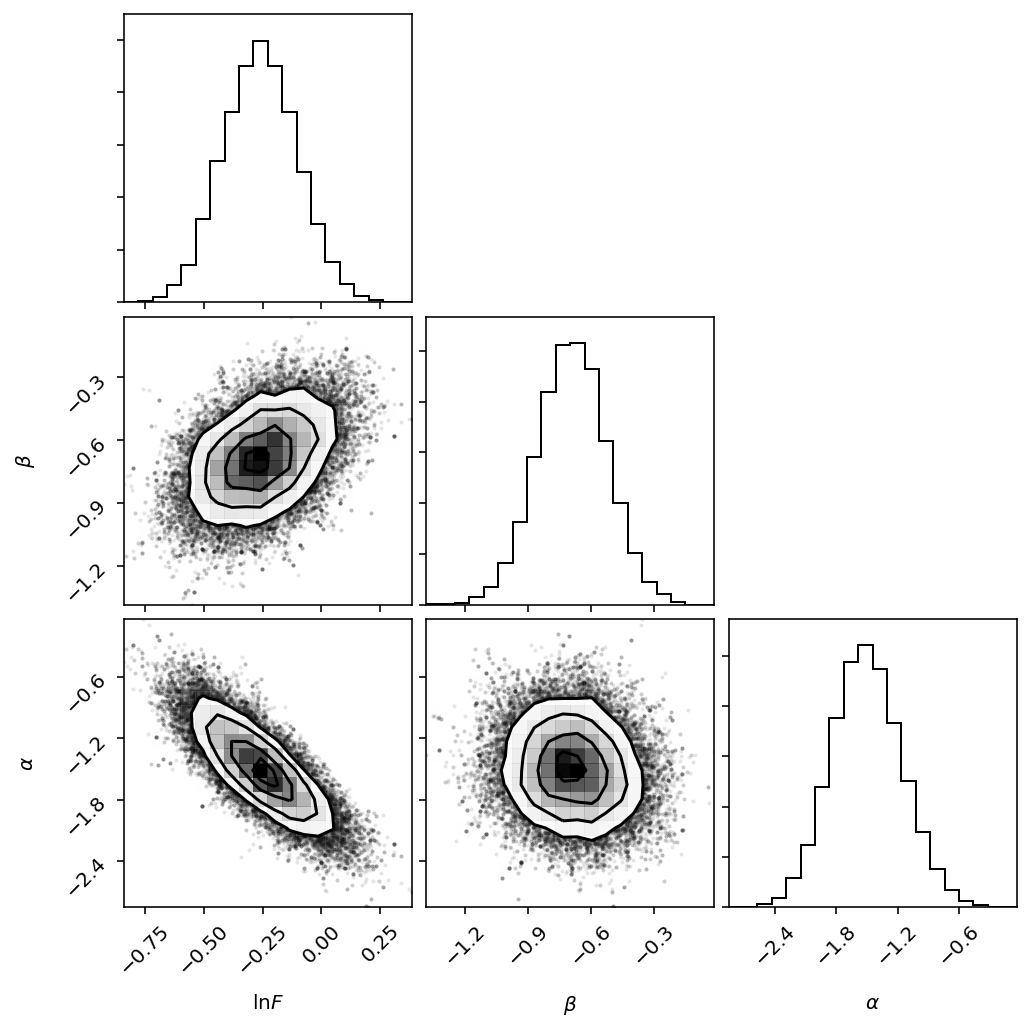

In [33]:
import corner
corner.corner(sampler.flatchain, labels=[r"$\ln F$", r"$\beta$", r"$\alpha$"]);

KeyboardInterrupt: 

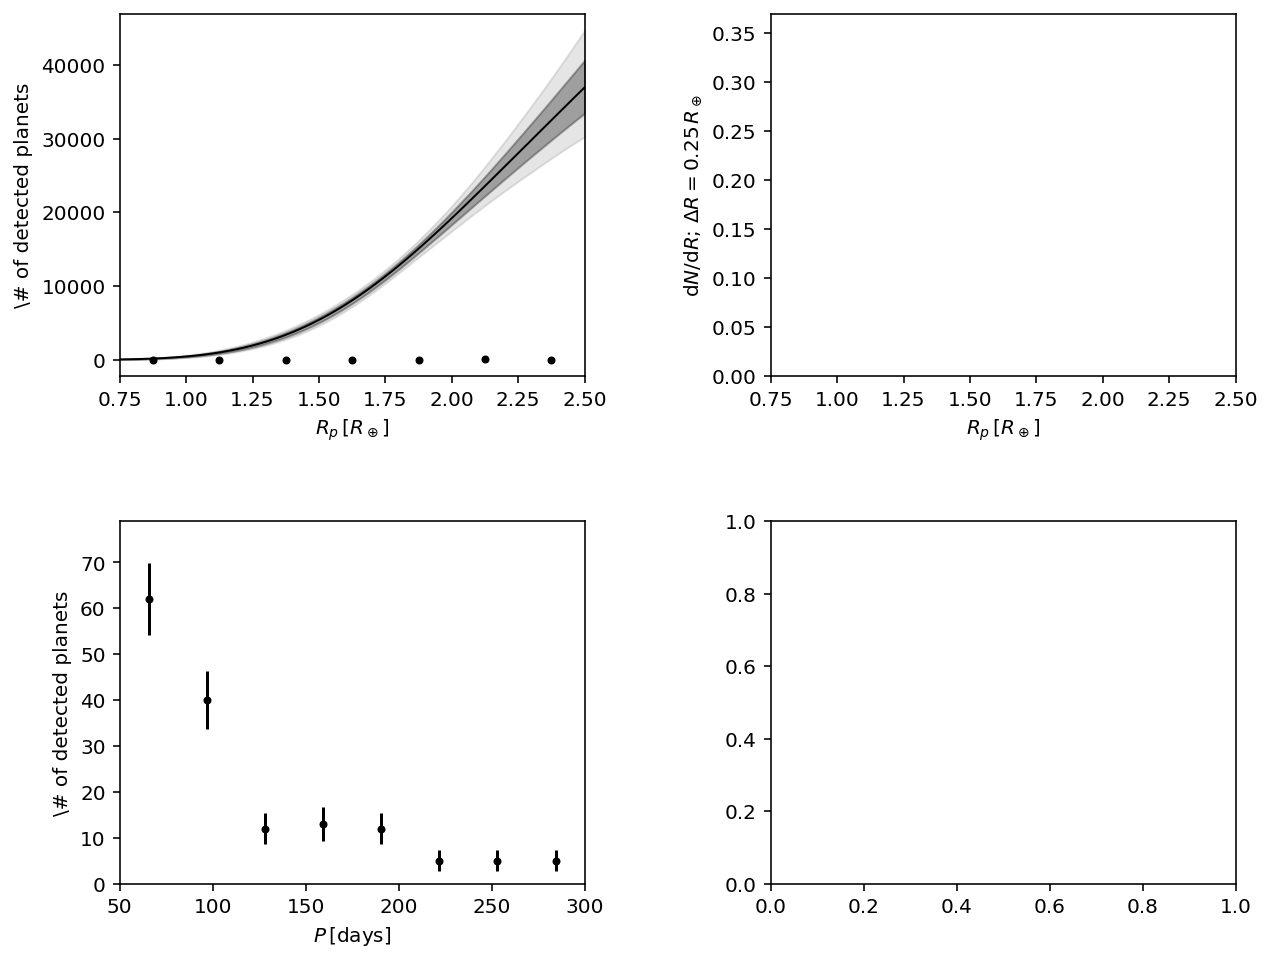

In [28]:
gamma_earth = plot_results(sampler.flatchain)

Comparing this to Figures 6--9 in Burke et al., you'll see that the results are more or less consistent and the predicted observations are good. For radii smaller than $R_\oplus$, the results start to diverge since I chose to use a single power law in radius instead of the double power law. When I tried to use a double power law, I found that the break radius was immediately pushed below $0.95\,R_\oplus$ (the smallest radius in the dataset) and the slope of the smaller radius power law was set only by the prior so it didn't seem necessary to include it here. In practice the final results are still consistent.

I would now claim this as a successful reproduction of the results from Burke et al. using only public datasets and their description of their method. One last interesting plot (that you might have noticed I computed in the `plot_results` function) is Figure 17 showing the rate of Earth-analogs defined (following [my definition](http://arxiv.org/abs/1406.3020)) as:

$$\Gamma_\oplus = \left.\frac{\mathrm{d} N}{\mathrm{d}\ln R_p\,\mathrm{d}\ln P} \right |_\oplus$$

Let's plot the constraint on $\Gamma_\oplus$:

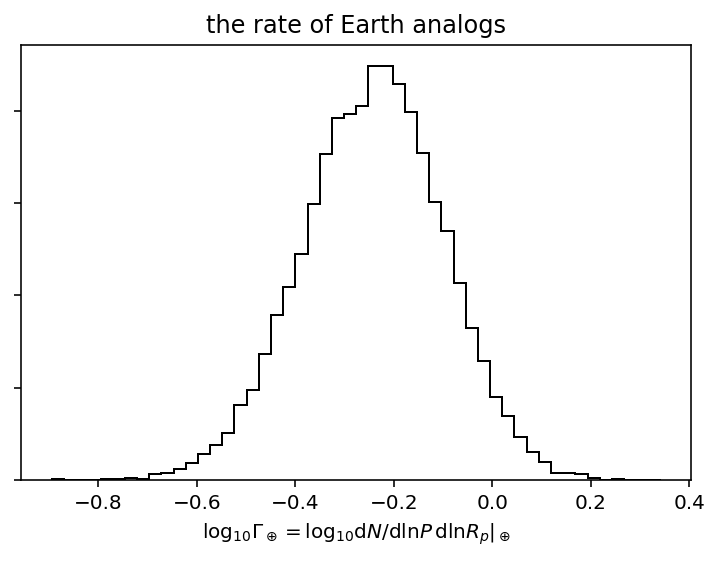

In [17]:
pl.hist(np.log10(gamma_earth), 50, histtype="step", color="k")
pl.gca().set_yticklabels([])
pl.title("the rate of Earth analogs")
pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");

This plot is consistent with Figure 17 from [Burke et al. (2015)](http://arxiv.org/abs/1506.04175) so we'll leave it here and call this a success for open science! Some of you might notice that this result is inconsistent with many previous estimates of this number (including my own!) but the discussion of this discrepancy is a topic for another day (or maybe a scientific publication).

*Thanks to Ruth Angus for reading through and catching some typos!*